## Recreate DQN model from Deepmind Atari paper

References:   
Paper: https://arxiv.org/pdf/1312.5602.pdf    
Pytorch tutorial: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [1]:
# import relevant packages
import torch
from collections import namedtuple, deque
import random
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import gym
import pandas as pd
import numpy as np
import cv2

### Experience Replay   
Data structure to store past experiences and sample some examples for training, the idea is to ***"alleviate the problems of correlated data and non-stationary distributions"***

In [2]:
# Use named tuple to represent Experience referred in paper
Experience = namedtuple('Experience', ["state", "action", "reward", "successor", "done"])

class ReplayMemory():
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        """add new experience"""
        self.memory.append(Experience(*args))
        
    def sample(self, batch_size):
        """randomly sample experiences from Replay Memory"""
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        """Override default len() method"""
        return len(self.memory)

### Training Model  
Build model based on the paper's description 
> The input to the neural network consists is an 84 × 84 × 4 image produced by φ. The first hidden layer convolves **16 8 × 8 filters with stride 4** with the input image and applies a **rectifier nonlinearity**. The second hidden layer convolves **32 4 × 4 filters with stride 2**, again followed by a **rectifier nonlinearity**. The final hidden layer is fully-connected and consists of **256 rectifier units**. The output layer is a fully- connected linear layer with a **single output for each valid action**.

In [3]:
class DQN_model(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN_model, self).__init__()
        self.layer1 = nn.Conv2d(input_shape[0], 16, kernel_size=(8,8), stride=4)
        self.layer2 = nn.Conv2d(16, 32, (4,4), stride=2)
        # output shape after EACH convo would be ((dimension - filter size)/stride +1) **2 (for 2 sides)
                                                                            # * 4 (stack) * output_channel
        dim_size = (((84-8)/4 + 1)-4)/2+1
        self.layer3 = nn.Linear(int((dim_size)**2 * 32), 256)
        self.output = nn.Linear(256, n_actions) 
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.layer3(x))
        x = self.output(x)
        
        return x

### Prepare environment   
The paper specifies several preprocessing steps to apply to the raw frames
>210 × 160 pixel images with a 128 color palette, can be computationally demanding, so we apply a basic preprocessing step aimed at reducing the input dimensionality. The raw frames are preprocessed by first converting their RGB representation to **gray-scale** and **down-sampling it to a 110×84 image**. The final input representation is obtained by cropping an 84 × 84 region of the image that roughly captures the playing area.

Using gym, we can apply **GrayScaleObservation** wrapper to get gray-scale representation, and instead of cropping to game play section, a **resize wrapper** is applied

<br>

> For the experiments in this paper, the function φ from algorithm 1 applies this preprocessing to the **last 4 frames of a history and stacks them** to produce the input to the Q-function.

For this, we can apply **FrameStack** wrapper to get a stacks of 4 frames

<br>

> Since the scale of scores varies greatly from game to game, we fixed all positive rewards to be 1 and all negative rewards to be −1, leaving 0 rewards unchanged.


Lastly, we can apply **ClipReward** wrapper to crop reward to specified range
<br>

Observation shape:  (4, 84, 84)


A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]


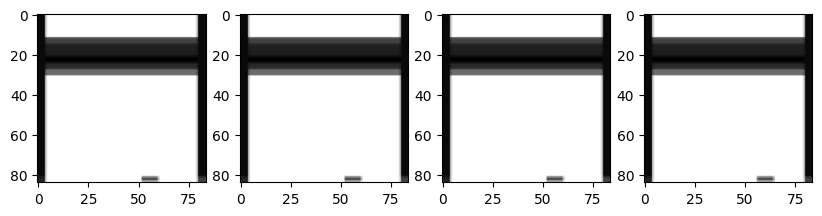

In [4]:
from gym.wrappers import GrayScaleObservation, ResizeObservation, FrameStack
from gym.utils.env_checker import check_env

# Wrapper to clip reward, taken from documentation
class ClipReward(gym.RewardWrapper):
    def __init__(self, env, min_reward, max_reward):
        super().__init__(env)
        self.min_reward = min_reward
        self.max_reward = max_reward
        self.reward_range = (min_reward, max_reward)
    
    def reward(self, reward):
        return np.clip(reward, self.min_reward, self.max_reward)
    
# observation wrapper for cropping
class AtariCropping(gym.ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        super().__init__(env)
        
        old_shape = env.observation_space.shape
        # get new shape after cropping
        new_shape = (old_shape[0]-50,) + old_shape[1:]
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=new_shape)

    def observation(self, img):
        """what happens to each observation"""
        # crop image (top and bottom, top from 34, bottom remove last 16)
        img = img[34:-16, :, :]
              
        return img

def generate_env(env_name):
    env = gym.make(env_name)
    env = ClipReward(env, -1, 1)
    env = AtariCropping(env)
    # gray scale frame
    env = GrayScaleObservation(env, keep_dim=False)
    # resize frame to 84×84 image
    env = ResizeObservation(env, (84, 84))
    # stack 4 frames (equivalent to what phi does in paper) 
    env = FrameStack(env, num_stack=4)
    
    return env
    
env = generate_env("Breakout-v4")
env.reset()
observation, reward, done, _ = env.step(env.action_space.sample())
print("Observation shape: ", env.observation_space.shape)

# visualize frames in each step 
_, axs = plt.subplots(1, 4, figsize=(10,10))
for i, image in enumerate(observation):
    axs[i].imshow(image, cmap=plt.cm.binary)
plt.show()

### Function to determine action
Apply $\epsilon$ greedy algorithm to choose action   
* Choose random action at probability $\epsilon$
* Choose optimal action (determined by model) at probability (1-$\epsilon$)

In [82]:
import random

def choose_action(model, state, device, epsilon=0.1):
    if random.random()<=epsilon: #exploration
        return env.action_space.sample()
    else:
#         squeeze to remove last dim of 1 (for gray scaled val) and add 1 dim at first (1 input instead of batch)
        state = torch.Tensor(state).squeeze().unsqueeze(0).to(device)
        # predict
        pred = model(state)
        return int(torch.argmax(pred.squeeze()).item())

### Loss function  
As mentioned in the paper, the function to optimize would be the following
> $$L_i(θ_i) = E_{s,a∼ρ(·)} [(y_i − Q (s, a; θ_i))]^2 $$
> where: $$y_i = E_{s′∼\mathcal{E}} [r + γ max_{a′} Q(s′, a′; θ_{i−1})|s, a]$$

Notation translation:
- θ refers to weights of model, $θ_i$ refers to model (with weights) at iteration i
- $Q (s, a; θ_i)$ (prediction) is Q value at (s, a) estimated by model
- $y_i$ (target function) is calculated using Bellman equation, but future reward (aka Q(s', a')) is (again) estimated by the model

Code translation:
- $Q (s, a; θ_i)$ is calculated by plug in state for model to predict, and get the output at action a (state and action sampled from experience replay)
- $max_{a′} Q(s′, a′; θ_{i−1}$ in $y_i$ is calculated by plug in successor state, then get the max output out of all actions
- loss is square root of $y_i$ (expected Q) - $Q (s, a; θ_i)$ (prediction)

In [154]:
def loss_fn(model, replay_memory, batch_size, discount, target_model=None, device="mps"):
    batch = replay_memory.sample(batch_size)

#     Transpose batch, ref: https://stackoverflow.com/questions/19339/transpose-unzip-function-inverse-of-zip/19343#19343
    batch = Experience(*zip(*batch))
    
#     convert to a single np.array for faster tensor conversion
    state = np.array(batch.state)
    successor = np.array(batch.successor)
            
    # Tensor-ify state, action, reward, successor, done (use torch tensor to have grad)
    state = torch.Tensor(state).squeeze().div_(255).to(device)
    action = torch.Tensor(batch.action).to(device)
    reward = torch.Tensor(batch.reward).to(device)
    successor = torch.Tensor(successor).squeeze().div_(255).to(device)
    done = torch.tensor(batch.done, dtype=torch.int32).to(device)

    # use model to get old qs and successor qs
    old_qs = model(state)
    # if target model is provided -> use that to compute successor instead
    successor_qs = model(successor) if target_model is None else target_model(successor) 
    
#   check for exploding/diminissing problem
#     print(torch.isnan(old_qs).any())
        
    # get the list of actions in shape 1xbatch_size, and use it as indices for old_qs
    action = action.unsqueeze(1).type(torch.int64)
    # get predicted qs at action, return tensor of list of batch_size items
    old_qs = old_qs.gather(1, action).squeeze()
    # get max q in successor to estimate future reward
    successor_qs = successor_qs.max(1)[0]
            
    # compute expected qs
    # multiplying (1-done) would result in not adding future reward when at end state (done==1)
    expected_qs = reward + successor_qs*discount*(1-done)
    expected_qs = expected_qs.detach() # shouldnt include this in grad graph
        
    # compute loss, return mean loss of batch 
    loss = (expected_qs-old_qs).pow(2).mean()
    
#     print("Old Qs ", old_qs)
#     print("Expected Qs ", expected_qs)
#     print("Loss ", loss.item())
    
    # improvement for stability - use different loss 
    # loss_func = nn.HuberLoss()
    # loss = loss_func(old_qs, expected_qs)
    
    # return predicted qs for visualization
    return loss, old_qs.data

### Evaluation 
Evaluate model by let model plays in the env in 10000 steps, and return **average reward** and **predicted Q** value of a <u>held out set of states</u>

In [ ]:
def eval_model(model, env):
    

### Parameters

In [155]:
# ------- Set up parameters -------
ENV = "BreakoutDeterministic-v4"
LOG_FREQ = 50 #number of EPISODES in-between logging results
CHECKPOINT_FREQ = 500000 #number of STEPS before saving model
EVAL_FREQ = 50000 #number of STEPS before saving model
SAVE_DIR = "Breakout" #directory to save stuffs

# ------ Hyper parameters ---------
LEARNING_RATE = 0.00001 if ENV == "BreakoutDeterministic-v4" else 0.00025
REPLAY_LEN = 1000000
BATCH_SIZE = 32
EPISODES = 16000
DISCOUNT = 0.99 #aka gamma in Bellman's equation
START_EPSILON= 1
END_EPSILON= 0.1
DECAY_STEPS=1000000 # steps to decay epsilon
USE_TARGET_MODEL=False # whether to have target model or not
UPDATE_TARGET=1000 #frames to run before updating the target model

### Setting up variables before training

In [156]:
# check for mps, cuda or cpu
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {device}")
model = DQN_model(env.observation_space.shape, env.action_space.n).to(device)
target_model = None
if USE_TARGET_MODEL:
    target_model = DQN_model(env.observation_space.shape, env.action_space.n).to(device)
    target_model.load_state_dict(model.state_dict())

# optimizer based on paper
# optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

# optimizer for first training (not-so-happy accident =)))
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

# recommended (less computational heavy compared to RMSprop)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
# array to store info per episodes
episodes = []
losses = []
rewards = []
pred_qs = []

# count to keep track of episodes and steps (for epsilon decay)
count = 0 # no episodes
steps = 0 # no steps

# build env
env = generate_env(ENV)
print(f"Current Atari environment: {ENV}")
print(f"Learning rate: {LEARNING_RATE}")

# Initialize replay memory with len of replay buffer
curr_state = env.reset()
curr_state = np.asarray(curr_state) #convert to np array
replay_memory = ReplayMemory(capacity=REPLAY_LEN)
for i in range(BATCH_SIZE):
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)
    
    observation = np.asarray(observation) #convert to np array
    replay_memory.push(curr_state, action, reward, observation, done)
    
    # update curr state
    curr_state = observation
    
print(f"Initial length of replay memory: {len(replay_memory)}")

Device: mps
Current Atari environment: BreakoutDeterministic-v4
Learning rate: 1e-05
Initial length of replay memory: 32


### Training process

In [157]:
# main training loop
for i in range(EPISODES):
    curr_state = env.reset()
    curr_state = np.asarray(curr_state) #convert to np array
    loss_val = 0 # loss value for curr episode
    reward_val = 0 # reward value for curr episode
    pred_q_val = float("-inf") # training estimated Q value for curr episode
    # keep track of actions chosen during episode
    action_count = {i:0 for i in range(env.action_space.n)}
    
    while True:
        # decay over the first million frames then stay at 0.1
        decay = (DECAY_STEPS - steps)/DECAY_STEPS if steps < DECAY_STEPS else 0
        epsilon = END_EPSILON + decay*(START_EPSILON-END_EPSILON)
        action = choose_action(model, curr_state, device, epsilon=epsilon)
        # execute action
        observation, reward, done, _ = env.step(action)
        observation = np.asarray(observation) #convert to np array
        # save observation
        replay_memory.push(curr_state, action, reward, observation, done)
        
        # update curr_state
        curr_state = observation
        
        # sample and compute loss
        loss, pred_q = loss_fn(model, replay_memory, BATCH_SIZE, DISCOUNT, target_model=target_model, device=device)
        
        # zero out gradient before backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if steps%200==0:
            # print loss and reward every 200 frames
            print(f"Steps:{steps} Action {action} Loss: {round(loss.item(),5)} Reward: {reward} Epsilon: {epsilon}")
        
        # update target model if available
        if USE_TARGET_MODEL:
            if frames%UPDATE_TARGET:
                target_model.load_state_dict(model.state_dict())
        
        # add steps count for epsilon decay
        steps+=1
        
        # update total reward of episode
        reward_val += reward
        
        # update loss as the max loss during episode
        loss_val = max(loss.item(), loss_val)
        
        # update predicted q in training
        pred_q_val = max(pred_q.max(), pred_q_val)
        
        # update action count
        action_count[action]+=1
        
        if steps%CHECKPOINT_FREQ:
            with open(f"{SAVE_DIR}/checkpoints/{steps}", 'wb') as f:
                torch.save(model.state_dict(), f)
                
        if steps%EVAL_FREQ:
            # eval steps
            print(f"Steps:{frames} Action {action} Loss: {round(loss.item(),5)} Reward: {reward} Epsilon: {epsilon}")
            
        
        if done: 
#             loss_val = loss.item()
            count+=1
            # finish an episode
            break
    print(f"Done with episode {count} in {steps} steps")
    print(f"Loss: {loss_val} Episode total reward: {reward_val} Predicted Qs: {pred_q_val}")
    print("Actions chosen counts: ", action_count)
#     print(f"Replay memory len: {len(replay_memory)}")
    print("----------------")
    if count%LOG_FREQ==0:
        episodes.append(count)
        losses.append(loss_val)
        rewards.append(reward_val)
        pred_qs.append(pred_q_val)
        
print("FINISH TRAINING PROCESS")
print(f"Finish in {steps} steps, Highest reward {max(rewards)}")

Frame:0 Action 3 Loss: 0.00061 Reward: 0.0 Epsilon: 1.0
Done with episode 1 in 186 frames
Loss: 0.03144501522183418 Episode total reward: 1.0 Predicted Qs: 0.17218682169914246
Actions chosen counts:  {0: 44, 1: 37, 2: 55, 3: 50}
Replay memory len: 218
----------------
Frame:200 Action 0 Loss: 8e-05 Reward: 0.0 Epsilon: 0.99982
Done with episode 2 in 315 frames
Loss: 0.03667745739221573 Episode total reward: 0.0 Predicted Qs: 0.4432365298271179
Actions chosen counts:  {0: 33, 1: 34, 2: 33, 3: 29}
Replay memory len: 347
----------------
Frame:400 Action 3 Loss: 0.00011 Reward: 0.0 Epsilon: 0.9996400000000001
Done with episode 3 in 456 frames
Loss: 0.050070181488990784 Episode total reward: 0.0 Predicted Qs: 1.1741889715194702
Actions chosen counts:  {0: 32, 1: 33, 2: 42, 3: 34}
Replay memory len: 488
----------------
Frame:600 Action 2 Loss: 0.0001 Reward: 0.0 Epsilon: 0.9994599999999999
Done with episode 4 in 692 frames
Loss: 0.08908814191818237 Episode total reward: 2.0 Predicted Qs: 1

Frame:5600 Action 3 Loss: 5e-05 Reward: 0.0 Epsilon: 0.99496
Done with episode 31 in 5677 frames
Loss: 0.09297225624322891 Episode total reward: 2.0 Predicted Qs: 1.0176440477371216
Actions chosen counts:  {0: 45, 1: 52, 2: 51, 3: 49}
Replay memory len: 5709
----------------
Frame:5800 Action 1 Loss: 7e-05 Reward: 0.0 Epsilon: 0.99478
Done with episode 32 in 5810 frames
Loss: 0.10317757725715637 Episode total reward: 0.0 Predicted Qs: 1.0950075387954712
Actions chosen counts:  {0: 29, 1: 39, 2: 36, 3: 29}
Replay memory len: 5842
----------------
Done with episode 33 in 5945 frames
Loss: 0.10196246951818466 Episode total reward: 0.0 Predicted Qs: 1.131798267364502
Actions chosen counts:  {0: 33, 1: 34, 2: 37, 3: 31}
Replay memory len: 5977
----------------
Frame:6000 Action 0 Loss: 6e-05 Reward: 0.0 Epsilon: 0.9946
Done with episode 34 in 6186 frames
Loss: 0.06806717067956924 Episode total reward: 2.0 Predicted Qs: 1.1284115314483643
Actions chosen counts:  {0: 62, 1: 45, 2: 63, 3: 71}


Done with episode 62 in 10974 frames
Loss: 0.11214546859264374 Episode total reward: 0.0 Predicted Qs: 1.217046856880188
Actions chosen counts:  {0: 35, 1: 29, 2: 57, 3: 43}
Replay memory len: 11006
----------------
Frame:11000 Action 1 Loss: 0.00014 Reward: 0.0 Epsilon: 0.9901
Done with episode 63 in 11108 frames
Loss: 0.07293860614299774 Episode total reward: 0.0 Predicted Qs: 1.1600770950317383
Actions chosen counts:  {0: 31, 1: 34, 2: 35, 3: 34}
Replay memory len: 11140
----------------
Frame:11200 Action 1 Loss: 0.03067 Reward: 0.0 Epsilon: 0.98992
Done with episode 64 in 11239 frames
Loss: 0.06288740783929825 Episode total reward: 0.0 Predicted Qs: 1.0791957378387451
Actions chosen counts:  {0: 30, 1: 39, 2: 29, 3: 33}
Replay memory len: 11271
----------------
Done with episode 65 in 11394 frames
Loss: 0.0919252336025238 Episode total reward: 1.0 Predicted Qs: 1.137398600578308
Actions chosen counts:  {0: 31, 1: 44, 2: 38, 3: 42}
Replay memory len: 11426
----------------
Frame:11

Frame:16200 Action 0 Loss: 0.0302 Reward: 0.0 Epsilon: 0.98542
Done with episode 92 in 16333 frames
Loss: 0.10031000524759293 Episode total reward: 2.0 Predicted Qs: 1.173581838607788
Actions chosen counts:  {0: 55, 1: 57, 2: 62, 3: 46}
Replay memory len: 16365
----------------
Frame:16400 Action 1 Loss: 5e-05 Reward: 0.0 Epsilon: 0.98524
Done with episode 93 in 16477 frames
Loss: 0.09242374449968338 Episode total reward: 0.0 Predicted Qs: 0.9864678978919983
Actions chosen counts:  {0: 45, 1: 27, 2: 39, 3: 33}
Replay memory len: 16509
----------------
Frame:16600 Action 1 Loss: 0.00039 Reward: 0.0 Epsilon: 0.98506
Done with episode 94 in 16651 frames
Loss: 0.06267522275447845 Episode total reward: 1.0 Predicted Qs: 0.9670469164848328
Actions chosen counts:  {0: 40, 1: 43, 2: 48, 3: 43}
Replay memory len: 16683
----------------
Frame:16800 Action 2 Loss: 0.00025 Reward: 0.0 Epsilon: 0.98488
Done with episode 95 in 16822 frames
Loss: 0.08322490751743317 Episode total reward: 0.0 Predicte

Done with episode 122 in 21564 frames
Loss: 0.06582143157720566 Episode total reward: 0.0 Predicted Qs: 1.0219422578811646
Actions chosen counts:  {0: 39, 1: 29, 2: 28, 3: 32}
Replay memory len: 21596
----------------
Frame:21600 Action 2 Loss: 0.00014 Reward: 0.0 Epsilon: 0.98056
Done with episode 123 in 21746 frames
Loss: 0.06466903537511826 Episode total reward: 1.0 Predicted Qs: 1.050678014755249
Actions chosen counts:  {0: 55, 1: 43, 2: 42, 3: 42}
Replay memory len: 21778
----------------
Frame:21800 Action 0 Loss: 0.03064 Reward: 0.0 Epsilon: 0.9803799999999999
Done with episode 124 in 21884 frames
Loss: 0.11770804226398468 Episode total reward: 0.0 Predicted Qs: 1.2036066055297852
Actions chosen counts:  {0: 35, 1: 30, 2: 32, 3: 41}
Replay memory len: 21916
----------------
Frame:22000 Action 1 Loss: 0.03017 Reward: 0.0 Epsilon: 0.9802
Done with episode 125 in 22056 frames
Loss: 0.06877170503139496 Episode total reward: 1.0 Predicted Qs: 1.2445253133773804
Actions chosen counts:

Frame:26800 Action 1 Loss: 8e-05 Reward: 0.0 Epsilon: 0.97588
Done with episode 152 in 26849 frames
Loss: 0.1257452815771103 Episode total reward: 4.0 Predicted Qs: 1.0581638813018799
Actions chosen counts:  {0: 67, 1: 65, 2: 61, 3: 70}
Replay memory len: 26881
----------------
Done with episode 153 in 26977 frames
Loss: 0.09323616325855255 Episode total reward: 0.0 Predicted Qs: 1.1768712997436523
Actions chosen counts:  {0: 33, 1: 28, 2: 32, 3: 35}
Replay memory len: 27009
----------------
Frame:27000 Action 3 Loss: 0.03019 Reward: 0.0 Epsilon: 0.9757
Done with episode 154 in 27115 frames
Loss: 0.1047581285238266 Episode total reward: 0.0 Predicted Qs: 1.1782097816467285
Actions chosen counts:  {0: 32, 1: 29, 2: 41, 3: 36}
Replay memory len: 27147
----------------
Frame:27200 Action 2 Loss: 4e-05 Reward: 0.0 Epsilon: 0.9755199999999999
Done with episode 155 in 27247 frames
Loss: 0.08914051949977875 Episode total reward: 0.0 Predicted Qs: 0.9769236445426941
Actions chosen counts:  {0:

Frame:31800 Action 3 Loss: 3e-05 Reward: 0.0 Epsilon: 0.9713799999999999
Done with episode 183 in 31804 frames
Loss: 0.07008090615272522 Episode total reward: 1.0 Predicted Qs: 0.935509443283081
Actions chosen counts:  {0: 52, 1: 42, 2: 47, 3: 52}
Replay memory len: 31836
----------------
Done with episode 184 in 31954 frames
Loss: 0.09533362090587616 Episode total reward: 0.0 Predicted Qs: 0.8532134294509888
Actions chosen counts:  {0: 31, 1: 32, 2: 45, 3: 42}
Replay memory len: 31986
----------------
Frame:32000 Action 2 Loss: 0.06138 Reward: 0.0 Epsilon: 0.9712
Done with episode 185 in 32143 frames
Loss: 0.09888516366481781 Episode total reward: 1.0 Predicted Qs: 1.0878928899765015
Actions chosen counts:  {0: 49, 1: 45, 2: 49, 3: 46}
Replay memory len: 32175
----------------
Frame:32200 Action 0 Loss: 4e-05 Reward: 0.0 Epsilon: 0.97102
Done with episode 186 in 32299 frames
Loss: 0.0946318656206131 Episode total reward: 0.0 Predicted Qs: 1.2612497806549072
Actions chosen counts:  {0:

Frame:37000 Action 2 Loss: 5e-05 Reward: 0.0 Epsilon: 0.9667
Done with episode 213 in 37027 frames
Loss: 0.06126084178686142 Episode total reward: 1.0 Predicted Qs: 0.8918263912200928
Actions chosen counts:  {0: 39, 1: 41, 2: 49, 3: 55}
Replay memory len: 37059
----------------
Frame:37200 Action 1 Loss: 0.01914 Reward: 1.0 Epsilon: 0.9665199999999999
Done with episode 214 in 37233 frames
Loss: 0.07619497925043106 Episode total reward: 2.0 Predicted Qs: 0.8925865888595581
Actions chosen counts:  {0: 52, 1: 55, 2: 47, 3: 52}
Replay memory len: 37265
----------------
Done with episode 215 in 37374 frames
Loss: 0.0774165466427803 Episode total reward: 0.0 Predicted Qs: 0.8597949743270874
Actions chosen counts:  {0: 29, 1: 36, 2: 37, 3: 39}
Replay memory len: 37406
----------------
Frame:37400 Action 3 Loss: 0.01619 Reward: 0.0 Epsilon: 0.96634
Done with episode 216 in 37514 frames
Loss: 0.07775222510099411 Episode total reward: 0.0 Predicted Qs: 0.7893328666687012
Actions chosen counts:  

Frame:42400 Action 3 Loss: 3e-05 Reward: 0.0 Epsilon: 0.96184
Done with episode 243 in 42434 frames
Loss: 0.061392996460199356 Episode total reward: 2.0 Predicted Qs: 0.925428032875061
Actions chosen counts:  {0: 46, 1: 59, 2: 42, 3: 44}
Replay memory len: 42466
----------------
Done with episode 244 in 42591 frames
Loss: 0.06497721374034882 Episode total reward: 1.0 Predicted Qs: 1.1054881811141968
Actions chosen counts:  {0: 40, 1: 43, 2: 37, 3: 37}
Replay memory len: 42623
----------------
Frame:42600 Action 3 Loss: 4e-05 Reward: 0.0 Epsilon: 0.9616600000000001
Frame:42800 Action 2 Loss: 0.02828 Reward: 0.0 Epsilon: 0.96148
Done with episode 245 in 42937 frames
Loss: 0.09298853576183319 Episode total reward: 4.0 Predicted Qs: 1.1345006227493286
Actions chosen counts:  {0: 84, 1: 77, 2: 86, 3: 99}
Replay memory len: 42969
----------------
Frame:43000 Action 0 Loss: 7e-05 Reward: 0.0 Epsilon: 0.9612999999999999
Done with episode 246 in 43091 frames
Loss: 0.07554840296506882 Episode to

Frame:48000 Action 0 Loss: 7e-05 Reward: 0.0 Epsilon: 0.9568
Done with episode 273 in 48040 frames
Loss: 0.0854904055595398 Episode total reward: 3.0 Predicted Qs: 1.1120153665542603
Actions chosen counts:  {0: 67, 1: 56, 2: 67, 3: 65}
Replay memory len: 48072
----------------
Done with episode 274 in 48200 frames
Loss: 0.0627906545996666 Episode total reward: 1.0 Predicted Qs: 1.1253570318222046
Actions chosen counts:  {0: 39, 1: 42, 2: 37, 3: 42}
Replay memory len: 48232
----------------
Frame:48200 Action 3 Loss: 0.00011 Reward: 0.0 Epsilon: 0.95662
Done with episode 275 in 48338 frames
Loss: 0.0723256766796112 Episode total reward: 0.0 Predicted Qs: 1.1385403871536255
Actions chosen counts:  {0: 27, 1: 32, 2: 39, 3: 40}
Replay memory len: 48370
----------------
Frame:48400 Action 3 Loss: 8e-05 Reward: 0.0 Epsilon: 0.95644
Done with episode 276 in 48499 frames
Loss: 0.058866068720817566 Episode total reward: 1.0 Predicted Qs: 1.062716007232666
Actions chosen counts:  {0: 39, 1: 34, 

Done with episode 303 in 53181 frames
Loss: 0.07523809373378754 Episode total reward: 1.0 Predicted Qs: 1.062130331993103
Actions chosen counts:  {0: 46, 1: 39, 2: 46, 3: 47}
Replay memory len: 53213
----------------
Frame:53200 Action 0 Loss: 0.0001 Reward: 0.0 Epsilon: 0.95212
Frame:53400 Action 2 Loss: 0.02936 Reward: 0.0 Epsilon: 0.95194
Done with episode 304 in 53436 frames
Loss: 0.09014945477247238 Episode total reward: 3.0 Predicted Qs: 1.1648125648498535
Actions chosen counts:  {0: 39, 1: 66, 2: 84, 3: 66}
Replay memory len: 53468
----------------
Frame:53600 Action 2 Loss: 0.00013 Reward: 0.0 Epsilon: 0.95176
Done with episode 305 in 53618 frames
Loss: 0.08959640562534332 Episode total reward: 1.0 Predicted Qs: 1.1580055952072144
Actions chosen counts:  {0: 38, 1: 45, 2: 54, 3: 45}
Replay memory len: 53650
----------------
Frame:53800 Action 0 Loss: 5e-05 Reward: 0.0 Epsilon: 0.95158
Done with episode 306 in 53935 frames
Loss: 0.06572072952985764 Episode total reward: 5.0 Pred

Frame:58800 Action 3 Loss: 6e-05 Reward: 0.0 Epsilon: 0.94708
Done with episode 333 in 58829 frames
Loss: 0.06135043501853943 Episode total reward: 2.0 Predicted Qs: 1.0130138397216797
Actions chosen counts:  {0: 47, 1: 55, 2: 48, 3: 66}
Replay memory len: 58861
----------------
Frame:59000 Action 1 Loss: 5e-05 Reward: 0.0 Epsilon: 0.9469
Done with episode 334 in 59034 frames
Loss: 0.059799715876579285 Episode total reward: 2.0 Predicted Qs: 1.0019910335540771
Actions chosen counts:  {0: 49, 1: 49, 2: 52, 3: 55}
Replay memory len: 59066
----------------
Frame:59200 Action 2 Loss: 0.0305 Reward: 0.0 Epsilon: 0.94672
Done with episode 335 in 59227 frames
Loss: 0.07385759800672531 Episode total reward: 1.0 Predicted Qs: 1.1051931381225586
Actions chosen counts:  {0: 63, 1: 35, 2: 46, 3: 49}
Replay memory len: 59259
----------------
Done with episode 336 in 59391 frames
Loss: 0.05751636624336243 Episode total reward: 1.0 Predicted Qs: 1.1617205142974854
Actions chosen counts:  {0: 40, 1: 4

Frame:64600 Action 3 Loss: 8e-05 Reward: 0.0 Epsilon: 0.94186
Done with episode 363 in 64673 frames
Loss: 0.10421478003263474 Episode total reward: 0.0 Predicted Qs: 1.1571247577667236
Actions chosen counts:  {0: 35, 1: 34, 2: 33, 3: 40}
Replay memory len: 64705
----------------
Frame:64800 Action 0 Loss: 0.01961 Reward: 0.0 Epsilon: 0.9416800000000001
Done with episode 364 in 64869 frames
Loss: 0.10365922003984451 Episode total reward: 1.0 Predicted Qs: 1.3394407033920288
Actions chosen counts:  {0: 49, 1: 44, 2: 54, 3: 49}
Replay memory len: 64901
----------------
Frame:65000 Action 1 Loss: 9e-05 Reward: 0.0 Epsilon: 0.9415
Done with episode 365 in 65103 frames
Loss: 0.09553761035203934 Episode total reward: 3.0 Predicted Qs: 1.372035026550293
Actions chosen counts:  {0: 54, 1: 62, 2: 47, 3: 71}
Replay memory len: 65135
----------------
Frame:65200 Action 3 Loss: 0.00205 Reward: 0.0 Epsilon: 0.9413199999999999
Done with episode 366 in 65234 frames
Loss: 0.05240454152226448 Episode to

Frame:70400 Action 1 Loss: 0.00029 Reward: 0.0 Epsilon: 0.93664
Done with episode 392 in 70442 frames
Loss: 0.06836418807506561 Episode total reward: 0.0 Predicted Qs: 1.393743634223938
Actions chosen counts:  {0: 29, 1: 35, 2: 42, 3: 36}
Replay memory len: 70474
----------------
Frame:70600 Action 0 Loss: 0.0305 Reward: 0.0 Epsilon: 0.93646
Done with episode 393 in 70633 frames
Loss: 0.07293915748596191 Episode total reward: 1.0 Predicted Qs: 1.3998298645019531
Actions chosen counts:  {0: 48, 1: 42, 2: 53, 3: 48}
Replay memory len: 70665
----------------
Done with episode 394 in 70794 frames
Loss: 0.06820213794708252 Episode total reward: 1.0 Predicted Qs: 1.4839621782302856
Actions chosen counts:  {0: 44, 1: 32, 2: 42, 3: 43}
Replay memory len: 70826
----------------
Frame:70800 Action 2 Loss: 0.00016 Reward: 0.0 Epsilon: 0.93628
Done with episode 395 in 70959 frames
Loss: 0.08777554333209991 Episode total reward: 1.0 Predicted Qs: 1.6417136192321777
Actions chosen counts:  {0: 33, 1

Done with episode 422 in 75796 frames
Loss: 0.05778320133686066 Episode total reward: 1.0 Predicted Qs: 1.6236425638198853
Actions chosen counts:  {0: 35, 1: 38, 2: 42, 3: 44}
Replay memory len: 75828
----------------
Frame:75800 Action 0 Loss: 0.0001 Reward: 0.0 Epsilon: 0.93178
Done with episode 423 in 75975 frames
Loss: 0.061729129403829575 Episode total reward: 1.0 Predicted Qs: 1.7662392854690552
Actions chosen counts:  {0: 44, 1: 41, 2: 42, 3: 52}
Replay memory len: 76007
----------------
Frame:76000 Action 0 Loss: 0.03801 Reward: 0.0 Epsilon: 0.9316
Frame:76200 Action 2 Loss: 0.0319 Reward: 0.0 Epsilon: 0.9314199999999999
Done with episode 424 in 76225 frames
Loss: 0.09113717079162598 Episode total reward: 3.0 Predicted Qs: 1.698039174079895
Actions chosen counts:  {0: 65, 1: 52, 2: 57, 3: 76}
Replay memory len: 76257
----------------
Done with episode 425 in 76353 frames
Loss: 0.04619305953383446 Episode total reward: 0.0 Predicted Qs: 1.5936768054962158
Actions chosen counts: 

Done with episode 451 in 81445 frames
Loss: 0.050113171339035034 Episode total reward: 2.0 Predicted Qs: 1.622880220413208
Actions chosen counts:  {0: 33, 1: 46, 2: 46, 3: 68}
Replay memory len: 81477
----------------
Frame:81600 Action 3 Loss: 0.00061 Reward: 0.0 Epsilon: 0.9265599999999999
Done with episode 452 in 81645 frames
Loss: 0.07448834925889969 Episode total reward: 2.0 Predicted Qs: 1.597605586051941
Actions chosen counts:  {0: 52, 1: 47, 2: 42, 3: 59}
Replay memory len: 81677
----------------
Frame:81800 Action 1 Loss: 0.0339 Reward: 0.0 Epsilon: 0.92638
Done with episode 453 in 81873 frames
Loss: 0.0691220760345459 Episode total reward: 2.0 Predicted Qs: 1.7860969305038452
Actions chosen counts:  {0: 49, 1: 56, 2: 53, 3: 70}
Replay memory len: 81905
----------------
Frame:82000 Action 3 Loss: 0.00018 Reward: 0.0 Epsilon: 0.9262
Done with episode 454 in 82137 frames
Loss: 0.10631416738033295 Episode total reward: 3.0 Predicted Qs: 2.039851427078247
Actions chosen counts:  {

Done with episode 480 in 87308 frames
Loss: 0.07601804286241531 Episode total reward: 5.0 Predicted Qs: 2.2238152027130127
Actions chosen counts:  {0: 87, 1: 74, 2: 90, 3: 88}
Replay memory len: 87340
----------------
Frame:87400 Action 2 Loss: 0.00014 Reward: 0.0 Epsilon: 0.9213399999999999
Done with episode 481 in 87501 frames
Loss: 0.07326541095972061 Episode total reward: 2.0 Predicted Qs: 1.924182415008545
Actions chosen counts:  {0: 41, 1: 45, 2: 36, 3: 71}
Replay memory len: 87533
----------------
Frame:87600 Action 0 Loss: 0.06343 Reward: 0.0 Epsilon: 0.92116
Done with episode 482 in 87727 frames
Loss: 0.08082301169633865 Episode total reward: 2.0 Predicted Qs: 2.1692373752593994
Actions chosen counts:  {0: 70, 1: 39, 2: 48, 3: 69}
Replay memory len: 87759
----------------
Frame:87800 Action 0 Loss: 0.01421 Reward: 0.0 Epsilon: 0.92098
Done with episode 483 in 87932 frames
Loss: 0.10160375386476517 Episode total reward: 2.0 Predicted Qs: 2.1684935092926025
Actions chosen counts

Frame:93600 Action 1 Loss: 0.00014 Reward: 0.0 Epsilon: 0.91576
Done with episode 509 in 93700 frames
Loss: 0.08337679505348206 Episode total reward: 3.0 Predicted Qs: 2.3055386543273926
Actions chosen counts:  {0: 51, 1: 68, 2: 53, 3: 75}
Replay memory len: 93732
----------------
Frame:93800 Action 2 Loss: 0.02446 Reward: 0.0 Epsilon: 0.91558
Done with episode 510 in 93936 frames
Loss: 0.10048740357160568 Episode total reward: 3.0 Predicted Qs: 2.3253262042999268
Actions chosen counts:  {0: 62, 1: 52, 2: 57, 3: 65}
Replay memory len: 93968
----------------
Frame:94000 Action 3 Loss: 0.00014 Reward: 0.0 Epsilon: 0.9154
Frame:94200 Action 3 Loss: 0.00057 Reward: 0.0 Epsilon: 0.91522
Done with episode 511 in 94229 frames
Loss: 0.08077070116996765 Episode total reward: 4.0 Predicted Qs: 2.293074607849121
Actions chosen counts:  {0: 66, 1: 80, 2: 63, 3: 84}
Replay memory len: 94261
----------------
Frame:94400 Action 1 Loss: 0.01127 Reward: 0.0 Epsilon: 0.91504
Done with episode 512 in 944

Frame:99800 Action 2 Loss: 0.00064 Reward: 0.0 Epsilon: 0.91018
Done with episode 538 in 99880 frames
Loss: 0.13472984731197357 Episode total reward: 2.0 Predicted Qs: 2.7844128608703613
Actions chosen counts:  {0: 46, 1: 42, 2: 54, 3: 58}
Replay memory len: 99912
----------------
Frame:100000 Action 3 Loss: 0.00172 Reward: 0.0 Epsilon: 0.91
Done with episode 539 in 100048 frames
Loss: 0.1660425066947937 Episode total reward: 1.0 Predicted Qs: 2.692641258239746
Actions chosen counts:  {0: 35, 1: 39, 2: 42, 3: 52}
Replay memory len: 100080
----------------
Frame:100200 Action 3 Loss: 0.01632 Reward: 0.0 Epsilon: 0.9098200000000001
Done with episode 540 in 100255 frames
Loss: 0.13465309143066406 Episode total reward: 2.0 Predicted Qs: 2.870255708694458
Actions chosen counts:  {0: 47, 1: 57, 2: 49, 3: 54}
Replay memory len: 100287
----------------
Done with episode 541 in 100396 frames
Loss: 0.092295803129673 Episode total reward: 0.0 Predicted Qs: 2.63384747505188
Actions chosen counts: 

Done with episode 567 in 105286 frames
Loss: 0.13969068229198456 Episode total reward: 2.0 Predicted Qs: 2.8031890392303467
Actions chosen counts:  {0: 40, 1: 46, 2: 51, 3: 61}
Replay memory len: 105318
----------------
Frame:105400 Action 2 Loss: 0.03359 Reward: 0.0 Epsilon: 0.90514
Done with episode 568 in 105529 frames
Loss: 0.10560633987188339 Episode total reward: 3.0 Predicted Qs: 2.872525691986084
Actions chosen counts:  {0: 63, 1: 61, 2: 61, 3: 58}
Replay memory len: 105561
----------------
Frame:105600 Action 3 Loss: 0.0013 Reward: 0.0 Epsilon: 0.90496
Done with episode 569 in 105675 frames
Loss: 0.0853758156299591 Episode total reward: 0.0 Predicted Qs: 2.6853129863739014
Actions chosen counts:  {0: 34, 1: 31, 2: 39, 3: 42}
Replay memory len: 105707
----------------
Frame:105800 Action 0 Loss: 0.01008 Reward: 0.0 Epsilon: 0.90478
Done with episode 570 in 105923 frames
Loss: 0.11247370392084122 Episode total reward: 3.0 Predicted Qs: 2.7873106002807617
Actions chosen counts:  

Done with episode 596 in 110742 frames
Loss: 0.15735039114952087 Episode total reward: 0.0 Predicted Qs: 3.0347297191619873
Actions chosen counts:  {0: 35, 1: 30, 2: 43, 3: 47}
Replay memory len: 110774
----------------
Frame:110800 Action 3 Loss: 0.02258 Reward: 0.0 Epsilon: 0.90028
Done with episode 597 in 110943 frames
Loss: 0.12018556892871857 Episode total reward: 1.0 Predicted Qs: 3.063112258911133
Actions chosen counts:  {0: 52, 1: 39, 2: 53, 3: 57}
Replay memory len: 110975
----------------
Frame:111000 Action 2 Loss: 0.00443 Reward: 0.0 Epsilon: 0.9001
Done with episode 598 in 111106 frames
Loss: 0.11999055743217468 Episode total reward: 1.0 Predicted Qs: 3.0755701065063477
Actions chosen counts:  {0: 30, 1: 31, 2: 55, 3: 47}
Replay memory len: 111138
----------------
Frame:111200 Action 3 Loss: 0.00385 Reward: 0.0 Epsilon: 0.89992
Done with episode 599 in 111270 frames
Loss: 0.239737868309021 Episode total reward: 1.0 Predicted Qs: 3.091799259185791
Actions chosen counts:  {0

Done with episode 626 in 116183 frames
Loss: 0.09827499091625214 Episode total reward: 1.0 Predicted Qs: 2.9531667232513428
Actions chosen counts:  {0: 39, 1: 52, 2: 52, 3: 45}
Replay memory len: 116215
----------------
Frame:116200 Action 0 Loss: 0.00115 Reward: 0.0 Epsilon: 0.89542
Done with episode 627 in 116321 frames
Loss: 0.1096431240439415 Episode total reward: 0.0 Predicted Qs: 3.0709915161132812
Actions chosen counts:  {0: 36, 1: 36, 2: 34, 3: 32}
Replay memory len: 116353
----------------
Frame:116400 Action 2 Loss: 0.02108 Reward: 0.0 Epsilon: 0.89524
Done with episode 628 in 116527 frames
Loss: 0.07686422765254974 Episode total reward: 2.0 Predicted Qs: 2.9607367515563965
Actions chosen counts:  {0: 47, 1: 53, 2: 42, 3: 64}
Replay memory len: 116559
----------------
Frame:116600 Action 1 Loss: 0.00258 Reward: 0.0 Epsilon: 0.89506
Done with episode 629 in 116750 frames
Loss: 0.10740748047828674 Episode total reward: 2.0 Predicted Qs: 2.865464687347412
Actions chosen counts: 

Frame:121800 Action 3 Loss: 0.00054 Reward: 0.0 Epsilon: 0.89038
Done with episode 655 in 121865 frames
Loss: 0.12454044818878174 Episode total reward: 5.0 Predicted Qs: 2.995903730392456
Actions chosen counts:  {0: 85, 1: 79, 2: 107, 3: 98}
Replay memory len: 121897
----------------
Done with episode 656 in 121999 frames
Loss: 0.08126293867826462 Episode total reward: 0.0 Predicted Qs: 2.8443307876586914
Actions chosen counts:  {0: 31, 1: 22, 2: 38, 3: 43}
Replay memory len: 122031
----------------
Frame:122000 Action 3 Loss: 0.00415 Reward: 0.0 Epsilon: 0.8902
Frame:122200 Action 3 Loss: 0.00073 Reward: 0.0 Epsilon: 0.89002
Done with episode 657 in 122218 frames
Loss: 0.14738400280475616 Episode total reward: 2.0 Predicted Qs: 3.2215476036071777
Actions chosen counts:  {0: 51, 1: 57, 2: 48, 3: 63}
Replay memory len: 122250
----------------
Frame:122400 Action 3 Loss: 0.0446 Reward: 0.0 Epsilon: 0.8898400000000001
Done with episode 658 in 122435 frames
Loss: 0.12265810370445251 Episod

Frame:127600 Action 3 Loss: 0.00353 Reward: 0.0 Epsilon: 0.88516
Done with episode 684 in 127692 frames
Loss: 0.11479132622480392 Episode total reward: 4.0 Predicted Qs: 3.053988218307495
Actions chosen counts:  {0: 62, 1: 51, 2: 68, 3: 91}
Replay memory len: 127724
----------------
Frame:127800 Action 2 Loss: 0.00091 Reward: 0.0 Epsilon: 0.88498
Done with episode 685 in 127823 frames
Loss: 0.14654436707496643 Episode total reward: 0.0 Predicted Qs: 3.2194573879241943
Actions chosen counts:  {0: 26, 1: 32, 2: 40, 3: 33}
Replay memory len: 127855
----------------
Frame:128000 Action 2 Loss: 0.00161 Reward: 0.0 Epsilon: 0.8848
Done with episode 686 in 128092 frames
Loss: 0.14455340802669525 Episode total reward: 3.0 Predicted Qs: 2.868542194366455
Actions chosen counts:  {0: 59, 1: 48, 2: 71, 3: 91}
Replay memory len: 128124
----------------
Frame:128200 Action 3 Loss: 0.03382 Reward: 0.0 Epsilon: 0.88462
Done with episode 687 in 128268 frames
Loss: 0.134214848279953 Episode total reward

Done with episode 713 in 133199 frames
Loss: 0.08558366447687149 Episode total reward: 0.0 Predicted Qs: 2.6460845470428467
Actions chosen counts:  {0: 27, 1: 39, 2: 24, 3: 35}
Replay memory len: 133231
----------------
Frame:133200 Action 1 Loss: 0.00836 Reward: 0.0 Epsilon: 0.88012
Done with episode 714 in 133388 frames
Loss: 0.08741265535354614 Episode total reward: 2.0 Predicted Qs: 2.738375186920166
Actions chosen counts:  {0: 41, 1: 45, 2: 44, 3: 59}
Replay memory len: 133420
----------------
Frame:133400 Action 2 Loss: 0.09025 Reward: 0.0 Epsilon: 0.87994
Done with episode 715 in 133580 frames
Loss: 0.15782961249351501 Episode total reward: 2.0 Predicted Qs: 2.9386136531829834
Actions chosen counts:  {0: 40, 1: 46, 2: 48, 3: 58}
Replay memory len: 133612
----------------
Frame:133600 Action 0 Loss: 0.06235 Reward: 0.0 Epsilon: 0.87976
Done with episode 716 in 133749 frames
Loss: 0.14914748072624207 Episode total reward: 1.0 Predicted Qs: 2.691559076309204
Actions chosen counts: 

Frame:138600 Action 2 Loss: 0.01312 Reward: 0.0 Epsilon: 0.87526
Frame:138800 Action 2 Loss: 0.00424 Reward: 0.0 Epsilon: 0.87508
Done with episode 743 in 138810 frames
Loss: 0.11660746484994888 Episode total reward: 3.0 Predicted Qs: 2.9590017795562744
Actions chosen counts:  {0: 71, 1: 48, 2: 58, 3: 76}
Replay memory len: 138842
----------------
Done with episode 744 in 138970 frames
Loss: 0.11222848296165466 Episode total reward: 1.0 Predicted Qs: 2.775000810623169
Actions chosen counts:  {0: 41, 1: 37, 2: 34, 3: 48}
Replay memory len: 139002
----------------
Frame:139000 Action 3 Loss: 0.07024 Reward: 0.0 Epsilon: 0.8749
Done with episode 745 in 139162 frames
Loss: 0.13627955317497253 Episode total reward: 2.0 Predicted Qs: 2.815966844558716
Actions chosen counts:  {0: 45, 1: 38, 2: 41, 3: 68}
Replay memory len: 139194
----------------
Frame:139200 Action 0 Loss: 0.02024 Reward: 0.0 Epsilon: 0.87472
Done with episode 746 in 139321 frames
Loss: 0.1013203039765358 Episode total rewar

Frame:144600 Action 3 Loss: 0.01992 Reward: 0.0 Epsilon: 0.8698600000000001
Done with episode 772 in 144678 frames
Loss: 0.1435977667570114 Episode total reward: 1.0 Predicted Qs: 2.6095190048217773
Actions chosen counts:  {0: 41, 1: 37, 2: 45, 3: 50}
Replay memory len: 144710
----------------
Frame:144800 Action 2 Loss: 0.00362 Reward: 0.0 Epsilon: 0.86968
Done with episode 773 in 144825 frames
Loss: 0.12047617137432098 Episode total reward: 0.0 Predicted Qs: 2.8984944820404053
Actions chosen counts:  {0: 37, 1: 27, 2: 44, 3: 39}
Replay memory len: 144857
----------------
Done with episode 774 in 144975 frames
Loss: 0.12822769582271576 Episode total reward: 0.0 Predicted Qs: 2.859133243560791
Actions chosen counts:  {0: 33, 1: 34, 2: 47, 3: 36}
Replay memory len: 145007
----------------
Frame:145000 Action 2 Loss: 0.00301 Reward: 0.0 Epsilon: 0.8694999999999999
Frame:145200 Action 2 Loss: 0.00222 Reward: 0.0 Epsilon: 0.86932
Done with episode 775 in 145247 frames
Loss: 0.1576115787029

Done with episode 801 in 150381 frames
Loss: 0.10301822423934937 Episode total reward: 1.0 Predicted Qs: 2.4360287189483643
Actions chosen counts:  {0: 41, 1: 36, 2: 54, 3: 49}
Replay memory len: 150413
----------------
Frame:150400 Action 0 Loss: 0.02111 Reward: 0.0 Epsilon: 0.86464
Done with episode 802 in 150540 frames
Loss: 0.0648539736866951 Episode total reward: 1.0 Predicted Qs: 2.4273698329925537
Actions chosen counts:  {0: 31, 1: 36, 2: 39, 3: 53}
Replay memory len: 150572
----------------
Frame:150600 Action 2 Loss: 0.06463 Reward: 0.0 Epsilon: 0.86446
Done with episode 803 in 150671 frames
Loss: 0.12757202982902527 Episode total reward: 0.0 Predicted Qs: 2.477543830871582
Actions chosen counts:  {0: 26, 1: 28, 2: 33, 3: 44}
Replay memory len: 150703
----------------
Frame:150800 Action 2 Loss: 0.00291 Reward: 0.0 Epsilon: 0.8642799999999999
Done with episode 804 in 150848 frames
Loss: 0.09754494577646255 Episode total reward: 1.0 Predicted Qs: 2.4772262573242188
Actions chos

Done with episode 830 in 155635 frames
Loss: 0.10958246886730194 Episode total reward: 3.0 Predicted Qs: 2.3763561248779297
Actions chosen counts:  {0: 52, 1: 53, 2: 61, 3: 78}
Replay memory len: 155667
----------------
Frame:155800 Action 2 Loss: 0.00567 Reward: 0.0 Epsilon: 0.85978
Done with episode 831 in 155822 frames
Loss: 0.10603263229131699 Episode total reward: 2.0 Predicted Qs: 2.5236618518829346
Actions chosen counts:  {0: 35, 1: 49, 2: 38, 3: 65}
Replay memory len: 155854
----------------
Frame:156000 Action 2 Loss: 0.00203 Reward: 0.0 Epsilon: 0.8595999999999999
Done with episode 832 in 156043 frames
Loss: 0.09904921799898148 Episode total reward: 2.0 Predicted Qs: 2.354316234588623
Actions chosen counts:  {0: 46, 1: 47, 2: 58, 3: 70}
Replay memory len: 156075
----------------
Frame:156200 Action 0 Loss: 0.00239 Reward: 0.0 Epsilon: 0.85942
Done with episode 833 in 156211 frames
Loss: 0.11101536452770233 Episode total reward: 1.0 Predicted Qs: 2.627079963684082
Actions chos

Frame:161400 Action 3 Loss: 0.01031 Reward: 0.0 Epsilon: 0.85474
Done with episode 859 in 161421 frames
Loss: 0.07268974184989929 Episode total reward: 1.0 Predicted Qs: 2.3861143589019775
Actions chosen counts:  {0: 35, 1: 29, 2: 38, 3: 53}
Replay memory len: 161453
----------------
Frame:161600 Action 3 Loss: 0.00242 Reward: 0.0 Epsilon: 0.85456
Done with episode 860 in 161793 frames
Loss: 0.11317971348762512 Episode total reward: 6.0 Predicted Qs: 2.4890708923339844
Actions chosen counts:  {0: 74, 1: 70, 2: 91, 3: 137}
Replay memory len: 161825
----------------
Frame:161800 Action 2 Loss: 0.00173 Reward: 0.0 Epsilon: 0.8543799999999999
Done with episode 861 in 161921 frames
Loss: 0.12764307856559753 Episode total reward: 0.0 Predicted Qs: 2.316195249557495
Actions chosen counts:  {0: 23, 1: 31, 2: 37, 3: 37}
Replay memory len: 161953
----------------
Frame:162000 Action 0 Loss: 0.0025 Reward: 0.0 Epsilon: 0.8542
Frame:162200 Action 1 Loss: 0.00078 Reward: 0.0 Epsilon: 0.85402
Done w

Frame:167200 Action 3 Loss: 0.00231 Reward: 0.0 Epsilon: 0.8495199999999999
Done with episode 888 in 167256 frames
Loss: 0.10577955842018127 Episode total reward: 0.0 Predicted Qs: 2.5400538444519043
Actions chosen counts:  {0: 32, 1: 27, 2: 35, 3: 41}
Replay memory len: 167288
----------------
Frame:167400 Action 2 Loss: 0.02011 Reward: 0.0 Epsilon: 0.84934
Done with episode 889 in 167462 frames
Loss: 0.14132589101791382 Episode total reward: 2.0 Predicted Qs: 2.489748954772949
Actions chosen counts:  {0: 42, 1: 46, 2: 52, 3: 66}
Replay memory len: 167494
----------------
Frame:167600 Action 2 Loss: 0.04436 Reward: 0.0 Epsilon: 0.84916
Done with episode 890 in 167601 frames
Loss: 0.11842332780361176 Episode total reward: 0.0 Predicted Qs: 2.7366654872894287
Actions chosen counts:  {0: 26, 1: 33, 2: 33, 3: 47}
Replay memory len: 167633
----------------
Done with episode 891 in 167770 frames
Loss: 0.08768805861473083 Episode total reward: 1.0 Predicted Qs: 2.3394880294799805
Actions cho

Frame:172800 Action 0 Loss: 0.00194 Reward: 0.0 Epsilon: 0.84448
Done with episode 917 in 172865 frames
Loss: 0.08783058077096939 Episode total reward: 2.0 Predicted Qs: 2.3276336193084717
Actions chosen counts:  {0: 46, 1: 43, 2: 52, 3: 64}
Replay memory len: 172897
----------------
Done with episode 918 in 172997 frames
Loss: 0.09390582889318466 Episode total reward: 0.0 Predicted Qs: 2.549941301345825
Actions chosen counts:  {0: 27, 1: 34, 2: 39, 3: 32}
Replay memory len: 173029
----------------
Frame:173000 Action 0 Loss: 0.00028 Reward: 0.0 Epsilon: 0.8442999999999999
Done with episode 919 in 173140 frames
Loss: 0.1149197444319725 Episode total reward: 0.0 Predicted Qs: 2.531604051589966
Actions chosen counts:  {0: 37, 1: 22, 2: 32, 3: 52}
Replay memory len: 173172
----------------
Frame:173200 Action 0 Loss: 0.00293 Reward: 0.0 Epsilon: 0.84412
Done with episode 920 in 173315 frames
Loss: 0.07890023291110992 Episode total reward: 1.0 Predicted Qs: 2.613274097442627
Actions chosen

Frame:178600 Action 3 Loss: 0.04471 Reward: 0.0 Epsilon: 0.83926
Done with episode 946 in 178793 frames
Loss: 0.08263801038265228 Episode total reward: 4.0 Predicted Qs: 2.6364524364471436
Actions chosen counts:  {0: 50, 1: 64, 2: 68, 3: 88}
Replay memory len: 178825
----------------
Frame:178800 Action 1 Loss: 0.00327 Reward: 0.0 Epsilon: 0.83908
Done with episode 947 in 178946 frames
Loss: 0.0686633437871933 Episode total reward: 0.0 Predicted Qs: 2.687420606613159
Actions chosen counts:  {0: 31, 1: 24, 2: 44, 3: 54}
Replay memory len: 178978
----------------
Frame:179000 Action 0 Loss: 0.00088 Reward: 0.0 Epsilon: 0.8389
Done with episode 948 in 179118 frames
Loss: 0.1307782530784607 Episode total reward: 1.0 Predicted Qs: 2.91702938079834
Actions chosen counts:  {0: 31, 1: 39, 2: 49, 3: 53}
Replay memory len: 179150
----------------
Frame:179200 Action 2 Loss: 0.00259 Reward: 0.0 Epsilon: 0.83872
Done with episode 949 in 179320 frames
Loss: 0.09738005697727203 Episode total reward:

Frame:184800 Action 3 Loss: 0.00177 Reward: 0.0 Epsilon: 0.83368
Done with episode 974 in 184901 frames
Loss: 0.128169447183609 Episode total reward: 3.0 Predicted Qs: 2.6487555503845215
Actions chosen counts:  {0: 51, 1: 50, 2: 59, 3: 93}
Replay memory len: 184933
----------------
Frame:185000 Action 2 Loss: 0.00317 Reward: 0.0 Epsilon: 0.8334999999999999
Done with episode 975 in 185057 frames
Loss: 0.06142500415444374 Episode total reward: 0.0 Predicted Qs: 2.586294412612915
Actions chosen counts:  {0: 40, 1: 33, 2: 35, 3: 48}
Replay memory len: 185089
----------------
Frame:185200 Action 0 Loss: 0.00974 Reward: 0.0 Epsilon: 0.83332
Done with episode 976 in 185312 frames
Loss: 0.08593705296516418 Episode total reward: 3.0 Predicted Qs: 2.8020823001861572
Actions chosen counts:  {0: 53, 1: 60, 2: 60, 3: 82}
Replay memory len: 185344
----------------
Frame:185400 Action 0 Loss: 0.00408 Reward: 0.0 Epsilon: 0.83314
Done with episode 977 in 185534 frames
Loss: 0.09057219326496124 Episode

Frame:190600 Action 2 Loss: 0.00291 Reward: 0.0 Epsilon: 0.82846
Done with episode 1003 in 190767 frames
Loss: 0.16242744028568268 Episode total reward: 4.0 Predicted Qs: 2.91359281539917
Actions chosen counts:  {0: 67, 1: 54, 2: 59, 3: 95}
Replay memory len: 190799
----------------
Frame:190800 Action 2 Loss: 0.00178 Reward: 0.0 Epsilon: 0.82828
Frame:191000 Action 3 Loss: 0.00553 Reward: 0.0 Epsilon: 0.8281000000000001
Done with episode 1004 in 191032 frames
Loss: 0.15183097124099731 Episode total reward: 3.0 Predicted Qs: 3.2117807865142822
Actions chosen counts:  {0: 48, 1: 58, 2: 66, 3: 93}
Replay memory len: 191064
----------------
Done with episode 1005 in 191196 frames
Loss: 0.09459980577230453 Episode total reward: 1.0 Predicted Qs: 2.6641759872436523
Actions chosen counts:  {0: 36, 1: 30, 2: 41, 3: 57}
Replay memory len: 191228
----------------
Frame:191200 Action 0 Loss: 0.00305 Reward: 0.0 Epsilon: 0.82792
Done with episode 1006 in 191357 frames
Loss: 0.09902007132768631 Ep

Done with episode 1032 in 196584 frames
Loss: 0.111648790538311 Episode total reward: 1.0 Predicted Qs: 2.850290298461914
Actions chosen counts:  {0: 30, 1: 41, 2: 43, 3: 65}
Replay memory len: 196616
----------------
Frame:196600 Action 3 Loss: 0.011 Reward: 0.0 Epsilon: 0.82306
Done with episode 1033 in 196755 frames
Loss: 0.12164852023124695 Episode total reward: 1.0 Predicted Qs: 2.9727015495300293
Actions chosen counts:  {0: 41, 1: 30, 2: 44, 3: 56}
Replay memory len: 196787
----------------
Frame:196800 Action 2 Loss: 0.00421 Reward: 0.0 Epsilon: 0.8228800000000001
Done with episode 1034 in 196935 frames
Loss: 0.0686320811510086 Episode total reward: 1.0 Predicted Qs: 2.7903690338134766
Actions chosen counts:  {0: 36, 1: 36, 2: 41, 3: 67}
Replay memory len: 196967
----------------
Frame:197000 Action 1 Loss: 0.00356 Reward: 0.0 Epsilon: 0.8227
Done with episode 1035 in 197088 frames
Loss: 0.12410947680473328 Episode total reward: 0.0 Predicted Qs: 2.8986144065856934
Actions chose

Frame:202800 Action 2 Loss: 0.00526 Reward: 0.0 Epsilon: 0.81748
Done with episode 1060 in 202856 frames
Loss: 0.16274741291999817 Episode total reward: 0.0 Predicted Qs: 2.6203103065490723
Actions chosen counts:  {0: 25, 1: 29, 2: 27, 3: 43}
Replay memory len: 202888
----------------
Frame:203000 Action 2 Loss: 0.02803 Reward: 0.0 Epsilon: 0.8173
Done with episode 1061 in 203079 frames
Loss: 0.08596046268939972 Episode total reward: 3.0 Predicted Qs: 2.7085301876068115
Actions chosen counts:  {0: 38, 1: 54, 2: 48, 3: 83}
Replay memory len: 203111
----------------
Frame:203200 Action 0 Loss: 0.02297 Reward: 1.0 Epsilon: 0.81712
Done with episode 1062 in 203339 frames
Loss: 0.10063991695642471 Episode total reward: 3.0 Predicted Qs: 2.8386311531066895
Actions chosen counts:  {0: 55, 1: 52, 2: 68, 3: 85}
Replay memory len: 203371
----------------
Frame:203400 Action 2 Loss: 0.0529 Reward: 0.0 Epsilon: 0.81694
Done with episode 1063 in 203515 frames
Loss: 0.12267042696475983 Episode total

Frame:208800 Action 2 Loss: 0.01327 Reward: 0.0 Epsilon: 0.81208
Done with episode 1089 in 208992 frames
Loss: 0.13038575649261475 Episode total reward: 7.0 Predicted Qs: 2.8100616931915283
Actions chosen counts:  {0: 70, 1: 85, 2: 91, 3: 136}
Replay memory len: 209024
----------------
Frame:209000 Action 0 Loss: 0.00848 Reward: 0.0 Epsilon: 0.8119000000000001
Done with episode 1090 in 209189 frames
Loss: 0.28717365860939026 Episode total reward: 2.0 Predicted Qs: 3.3427069187164307
Actions chosen counts:  {0: 42, 1: 43, 2: 42, 3: 70}
Replay memory len: 209221
----------------
Frame:209200 Action 1 Loss: 0.00065 Reward: 0.0 Epsilon: 0.81172
Frame:209400 Action 3 Loss: 0.00042 Reward: 0.0 Epsilon: 0.8115399999999999
Done with episode 1091 in 209452 frames
Loss: 0.1393389105796814 Episode total reward: 4.0 Predicted Qs: 3.104830265045166
Actions chosen counts:  {0: 38, 1: 55, 2: 64, 3: 106}
Replay memory len: 209484
----------------
Frame:209600 Action 3 Loss: 0.02355 Reward: 0.0 Epsilon

Frame:215600 Action 0 Loss: 0.00183 Reward: 0.0 Epsilon: 0.80596
Frame:215800 Action 0 Loss: 0.0318 Reward: 0.0 Epsilon: 0.80578
Done with episode 1116 in 215833 frames
Loss: 0.15454135835170746 Episode total reward: 3.0 Predicted Qs: 3.0680408477783203
Actions chosen counts:  {0: 57, 1: 48, 2: 67, 3: 108}
Replay memory len: 215865
----------------
Frame:216000 Action 2 Loss: 0.00418 Reward: 0.0 Epsilon: 0.8056
Done with episode 1117 in 216029 frames
Loss: 0.10804533958435059 Episode total reward: 2.0 Predicted Qs: 2.5647571086883545
Actions chosen counts:  {0: 44, 1: 32, 2: 44, 3: 76}
Replay memory len: 216061
----------------
Frame:216200 Action 3 Loss: 0.03237 Reward: 0.0 Epsilon: 0.80542
Done with episode 1118 in 216247 frames
Loss: 0.15050257742404938 Episode total reward: 2.0 Predicted Qs: 3.0244996547698975
Actions chosen counts:  {0: 39, 1: 41, 2: 69, 3: 69}
Replay memory len: 216279
----------------
Frame:216400 Action 0 Loss: 0.05223 Reward: 0.0 Epsilon: 0.80524
Done with epi

Done with episode 1143 in 222030 frames
Loss: 0.1862427145242691 Episode total reward: 4.0 Predicted Qs: 2.8417561054229736
Actions chosen counts:  {0: 51, 1: 45, 2: 61, 3: 103}
Replay memory len: 222062
----------------
Frame:222200 Action 3 Loss: 0.00182 Reward: 0.0 Epsilon: 0.8000200000000001
Done with episode 1144 in 222214 frames
Loss: 0.09815897792577744 Episode total reward: 2.0 Predicted Qs: 2.7623682022094727
Actions chosen counts:  {0: 35, 1: 35, 2: 46, 3: 68}
Replay memory len: 222246
----------------
Done with episode 1145 in 222394 frames
Loss: 0.09975394606590271 Episode total reward: 1.0 Predicted Qs: 2.7879788875579834
Actions chosen counts:  {0: 32, 1: 32, 2: 43, 3: 73}
Replay memory len: 222426
----------------
Frame:222400 Action 0 Loss: 0.00083 Reward: 0.0 Epsilon: 0.79984
Frame:222600 Action 2 Loss: 0.00213 Reward: 0.0 Epsilon: 0.7996599999999999
Done with episode 1146 in 222794 frames
Loss: 0.12366288900375366 Episode total reward: 7.0 Predicted Qs: 2.950052022933

Done with episode 1171 in 228383 frames
Loss: 0.13291184604167938 Episode total reward: 2.0 Predicted Qs: 2.9957637786865234
Actions chosen counts:  {0: 30, 1: 39, 2: 43, 3: 73}
Replay memory len: 228415
----------------
Frame:228400 Action 2 Loss: 0.06686 Reward: 0.0 Epsilon: 0.7944399999999999
Frame:228600 Action 2 Loss: 0.00124 Reward: 0.0 Epsilon: 0.79426
Done with episode 1172 in 228742 frames
Loss: 0.1844439059495926 Episode total reward: 5.0 Predicted Qs: 2.9582841396331787
Actions chosen counts:  {0: 71, 1: 71, 2: 72, 3: 145}
Replay memory len: 228774
----------------
Frame:228800 Action 3 Loss: 0.00352 Reward: 0.0 Epsilon: 0.79408
Done with episode 1173 in 228915 frames
Loss: 0.12846077978610992 Episode total reward: 1.0 Predicted Qs: 3.0223240852355957
Actions chosen counts:  {0: 33, 1: 30, 2: 42, 3: 68}
Replay memory len: 228947
----------------
Frame:229000 Action 3 Loss: 0.00311 Reward: 0.0 Epsilon: 0.7939
Done with episode 1174 in 229117 frames
Loss: 0.1483512967824936 Ep

Frame:235000 Action 2 Loss: 0.00395 Reward: 0.0 Epsilon: 0.7885
Done with episode 1198 in 235021 frames
Loss: 0.16351960599422455 Episode total reward: 2.0 Predicted Qs: 3.373338460922241
Actions chosen counts:  {0: 43, 1: 41, 2: 37, 3: 61}
Replay memory len: 235053
----------------
Done with episode 1199 in 235183 frames
Loss: 0.11281565576791763 Episode total reward: 1.0 Predicted Qs: 2.89076566696167
Actions chosen counts:  {0: 39, 1: 30, 2: 31, 3: 62}
Replay memory len: 235215
----------------
Frame:235200 Action 3 Loss: 0.04951 Reward: 0.0 Epsilon: 0.78832
Frame:235400 Action 0 Loss: 0.00692 Reward: 0.0 Epsilon: 0.78814
Done with episode 1200 in 235520 frames
Loss: 0.1524430513381958 Episode total reward: 4.0 Predicted Qs: 3.3313443660736084
Actions chosen counts:  {0: 69, 1: 75, 2: 68, 3: 125}
Replay memory len: 235552
----------------
Frame:235600 Action 2 Loss: 0.00136 Reward: 0.0 Epsilon: 0.78796
Done with episode 1201 in 235731 frames
Loss: 0.1578906625509262 Episode total re

Frame:241200 Action 1 Loss: 0.02398 Reward: 0.0 Epsilon: 0.7829200000000001
Frame:241400 Action 3 Loss: 0.00245 Reward: 1.0 Epsilon: 0.78274
Done with episode 1226 in 241424 frames
Loss: 0.118832528591156 Episode total reward: 4.0 Predicted Qs: 3.1162290573120117
Actions chosen counts:  {0: 53, 1: 61, 2: 59, 3: 109}
Replay memory len: 241456
----------------
Frame:241600 Action 3 Loss: 0.00245 Reward: 0.0 Epsilon: 0.7825599999999999
Done with episode 1227 in 241623 frames
Loss: 0.23168954253196716 Episode total reward: 2.0 Predicted Qs: 3.2130002975463867
Actions chosen counts:  {0: 47, 1: 33, 2: 34, 3: 85}
Replay memory len: 241655
----------------
Frame:241800 Action 1 Loss: 0.00357 Reward: 0.0 Epsilon: 0.78238
Done with episode 1228 in 241814 frames
Loss: 0.20218944549560547 Episode total reward: 2.0 Predicted Qs: 3.217442750930786
Actions chosen counts:  {0: 30, 1: 59, 2: 39, 3: 63}
Replay memory len: 241846
----------------
Done with episode 1229 in 241953 frames
Loss: 0.158381968

Frame:247000 Action 3 Loss: 0.00239 Reward: 0.0 Epsilon: 0.7777
Done with episode 1255 in 247137 frames
Loss: 0.12060830742120743 Episode total reward: 1.0 Predicted Qs: 3.114121913909912
Actions chosen counts:  {0: 34, 1: 42, 2: 36, 3: 52}
Replay memory len: 247169
----------------
Frame:247200 Action 2 Loss: 0.005 Reward: 1.0 Epsilon: 0.77752
Done with episode 1256 in 247330 frames
Loss: 0.11893554031848907 Episode total reward: 2.0 Predicted Qs: 3.5104739665985107
Actions chosen counts:  {0: 41, 1: 46, 2: 43, 3: 63}
Replay memory len: 247362
----------------
Frame:247400 Action 2 Loss: 0.01204 Reward: 0.0 Epsilon: 0.77734
Frame:247600 Action 3 Loss: 0.00206 Reward: 0.0 Epsilon: 0.77716
Done with episode 1257 in 247690 frames
Loss: 0.20458826422691345 Episode total reward: 6.0 Predicted Qs: 3.4173460006713867
Actions chosen counts:  {0: 70, 1: 72, 2: 75, 3: 143}
Replay memory len: 247722
----------------
Frame:247800 Action 1 Loss: 0.01765 Reward: 0.0 Epsilon: 0.77698
Done with episo

Frame:253400 Action 2 Loss: 0.00171 Reward: 0.0 Epsilon: 0.7719400000000001
Done with episode 1283 in 253475 frames
Loss: 0.14150163531303406 Episode total reward: 2.0 Predicted Qs: 3.3922173976898193
Actions chosen counts:  {0: 39, 1: 39, 2: 39, 3: 75}
Replay memory len: 253507
----------------
Frame:253600 Action 2 Loss: 0.00327 Reward: 0.0 Epsilon: 0.77176
Done with episode 1284 in 253715 frames
Loss: 0.15492261946201324 Episode total reward: 3.0 Predicted Qs: 3.20279598236084
Actions chosen counts:  {0: 53, 1: 34, 2: 56, 3: 97}
Replay memory len: 253747
----------------
Frame:253800 Action 1 Loss: 0.02783 Reward: 0.0 Epsilon: 0.7715799999999999
Frame:254000 Action 1 Loss: 0.00513 Reward: 0.0 Epsilon: 0.7714
Done with episode 1285 in 254013 frames
Loss: 0.13447245955467224 Episode total reward: 5.0 Predicted Qs: 3.3085789680480957
Actions chosen counts:  {0: 43, 1: 72, 2: 70, 3: 113}
Replay memory len: 254045
----------------
Done with episode 1286 in 254141 frames
Loss: 0.111194208

Frame:259400 Action 0 Loss: 0.00254 Reward: 0.0 Epsilon: 0.76654
Done with episode 1312 in 259514 frames
Loss: 0.2021702527999878 Episode total reward: 4.0 Predicted Qs: 3.2391512393951416
Actions chosen counts:  {0: 60, 1: 44, 2: 61, 3: 121}
Replay memory len: 259546
----------------
Frame:259600 Action 2 Loss: 0.00417 Reward: 0.0 Epsilon: 0.7663599999999999
Done with episode 1313 in 259775 frames
Loss: 0.13192565739154816 Episode total reward: 3.0 Predicted Qs: 3.177949905395508
Actions chosen counts:  {0: 42, 1: 68, 2: 56, 3: 95}
Replay memory len: 259807
----------------
Frame:259800 Action 3 Loss: 0.00516 Reward: 0.0 Epsilon: 0.76618
Done with episode 1314 in 259977 frames
Loss: 0.11249727755784988 Episode total reward: 2.0 Predicted Qs: 3.204536199569702
Actions chosen counts:  {0: 42, 1: 50, 2: 39, 3: 71}
Replay memory len: 260009
----------------
Frame:260000 Action 0 Loss: 0.00153 Reward: 0.0 Epsilon: 0.766
Done with episode 1315 in 260180 frames
Loss: 0.14006273448467255 Epis

Done with episode 1341 in 265310 frames
Loss: 0.1933419108390808 Episode total reward: 0.0 Predicted Qs: 3.5226080417633057
Actions chosen counts:  {0: 26, 1: 42, 2: 18, 3: 38}
Replay memory len: 265342
----------------
Frame:265400 Action 1 Loss: 0.13083 Reward: 0.0 Epsilon: 0.76114
Done with episode 1342 in 265512 frames
Loss: 0.14773815870285034 Episode total reward: 2.0 Predicted Qs: 3.4435017108917236
Actions chosen counts:  {0: 50, 1: 45, 2: 43, 3: 64}
Replay memory len: 265544
----------------
Frame:265600 Action 0 Loss: 0.00358 Reward: 0.0 Epsilon: 0.7609600000000001
Done with episode 1343 in 265673 frames
Loss: 0.18935981392860413 Episode total reward: 1.0 Predicted Qs: 3.167106866836548
Actions chosen counts:  {0: 27, 1: 33, 2: 43, 3: 58}
Replay memory len: 265705
----------------
Frame:265800 Action 3 Loss: 0.00311 Reward: 0.0 Epsilon: 0.76078
Done with episode 1344 in 265890 frames
Loss: 0.19809997081756592 Episode total reward: 2.0 Predicted Qs: 3.659261703491211
Actions c

Frame:271200 Action 1 Loss: 0.0024 Reward: 0.0 Epsilon: 0.75592
Done with episode 1370 in 271354 frames
Loss: 0.15001589059829712 Episode total reward: 2.0 Predicted Qs: 3.2109649181365967
Actions chosen counts:  {0: 34, 1: 57, 2: 33, 3: 66}
Replay memory len: 271386
----------------
Frame:271400 Action 1 Loss: 0.00111 Reward: 0.0 Epsilon: 0.75574
Done with episode 1371 in 271511 frames
Loss: 0.11579647660255432 Episode total reward: 1.0 Predicted Qs: 2.924461603164673
Actions chosen counts:  {0: 30, 1: 38, 2: 35, 3: 54}
Replay memory len: 271543
----------------
Frame:271600 Action 1 Loss: 0.00409 Reward: 0.0 Epsilon: 0.75556
Frame:271800 Action 2 Loss: 0.00336 Reward: 0.0 Epsilon: 0.7553799999999999
Done with episode 1372 in 271805 frames
Loss: 0.19137832522392273 Episode total reward: 5.0 Predicted Qs: 3.1208651065826416
Actions chosen counts:  {0: 61, 1: 63, 2: 46, 3: 124}
Replay memory len: 271837
----------------
Done with episode 1373 in 271932 frames
Loss: 0.10174380987882614 E

Frame:277400 Action 3 Loss: 0.00622 Reward: 0.0 Epsilon: 0.75034
Frame:277600 Action 1 Loss: 0.00272 Reward: 0.0 Epsilon: 0.75016
Done with episode 1398 in 277601 frames
Loss: 0.21529996395111084 Episode total reward: 7.0 Predicted Qs: 3.4015297889709473
Actions chosen counts:  {0: 48, 1: 93, 2: 63, 3: 153}
Replay memory len: 277633
----------------
Frame:277800 Action 3 Loss: 0.07558 Reward: 0.0 Epsilon: 0.74998
Done with episode 1399 in 277805 frames
Loss: 0.21848133206367493 Episode total reward: 2.0 Predicted Qs: 3.0947654247283936
Actions chosen counts:  {0: 38, 1: 36, 2: 50, 3: 80}
Replay memory len: 277837
----------------
Frame:278000 Action 3 Loss: 0.00349 Reward: 0.0 Epsilon: 0.7498
Done with episode 1400 in 278030 frames
Loss: 0.15829569101333618 Episode total reward: 2.0 Predicted Qs: 3.4590909481048584
Actions chosen counts:  {0: 39, 1: 71, 2: 48, 3: 67}
Replay memory len: 278062
----------------
Done with episode 1401 in 278156 frames
Loss: 0.0745759829878807 Episode tota

Frame:283400 Action 3 Loss: 0.00074 Reward: 0.0 Epsilon: 0.74494
Frame:283600 Action 0 Loss: 0.0397 Reward: 0.0 Epsilon: 0.74476
Done with episode 1427 in 283702 frames
Loss: 0.12131959199905396 Episode total reward: 5.0 Predicted Qs: 3.1535544395446777
Actions chosen counts:  {0: 56, 1: 77, 2: 85, 3: 123}
Replay memory len: 283734
----------------
Frame:283800 Action 3 Loss: 0.00633 Reward: 0.0 Epsilon: 0.7445799999999999
Frame:284000 Action 2 Loss: 0.00906 Reward: 0.0 Epsilon: 0.7444
Done with episode 1428 in 284087 frames
Loss: 0.14401660859584808 Episode total reward: 7.0 Predicted Qs: 3.426814556121826
Actions chosen counts:  {0: 73, 1: 73, 2: 99, 3: 140}
Replay memory len: 284119
----------------
Frame:284200 Action 2 Loss: 0.04149 Reward: 0.0 Epsilon: 0.74422
Done with episode 1429 in 284309 frames
Loss: 0.12641647458076477 Episode total reward: 3.0 Predicted Qs: 3.1896119117736816
Actions chosen counts:  {0: 52, 1: 47, 2: 50, 3: 73}
Replay memory len: 284341
----------------
Fr

Done with episode 1455 in 289962 frames
Loss: 0.17269352078437805 Episode total reward: 1.0 Predicted Qs: 3.3619191646575928
Actions chosen counts:  {0: 32, 1: 41, 2: 29, 3: 51}
Replay memory len: 289994
----------------
Frame:290000 Action 3 Loss: 0.00229 Reward: 0.0 Epsilon: 0.739
Frame:290200 Action 0 Loss: 0.00551 Reward: 0.0 Epsilon: 0.73882
Done with episode 1456 in 290384 frames
Loss: 0.16961994767189026 Episode total reward: 7.0 Predicted Qs: 3.3336572647094727
Actions chosen counts:  {0: 85, 1: 88, 2: 75, 3: 174}
Replay memory len: 290416
----------------
Frame:290400 Action 0 Loss: 0.00336 Reward: 0.0 Epsilon: 0.73864
Done with episode 1457 in 290538 frames
Loss: 0.1868857443332672 Episode total reward: 1.0 Predicted Qs: 2.9890758991241455
Actions chosen counts:  {0: 26, 1: 45, 2: 30, 3: 53}
Replay memory len: 290570
----------------
Frame:290600 Action 1 Loss: 0.00265 Reward: 0.0 Epsilon: 0.73846
Done with episode 1458 in 290672 frames
Loss: 0.15924569964408875 Episode total

Frame:296400 Action 0 Loss: 0.04642 Reward: 0.0 Epsilon: 0.73324
Done with episode 1483 in 296500 frames
Loss: 0.14340688288211823 Episode total reward: 3.0 Predicted Qs: 3.0270564556121826
Actions chosen counts:  {0: 37, 1: 49, 2: 56, 3: 81}
Replay memory len: 296532
----------------
Frame:296600 Action 3 Loss: 0.07081 Reward: 0.0 Epsilon: 0.73306
Done with episode 1484 in 296687 frames
Loss: 0.1237204298377037 Episode total reward: 2.0 Predicted Qs: 3.2511990070343018
Actions chosen counts:  {0: 35, 1: 35, 2: 41, 3: 76}
Replay memory len: 296719
----------------
Frame:296800 Action 2 Loss: 0.00135 Reward: 0.0 Epsilon: 0.7328800000000001
Frame:297000 Action 3 Loss: 0.00507 Reward: 0.0 Epsilon: 0.7326999999999999
Done with episode 1485 in 297022 frames
Loss: 0.1265319287776947 Episode total reward: 6.0 Predicted Qs: 3.1478912830352783
Actions chosen counts:  {0: 50, 1: 73, 2: 80, 3: 132}
Replay memory len: 297054
----------------
Done with episode 1486 in 297150 frames
Loss: 0.10804402

Frame:302600 Action 0 Loss: 0.01366 Reward: 0.0 Epsilon: 0.72766
Frame:302800 Action 3 Loss: 0.00196 Reward: 0.0 Epsilon: 0.72748
Done with episode 1511 in 302807 frames
Loss: 0.1498209536075592 Episode total reward: 5.0 Predicted Qs: 3.1649246215820312
Actions chosen counts:  {0: 53, 1: 69, 2: 81, 3: 121}
Replay memory len: 302839
----------------
Done with episode 1512 in 302969 frames
Loss: 0.16048818826675415 Episode total reward: 1.0 Predicted Qs: 3.0693154335021973
Actions chosen counts:  {0: 28, 1: 47, 2: 35, 3: 52}
Replay memory len: 303001
----------------
Frame:303000 Action 2 Loss: 0.00488 Reward: 0.0 Epsilon: 0.7273
Done with episode 1513 in 303127 frames
Loss: 0.1147521510720253 Episode total reward: 1.0 Predicted Qs: 2.9238922595977783
Actions chosen counts:  {0: 26, 1: 28, 2: 47, 3: 57}
Replay memory len: 303159
----------------
Frame:303200 Action 3 Loss: 0.00424 Reward: 0.0 Epsilon: 0.72712
Done with episode 1514 in 303343 frames
Loss: 0.14269161224365234 Episode total

Done with episode 1539 in 308445 frames
Loss: 0.13243722915649414 Episode total reward: 4.0 Predicted Qs: 3.2038497924804688
Actions chosen counts:  {0: 68, 1: 73, 2: 57, 3: 109}
Replay memory len: 308477
----------------
Frame:308600 Action 0 Loss: 0.00367 Reward: 0.0 Epsilon: 0.72226
Done with episode 1540 in 308660 frames
Loss: 0.14374886453151703 Episode total reward: 3.0 Predicted Qs: 3.0876734256744385
Actions chosen counts:  {0: 40, 1: 52, 2: 43, 3: 80}
Replay memory len: 308692
----------------
Frame:308800 Action 2 Loss: 0.00173 Reward: 0.0 Epsilon: 0.72208
Done with episode 1541 in 308818 frames
Loss: 0.18538455665111542 Episode total reward: 1.0 Predicted Qs: 3.5278162956237793
Actions chosen counts:  {0: 24, 1: 41, 2: 35, 3: 58}
Replay memory len: 308850
----------------
Done with episode 1542 in 308944 frames
Loss: 0.14482250809669495 Episode total reward: 0.0 Predicted Qs: 3.350033760070801
Actions chosen counts:  {0: 22, 1: 37, 2: 30, 3: 37}
Replay memory len: 308976
---

Done with episode 1567 in 314752 frames
Loss: 0.1837710738182068 Episode total reward: 4.0 Predicted Qs: 3.252163887023926
Actions chosen counts:  {0: 57, 1: 57, 2: 52, 3: 102}
Replay memory len: 314784
----------------
Frame:314800 Action 2 Loss: 0.0033 Reward: 0.0 Epsilon: 0.71668
Frame:315000 Action 2 Loss: 0.0087 Reward: 0.0 Epsilon: 0.7165
Done with episode 1568 in 315040 frames
Loss: 0.26096025109291077 Episode total reward: 4.0 Predicted Qs: 3.416809320449829
Actions chosen counts:  {0: 53, 1: 59, 2: 64, 3: 112}
Replay memory len: 315072
----------------
Frame:315200 Action 3 Loss: 0.02792 Reward: 0.0 Epsilon: 0.71632
Done with episode 1569 in 315256 frames
Loss: 0.12159265577793121 Episode total reward: 3.0 Predicted Qs: 3.223076105117798
Actions chosen counts:  {0: 38, 1: 56, 2: 50, 3: 72}
Replay memory len: 315288
----------------
Frame:315400 Action 1 Loss: 0.00204 Reward: 1.0 Epsilon: 0.71614
Done with episode 1570 in 315433 frames
Loss: 0.14786764979362488 Episode total re

Done with episode 1595 in 320739 frames
Loss: 0.11887586861848831 Episode total reward: 4.0 Predicted Qs: 3.140517473220825
Actions chosen counts:  {0: 38, 1: 43, 2: 69, 3: 103}
Replay memory len: 320771
----------------
Frame:320800 Action 0 Loss: 0.00637 Reward: 0.0 Epsilon: 0.71128
Done with episode 1596 in 320866 frames
Loss: 0.20031148195266724 Episode total reward: 0.0 Predicted Qs: 3.11232590675354
Actions chosen counts:  {0: 22, 1: 45, 2: 25, 3: 35}
Replay memory len: 320898
----------------
Frame:321000 Action 1 Loss: 0.00393 Reward: 0.0 Epsilon: 0.7111000000000001
Done with episode 1597 in 321108 frames
Loss: 0.14507156610488892 Episode total reward: 3.0 Predicted Qs: 3.160750389099121
Actions chosen counts:  {0: 44, 1: 57, 2: 60, 3: 81}
Replay memory len: 321140
----------------
Frame:321200 Action 2 Loss: 0.00303 Reward: 0.0 Epsilon: 0.71092
Done with episode 1598 in 321331 frames
Loss: 0.16191571950912476 Episode total reward: 3.0 Predicted Qs: 3.2245311737060547
Actions c

Frame:327000 Action 3 Loss: 0.00196 Reward: 0.0 Epsilon: 0.7057
Done with episode 1623 in 327089 frames
Loss: 0.16419316828250885 Episode total reward: 4.0 Predicted Qs: 3.2837624549865723
Actions chosen counts:  {0: 56, 1: 45, 2: 51, 3: 116}
Replay memory len: 327121
----------------
Frame:327200 Action 3 Loss: 0.00155 Reward: 0.0 Epsilon: 0.7055199999999999
Done with episode 1624 in 327272 frames
Loss: 0.1735205203294754 Episode total reward: 2.0 Predicted Qs: 3.216111421585083
Actions chosen counts:  {0: 35, 1: 51, 2: 37, 3: 60}
Replay memory len: 327304
----------------
Frame:327400 Action 1 Loss: 0.00572 Reward: 0.0 Epsilon: 0.70534
Done with episode 1625 in 327505 frames
Loss: 0.1307615488767624 Episode total reward: 3.0 Predicted Qs: 3.1215693950653076
Actions chosen counts:  {0: 45, 1: 55, 2: 56, 3: 77}
Replay memory len: 327537
----------------
Frame:327600 Action 2 Loss: 0.00151 Reward: 0.0 Epsilon: 0.70516
Done with episode 1626 in 327704 frames
Loss: 0.1631927788257599 Epis

Done with episode 1651 in 332947 frames
Loss: 0.15656043589115143 Episode total reward: 4.0 Predicted Qs: 3.191345453262329
Actions chosen counts:  {0: 47, 1: 54, 2: 64, 3: 102}
Replay memory len: 332979
----------------
Frame:333000 Action 1 Loss: 0.00712 Reward: 0.0 Epsilon: 0.7003
Done with episode 1652 in 333102 frames
Loss: 0.19547000527381897 Episode total reward: 1.0 Predicted Qs: 3.2528235912323
Actions chosen counts:  {0: 22, 1: 51, 2: 40, 3: 42}
Replay memory len: 333134
----------------
Frame:333200 Action 1 Loss: 0.00281 Reward: 0.0 Epsilon: 0.70012
Done with episode 1653 in 333341 frames
Loss: 0.12813164293766022 Episode total reward: 3.0 Predicted Qs: 3.1932878494262695
Actions chosen counts:  {0: 44, 1: 44, 2: 67, 3: 84}
Replay memory len: 333373
----------------
Frame:333400 Action 2 Loss: 0.00626 Reward: 0.0 Epsilon: 0.69994
Done with episode 1654 in 333567 frames
Loss: 0.12470778822898865 Episode total reward: 3.0 Predicted Qs: 3.254357099533081
Actions chosen counts:

Done with episode 1679 in 339064 frames
Loss: 0.1420828104019165 Episode total reward: 4.0 Predicted Qs: 3.2177040576934814
Actions chosen counts:  {0: 43, 1: 62, 2: 58, 3: 98}
Replay memory len: 339096
----------------
Frame:339200 Action 3 Loss: 0.00299 Reward: 0.0 Epsilon: 0.69472
Done with episode 1680 in 339312 frames
Loss: 0.24819032847881317 Episode total reward: 4.0 Predicted Qs: 3.1765856742858887
Actions chosen counts:  {0: 31, 1: 57, 2: 64, 3: 96}
Replay memory len: 339344
----------------
Frame:339400 Action 3 Loss: 0.00297 Reward: 0.0 Epsilon: 0.6945399999999999
Done with episode 1681 in 339497 frames
Loss: 0.1512032002210617 Episode total reward: 2.0 Predicted Qs: 3.214562177658081
Actions chosen counts:  {0: 43, 1: 37, 2: 41, 3: 64}
Replay memory len: 339529
----------------
Frame:339600 Action 3 Loss: 0.0119 Reward: 0.0 Epsilon: 0.69436
Done with episode 1682 in 339648 frames
Loss: 0.1553841084241867 Episode total reward: 1.0 Predicted Qs: 3.4166741371154785
Actions cho

Done with episode 1707 in 345372 frames
Loss: 0.14975012838840485 Episode total reward: 2.0 Predicted Qs: 3.1442625522613525
Actions chosen counts:  {0: 27, 1: 48, 2: 38, 3: 74}
Replay memory len: 345404
----------------
Frame:345400 Action 2 Loss: 0.00197 Reward: 0.0 Epsilon: 0.68914
Done with episode 1708 in 345525 frames
Loss: 0.14902013540267944 Episode total reward: 1.0 Predicted Qs: 3.1520776748657227
Actions chosen counts:  {0: 21, 1: 42, 2: 40, 3: 50}
Replay memory len: 345557
----------------
Frame:345600 Action 3 Loss: 0.06337 Reward: 0.0 Epsilon: 0.68896
Done with episode 1709 in 345680 frames
Loss: 0.13860011100769043 Episode total reward: 1.0 Predicted Qs: 3.1609628200531006
Actions chosen counts:  {0: 22, 1: 51, 2: 27, 3: 55}
Replay memory len: 345712
----------------
Frame:345800 Action 1 Loss: 0.00723 Reward: 0.0 Epsilon: 0.68878
Done with episode 1710 in 345869 frames
Loss: 0.25508859753608704 Episode total reward: 2.0 Predicted Qs: 3.2550008296966553
Actions chosen co

Done with episode 1735 in 351546 frames
Loss: 0.2643793523311615 Episode total reward: 1.0 Predicted Qs: 3.2673680782318115
Actions chosen counts:  {0: 32, 1: 48, 2: 37, 3: 62}
Replay memory len: 351578
----------------
Frame:351600 Action 1 Loss: 0.00535 Reward: 0.0 Epsilon: 0.68356
Done with episode 1736 in 351669 frames
Loss: 0.14853188395500183 Episode total reward: 0.0 Predicted Qs: 3.341372489929199
Actions chosen counts:  {0: 14, 1: 46, 2: 30, 3: 33}
Replay memory len: 351701
----------------
Frame:351800 Action 2 Loss: 0.00382 Reward: 0.0 Epsilon: 0.68338
Done with episode 1737 in 351881 frames
Loss: 0.1695895940065384 Episode total reward: 2.0 Predicted Qs: 3.6026458740234375
Actions chosen counts:  {0: 38, 1: 48, 2: 44, 3: 82}
Replay memory len: 351913
----------------
Frame:352000 Action 3 Loss: 0.00268 Reward: 0.0 Epsilon: 0.6832
Done with episode 1738 in 352086 frames
Loss: 0.25084397196769714 Episode total reward: 2.0 Predicted Qs: 3.6993801593780518
Actions chosen counts

Frame:357800 Action 2 Loss: 0.00376 Reward: 0.0 Epsilon: 0.67798
Done with episode 1763 in 357892 frames
Loss: 0.20758762955665588 Episode total reward: 6.0 Predicted Qs: 3.360095977783203
Actions chosen counts:  {0: 49, 1: 57, 2: 90, 3: 148}
Replay memory len: 357924
----------------
Frame:358000 Action 3 Loss: 0.00597 Reward: 0.0 Epsilon: 0.6778
Done with episode 1764 in 358192 frames
Loss: 0.16575419902801514 Episode total reward: 5.0 Predicted Qs: 3.6317412853240967
Actions chosen counts:  {0: 58, 1: 60, 2: 70, 3: 112}
Replay memory len: 358224
----------------
Frame:358200 Action 0 Loss: 0.01216 Reward: 0.0 Epsilon: 0.67762
Frame:358400 Action 1 Loss: 0.02653 Reward: 0.0 Epsilon: 0.6774399999999999
Done with episode 1765 in 358426 frames
Loss: 0.23039819300174713 Episode total reward: 3.0 Predicted Qs: 3.5607359409332275
Actions chosen counts:  {0: 36, 1: 50, 2: 50, 3: 98}
Replay memory len: 358458
----------------
Frame:358600 Action 2 Loss: 0.0041 Reward: 0.0 Epsilon: 0.67726
Do

Frame:364600 Action 3 Loss: 0.00478 Reward: 0.0 Epsilon: 0.67186
Done with episode 1790 in 364754 frames
Loss: 0.16970199346542358 Episode total reward: 3.0 Predicted Qs: 3.610841989517212
Actions chosen counts:  {0: 40, 1: 48, 2: 76, 3: 85}
Replay memory len: 364786
----------------
Frame:364800 Action 1 Loss: 0.17982 Reward: 0.0 Epsilon: 0.6716799999999999
Done with episode 1791 in 364988 frames
Loss: 0.17982450127601624 Episode total reward: 3.0 Predicted Qs: 3.1413068771362305
Actions chosen counts:  {0: 28, 1: 55, 2: 63, 3: 88}
Replay memory len: 365020
----------------
Frame:365000 Action 3 Loss: 0.0075 Reward: 0.0 Epsilon: 0.6715
Done with episode 1792 in 365111 frames
Loss: 0.14644663035869598 Episode total reward: 0.0 Predicted Qs: 3.542597532272339
Actions chosen counts:  {0: 22, 1: 37, 2: 25, 3: 39}
Replay memory len: 365143
----------------
Frame:365200 Action 1 Loss: 0.00234 Reward: 0.0 Epsilon: 0.67132
Done with episode 1793 in 365269 frames
Loss: 0.14965559542179108 Epis

Frame:371000 Action 0 Loss: 0.00505 Reward: 0.0 Epsilon: 0.6661
Done with episode 1818 in 371101 frames
Loss: 0.21534758806228638 Episode total reward: 3.0 Predicted Qs: 3.767847776412964
Actions chosen counts:  {0: 43, 1: 54, 2: 63, 3: 86}
Replay memory len: 371133
----------------
Frame:371200 Action 1 Loss: 0.00659 Reward: 0.0 Epsilon: 0.6659200000000001
Done with episode 1819 in 371254 frames
Loss: 0.19526074826717377 Episode total reward: 1.0 Predicted Qs: 3.5603697299957275
Actions chosen counts:  {0: 26, 1: 51, 2: 32, 3: 44}
Replay memory len: 371286
----------------
Frame:371400 Action 3 Loss: 0.00483 Reward: 0.0 Epsilon: 0.66574
Done with episode 1820 in 371437 frames
Loss: 0.2072676122188568 Episode total reward: 2.0 Predicted Qs: 3.485827922821045
Actions chosen counts:  {0: 34, 1: 53, 2: 37, 3: 59}
Replay memory len: 371469
----------------
Frame:371600 Action 3 Loss: 0.00248 Reward: 0.0 Epsilon: 0.6655599999999999
Done with episode 1821 in 371656 frames
Loss: 0.30352655053

Frame:377000 Action 3 Loss: 0.00331 Reward: 0.0 Epsilon: 0.6607
Done with episode 1846 in 377062 frames
Loss: 0.32670462131500244 Episode total reward: 3.0 Predicted Qs: 3.445321798324585
Actions chosen counts:  {0: 38, 1: 62, 2: 43, 3: 74}
Replay memory len: 377094
----------------
Frame:377200 Action 3 Loss: 0.02458 Reward: 0.0 Epsilon: 0.66052
Done with episode 1847 in 377266 frames
Loss: 0.1861843317747116 Episode total reward: 2.0 Predicted Qs: 3.6443629264831543
Actions chosen counts:  {0: 40, 1: 55, 2: 47, 3: 62}
Replay memory len: 377298
----------------
Frame:377400 Action 0 Loss: 0.00107 Reward: 0.0 Epsilon: 0.66034
Done with episode 1848 in 377419 frames
Loss: 0.1800440549850464 Episode total reward: 1.0 Predicted Qs: 3.71368145942688
Actions chosen counts:  {0: 25, 1: 46, 2: 33, 3: 49}
Replay memory len: 377451
----------------
Done with episode 1849 in 377577 frames
Loss: 0.33931660652160645 Episode total reward: 1.0 Predicted Qs: 3.8074610233306885
Actions chosen counts: 

Frame:383000 Action 3 Loss: 0.02078 Reward: 0.0 Epsilon: 0.6553
Done with episode 1875 in 383104 frames
Loss: 0.17133843898773193 Episode total reward: 1.0 Predicted Qs: 3.5713014602661133
Actions chosen counts:  {0: 31, 1: 47, 2: 29, 3: 47}
Replay memory len: 383136
----------------
Frame:383200 Action 3 Loss: 0.0134 Reward: 0.0 Epsilon: 0.65512
Done with episode 1876 in 383234 frames
Loss: 0.19987565279006958 Episode total reward: 0.0 Predicted Qs: 3.402387857437134
Actions chosen counts:  {0: 27, 1: 37, 2: 27, 3: 39}
Replay memory len: 383266
----------------
Frame:383400 Action 3 Loss: 0.00212 Reward: 0.0 Epsilon: 0.6549400000000001
Done with episode 1877 in 383559 frames
Loss: 0.28483685851097107 Episode total reward: 5.0 Predicted Qs: 3.4755208492279053
Actions chosen counts:  {0: 51, 1: 72, 2: 81, 3: 121}
Replay memory len: 383591
----------------
Frame:383600 Action 0 Loss: 0.00205 Reward: 0.0 Epsilon: 0.6547599999999999
Frame:383800 Action 3 Loss: 0.00334 Reward: 0.0 Epsilon: 

Frame:389800 Action 3 Loss: 0.00243 Reward: 0.0 Epsilon: 0.64918
Frame:390000 Action 3 Loss: 0.00554 Reward: 0.0 Epsilon: 0.649
Done with episode 1902 in 390068 frames
Loss: 0.19177544116973877 Episode total reward: 7.0 Predicted Qs: 3.6112558841705322
Actions chosen counts:  {0: 66, 1: 83, 2: 85, 3: 173}
Replay memory len: 390100
----------------
Done with episode 1903 in 390192 frames
Loss: 0.33786457777023315 Episode total reward: 0.0 Predicted Qs: 3.6644656658172607
Actions chosen counts:  {0: 15, 1: 44, 2: 26, 3: 39}
Replay memory len: 390224
----------------
Frame:390200 Action 0 Loss: 0.00303 Reward: 0.0 Epsilon: 0.64882
Done with episode 1904 in 390395 frames
Loss: 0.2614922523498535 Episode total reward: 2.0 Predicted Qs: 3.639495372772217
Actions chosen counts:  {0: 29, 1: 42, 2: 51, 3: 81}
Replay memory len: 390427
----------------
Frame:390400 Action 1 Loss: 0.00211 Reward: 0.0 Epsilon: 0.64864
Frame:390600 Action 1 Loss: 0.00479 Reward: 0.0 Epsilon: 0.64846
Done with episo

Frame:396200 Action 3 Loss: 0.00766 Reward: 0.0 Epsilon: 0.64342
Done with episode 1930 in 396349 frames
Loss: 0.2511795461177826 Episode total reward: 4.0 Predicted Qs: 3.579237222671509
Actions chosen counts:  {0: 36, 1: 52, 2: 59, 3: 101}
Replay memory len: 396381
----------------
Frame:396400 Action 3 Loss: 0.0032 Reward: 0.0 Epsilon: 0.64324
Frame:396600 Action 3 Loss: 0.00637 Reward: 0.0 Epsilon: 0.6430600000000001
Done with episode 1931 in 396613 frames
Loss: 0.26851415634155273 Episode total reward: 4.0 Predicted Qs: 3.7240099906921387
Actions chosen counts:  {0: 35, 1: 48, 2: 60, 3: 121}
Replay memory len: 396645
----------------
Frame:396800 Action 2 Loss: 0.18139 Reward: 0.0 Epsilon: 0.64288
Done with episode 1932 in 396814 frames
Loss: 0.22427736222743988 Episode total reward: 2.0 Predicted Qs: 4.039641857147217
Actions chosen counts:  {0: 34, 1: 59, 2: 55, 3: 53}
Replay memory len: 396846
----------------
Frame:397000 Action 2 Loss: 0.01131 Reward: 0.0 Epsilon: 0.642699999

Frame:402600 Action 0 Loss: 0.00318 Reward: 0.0 Epsilon: 0.63766
Frame:402800 Action 0 Loss: 0.00423 Reward: 0.0 Epsilon: 0.6374799999999999
Done with episode 1958 in 402897 frames
Loss: 0.19632716476917267 Episode total reward: 6.0 Predicted Qs: 3.9480175971984863
Actions chosen counts:  {0: 57, 1: 97, 2: 75, 3: 118}
Replay memory len: 402929
----------------
Frame:403000 Action 0 Loss: 0.00491 Reward: 0.0 Epsilon: 0.6373
Done with episode 1959 in 403082 frames
Loss: 0.20342043042182922 Episode total reward: 2.0 Predicted Qs: 3.6633620262145996
Actions chosen counts:  {0: 32, 1: 60, 2: 38, 3: 55}
Replay memory len: 403114
----------------
Frame:403200 Action 1 Loss: 0.01891 Reward: 0.0 Epsilon: 0.63712
Done with episode 1960 in 403287 frames
Loss: 0.20136936008930206 Episode total reward: 2.0 Predicted Qs: 3.654956340789795
Actions chosen counts:  {0: 38, 1: 77, 2: 45, 3: 45}
Replay memory len: 403319
----------------
Frame:403400 Action 3 Loss: 0.07893 Reward: 0.0 Epsilon: 0.63694000

Done with episode 1985 in 409096 frames
Loss: 0.2118729203939438 Episode total reward: 4.0 Predicted Qs: 3.8012654781341553
Actions chosen counts:  {0: 35, 1: 63, 2: 56, 3: 95}
Replay memory len: 409128
----------------
Frame:409200 Action 1 Loss: 0.00562 Reward: 0.0 Epsilon: 0.63172
Done with episode 1986 in 409359 frames
Loss: 0.27819985151290894 Episode total reward: 4.0 Predicted Qs: 3.772355794906616
Actions chosen counts:  {0: 49, 1: 71, 2: 55, 3: 88}
Replay memory len: 409391
----------------
Frame:409400 Action 0 Loss: 0.00315 Reward: 0.0 Epsilon: 0.63154
Done with episode 1987 in 409579 frames
Loss: 0.21699611842632294 Episode total reward: 3.0 Predicted Qs: 3.545522689819336
Actions chosen counts:  {0: 54, 1: 53, 2: 38, 3: 75}
Replay memory len: 409611
----------------
Frame:409600 Action 1 Loss: 0.00216 Reward: 0.0 Epsilon: 0.63136
Done with episode 1988 in 409738 frames
Loss: 0.1952919363975525 Episode total reward: 1.0 Predicted Qs: 3.762962818145752
Actions chosen counts:

Done with episode 2014 in 415379 frames
Loss: 0.1952696591615677 Episode total reward: 2.0 Predicted Qs: 3.686147928237915
Actions chosen counts:  {0: 27, 1: 52, 2: 43, 3: 66}
Replay memory len: 415411
----------------
Frame:415400 Action 1 Loss: 0.00539 Reward: 0.0 Epsilon: 0.62614
Done with episode 2015 in 415568 frames
Loss: 0.19525820016860962 Episode total reward: 2.0 Predicted Qs: 3.7592573165893555
Actions chosen counts:  {0: 22, 1: 57, 2: 36, 3: 74}
Replay memory len: 415600
----------------
Frame:415600 Action 3 Loss: 0.0018 Reward: 1.0 Epsilon: 0.6259600000000001
Done with episode 2016 in 415781 frames
Loss: 0.1917024701833725 Episode total reward: 3.0 Predicted Qs: 3.647939443588257
Actions chosen counts:  {0: 29, 1: 44, 2: 50, 3: 90}
Replay memory len: 415813
----------------
Frame:415800 Action 0 Loss: 0.00313 Reward: 0.0 Epsilon: 0.62578
Frame:416000 Action 2 Loss: 0.00747 Reward: 0.0 Epsilon: 0.6255999999999999
Done with episode 2017 in 416036 frames
Loss: 0.217980593442

Done with episode 2042 in 421985 frames
Loss: 0.23945307731628418 Episode total reward: 2.0 Predicted Qs: 3.4242215156555176
Actions chosen counts:  {0: 29, 1: 42, 2: 46, 3: 68}
Replay memory len: 422017
----------------
Frame:422000 Action 3 Loss: 0.00112 Reward: 0.0 Epsilon: 0.6202
Frame:422200 Action 0 Loss: 0.00204 Reward: 0.0 Epsilon: 0.62002
Done with episode 2043 in 422215 frames
Loss: 0.1579906940460205 Episode total reward: 3.0 Predicted Qs: 3.768141984939575
Actions chosen counts:  {0: 38, 1: 53, 2: 58, 3: 81}
Replay memory len: 422247
----------------
Done with episode 2044 in 422339 frames
Loss: 0.3133697509765625 Episode total reward: 0.0 Predicted Qs: 3.585724353790283
Actions chosen counts:  {0: 25, 1: 49, 2: 22, 3: 28}
Replay memory len: 422371
----------------
Frame:422400 Action 0 Loss: 0.03601 Reward: 0.0 Epsilon: 0.61984
Done with episode 2045 in 422593 frames
Loss: 0.3596283793449402 Episode total reward: 4.0 Predicted Qs: 3.7438700199127197
Actions chosen counts: 

Frame:428200 Action 2 Loss: 0.00277 Reward: 0.0 Epsilon: 0.6146199999999999
Done with episode 2070 in 428274 frames
Loss: 0.43640732765197754 Episode total reward: 4.0 Predicted Qs: 3.7496278285980225
Actions chosen counts:  {0: 30, 1: 57, 2: 59, 3: 105}
Replay memory len: 428306
----------------
Frame:428400 Action 3 Loss: 0.02161 Reward: 0.0 Epsilon: 0.61444
Done with episode 2071 in 428523 frames
Loss: 0.26023420691490173 Episode total reward: 4.0 Predicted Qs: 3.672085762023926
Actions chosen counts:  {0: 43, 1: 57, 2: 50, 3: 99}
Replay memory len: 428555
----------------
Frame:428600 Action 1 Loss: 0.01141 Reward: 0.0 Epsilon: 0.61426
Done with episode 2072 in 428707 frames
Loss: 0.33350783586502075 Episode total reward: 2.0 Predicted Qs: 3.534602403640747
Actions chosen counts:  {0: 23, 1: 51, 2: 44, 3: 66}
Replay memory len: 428739
----------------
Frame:428800 Action 0 Loss: 0.00191 Reward: 0.0 Epsilon: 0.6140800000000001
Done with episode 2073 in 428948 frames
Loss: 0.19124895

Frame:434600 Action 3 Loss: 0.00142 Reward: 0.0 Epsilon: 0.60886
Done with episode 2098 in 434706 frames
Loss: 0.39007049798965454 Episode total reward: 4.0 Predicted Qs: 3.4842886924743652
Actions chosen counts:  {0: 35, 1: 57, 2: 64, 3: 98}
Replay memory len: 434738
----------------
Frame:434800 Action 1 Loss: 0.23634 Reward: 1.0 Epsilon: 0.60868
Frame:435000 Action 3 Loss: 0.00502 Reward: 0.0 Epsilon: 0.6084999999999999
Done with episode 2099 in 435001 frames
Loss: 0.28503867983818054 Episode total reward: 5.0 Predicted Qs: 4.012271404266357
Actions chosen counts:  {0: 50, 1: 72, 2: 69, 3: 104}
Replay memory len: 435033
----------------
Done with episode 2100 in 435152 frames
Loss: 0.20932243764400482 Episode total reward: 1.0 Predicted Qs: 3.704956293106079
Actions chosen counts:  {0: 15, 1: 48, 2: 35, 3: 53}
Replay memory len: 435184
----------------
Frame:435200 Action 1 Loss: 0.00287 Reward: 0.0 Epsilon: 0.60832
Frame:435400 Action 0 Loss: 0.00369 Reward: 0.0 Epsilon: 0.60814
Do

Done with episode 2125 in 441175 frames
Loss: 0.23751866817474365 Episode total reward: 2.0 Predicted Qs: 3.7938365936279297
Actions chosen counts:  {0: 30, 1: 61, 2: 40, 3: 53}
Replay memory len: 441207
----------------
Frame:441200 Action 1 Loss: 0.00209 Reward: 0.0 Epsilon: 0.60292
Frame:441400 Action 2 Loss: 0.00199 Reward: 0.0 Epsilon: 0.6027399999999999
Done with episode 2126 in 441441 frames
Loss: 0.3569251298904419 Episode total reward: 4.0 Predicted Qs: 3.940096616744995
Actions chosen counts:  {0: 50, 1: 61, 2: 67, 3: 88}
Replay memory len: 441473
----------------
Frame:441600 Action 0 Loss: 0.01944 Reward: 0.0 Epsilon: 0.60256
Done with episode 2127 in 441625 frames
Loss: 0.19405290484428406 Episode total reward: 2.0 Predicted Qs: 3.498825788497925
Actions chosen counts:  {0: 23, 1: 40, 2: 50, 3: 71}
Replay memory len: 441657
----------------
Frame:441800 Action 3 Loss: 0.00331 Reward: 0.0 Epsilon: 0.60238
Done with episode 2128 in 441922 frames
Loss: 0.3397641181945801 Epis

Frame:447600 Action 3 Loss: 0.00752 Reward: 0.0 Epsilon: 0.59716
Done with episode 2153 in 447711 frames
Loss: 0.3469451665878296 Episode total reward: 3.0 Predicted Qs: 3.6419875621795654
Actions chosen counts:  {0: 35, 1: 58, 2: 66, 3: 88}
Replay memory len: 447743
----------------
Frame:447800 Action 2 Loss: 0.00581 Reward: 0.0 Epsilon: 0.5969800000000001
Done with episode 2154 in 447929 frames
Loss: 0.3218858242034912 Episode total reward: 3.0 Predicted Qs: 3.4520516395568848
Actions chosen counts:  {0: 33, 1: 53, 2: 55, 3: 77}
Replay memory len: 447961
----------------
Frame:448000 Action 3 Loss: 0.00151 Reward: 0.0 Epsilon: 0.5968000000000001
Done with episode 2155 in 448084 frames
Loss: 0.22702008485794067 Episode total reward: 1.0 Predicted Qs: 3.9756460189819336
Actions chosen counts:  {0: 21, 1: 44, 2: 37, 3: 53}
Replay memory len: 448116
----------------
Frame:448200 Action 1 Loss: 0.001 Reward: 0.0 Epsilon: 0.5966199999999999
Done with episode 2156 in 448374 frames
Loss: 0.

Done with episode 2180 in 454241 frames
Loss: 0.22061175107955933 Episode total reward: 3.0 Predicted Qs: 3.5049211978912354
Actions chosen counts:  {0: 32, 1: 49, 2: 46, 3: 92}
Replay memory len: 454273
----------------
Frame:454400 Action 1 Loss: 0.00389 Reward: 0.0 Epsilon: 0.59104
Done with episode 2181 in 454427 frames
Loss: 0.18787361681461334 Episode total reward: 2.0 Predicted Qs: 3.4508156776428223
Actions chosen counts:  {0: 30, 1: 36, 2: 43, 3: 77}
Replay memory len: 454459
----------------
Frame:454600 Action 2 Loss: 0.00169 Reward: 0.0 Epsilon: 0.59086
Frame:454800 Action 3 Loss: 0.00164 Reward: 0.0 Epsilon: 0.59068
Done with episode 2182 in 454950 frames
Loss: 0.21711494028568268 Episode total reward: 9.0 Predicted Qs: 3.750540018081665
Actions chosen counts:  {0: 82, 1: 136, 2: 134, 3: 171}
Replay memory len: 454982
----------------
Frame:455000 Action 3 Loss: 0.00224 Reward: 0.0 Epsilon: 0.5905
Done with episode 2183 in 455135 frames
Loss: 0.18536235392093658 Episode to

Frame:460800 Action 0 Loss: 0.13217 Reward: 0.0 Epsilon: 0.58528
Done with episode 2208 in 460931 frames
Loss: 0.2238008677959442 Episode total reward: 4.0 Predicted Qs: 3.6883139610290527
Actions chosen counts:  {0: 48, 1: 53, 2: 64, 3: 101}
Replay memory len: 460963
----------------
Frame:461000 Action 1 Loss: 0.00624 Reward: 0.0 Epsilon: 0.5851000000000001
Done with episode 2209 in 461119 frames
Loss: 0.1990874707698822 Episode total reward: 2.0 Predicted Qs: 3.670884370803833
Actions chosen counts:  {0: 39, 1: 46, 2: 36, 3: 67}
Replay memory len: 461151
----------------
Frame:461200 Action 1 Loss: 0.00391 Reward: 0.0 Epsilon: 0.58492
Done with episode 2210 in 461400 frames
Loss: 0.21156693994998932 Episode total reward: 4.0 Predicted Qs: 3.7770910263061523
Actions chosen counts:  {0: 43, 1: 86, 2: 66, 3: 86}
Replay memory len: 461432
----------------
Frame:461400 Action 1 Loss: 0.00237 Reward: 0.0 Epsilon: 0.58474
Frame:461600 Action 3 Loss: 0.16398 Reward: 0.0 Epsilon: 0.58456
Don

Frame:467200 Action 3 Loss: 0.00837 Reward: 0.0 Epsilon: 0.57952
Done with episode 2236 in 467215 frames
Loss: 0.1935906559228897 Episode total reward: 3.0 Predicted Qs: 3.821441173553467
Actions chosen counts:  {0: 32, 1: 46, 2: 50, 3: 91}
Replay memory len: 467247
----------------
Frame:467400 Action 1 Loss: 0.00513 Reward: 0.0 Epsilon: 0.57934
Done with episode 2237 in 467463 frames
Loss: 0.3418826758861542 Episode total reward: 4.0 Predicted Qs: 3.5737314224243164
Actions chosen counts:  {0: 38, 1: 71, 2: 50, 3: 89}
Replay memory len: 467495
----------------
Frame:467600 Action 1 Loss: 0.0022 Reward: 0.0 Epsilon: 0.57916
Done with episode 2238 in 467677 frames
Loss: 0.19023974239826202 Episode total reward: 3.0 Predicted Qs: 3.882686138153076
Actions chosen counts:  {0: 32, 1: 58, 2: 49, 3: 75}
Replay memory len: 467709
----------------
Frame:467800 Action 2 Loss: 0.05453 Reward: 0.0 Epsilon: 0.57898
Done with episode 2239 in 467866 frames
Loss: 0.21530693769454956 Episode total re

Frame:473200 Action 3 Loss: 0.02714 Reward: 0.0 Epsilon: 0.5741200000000001
Done with episode 2264 in 473253 frames
Loss: 0.29071691632270813 Episode total reward: 2.0 Predicted Qs: 3.7002906799316406
Actions chosen counts:  {0: 19, 1: 54, 2: 50, 3: 79}
Replay memory len: 473285
----------------
Done with episode 2265 in 473376 frames
Loss: 0.18931074440479279 Episode total reward: 0.0 Predicted Qs: 3.8732712268829346
Actions chosen counts:  {0: 19, 1: 45, 2: 25, 3: 34}
Replay memory len: 473408
----------------
Frame:473400 Action 1 Loss: 0.00237 Reward: 0.0 Epsilon: 0.57394
Done with episode 2266 in 473561 frames
Loss: 0.15925630927085876 Episode total reward: 2.0 Predicted Qs: 3.568631410598755
Actions chosen counts:  {0: 27, 1: 52, 2: 40, 3: 66}
Replay memory len: 473593
----------------
Frame:473600 Action 3 Loss: 0.00619 Reward: 0.0 Epsilon: 0.57376
Done with episode 2267 in 473749 frames
Loss: 0.26469576358795166 Episode total reward: 2.0 Predicted Qs: 3.5463974475860596
Actions

Frame:479200 Action 3 Loss: 0.00229 Reward: 0.0 Epsilon: 0.56872
Done with episode 2293 in 479277 frames
Loss: 0.2740817368030548 Episode total reward: 4.0 Predicted Qs: 3.732391119003296
Actions chosen counts:  {0: 33, 1: 66, 2: 59, 3: 94}
Replay memory len: 479309
----------------
Frame:479400 Action 1 Loss: 0.0019 Reward: 0.0 Epsilon: 0.5685399999999999
Done with episode 2294 in 479493 frames
Loss: 0.1894376426935196 Episode total reward: 3.0 Predicted Qs: 3.621616840362549
Actions chosen counts:  {0: 28, 1: 57, 2: 50, 3: 81}
Replay memory len: 479525
----------------
Frame:479600 Action 0 Loss: 0.00478 Reward: 0.0 Epsilon: 0.56836
Done with episode 2295 in 479739 frames
Loss: 0.1865808069705963 Episode total reward: 4.0 Predicted Qs: 3.751161813735962
Actions chosen counts:  {0: 38, 1: 52, 2: 64, 3: 92}
Replay memory len: 479771
----------------
Frame:479800 Action 2 Loss: 0.00132 Reward: 0.0 Epsilon: 0.56818
Done with episode 2296 in 479954 frames
Loss: 0.18656519055366516 Episode

Done with episode 2321 in 485023 frames
Loss: 0.20932914316654205 Episode total reward: 3.0 Predicted Qs: 3.491710662841797
Actions chosen counts:  {0: 26, 1: 62, 2: 53, 3: 75}
Replay memory len: 485055
----------------
Frame:485200 Action 0 Loss: 0.00419 Reward: 0.0 Epsilon: 0.56332
Done with episode 2322 in 485314 frames
Loss: 0.19032487273216248 Episode total reward: 5.0 Predicted Qs: 3.632992744445801
Actions chosen counts:  {0: 46, 1: 77, 2: 58, 3: 110}
Replay memory len: 485346
----------------
Frame:485400 Action 1 Loss: 0.00549 Reward: 0.0 Epsilon: 0.56314
Done with episode 2323 in 485529 frames
Loss: 0.2359718382358551 Episode total reward: 3.0 Predicted Qs: 3.5926880836486816
Actions chosen counts:  {0: 34, 1: 51, 2: 44, 3: 86}
Replay memory len: 485561
----------------
Frame:485600 Action 3 Loss: 0.00413 Reward: 0.0 Epsilon: 0.56296
Frame:485800 Action 1 Loss: 0.01804 Reward: 0.0 Epsilon: 0.5627800000000001
Done with episode 2324 in 485809 frames
Loss: 0.21087776124477386 Ep

Frame:491600 Action 0 Loss: 0.00108 Reward: 0.0 Epsilon: 0.55756
Frame:491800 Action 3 Loss: 0.00181 Reward: 0.0 Epsilon: 0.55738
Done with episode 2349 in 491901 frames
Loss: 0.19823294878005981 Episode total reward: 7.0 Predicted Qs: 3.8114922046661377
Actions chosen counts:  {0: 50, 1: 75, 2: 87, 3: 145}
Replay memory len: 491933
----------------
Frame:492000 Action 2 Loss: 0.00409 Reward: 0.0 Epsilon: 0.5572
Done with episode 2350 in 492054 frames
Loss: 0.22393858432769775 Episode total reward: 1.0 Predicted Qs: 3.4207255840301514
Actions chosen counts:  {0: 22, 1: 40, 2: 37, 3: 54}
Replay memory len: 492086
----------------
Frame:492200 Action 2 Loss: 0.00067 Reward: 0.0 Epsilon: 0.5570200000000001
Done with episode 2351 in 492305 frames
Loss: 0.22207963466644287 Episode total reward: 4.0 Predicted Qs: 3.408803701400757
Actions chosen counts:  {0: 39, 1: 57, 2: 58, 3: 97}
Replay memory len: 492337
----------------
Frame:492400 Action 1 Loss: 0.00368 Reward: 0.0 Epsilon: 0.55684000

Frame:498400 Action 3 Loss: 0.00256 Reward: 0.0 Epsilon: 0.55144
Done with episode 2376 in 498578 frames
Loss: 0.1572677195072174 Episode total reward: 2.0 Predicted Qs: 3.2219889163970947
Actions chosen counts:  {0: 37, 1: 68, 2: 49, 3: 68}
Replay memory len: 498610
----------------
Frame:498600 Action 0 Loss: 0.00329 Reward: 0.0 Epsilon: 0.55126
Done with episode 2377 in 498731 frames
Loss: 0.31072625517845154 Episode total reward: 1.0 Predicted Qs: 3.4723899364471436
Actions chosen counts:  {0: 25, 1: 37, 2: 38, 3: 53}
Replay memory len: 498763
----------------
Frame:498800 Action 3 Loss: 0.00566 Reward: 0.0 Epsilon: 0.55108
Done with episode 2378 in 498918 frames
Loss: 0.16084453463554382 Episode total reward: 2.0 Predicted Qs: 3.8227150440216064
Actions chosen counts:  {0: 29, 1: 44, 2: 44, 3: 70}
Replay memory len: 498950
----------------
Frame:499000 Action 2 Loss: 0.00625 Reward: 0.0 Epsilon: 0.5509000000000001
Frame:499200 Action 3 Loss: 0.00531 Reward: 0.0 Epsilon: 0.55072
Do

Done with episode 2403 in 505071 frames
Loss: 0.23153215646743774 Episode total reward: 5.0 Predicted Qs: 3.485175371170044
Actions chosen counts:  {0: 37, 1: 58, 2: 78, 3: 132}
Replay memory len: 505103
----------------
Frame:505200 Action 2 Loss: 0.00476 Reward: 0.0 Epsilon: 0.54532
Done with episode 2404 in 505303 frames
Loss: 0.20802831649780273 Episode total reward: 3.0 Predicted Qs: 3.458153486251831
Actions chosen counts:  {0: 32, 1: 43, 2: 62, 3: 95}
Replay memory len: 505335
----------------
Frame:505400 Action 0 Loss: 0.00152 Reward: 0.0 Epsilon: 0.54514
Done with episode 2405 in 505506 frames
Loss: 0.1901627779006958 Episode total reward: 2.0 Predicted Qs: 3.559918165206909
Actions chosen counts:  {0: 39, 1: 64, 2: 38, 3: 62}
Replay memory len: 505538
----------------
Frame:505600 Action 0 Loss: 0.0048 Reward: 0.0 Epsilon: 0.54496
Done with episode 2406 in 505720 frames
Loss: 0.2250419557094574 Episode total reward: 3.0 Predicted Qs: 3.2738382816314697
Actions chosen counts:

Done with episode 2430 in 511834 frames
Loss: 0.18376700580120087 Episode total reward: 6.0 Predicted Qs: 3.6048383712768555
Actions chosen counts:  {0: 53, 1: 72, 2: 82, 3: 125}
Replay memory len: 511866
----------------
Frame:512000 Action 3 Loss: 0.00688 Reward: 0.0 Epsilon: 0.5392
Done with episode 2431 in 512065 frames
Loss: 0.18440403044223785 Episode total reward: 3.0 Predicted Qs: 3.3477284908294678
Actions chosen counts:  {0: 33, 1: 60, 2: 61, 3: 77}
Replay memory len: 512097
----------------
Frame:512200 Action 3 Loss: 0.00264 Reward: 0.0 Epsilon: 0.53902
Frame:512400 Action 3 Loss: 0.00669 Reward: 0.0 Epsilon: 0.53884
Done with episode 2432 in 512410 frames
Loss: 0.2500855028629303 Episode total reward: 6.0 Predicted Qs: 3.606173276901245
Actions chosen counts:  {0: 45, 1: 81, 2: 87, 3: 132}
Replay memory len: 512442
----------------
Frame:512600 Action 3 Loss: 0.02078 Reward: 0.0 Epsilon: 0.53866
Done with episode 2433 in 512625 frames
Loss: 0.1654660403728485 Episode total

Done with episode 2458 in 518574 frames
Loss: 0.3149511218070984 Episode total reward: 2.0 Predicted Qs: 3.6019725799560547
Actions chosen counts:  {0: 25, 1: 52, 2: 45, 3: 63}
Replay memory len: 518606
----------------
Frame:518600 Action 2 Loss: 0.0027 Reward: 0.0 Epsilon: 0.53326
Done with episode 2459 in 518790 frames
Loss: 0.18531326949596405 Episode total reward: 3.0 Predicted Qs: 3.658881664276123
Actions chosen counts:  {0: 27, 1: 54, 2: 56, 3: 79}
Replay memory len: 518822
----------------
Frame:518800 Action 2 Loss: 0.15328 Reward: 0.0 Epsilon: 0.53308
Done with episode 2460 in 518975 frames
Loss: 0.19747960567474365 Episode total reward: 2.0 Predicted Qs: 3.784489870071411
Actions chosen counts:  {0: 22, 1: 54, 2: 48, 3: 61}
Replay memory len: 519007
----------------
Frame:519000 Action 3 Loss: 0.00581 Reward: 0.0 Epsilon: 0.5329
Done with episode 2461 in 519163 frames
Loss: 0.182988241314888 Episode total reward: 2.0 Predicted Qs: 3.715095281600952
Actions chosen counts:  {

Frame:525400 Action 3 Loss: 0.00142 Reward: 0.0 Epsilon: 0.52714
Done with episode 2485 in 525454 frames
Loss: 0.20587216317653656 Episode total reward: 2.0 Predicted Qs: 3.563642978668213
Actions chosen counts:  {0: 22, 1: 49, 2: 49, 3: 80}
Replay memory len: 525486
----------------
Frame:525600 Action 3 Loss: 0.00118 Reward: 0.0 Epsilon: 0.52696
Done with episode 2486 in 525667 frames
Loss: 0.2047993540763855 Episode total reward: 3.0 Predicted Qs: 3.501206636428833
Actions chosen counts:  {0: 28, 1: 58, 2: 56, 3: 71}
Replay memory len: 525699
----------------
Frame:525800 Action 1 Loss: 0.00711 Reward: 0.0 Epsilon: 0.52678
Frame:526000 Action 3 Loss: 0.00202 Reward: 0.0 Epsilon: 0.5266
Done with episode 2487 in 526058 frames
Loss: 0.17641803622245789 Episode total reward: 7.0 Predicted Qs: 3.6688809394836426
Actions chosen counts:  {0: 54, 1: 89, 2: 109, 3: 139}
Replay memory len: 526090
----------------
Frame:526200 Action 1 Loss: 0.0018 Reward: 0.0 Epsilon: 0.52642
Done with episo

Frame:532400 Action 3 Loss: 0.0442 Reward: 0.0 Epsilon: 0.5208400000000001
Done with episode 2512 in 532518 frames
Loss: 0.16055817902088165 Episode total reward: 3.0 Predicted Qs: 3.436359405517578
Actions chosen counts:  {0: 38, 1: 36, 2: 47, 3: 99}
Replay memory len: 532550
----------------
Frame:532600 Action 1 Loss: 0.00721 Reward: 0.0 Epsilon: 0.52066
Done with episode 2513 in 532705 frames
Loss: 0.1752380132675171 Episode total reward: 2.0 Predicted Qs: 3.3119962215423584
Actions chosen counts:  {0: 22, 1: 45, 2: 55, 3: 65}
Replay memory len: 532737
----------------
Frame:532800 Action 0 Loss: 0.00336 Reward: 0.0 Epsilon: 0.52048
Done with episode 2514 in 532954 frames
Loss: 0.23400983214378357 Episode total reward: 4.0 Predicted Qs: 3.482748031616211
Actions chosen counts:  {0: 35, 1: 57, 2: 59, 3: 98}
Replay memory len: 532986
----------------
Frame:533000 Action 1 Loss: 0.00954 Reward: 0.0 Epsilon: 0.5203
Done with episode 2515 in 533168 frames
Loss: 0.16813117265701294 Episo

Frame:539800 Action 0 Loss: 0.00331 Reward: 0.0 Epsilon: 0.51418
Done with episode 2539 in 539863 frames
Loss: 0.14109422266483307 Episode total reward: 4.0 Predicted Qs: 3.5139873027801514
Actions chosen counts:  {0: 44, 1: 58, 2: 64, 3: 99}
Replay memory len: 539895
----------------
Frame:540000 Action 2 Loss: 0.00308 Reward: 0.0 Epsilon: 0.514
Done with episode 2540 in 540046 frames
Loss: 0.20810973644256592 Episode total reward: 2.0 Predicted Qs: 3.464179515838623
Actions chosen counts:  {0: 21, 1: 50, 2: 44, 3: 68}
Replay memory len: 540078
----------------
Frame:540200 Action 1 Loss: 0.06552 Reward: 0.0 Epsilon: 0.51382
Done with episode 2541 in 540233 frames
Loss: 0.2615697383880615 Episode total reward: 2.0 Predicted Qs: 3.7640585899353027
Actions chosen counts:  {0: 25, 1: 49, 2: 48, 3: 65}
Replay memory len: 540265
----------------
Frame:540400 Action 1 Loss: 0.00517 Reward: 0.0 Epsilon: 0.51364
Done with episode 2542 in 540447 frames
Loss: 0.1922941356897354 Episode total re

Frame:546600 Action 3 Loss: 0.01824 Reward: 0.0 Epsilon: 0.5080600000000001
Done with episode 2566 in 546730 frames
Loss: 0.19608882069587708 Episode total reward: 2.0 Predicted Qs: 3.3977766036987305
Actions chosen counts:  {0: 18, 1: 41, 2: 52, 3: 76}
Replay memory len: 546762
----------------
Frame:546800 Action 3 Loss: 0.00249 Reward: 0.0 Epsilon: 0.50788
Done with episode 2567 in 546983 frames
Loss: 0.14655621349811554 Episode total reward: 4.0 Predicted Qs: 3.363147258758545
Actions chosen counts:  {0: 33, 1: 52, 2: 70, 3: 98}
Replay memory len: 547015
----------------
Frame:547000 Action 1 Loss: 0.00374 Reward: 0.0 Epsilon: 0.5077
Done with episode 2568 in 547195 frames
Loss: 0.16884662210941315 Episode total reward: 3.0 Predicted Qs: 3.386460781097412
Actions chosen counts:  {0: 31, 1: 49, 2: 49, 3: 83}
Replay memory len: 547227
----------------
Frame:547200 Action 0 Loss: 0.00411 Reward: 0.0 Epsilon: 0.50752
Done with episode 2569 in 547347 frames
Loss: 0.19550903141498566 Epi

Frame:553200 Action 3 Loss: 0.00069 Reward: 0.0 Epsilon: 0.50212
Done with episode 2594 in 553310 frames
Loss: 0.25933778285980225 Episode total reward: 3.0 Predicted Qs: 3.5926575660705566
Actions chosen counts:  {0: 16, 1: 60, 2: 61, 3: 80}
Replay memory len: 553342
----------------
Frame:553400 Action 3 Loss: 0.00124 Reward: 0.0 Epsilon: 0.50194
Done with episode 2595 in 553529 frames
Loss: 0.18949179351329803 Episode total reward: 3.0 Predicted Qs: 3.5217137336730957
Actions chosen counts:  {0: 25, 1: 57, 2: 51, 3: 86}
Replay memory len: 553561
----------------
Frame:553600 Action 2 Loss: 0.00738 Reward: 0.0 Epsilon: 0.50176
Frame:553800 Action 2 Loss: 0.0021 Reward: 0.0 Epsilon: 0.50158
Done with episode 2596 in 553889 frames
Loss: 0.19818007946014404 Episode total reward: 7.0 Predicted Qs: 3.535007953643799
Actions chosen counts:  {0: 42, 1: 87, 2: 91, 3: 140}
Replay memory len: 553921
----------------
Frame:554000 Action 3 Loss: 0.00228 Reward: 0.0 Epsilon: 0.5014000000000001
Do

Frame:560400 Action 2 Loss: 0.00749 Reward: 0.0 Epsilon: 0.49563999999999997
Done with episode 2620 in 560421 frames
Loss: 0.29336363077163696 Episode total reward: 6.0 Predicted Qs: 3.437587261199951
Actions chosen counts:  {0: 43, 1: 74, 2: 95, 3: 116}
Replay memory len: 560453
----------------
Frame:560600 Action 1 Loss: 0.00229 Reward: 0.0 Epsilon: 0.49546
Done with episode 2621 in 560701 frames
Loss: 0.17841915786266327 Episode total reward: 4.0 Predicted Qs: 3.618745803833008
Actions chosen counts:  {0: 39, 1: 75, 2: 81, 3: 85}
Replay memory len: 560733
----------------
Frame:560800 Action 2 Loss: 0.09468 Reward: 0.0 Epsilon: 0.49527999999999994
Frame:561000 Action 1 Loss: 0.00089 Reward: 0.0 Epsilon: 0.4951
Done with episode 2622 in 561057 frames
Loss: 0.2228657603263855 Episode total reward: 8.0 Predicted Qs: 3.670476198196411
Actions chosen counts:  {0: 47, 1: 91, 2: 93, 3: 125}
Replay memory len: 561089
----------------
Frame:561200 Action 2 Loss: 0.00126 Reward: 0.0 Epsilon:

Frame:568000 Action 3 Loss: 0.0068 Reward: 0.0 Epsilon: 0.4888
Done with episode 2645 in 568052 frames
Loss: 0.17637968063354492 Episode total reward: 4.0 Predicted Qs: 3.582188129425049
Actions chosen counts:  {0: 31, 1: 71, 2: 63, 3: 100}
Replay memory len: 568084
----------------
Frame:568200 Action 2 Loss: 0.00778 Reward: 0.0 Epsilon: 0.48862000000000005
Frame:568400 Action 2 Loss: 0.00258 Reward: 0.0 Epsilon: 0.48844
Done with episode 2646 in 568467 frames
Loss: 0.3033240735530853 Episode total reward: 7.0 Predicted Qs: 3.6902239322662354
Actions chosen counts:  {0: 57, 1: 95, 2: 113, 3: 150}
Replay memory len: 568499
----------------
Frame:568600 Action 2 Loss: 0.01219 Reward: 0.0 Epsilon: 0.48826
Done with episode 2647 in 568622 frames
Loss: 0.17459790408611298 Episode total reward: 1.0 Predicted Qs: 3.5170984268188477
Actions chosen counts:  {0: 26, 1: 49, 2: 39, 3: 41}
Replay memory len: 568654
----------------
Frame:568800 Action 3 Loss: 0.00217 Reward: 0.0 Epsilon: 0.4880800

Frame:575200 Action 1 Loss: 0.0054 Reward: 0.0 Epsilon: 0.48231999999999997
Done with episode 2671 in 575342 frames
Loss: 0.36651960015296936 Episode total reward: 4.0 Predicted Qs: 3.7111289501190186
Actions chosen counts:  {0: 34, 1: 68, 2: 75, 3: 83}
Replay memory len: 575374
----------------
Frame:575400 Action 1 Loss: 0.00194 Reward: 0.0 Epsilon: 0.48214
Done with episode 2672 in 575494 frames
Loss: 0.1756710410118103 Episode total reward: 1.0 Predicted Qs: 3.657419443130493
Actions chosen counts:  {0: 27, 1: 43, 2: 36, 3: 46}
Replay memory len: 575526
----------------
Frame:575600 Action 3 Loss: 0.09234 Reward: 1.0 Epsilon: 0.48196000000000006
Done with episode 2673 in 575698 frames
Loss: 0.18731223046779633 Episode total reward: 2.0 Predicted Qs: 3.516880750656128
Actions chosen counts:  {0: 21, 1: 62, 2: 58, 3: 63}
Replay memory len: 575730
----------------
Frame:575800 Action 3 Loss: 0.00649 Reward: 0.0 Epsilon: 0.48178
Frame:576000 Action 1 Loss: 0.02369 Reward: 0.0 Epsilon: 

Frame:582200 Action 2 Loss: 0.06119 Reward: 0.0 Epsilon: 0.47602
Frame:582400 Action 1 Loss: 0.00268 Reward: 0.0 Epsilon: 0.47584000000000004
Done with episode 2697 in 582403 frames
Loss: 0.22482120990753174 Episode total reward: 7.0 Predicted Qs: 3.8395016193389893
Actions chosen counts:  {0: 38, 1: 102, 2: 96, 3: 161}
Replay memory len: 582435
----------------
Frame:582600 Action 3 Loss: 0.00508 Reward: 0.0 Epsilon: 0.47565999999999997
Done with episode 2698 in 582617 frames
Loss: 0.2536361515522003 Episode total reward: 3.0 Predicted Qs: 4.16328763961792
Actions chosen counts:  {0: 16, 1: 67, 2: 44, 3: 87}
Replay memory len: 582649
----------------
Frame:582800 Action 3 Loss: 0.12143 Reward: 0.0 Epsilon: 0.47548
Done with episode 2699 in 582914 frames
Loss: 0.23456954956054688 Episode total reward: 5.0 Predicted Qs: 3.8341856002807617
Actions chosen counts:  {0: 26, 1: 70, 2: 89, 3: 112}
Replay memory len: 582946
----------------
Frame:583000 Action 3 Loss: 0.0015 Reward: 0.0 Epsilo

Done with episode 2722 in 589782 frames
Loss: 0.2862805128097534 Episode total reward: 3.0 Predicted Qs: 3.583707094192505
Actions chosen counts:  {0: 32, 1: 53, 2: 55, 3: 77}
Replay memory len: 589814
----------------
Frame:589800 Action 3 Loss: 0.00363 Reward: 0.0 Epsilon: 0.46918000000000004
Frame:590000 Action 2 Loss: 0.16603 Reward: 0.0 Epsilon: 0.469
Done with episode 2723 in 590126 frames
Loss: 0.20439276099205017 Episode total reward: 6.0 Predicted Qs: 3.71576189994812
Actions chosen counts:  {0: 40, 1: 72, 2: 87, 3: 145}
Replay memory len: 590158
----------------
Frame:590200 Action 3 Loss: 0.00368 Reward: 0.0 Epsilon: 0.46882
Done with episode 2724 in 590361 frames
Loss: 0.1939905434846878 Episode total reward: 3.0 Predicted Qs: 3.6143198013305664
Actions chosen counts:  {0: 30, 1: 47, 2: 61, 3: 97}
Replay memory len: 590393
----------------
Frame:590400 Action 1 Loss: 0.00187 Reward: 0.0 Epsilon: 0.46864000000000006
Frame:590600 Action 0 Loss: 0.00149 Reward: 0.0 Epsilon: 0.

Done with episode 2748 in 596749 frames
Loss: 0.2655296325683594 Episode total reward: 5.0 Predicted Qs: 3.845100164413452
Actions chosen counts:  {0: 38, 1: 71, 2: 76, 3: 106}
Replay memory len: 596781
----------------
Frame:596800 Action 3 Loss: 0.00787 Reward: 0.0 Epsilon: 0.46288000000000007
Done with episode 2749 in 596984 frames
Loss: 0.2722510099411011 Episode total reward: 3.0 Predicted Qs: 3.6969974040985107
Actions chosen counts:  {0: 27, 1: 54, 2: 80, 3: 74}
Replay memory len: 597016
----------------
Frame:597000 Action 0 Loss: 0.00361 Reward: 0.0 Epsilon: 0.4627
Frame:597200 Action 1 Loss: 0.14339 Reward: 0.0 Epsilon: 0.46252000000000004
Done with episode 2750 in 597202 frames
Loss: 0.2341933250427246 Episode total reward: 3.0 Predicted Qs: 3.5053083896636963
Actions chosen counts:  {0: 28, 1: 42, 2: 67, 3: 81}
Replay memory len: 597234
----------------
Frame:597400 Action 3 Loss: 0.00354 Reward: 0.0 Epsilon: 0.46234
Done with episode 2751 in 597579 frames
Loss: 0.243591248

Frame:603800 Action 2 Loss: 0.00105 Reward: 0.0 Epsilon: 0.45658
Done with episode 2774 in 603863 frames
Loss: 0.2753155529499054 Episode total reward: 4.0 Predicted Qs: 3.4852285385131836
Actions chosen counts:  {0: 31, 1: 54, 2: 70, 3: 108}
Replay memory len: 603895
----------------
Frame:604000 Action 3 Loss: 0.08111 Reward: 0.0 Epsilon: 0.45640000000000003
Frame:604200 Action 2 Loss: 0.00829 Reward: 0.0 Epsilon: 0.45621999999999996
Done with episode 2775 in 604258 frames
Loss: 0.22747856378555298 Episode total reward: 8.0 Predicted Qs: 3.558866024017334
Actions chosen counts:  {0: 36, 1: 83, 2: 118, 3: 158}
Replay memory len: 604290
----------------
Frame:604400 Action 3 Loss: 0.04929 Reward: 0.0 Epsilon: 0.45604
Done with episode 2776 in 604566 frames
Loss: 0.2852415144443512 Episode total reward: 6.0 Predicted Qs: 3.6353681087493896
Actions chosen counts:  {0: 29, 1: 67, 2: 85, 3: 127}
Replay memory len: 604598
----------------
Frame:604600 Action 3 Loss: 0.00324 Reward: 0.0 Epsi

Frame:611400 Action 2 Loss: 0.00475 Reward: 0.0 Epsilon: 0.44974000000000003
Done with episode 2799 in 611429 frames
Loss: 0.26756608486175537 Episode total reward: 12.0 Predicted Qs: 3.709213972091675
Actions chosen counts:  {0: 56, 1: 86, 2: 165, 3: 263}
Replay memory len: 611461
----------------
Frame:611600 Action 2 Loss: 0.00749 Reward: 0.0 Epsilon: 0.44956000000000007
Done with episode 2800 in 611742 frames
Loss: 0.2011137455701828 Episode total reward: 5.0 Predicted Qs: 3.7571027278900146
Actions chosen counts:  {0: 36, 1: 73, 2: 90, 3: 114}
Replay memory len: 611774
----------------
Frame:611800 Action 3 Loss: 0.00414 Reward: 0.0 Epsilon: 0.44938
Frame:612000 Action 3 Loss: 0.00323 Reward: 0.0 Epsilon: 0.44920000000000004
Done with episode 2801 in 612071 frames
Loss: 0.18920643627643585 Episode total reward: 5.0 Predicted Qs: 3.66514253616333
Actions chosen counts:  {0: 36, 1: 93, 2: 92, 3: 108}
Replay memory len: 612103
----------------
Frame:612200 Action 0 Loss: 0.002 Reward

Done with episode 2824 in 618983 frames
Loss: 0.2824113965034485 Episode total reward: 4.0 Predicted Qs: 3.718992233276367
Actions chosen counts:  {0: 36, 1: 75, 2: 89, 3: 100}
Replay memory len: 619015
----------------
Frame:619000 Action 1 Loss: 0.0033 Reward: 0.0 Epsilon: 0.44290000000000007
Frame:619200 Action 3 Loss: 0.00153 Reward: 0.0 Epsilon: 0.44272
Done with episode 2825 in 619309 frames
Loss: 0.19748780131340027 Episode total reward: 6.0 Predicted Qs: 3.782770872116089
Actions chosen counts:  {0: 30, 1: 68, 2: 99, 3: 129}
Replay memory len: 619341
----------------
Frame:619400 Action 1 Loss: 0.00313 Reward: 0.0 Epsilon: 0.44254000000000004
Done with episode 2826 in 619494 frames
Loss: 0.20487448573112488 Episode total reward: 2.0 Predicted Qs: 3.5842976570129395
Actions chosen counts:  {0: 20, 1: 50, 2: 53, 3: 62}
Replay memory len: 619526
----------------
Frame:619600 Action 1 Loss: 0.01843 Reward: 0.0 Epsilon: 0.44236
Frame:619800 Action 3 Loss: 0.00217 Reward: 0.0 Epsilon

Frame:626600 Action 3 Loss: 0.00291 Reward: 0.0 Epsilon: 0.43606
Done with episode 2849 in 626636 frames
Loss: 0.2086179554462433 Episode total reward: 7.0 Predicted Qs: 3.7269158363342285
Actions chosen counts:  {0: 40, 1: 95, 2: 92, 3: 143}
Replay memory len: 626668
----------------
Frame:626800 Action 3 Loss: 0.003 Reward: 0.0 Epsilon: 0.43588000000000005
Frame:627000 Action 0 Loss: 0.00943 Reward: 0.0 Epsilon: 0.4357
Done with episode 2850 in 627049 frames
Loss: 0.18641166388988495 Episode total reward: 8.0 Predicted Qs: 3.660883903503418
Actions chosen counts:  {0: 44, 1: 71, 2: 103, 3: 195}
Replay memory len: 627081
----------------
Frame:627200 Action 2 Loss: 0.00412 Reward: 0.0 Epsilon: 0.43552
Done with episode 2851 in 627361 frames
Loss: 0.17455492913722992 Episode total reward: 6.0 Predicted Qs: 3.667728900909424
Actions chosen counts:  {0: 36, 1: 51, 2: 102, 3: 123}
Replay memory len: 627393
----------------
Frame:627400 Action 2 Loss: 0.00888 Reward: 0.0 Epsilon: 0.4353399

Frame:634600 Action 0 Loss: 0.00377 Reward: 0.0 Epsilon: 0.42886
Done with episode 2874 in 634699 frames
Loss: 0.18234796822071075 Episode total reward: 3.0 Predicted Qs: 3.719177007675171
Actions chosen counts:  {0: 18, 1: 54, 2: 46, 3: 95}
Replay memory len: 634731
----------------
Frame:634800 Action 3 Loss: 0.00617 Reward: 0.0 Epsilon: 0.42868000000000006
Done with episode 2875 in 634944 frames
Loss: 0.17859503626823425 Episode total reward: 4.0 Predicted Qs: 3.642487049102783
Actions chosen counts:  {0: 25, 1: 59, 2: 74, 3: 87}
Replay memory len: 634976
----------------
Frame:635000 Action 3 Loss: 0.02941 Reward: 0.0 Epsilon: 0.4285
Frame:635200 Action 3 Loss: 0.0057 Reward: 0.0 Epsilon: 0.42832000000000003
Done with episode 2876 in 635246 frames
Loss: 0.18450000882148743 Episode total reward: 5.0 Predicted Qs: 3.799163341522217
Actions chosen counts:  {0: 36, 1: 78, 2: 88, 3: 100}
Replay memory len: 635278
----------------
Frame:635400 Action 3 Loss: 0.00326 Reward: 0.0 Epsilon: 

Done with episode 2898 in 642788 frames
Loss: 0.24589383602142334 Episode total reward: 7.0 Predicted Qs: 3.4910037517547607
Actions chosen counts:  {0: 50, 1: 97, 2: 115, 3: 152}
Replay memory len: 642820
----------------
Frame:642800 Action 3 Loss: 0.06005 Reward: 0.0 Epsilon: 0.4214800000000001
Frame:643000 Action 1 Loss: 0.03322 Reward: 0.0 Epsilon: 0.4213
Done with episode 2899 in 643175 frames
Loss: 0.20580051839351654 Episode total reward: 8.0 Predicted Qs: 3.555481433868408
Actions chosen counts:  {0: 46, 1: 63, 2: 122, 3: 156}
Replay memory len: 643207
----------------
Frame:643200 Action 0 Loss: 0.00181 Reward: 0.0 Epsilon: 0.42112000000000005
Frame:643400 Action 2 Loss: 0.00432 Reward: 0.0 Epsilon: 0.42094
Done with episode 2900 in 643424 frames
Loss: 0.24659723043441772 Episode total reward: 4.0 Predicted Qs: 3.5734317302703857
Actions chosen counts:  {0: 27, 1: 50, 2: 73, 3: 99}
Replay memory len: 643456
----------------
Frame:643600 Action 3 Loss: 0.00117 Reward: 0.0 Epsi

Done with episode 2923 in 650319 frames
Loss: 0.3270837664604187 Episode total reward: 5.0 Predicted Qs: 3.7794041633605957
Actions chosen counts:  {0: 35, 1: 54, 2: 80, 3: 107}
Replay memory len: 650351
----------------
Frame:650400 Action 3 Loss: 0.00812 Reward: 0.0 Epsilon: 0.41464
Frame:650600 Action 2 Loss: 0.00823 Reward: 0.0 Epsilon: 0.41446000000000005
Done with episode 2924 in 650795 frames
Loss: 0.19839662313461304 Episode total reward: 9.0 Predicted Qs: 3.6458816528320312
Actions chosen counts:  {0: 58, 1: 73, 2: 153, 3: 192}
Replay memory len: 650827
----------------
Frame:650800 Action 3 Loss: 0.00767 Reward: 0.0 Epsilon: 0.41428
Frame:651000 Action 2 Loss: 0.00624 Reward: 0.0 Epsilon: 0.4141
Done with episode 2925 in 651158 frames
Loss: 0.15953126549720764 Episode total reward: 7.0 Predicted Qs: 3.6751551628112793
Actions chosen counts:  {0: 29, 1: 68, 2: 127, 3: 139}
Replay memory len: 651190
----------------
Frame:651200 Action 3 Loss: 0.01761 Reward: 0.0 Epsilon: 0.413

Done with episode 2948 in 657996 frames
Loss: 0.18576674163341522 Episode total reward: 8.0 Predicted Qs: 3.624619960784912
Actions chosen counts:  {0: 35, 1: 49, 2: 123, 3: 207}
Replay memory len: 658028
----------------
Frame:658000 Action 2 Loss: 0.00294 Reward: 0.0 Epsilon: 0.40780000000000005
Frame:658200 Action 3 Loss: 0.00294 Reward: 0.0 Epsilon: 0.40762
Done with episode 2949 in 658288 frames
Loss: 0.1974443942308426 Episode total reward: 5.0 Predicted Qs: 3.6695661544799805
Actions chosen counts:  {0: 28, 1: 70, 2: 83, 3: 111}
Replay memory len: 658320
----------------
Frame:658400 Action 3 Loss: 0.00901 Reward: 0.0 Epsilon: 0.40744
Frame:658600 Action 1 Loss: 0.00169 Reward: 0.0 Epsilon: 0.40725999999999996
Done with episode 2950 in 658734 frames
Loss: 0.276340126991272 Episode total reward: 9.0 Predicted Qs: 3.735316038131714
Actions chosen counts:  {0: 53, 1: 93, 2: 133, 3: 167}
Replay memory len: 658766
----------------
Frame:658800 Action 0 Loss: 0.00128 Reward: 0.0 Epsil

Frame:666200 Action 2 Loss: 0.01196 Reward: 0.0 Epsilon: 0.40042
Frame:666400 Action 3 Loss: 0.00233 Reward: 0.0 Epsilon: 0.40024000000000004
Done with episode 2972 in 666532 frames
Loss: 0.21929462254047394 Episode total reward: 7.0 Predicted Qs: 3.751314640045166
Actions chosen counts:  {0: 45, 1: 63, 2: 108, 3: 140}
Replay memory len: 666564
----------------
Frame:666600 Action 3 Loss: 0.00408 Reward: 0.0 Epsilon: 0.40005999999999997
Frame:666800 Action 3 Loss: 0.00363 Reward: 0.0 Epsilon: 0.39988
Done with episode 2973 in 666953 frames
Loss: 0.21114321053028107 Episode total reward: 8.0 Predicted Qs: 3.670633316040039
Actions chosen counts:  {0: 47, 1: 80, 2: 133, 3: 161}
Replay memory len: 666985
----------------
Frame:667000 Action 2 Loss: 0.01536 Reward: 0.0 Epsilon: 0.39970000000000006
Frame:667200 Action 2 Loss: 0.00325 Reward: 0.0 Epsilon: 0.39952
Done with episode 2974 in 667329 frames
Loss: 0.19611482322216034 Episode total reward: 8.0 Predicted Qs: 3.6687657833099365
Actio

Done with episode 2996 in 674305 frames
Loss: 0.2872532904148102 Episode total reward: 6.0 Predicted Qs: 3.689302921295166
Actions chosen counts:  {0: 21, 1: 55, 2: 110, 3: 140}
Replay memory len: 674337
----------------
Frame:674400 Action 0 Loss: 0.00195 Reward: 0.0 Epsilon: 0.39304000000000006
Done with episode 2997 in 674571 frames
Loss: 0.2798989415168762 Episode total reward: 4.0 Predicted Qs: 3.8470847606658936
Actions chosen counts:  {0: 25, 1: 51, 2: 83, 3: 107}
Replay memory len: 674603
----------------
Frame:674600 Action 2 Loss: 0.00303 Reward: 0.0 Epsilon: 0.39286
Frame:674800 Action 2 Loss: 0.00077 Reward: 0.0 Epsilon: 0.39268000000000003
Frame:675000 Action 3 Loss: 0.00811 Reward: 0.0 Epsilon: 0.39250000000000007
Done with episode 2998 in 675008 frames
Loss: 0.30954596400260925 Episode total reward: 9.0 Predicted Qs: 3.669044017791748
Actions chosen counts:  {0: 48, 1: 71, 2: 140, 3: 178}
Replay memory len: 675040
----------------
Frame:675200 Action 1 Loss: 0.00198 Rewa

Done with episode 3020 in 682595 frames
Loss: 0.2485361099243164 Episode total reward: 7.0 Predicted Qs: 3.6978349685668945
Actions chosen counts:  {0: 28, 1: 68, 2: 108, 3: 111}
Replay memory len: 682627
----------------
Frame:682600 Action 1 Loss: 0.0019 Reward: 0.0 Epsilon: 0.38566
Frame:682800 Action 2 Loss: 0.00441 Reward: 0.0 Epsilon: 0.38548000000000004
Done with episode 3021 in 682856 frames
Loss: 0.22889286279678345 Episode total reward: 4.0 Predicted Qs: 3.821828603744507
Actions chosen counts:  {0: 20, 1: 68, 2: 83, 3: 90}
Replay memory len: 682888
----------------
Frame:683000 Action 1 Loss: 0.01763 Reward: 0.0 Epsilon: 0.3853
Done with episode 3022 in 683126 frames
Loss: 0.35360807180404663 Episode total reward: 5.0 Predicted Qs: 3.861945152282715
Actions chosen counts:  {0: 26, 1: 67, 2: 88, 3: 89}
Replay memory len: 683158
----------------
Frame:683200 Action 1 Loss: 0.01512 Reward: 0.0 Epsilon: 0.38512
Frame:683400 Action 3 Loss: 0.00855 Reward: 0.0 Epsilon: 0.384940000

Frame:690400 Action 1 Loss: 0.00452 Reward: 0.0 Epsilon: 0.37864
Frame:690600 Action 0 Loss: 0.1142 Reward: 0.0 Epsilon: 0.37846
Done with episode 3045 in 690663 frames
Loss: 0.17732782661914825 Episode total reward: 5.0 Predicted Qs: 3.7419753074645996
Actions chosen counts:  {0: 19, 1: 70, 2: 70, 3: 124}
Replay memory len: 690695
----------------
Frame:690800 Action 1 Loss: 0.00287 Reward: 0.0 Epsilon: 0.37827999999999995
Done with episode 3046 in 690960 frames
Loss: 0.22467361390590668 Episode total reward: 5.0 Predicted Qs: 3.648923873901367
Actions chosen counts:  {0: 26, 1: 56, 2: 86, 3: 129}
Replay memory len: 690992
----------------
Frame:691000 Action 1 Loss: 0.00929 Reward: 0.0 Epsilon: 0.3781
Frame:691200 Action 3 Loss: 0.00546 Reward: 0.0 Epsilon: 0.37792000000000003
Done with episode 3047 in 691223 frames
Loss: 0.3486325442790985 Episode total reward: 4.0 Predicted Qs: 3.7522361278533936
Actions chosen counts:  {0: 31, 1: 55, 2: 61, 3: 116}
Replay memory len: 691255
------

Frame:698600 Action 3 Loss: 0.00264 Reward: 0.0 Epsilon: 0.37126000000000003
Done with episode 3069 in 698694 frames
Loss: 0.1864599883556366 Episode total reward: 5.0 Predicted Qs: 3.782966375350952
Actions chosen counts:  {0: 27, 1: 39, 2: 82, 3: 124}
Replay memory len: 698726
----------------
Frame:698800 Action 3 Loss: 0.00484 Reward: 0.0 Epsilon: 0.3710800000000001
Frame:699000 Action 2 Loss: 0.00224 Reward: 0.0 Epsilon: 0.3709
Frame:699200 Action 3 Loss: 0.00492 Reward: 0.0 Epsilon: 0.37072000000000005
Done with episode 3070 in 699295 frames
Loss: 0.20671381056308746 Episode total reward: 12.0 Predicted Qs: 3.834813117980957
Actions chosen counts:  {0: 68, 1: 92, 2: 211, 3: 230}
Replay memory len: 699327
----------------
Frame:699400 Action 1 Loss: 0.15032 Reward: 0.0 Epsilon: 0.37054
Frame:699600 Action 3 Loss: 0.00695 Reward: 0.0 Epsilon: 0.37036
Frame:699800 Action 3 Loss: 0.00497 Reward: 0.0 Epsilon: 0.37018000000000006
Done with episode 3071 in 699825 frames
Loss: 0.29531133

Frame:707400 Action 0 Loss: 0.00701 Reward: 0.0 Epsilon: 0.36334
Done with episode 3092 in 707595 frames
Loss: 0.33094632625579834 Episode total reward: 4.0 Predicted Qs: 3.581871509552002
Actions chosen counts:  {0: 24, 1: 44, 2: 81, 3: 97}
Replay memory len: 707627
----------------
Frame:707600 Action 3 Loss: 0.00383 Reward: 0.0 Epsilon: 0.36316000000000004
Frame:707800 Action 3 Loss: 0.00191 Reward: 0.0 Epsilon: 0.3629800000000001
Done with episode 3093 in 707981 frames
Loss: 0.31304311752319336 Episode total reward: 7.0 Predicted Qs: 3.8468236923217773
Actions chosen counts:  {0: 32, 1: 67, 2: 128, 3: 159}
Replay memory len: 708013
----------------
Frame:708000 Action 0 Loss: 0.00243 Reward: 0.0 Epsilon: 0.3628
Done with episode 3094 in 708132 frames
Loss: 0.2031307965517044 Episode total reward: 1.0 Predicted Qs: 3.7177295684814453
Actions chosen counts:  {0: 15, 1: 33, 2: 48, 3: 55}
Replay memory len: 708164
----------------
Frame:708200 Action 2 Loss: 0.00847 Reward: 0.0 Epsilon

Frame:715600 Action 1 Loss: 0.00199 Reward: 0.0 Epsilon: 0.35596000000000005
Frame:715800 Action 1 Loss: 0.01431 Reward: 0.0 Epsilon: 0.35578
Done with episode 3116 in 715801 frames
Loss: 0.33290132880210876 Episode total reward: 6.0 Predicted Qs: 3.8087828159332275
Actions chosen counts:  {0: 22, 1: 82, 2: 108, 3: 118}
Replay memory len: 715833
----------------
Done with episode 3117 in 715953 frames
Loss: 0.2926410138607025 Episode total reward: 1.0 Predicted Qs: 3.8053970336914062
Actions chosen counts:  {0: 14, 1: 43, 2: 45, 3: 50}
Replay memory len: 715985
----------------
Frame:716000 Action 3 Loss: 0.00234 Reward: 0.0 Epsilon: 0.3556
Frame:716200 Action 2 Loss: 0.00886 Reward: 0.0 Epsilon: 0.35541999999999996
Done with episode 3118 in 716334 frames
Loss: 0.2571790814399719 Episode total reward: 8.0 Predicted Qs: 3.8363161087036133
Actions chosen counts:  {0: 38, 1: 75, 2: 124, 3: 144}
Replay memory len: 716366
----------------
Frame:716400 Action 1 Loss: 0.00308 Reward: 0.0 Epsi

Frame:723800 Action 1 Loss: 0.00216 Reward: 0.0 Epsilon: 0.34858
Done with episode 3140 in 723858 frames
Loss: 0.2514989376068115 Episode total reward: 4.0 Predicted Qs: 3.9538650512695312
Actions chosen counts:  {0: 20, 1: 52, 2: 83, 3: 95}
Replay memory len: 723890
----------------
Frame:724000 Action 2 Loss: 0.00623 Reward: 0.0 Epsilon: 0.34840000000000004
Done with episode 3141 in 724105 frames
Loss: 0.24037711322307587 Episode total reward: 4.0 Predicted Qs: 3.944721221923828
Actions chosen counts:  {0: 16, 1: 59, 2: 79, 3: 93}
Replay memory len: 724137
----------------
Frame:724200 Action 1 Loss: 0.00383 Reward: 0.0 Epsilon: 0.34822
Done with episode 3142 in 724364 frames
Loss: 0.20784391462802887 Episode total reward: 4.0 Predicted Qs: 3.8249731063842773
Actions chosen counts:  {0: 22, 1: 64, 2: 76, 3: 97}
Replay memory len: 724396
----------------
Frame:724400 Action 2 Loss: 0.00633 Reward: 0.0 Epsilon: 0.34804
Frame:724600 Action 2 Loss: 0.00494 Reward: 0.0 Epsilon: 0.34786
Do

Frame:732000 Action 3 Loss: 0.08089 Reward: 0.0 Epsilon: 0.34120000000000006
Frame:732200 Action 2 Loss: 0.00084 Reward: 0.0 Epsilon: 0.34102
Done with episode 3165 in 732325 frames
Loss: 0.2436445653438568 Episode total reward: 7.0 Predicted Qs: 3.9810709953308105
Actions chosen counts:  {0: 28, 1: 89, 2: 131, 3: 136}
Replay memory len: 732357
----------------
Frame:732400 Action 2 Loss: 0.00167 Reward: 0.0 Epsilon: 0.34084000000000003
Frame:732600 Action 2 Loss: 0.00777 Reward: 0.0 Epsilon: 0.3406600000000001
Done with episode 3166 in 732739 frames
Loss: 0.22334149479866028 Episode total reward: 7.0 Predicted Qs: 3.816535711288452
Actions chosen counts:  {0: 37, 1: 82, 2: 134, 3: 161}
Replay memory len: 732771
----------------
Frame:732800 Action 1 Loss: 0.01328 Reward: 0.0 Epsilon: 0.34048
Frame:733000 Action 2 Loss: 0.0118 Reward: 1.0 Epsilon: 0.34030000000000005
Done with episode 3167 in 733143 frames
Loss: 0.2116066962480545 Episode total reward: 9.0 Predicted Qs: 3.9587295055389

Done with episode 3188 in 740905 frames
Loss: 0.23305203020572662 Episode total reward: 8.0 Predicted Qs: 3.8397722244262695
Actions chosen counts:  {0: 49, 1: 76, 2: 149, 3: 145}
Replay memory len: 740937
----------------
Frame:741000 Action 1 Loss: 0.00388 Reward: 0.0 Epsilon: 0.3331
Done with episode 3189 in 741184 frames
Loss: 0.28924089670181274 Episode total reward: 4.0 Predicted Qs: 3.7500545978546143
Actions chosen counts:  {0: 25, 1: 61, 2: 83, 3: 110}
Replay memory len: 741216
----------------
Frame:741200 Action 3 Loss: 0.00247 Reward: 0.0 Epsilon: 0.33292
Done with episode 3190 in 741387 frames
Loss: 0.3221098780632019 Episode total reward: 2.0 Predicted Qs: 3.8260438442230225
Actions chosen counts:  {0: 22, 1: 55, 2: 58, 3: 68}
Replay memory len: 741419
----------------
Frame:741400 Action 3 Loss: 0.00256 Reward: 0.0 Epsilon: 0.33274000000000004
Frame:741600 Action 3 Loss: 0.00252 Reward: 0.0 Epsilon: 0.33256
Frame:741800 Action 1 Loss: 0.0028 Reward: 0.0 Epsilon: 0.33238


Frame:749600 Action 1 Loss: 0.00237 Reward: 1.0 Epsilon: 0.32536
Frame:749800 Action 2 Loss: 0.00652 Reward: 0.0 Epsilon: 0.32518
Done with episode 3212 in 749892 frames
Loss: 0.19909211993217468 Episode total reward: 8.0 Predicted Qs: 3.862470865249634
Actions chosen counts:  {0: 32, 1: 92, 2: 121, 3: 149}
Replay memory len: 749924
----------------
Frame:750000 Action 3 Loss: 0.00578 Reward: 0.0 Epsilon: 0.325
Done with episode 3213 in 750136 frames
Loss: 0.2774381935596466 Episode total reward: 4.0 Predicted Qs: 4.279659271240234
Actions chosen counts:  {0: 32, 1: 56, 2: 68, 3: 88}
Replay memory len: 750168
----------------
Frame:750200 Action 3 Loss: 0.00479 Reward: 0.0 Epsilon: 0.32482
Frame:750400 Action 0 Loss: 0.00464 Reward: 0.0 Epsilon: 0.32464000000000004
Done with episode 3214 in 750434 frames
Loss: 0.22051408886909485 Episode total reward: 5.0 Predicted Qs: 3.914363145828247
Actions chosen counts:  {0: 32, 1: 64, 2: 95, 3: 107}
Replay memory len: 750466
----------------
Fra

Done with episode 3235 in 758790 frames
Loss: 0.34669509530067444 Episode total reward: 9.0 Predicted Qs: 3.78350830078125
Actions chosen counts:  {0: 48, 1: 65, 2: 155, 3: 177}
Replay memory len: 758822
----------------
Frame:758800 Action 3 Loss: 0.00702 Reward: 0.0 Epsilon: 0.31708000000000003
Frame:759000 Action 3 Loss: 0.0039 Reward: 0.0 Epsilon: 0.3169
Frame:759200 Action 2 Loss: 0.0043 Reward: 0.0 Epsilon: 0.31672
Done with episode 3236 in 759294 frames
Loss: 0.2277064025402069 Episode total reward: 10.0 Predicted Qs: 4.038490295410156
Actions chosen counts:  {0: 47, 1: 76, 2: 192, 3: 189}
Replay memory len: 759326
----------------
Frame:759400 Action 3 Loss: 0.00266 Reward: 0.0 Epsilon: 0.31654000000000004
Done with episode 3237 in 759527 frames
Loss: 0.2505224347114563 Episode total reward: 3.0 Predicted Qs: 4.177981853485107
Actions chosen counts:  {0: 18, 1: 63, 2: 73, 3: 79}
Replay memory len: 759559
----------------
Frame:759600 Action 3 Loss: 0.13136 Reward: 0.0 Epsilon: 

Frame:767200 Action 3 Loss: 0.00573 Reward: 0.0 Epsilon: 0.30952
Done with episode 3260 in 767305 frames
Loss: 0.18349041044712067 Episode total reward: 5.0 Predicted Qs: 3.835350513458252
Actions chosen counts:  {0: 28, 1: 69, 2: 97, 3: 117}
Replay memory len: 767337
----------------
Frame:767400 Action 1 Loss: 0.00753 Reward: 0.0 Epsilon: 0.30934
Done with episode 3261 in 767568 frames
Loss: 0.255149245262146 Episode total reward: 4.0 Predicted Qs: 3.7023608684539795
Actions chosen counts:  {0: 29, 1: 56, 2: 80, 3: 98}
Replay memory len: 767600
----------------
Frame:767600 Action 2 Loss: 0.02336 Reward: 0.0 Epsilon: 0.30916
Frame:767800 Action 2 Loss: 0.00179 Reward: 0.0 Epsilon: 0.30898000000000003
Done with episode 3262 in 767814 frames
Loss: 0.24012747406959534 Episode total reward: 4.0 Predicted Qs: 3.8846709728240967
Actions chosen counts:  {0: 25, 1: 43, 2: 74, 3: 104}
Replay memory len: 767846
----------------
Frame:768000 Action 2 Loss: 0.00547 Reward: 0.0 Epsilon: 0.3088
Fr

Frame:776200 Action 1 Loss: 0.00728 Reward: 0.0 Epsilon: 0.30142
Frame:776400 Action 2 Loss: 0.00533 Reward: 0.0 Epsilon: 0.30124
Done with episode 3284 in 776454 frames
Loss: 0.22246751189231873 Episode total reward: 9.0 Predicted Qs: 4.000031471252441
Actions chosen counts:  {0: 42, 1: 72, 2: 161, 3: 186}
Replay memory len: 776486
----------------
Frame:776600 Action 2 Loss: 0.00459 Reward: 0.0 Epsilon: 0.30106
Done with episode 3285 in 776728 frames
Loss: 0.21099774539470673 Episode total reward: 4.0 Predicted Qs: 3.9605820178985596
Actions chosen counts:  {0: 22, 1: 52, 2: 84, 3: 116}
Replay memory len: 776760
----------------
Frame:776800 Action 2 Loss: 0.00415 Reward: 0.0 Epsilon: 0.30088000000000004
Frame:777000 Action 1 Loss: 0.16217 Reward: 0.0 Epsilon: 0.3007
Done with episode 3286 in 777080 frames
Loss: 0.26701289415359497 Episode total reward: 6.0 Predicted Qs: 3.8188865184783936
Actions chosen counts:  {0: 26, 1: 63, 2: 134, 3: 129}
Replay memory len: 777112
--------------

Frame:785600 Action 2 Loss: 0.00373 Reward: 0.0 Epsilon: 0.29296
Frame:785800 Action 2 Loss: 0.00661 Reward: 0.0 Epsilon: 0.29278000000000004
Frame:786000 Action 2 Loss: 0.00562 Reward: 0.0 Epsilon: 0.29259999999999997
Done with episode 3307 in 786055 frames
Loss: 0.3589490056037903 Episode total reward: 10.0 Predicted Qs: 4.14587926864624
Actions chosen counts:  {0: 30, 1: 72, 2: 169, 3: 211}
Replay memory len: 786087
----------------
Frame:786200 Action 2 Loss: 0.00482 Reward: 0.0 Epsilon: 0.29242
Done with episode 3308 in 786207 frames
Loss: 0.20723283290863037 Episode total reward: 1.0 Predicted Qs: 3.7365124225616455
Actions chosen counts:  {0: 18, 1: 44, 2: 42, 3: 48}
Replay memory len: 786239
----------------
Frame:786400 Action 1 Loss: 0.02423 Reward: 0.0 Epsilon: 0.29224000000000006
Frame:786600 Action 2 Loss: 0.0102 Reward: 0.0 Epsilon: 0.29206
Done with episode 3309 in 786682 frames
Loss: 0.2529059648513794 Episode total reward: 9.0 Predicted Qs: 3.8557589054107666
Actions c

Frame:794400 Action 0 Loss: 0.00771 Reward: 0.0 Epsilon: 0.28504
Frame:794600 Action 1 Loss: 0.00412 Reward: 0.0 Epsilon: 0.28486
Done with episode 3331 in 794695 frames
Loss: 0.2770622670650482 Episode total reward: 10.0 Predicted Qs: 3.8238797187805176
Actions chosen counts:  {0: 41, 1: 75, 2: 155, 3: 197}
Replay memory len: 794727
----------------
Frame:794800 Action 1 Loss: 0.03913 Reward: 0.0 Epsilon: 0.28468000000000004
Frame:795000 Action 3 Loss: 0.00624 Reward: 1.0 Epsilon: 0.2845
Done with episode 3332 in 795025 frames
Loss: 0.2024177461862564 Episode total reward: 6.0 Predicted Qs: 3.7938079833984375
Actions chosen counts:  {0: 20, 1: 63, 2: 114, 3: 133}
Replay memory len: 795057
----------------
Frame:795200 Action 2 Loss: 0.00532 Reward: 0.0 Epsilon: 0.28432
Frame:795400 Action 3 Loss: 0.00775 Reward: 0.0 Epsilon: 0.28414
Done with episode 3333 in 795539 frames
Loss: 0.20624880492687225 Episode total reward: 11.0 Predicted Qs: 3.882615804672241
Actions chosen counts:  {0: 2

Frame:803600 Action 2 Loss: 0.02754 Reward: 0.0 Epsilon: 0.27676
Frame:803800 Action 3 Loss: 0.00289 Reward: 0.0 Epsilon: 0.27658000000000005
Done with episode 3354 in 803859 frames
Loss: 0.43013566732406616 Episode total reward: 5.0 Predicted Qs: 3.892427682876587
Actions chosen counts:  {0: 28, 1: 57, 2: 86, 3: 111}
Replay memory len: 803891
----------------
Frame:804000 Action 1 Loss: 0.00777 Reward: 0.0 Epsilon: 0.2764
Frame:804200 Action 2 Loss: 0.00261 Reward: 0.0 Epsilon: 0.27622
Done with episode 3355 in 804279 frames
Loss: 0.27061721682548523 Episode total reward: 8.0 Predicted Qs: 4.038584232330322
Actions chosen counts:  {0: 27, 1: 61, 2: 175, 3: 157}
Replay memory len: 804311
----------------
Frame:804400 Action 3 Loss: 0.00342 Reward: 0.0 Epsilon: 0.27604
Frame:804600 Action 2 Loss: 0.00546 Reward: 0.0 Epsilon: 0.27586
Done with episode 3356 in 804702 frames
Loss: 0.26574015617370605 Episode total reward: 9.0 Predicted Qs: 3.929482936859131
Actions chosen counts:  {0: 36, 

Frame:813000 Action 2 Loss: 0.01234 Reward: 0.0 Epsilon: 0.2683
Frame:813200 Action 2 Loss: 0.0092 Reward: 0.0 Epsilon: 0.26812
Done with episode 3377 in 813373 frames
Loss: 0.23398028314113617 Episode total reward: 11.0 Predicted Qs: 3.946100950241089
Actions chosen counts:  {0: 49, 1: 73, 2: 170, 3: 213}
Replay memory len: 813405
----------------
Frame:813400 Action 2 Loss: 0.00688 Reward: 0.0 Epsilon: 0.26794
Frame:813600 Action 3 Loss: 0.006 Reward: 0.0 Epsilon: 0.26776
Frame:813800 Action 3 Loss: 0.08608 Reward: 0.0 Epsilon: 0.26758000000000004
Done with episode 3378 in 813861 frames
Loss: 0.2616000473499298 Episode total reward: 10.0 Predicted Qs: 4.017807483673096
Actions chosen counts:  {0: 45, 1: 79, 2: 166, 3: 198}
Replay memory len: 813893
----------------
Frame:814000 Action 2 Loss: 0.00158 Reward: 0.0 Epsilon: 0.26739999999999997
Done with episode 3379 in 814154 frames
Loss: 0.2071908414363861 Episode total reward: 5.0 Predicted Qs: 3.898968458175659
Actions chosen counts:

Frame:822200 Action 3 Loss: 0.00481 Reward: 0.0 Epsilon: 0.26002000000000003
Frame:822400 Action 2 Loss: 0.00598 Reward: 0.0 Epsilon: 0.25984
Done with episode 3400 in 822406 frames
Loss: 0.23962964117527008 Episode total reward: 12.0 Predicted Qs: 4.073319911956787
Actions chosen counts:  {0: 46, 1: 76, 2: 221, 3: 230}
Replay memory len: 822438
----------------
Frame:822600 Action 2 Loss: 0.00419 Reward: 0.0 Epsilon: 0.25966
Done with episode 3401 in 822672 frames
Loss: 0.31177759170532227 Episode total reward: 4.0 Predicted Qs: 3.806626081466675
Actions chosen counts:  {0: 21, 1: 60, 2: 84, 3: 101}
Replay memory len: 822704
----------------
Frame:822800 Action 2 Loss: 0.01696 Reward: 0.0 Epsilon: 0.25948000000000004
Frame:823000 Action 2 Loss: 0.07904 Reward: 0.0 Epsilon: 0.2593
Frame:823200 Action 2 Loss: 0.00188 Reward: 0.0 Epsilon: 0.25912
Done with episode 3402 in 823214 frames
Loss: 0.24910373985767365 Episode total reward: 12.0 Predicted Qs: 3.850637197494507
Actions chosen cou

Frame:831400 Action 3 Loss: 0.00378 Reward: 0.0 Epsilon: 0.25174
Done with episode 3423 in 831597 frames
Loss: 0.5256628394126892 Episode total reward: 7.0 Predicted Qs: 4.21831750869751
Actions chosen counts:  {0: 31, 1: 72, 2: 114, 3: 143}
Replay memory len: 831629
----------------
Frame:831600 Action 3 Loss: 0.00609 Reward: 0.0 Epsilon: 0.25156
Frame:831800 Action 3 Loss: 0.03894 Reward: 0.0 Epsilon: 0.25138
Frame:832000 Action 2 Loss: 0.01196 Reward: 0.0 Epsilon: 0.2512
Done with episode 3424 in 832012 frames
Loss: 0.24960944056510925 Episode total reward: 8.0 Predicted Qs: 3.9701528549194336
Actions chosen counts:  {0: 31, 1: 79, 2: 133, 3: 172}
Replay memory len: 832044
----------------
Frame:832200 Action 3 Loss: 0.0036 Reward: 0.0 Epsilon: 0.25102
Frame:832400 Action 0 Loss: 0.00402 Reward: 0.0 Epsilon: 0.25084
Frame:832600 Action 3 Loss: 0.00422 Reward: 0.0 Epsilon: 0.25066
Done with episode 3425 in 832635 frames
Loss: 0.27221858501434326 Episode total reward: 13.0 Predicted Q

Done with episode 3446 in 840428 frames
Loss: 0.42512044310569763 Episode total reward: 6.0 Predicted Qs: 3.96598219871521
Actions chosen counts:  {0: 29, 1: 71, 2: 115, 3: 116}
Replay memory len: 840460
----------------
Frame:840600 Action 3 Loss: 0.00476 Reward: 0.0 Epsilon: 0.24346
Frame:840800 Action 3 Loss: 0.00257 Reward: 0.0 Epsilon: 0.24328000000000002
Done with episode 3447 in 840847 frames
Loss: 0.30045732855796814 Episode total reward: 8.0 Predicted Qs: 4.009596347808838
Actions chosen counts:  {0: 30, 1: 98, 2: 128, 3: 163}
Replay memory len: 840879
----------------
Frame:841000 Action 1 Loss: 0.00652 Reward: 0.0 Epsilon: 0.2431
Frame:841200 Action 2 Loss: 0.01409 Reward: 0.0 Epsilon: 0.24292
Done with episode 3448 in 841261 frames
Loss: 0.3011658191680908 Episode total reward: 8.0 Predicted Qs: 4.165273666381836
Actions chosen counts:  {0: 47, 1: 57, 2: 145, 3: 165}
Replay memory len: 841293
----------------
Frame:841400 Action 1 Loss: 0.00217 Reward: 1.0 Epsilon: 0.24274


Frame:849800 Action 2 Loss: 0.01494 Reward: 0.0 Epsilon: 0.23518
Frame:850000 Action 2 Loss: 0.00513 Reward: 0.0 Epsilon: 0.23500000000000001
Done with episode 3469 in 850130 frames
Loss: 0.2372114062309265 Episode total reward: 8.0 Predicted Qs: 4.068182468414307
Actions chosen counts:  {0: 32, 1: 67, 2: 166, 3: 158}
Replay memory len: 850162
----------------
Frame:850200 Action 3 Loss: 0.00282 Reward: 0.0 Epsilon: 0.23482
Frame:850400 Action 1 Loss: 0.00709 Reward: 0.0 Epsilon: 0.23464000000000002
Done with episode 3470 in 850589 frames
Loss: 0.39185017347335815 Episode total reward: 10.0 Predicted Qs: 4.026821136474609
Actions chosen counts:  {0: 56, 1: 59, 2: 129, 3: 215}
Replay memory len: 850621
----------------
Frame:850600 Action 1 Loss: 0.00213 Reward: 0.0 Epsilon: 0.23446
Frame:850800 Action 3 Loss: 0.00279 Reward: 0.0 Epsilon: 0.23428000000000002
Done with episode 3471 in 850897 frames
Loss: 0.2406933605670929 Episode total reward: 6.0 Predicted Qs: 3.874591827392578
Actions

Frame:859600 Action 2 Loss: 0.00771 Reward: 0.0 Epsilon: 0.22636
Done with episode 3491 in 859705 frames
Loss: 0.31965237855911255 Episode total reward: 8.0 Predicted Qs: 4.2253737449646
Actions chosen counts:  {0: 28, 1: 86, 2: 111, 3: 140}
Replay memory len: 859737
----------------
Frame:859800 Action 2 Loss: 0.00352 Reward: 0.0 Epsilon: 0.22618
Frame:860000 Action 3 Loss: 0.00176 Reward: 0.0 Epsilon: 0.22600000000000003
Done with episode 3492 in 860047 frames
Loss: 0.26571124792099 Episode total reward: 6.0 Predicted Qs: 4.033466815948486
Actions chosen counts:  {0: 34, 1: 64, 2: 111, 3: 133}
Replay memory len: 860079
----------------
Frame:860200 Action 2 Loss: 0.01009 Reward: 0.0 Epsilon: 0.22582000000000002
Frame:860400 Action 2 Loss: 0.00443 Reward: 1.0 Epsilon: 0.22564
Done with episode 3493 in 860463 frames
Loss: 0.29455626010894775 Episode total reward: 8.0 Predicted Qs: 4.443349361419678
Actions chosen counts:  {0: 35, 1: 92, 2: 136, 3: 153}
Replay memory len: 860495
-------

Done with episode 3514 in 868701 frames
Loss: 0.26440781354904175 Episode total reward: 6.0 Predicted Qs: 4.060547828674316
Actions chosen counts:  {0: 21, 1: 77, 2: 86, 3: 159}
Replay memory len: 868733
----------------
Frame:868800 Action 3 Loss: 0.21756 Reward: 0.0 Epsilon: 0.21808000000000002
Frame:869000 Action 0 Loss: 0.01352 Reward: 0.0 Epsilon: 0.2179
Frame:869200 Action 3 Loss: 0.0032 Reward: 0.0 Epsilon: 0.21772000000000002
Frame:869400 Action 2 Loss: 0.00281 Reward: 0.0 Epsilon: 0.21754
Done with episode 3515 in 869422 frames
Loss: 0.299739807844162 Episode total reward: 16.0 Predicted Qs: 4.185971260070801
Actions chosen counts:  {0: 70, 1: 78, 2: 247, 3: 326}
Replay memory len: 869454
----------------
Frame:869600 Action 3 Loss: 0.0088 Reward: 0.0 Epsilon: 0.21736
Frame:869800 Action 0 Loss: 0.00725 Reward: 0.0 Epsilon: 0.21718
Done with episode 3516 in 869831 frames
Loss: 0.2691842019557953 Episode total reward: 8.0 Predicted Qs: 4.230312824249268
Actions chosen counts:  

Frame:878400 Action 1 Loss: 0.00465 Reward: 0.0 Epsilon: 0.20944000000000002
Frame:878600 Action 3 Loss: 0.01523 Reward: 0.0 Epsilon: 0.20926
Done with episode 3537 in 878689 frames
Loss: 0.290706604719162 Episode total reward: 8.0 Predicted Qs: 4.07263708114624
Actions chosen counts:  {0: 31, 1: 48, 2: 128, 3: 179}
Replay memory len: 878721
----------------
Frame:878800 Action 1 Loss: 0.00551 Reward: 0.0 Epsilon: 0.20908000000000002
Frame:879000 Action 2 Loss: 0.00321 Reward: 0.0 Epsilon: 0.2089
Done with episode 3538 in 879064 frames
Loss: 0.2583982050418854 Episode total reward: 7.0 Predicted Qs: 3.89663028717041
Actions chosen counts:  {0: 28, 1: 68, 2: 115, 3: 164}
Replay memory len: 879096
----------------
Frame:879200 Action 2 Loss: 0.04316 Reward: 0.0 Epsilon: 0.20872000000000002
Frame:879400 Action 2 Loss: 0.006 Reward: 0.0 Epsilon: 0.20854
Done with episode 3539 in 879412 frames
Loss: 0.2618941366672516 Episode total reward: 6.0 Predicted Qs: 4.097904205322266
Actions chosen 

Frame:887800 Action 2 Loss: 0.09327 Reward: 0.0 Epsilon: 0.20098
Frame:888000 Action 2 Loss: 0.0171 Reward: 0.0 Epsilon: 0.2008
Done with episode 3560 in 888151 frames
Loss: 0.28944432735443115 Episode total reward: 10.0 Predicted Qs: 4.31355619430542
Actions chosen counts:  {0: 23, 1: 93, 2: 151, 3: 176}
Replay memory len: 888183
----------------
Frame:888200 Action 2 Loss: 0.01807 Reward: 0.0 Epsilon: 0.20062000000000002
Frame:888400 Action 2 Loss: 0.00521 Reward: 0.0 Epsilon: 0.20044
Done with episode 3561 in 888592 frames
Loss: 0.33530426025390625 Episode total reward: 9.0 Predicted Qs: 4.069291591644287
Actions chosen counts:  {0: 53, 1: 58, 2: 142, 3: 188}
Replay memory len: 888624
----------------
Frame:888600 Action 2 Loss: 0.00325 Reward: 0.0 Epsilon: 0.20026
Frame:888800 Action 2 Loss: 0.00755 Reward: 0.0 Epsilon: 0.20008
Frame:889000 Action 3 Loss: 0.00499 Reward: 0.0 Epsilon: 0.19990000000000002
Done with episode 3562 in 889012 frames
Loss: 0.2446848750114441 Episode total 

Frame:897400 Action 3 Loss: 0.00355 Reward: 0.0 Epsilon: 0.19234
Frame:897600 Action 0 Loss: 0.21047 Reward: 0.0 Epsilon: 0.19216
Frame:897800 Action 2 Loss: 0.00922 Reward: 0.0 Epsilon: 0.19198
Done with episode 3583 in 897850 frames
Loss: 0.35807228088378906 Episode total reward: 11.0 Predicted Qs: 3.9100472927093506
Actions chosen counts:  {0: 61, 1: 61, 2: 172, 3: 201}
Replay memory len: 897882
----------------
Frame:898000 Action 3 Loss: 0.00497 Reward: 0.0 Epsilon: 0.1918
Frame:898200 Action 3 Loss: 0.0047 Reward: 0.0 Epsilon: 0.19162
Done with episode 3584 in 898326 frames
Loss: 0.26545441150665283 Episode total reward: 9.0 Predicted Qs: 4.033722877502441
Actions chosen counts:  {0: 49, 1: 55, 2: 174, 3: 198}
Replay memory len: 898358
----------------
Frame:898400 Action 3 Loss: 0.00637 Reward: 0.0 Epsilon: 0.19144
Frame:898600 Action 0 Loss: 0.0102 Reward: 0.0 Epsilon: 0.19126
Frame:898800 Action 3 Loss: 0.15538 Reward: 0.0 Epsilon: 0.19108
Done with episode 3585 in 898852 fram

Done with episode 3605 in 907144 frames
Loss: 0.22882495820522308 Episode total reward: 8.0 Predicted Qs: 4.061273097991943
Actions chosen counts:  {0: 70, 1: 58, 2: 124, 3: 150}
Replay memory len: 907176
----------------
Frame:907200 Action 2 Loss: 0.01018 Reward: 0.0 Epsilon: 0.18352000000000002
Frame:907400 Action 3 Loss: 0.00521 Reward: 0.0 Epsilon: 0.18334
Done with episode 3606 in 907496 frames
Loss: 0.3403542637825012 Episode total reward: 6.0 Predicted Qs: 4.459024429321289
Actions chosen counts:  {0: 19, 1: 56, 2: 134, 3: 143}
Replay memory len: 907528
----------------
Frame:907600 Action 3 Loss: 0.13083 Reward: 0.0 Epsilon: 0.18316
Frame:907800 Action 3 Loss: 0.00878 Reward: 0.0 Epsilon: 0.18298000000000003
Done with episode 3607 in 907903 frames
Loss: 0.34303125739097595 Episode total reward: 8.0 Predicted Qs: 3.97178053855896
Actions chosen counts:  {0: 43, 1: 53, 2: 130, 3: 181}
Replay memory len: 907935
----------------
Frame:908000 Action 1 Loss: 0.0188 Reward: 0.0 Epsil

Frame:916400 Action 3 Loss: 0.10308 Reward: 0.0 Epsilon: 0.17524
Done with episode 3629 in 916440 frames
Loss: 0.24466757476329803 Episode total reward: 4.0 Predicted Qs: 4.131551742553711
Actions chosen counts:  {0: 34, 1: 48, 2: 72, 3: 88}
Replay memory len: 916472
----------------
Frame:916600 Action 3 Loss: 0.00637 Reward: 0.0 Epsilon: 0.17506
Frame:916800 Action 2 Loss: 0.00411 Reward: 0.0 Epsilon: 0.17488
Done with episode 3630 in 916815 frames
Loss: 0.3471101224422455 Episode total reward: 8.0 Predicted Qs: 4.064421653747559
Actions chosen counts:  {0: 22, 1: 57, 2: 128, 3: 168}
Replay memory len: 916847
----------------
Frame:917000 Action 0 Loss: 0.003 Reward: 0.0 Epsilon: 0.17470000000000002
Done with episode 3631 in 917156 frames
Loss: 0.3552095890045166 Episode total reward: 6.0 Predicted Qs: 4.01588249206543
Actions chosen counts:  {0: 26, 1: 48, 2: 121, 3: 146}
Replay memory len: 917188
----------------
Frame:917200 Action 1 Loss: 0.00238 Reward: 0.0 Epsilon: 0.17452
Fram

Done with episode 3651 in 926162 frames
Loss: 0.26603245735168457 Episode total reward: 7.0 Predicted Qs: 4.049535274505615
Actions chosen counts:  {0: 41, 1: 50, 2: 136, 3: 161}
Replay memory len: 926194
----------------
Frame:926200 Action 3 Loss: 0.00885 Reward: 0.0 Epsilon: 0.16642
Frame:926400 Action 2 Loss: 0.00603 Reward: 0.0 Epsilon: 0.16624
Frame:926600 Action 3 Loss: 0.00541 Reward: 0.0 Epsilon: 0.16606
Done with episode 3652 in 926766 frames
Loss: 0.3554559051990509 Episode total reward: 13.0 Predicted Qs: 4.248269081115723
Actions chosen counts:  {0: 49, 1: 97, 2: 223, 3: 235}
Replay memory len: 926798
----------------
Frame:926800 Action 0 Loss: 0.00628 Reward: 0.0 Epsilon: 0.16588000000000003
Frame:927000 Action 1 Loss: 0.00399 Reward: 0.0 Epsilon: 0.16570000000000001
Done with episode 3653 in 927119 frames
Loss: 0.3415789008140564 Episode total reward: 7.0 Predicted Qs: 3.9843149185180664
Actions chosen counts:  {0: 35, 1: 62, 2: 120, 3: 136}
Replay memory len: 927151
--

Frame:936200 Action 3 Loss: 0.00862 Reward: 0.0 Epsilon: 0.15742
Frame:936400 Action 0 Loss: 0.0062 Reward: 0.0 Epsilon: 0.15724000000000002
Done with episode 3673 in 936589 frames
Loss: 0.2501348555088043 Episode total reward: 11.0 Predicted Qs: 3.9150679111480713
Actions chosen counts:  {0: 76, 1: 48, 2: 138, 3: 205}
Replay memory len: 936621
----------------
Frame:936600 Action 2 Loss: 0.23361 Reward: 0.0 Epsilon: 0.15706
Frame:936800 Action 3 Loss: 0.00347 Reward: 0.0 Epsilon: 0.15688000000000002
Done with episode 3674 in 936870 frames
Loss: 0.2865562438964844 Episode total reward: 5.0 Predicted Qs: 3.9151620864868164
Actions chosen counts:  {0: 24, 1: 47, 2: 96, 3: 114}
Replay memory len: 936902
----------------
Frame:937000 Action 2 Loss: 0.00267 Reward: 0.0 Epsilon: 0.1567
Frame:937200 Action 3 Loss: 0.01056 Reward: 0.0 Epsilon: 0.15652
Done with episode 3675 in 937284 frames
Loss: 0.3947210907936096 Episode total reward: 8.0 Predicted Qs: 3.9486420154571533
Actions chosen count

Frame:945800 Action 2 Loss: 0.00666 Reward: 0.0 Epsilon: 0.14878
Frame:946000 Action 3 Loss: 0.00298 Reward: 0.0 Epsilon: 0.1486
Frame:946200 Action 2 Loss: 0.0039 Reward: 0.0 Epsilon: 0.14842
Done with episode 3696 in 946327 frames
Loss: 0.32707804441452026 Episode total reward: 14.0 Predicted Qs: 4.0370378494262695
Actions chosen counts:  {0: 34, 1: 83, 2: 211, 3: 289}
Replay memory len: 946359
----------------
Frame:946400 Action 3 Loss: 0.00796 Reward: 1.0 Epsilon: 0.14824
Frame:946600 Action 3 Loss: 0.00681 Reward: 0.0 Epsilon: 0.14806000000000002
Frame:946800 Action 2 Loss: 0.00725 Reward: 0.0 Epsilon: 0.14788
Done with episode 3697 in 946844 frames
Loss: 0.31668251752853394 Episode total reward: 10.0 Predicted Qs: 4.028843879699707
Actions chosen counts:  {0: 19, 1: 71, 2: 191, 3: 236}
Replay memory len: 946876
----------------
Frame:947000 Action 2 Loss: 0.00232 Reward: 0.0 Epsilon: 0.1477
Frame:947200 Action 3 Loss: 0.0087 Reward: 0.0 Epsilon: 0.14752
Done with episode 3698 in

Frame:955800 Action 0 Loss: 0.00361 Reward: 0.0 Epsilon: 0.13978000000000002
Frame:956000 Action 3 Loss: 0.00448 Reward: 0.0 Epsilon: 0.1396
Done with episode 3718 in 956088 frames
Loss: 0.3025042712688446 Episode total reward: 7.0 Predicted Qs: 4.118844985961914
Actions chosen counts:  {0: 50, 1: 80, 2: 109, 3: 135}
Replay memory len: 956120
----------------
Frame:956200 Action 3 Loss: 0.01861 Reward: 0.0 Epsilon: 0.13942
Done with episode 3719 in 956356 frames
Loss: 0.2799837589263916 Episode total reward: 4.0 Predicted Qs: 4.070635795593262
Actions chosen counts:  {0: 21, 1: 47, 2: 96, 3: 104}
Replay memory len: 956388
----------------
Frame:956400 Action 2 Loss: 0.0063 Reward: 0.0 Epsilon: 0.13924
Frame:956600 Action 2 Loss: 0.12012 Reward: 0.0 Epsilon: 0.13906000000000002
Done with episode 3720 in 956719 frames
Loss: 0.2793518602848053 Episode total reward: 6.0 Predicted Qs: 4.006187915802002
Actions chosen counts:  {0: 21, 1: 61, 2: 128, 3: 153}
Replay memory len: 956751
--------

Frame:965600 Action 2 Loss: 0.00594 Reward: 0.0 Epsilon: 0.13096000000000002
Frame:965800 Action 2 Loss: 0.00411 Reward: 0.0 Epsilon: 0.13078
Done with episode 3741 in 965843 frames
Loss: 0.2658827304840088 Episode total reward: 8.0 Predicted Qs: 4.120208740234375
Actions chosen counts:  {0: 34, 1: 50, 2: 160, 3: 194}
Replay memory len: 965875
----------------
Frame:966000 Action 2 Loss: 0.00779 Reward: 0.0 Epsilon: 0.1306
Frame:966200 Action 3 Loss: 0.01182 Reward: 0.0 Epsilon: 0.13042
Done with episode 3742 in 966347 frames
Loss: 0.3966101408004761 Episode total reward: 13.0 Predicted Qs: 4.30949592590332
Actions chosen counts:  {0: 49, 1: 77, 2: 177, 3: 201}
Replay memory len: 966379
----------------
Frame:966400 Action 3 Loss: 0.00322 Reward: 0.0 Epsilon: 0.13024
Frame:966600 Action 3 Loss: 0.05316 Reward: 0.0 Epsilon: 0.13006
Frame:966800 Action 3 Loss: 0.00254 Reward: 0.0 Epsilon: 0.12988
Done with episode 3743 in 966996 frames
Loss: 0.3382953405380249 Episode total reward: 13.0 

Frame:975200 Action 3 Loss: 0.00595 Reward: 0.0 Epsilon: 0.12232000000000001
Done with episode 3763 in 975350 frames
Loss: 0.26274317502975464 Episode total reward: 7.0 Predicted Qs: 4.280444145202637
Actions chosen counts:  {0: 48, 1: 57, 2: 110, 3: 146}
Replay memory len: 975382
----------------
Frame:975400 Action 3 Loss: 0.02347 Reward: 0.0 Epsilon: 0.12214
Frame:975600 Action 2 Loss: 0.0201 Reward: 0.0 Epsilon: 0.12196000000000001
Frame:975800 Action 3 Loss: 0.00838 Reward: 0.0 Epsilon: 0.12178
Done with episode 3764 in 975946 frames
Loss: 0.39759302139282227 Episode total reward: 13.0 Predicted Qs: 4.246842384338379
Actions chosen counts:  {0: 55, 1: 100, 2: 198, 3: 243}
Replay memory len: 975978
----------------
Frame:976000 Action 3 Loss: 0.00352 Reward: 0.0 Epsilon: 0.12160000000000001
Frame:976200 Action 3 Loss: 0.00725 Reward: 0.0 Epsilon: 0.12142
Done with episode 3765 in 976208 frames
Loss: 0.27416038513183594 Episode total reward: 4.0 Predicted Qs: 4.280653476715088
Actio

Frame:985000 Action 2 Loss: 0.00731 Reward: 0.0 Epsilon: 0.1135
Frame:985200 Action 3 Loss: 0.02419 Reward: 0.0 Epsilon: 0.11332
Frame:985400 Action 2 Loss: 0.00656 Reward: 0.0 Epsilon: 0.11314
Done with episode 3785 in 985406 frames
Loss: 0.5311760306358337 Episode total reward: 9.0 Predicted Qs: 4.106692790985107
Actions chosen counts:  {0: 39, 1: 53, 2: 152, 3: 200}
Replay memory len: 985438
----------------
Frame:985600 Action 3 Loss: 0.02086 Reward: 0.0 Epsilon: 0.11296
Frame:985800 Action 1 Loss: 0.12282 Reward: 0.0 Epsilon: 0.11278
Done with episode 3786 in 985924 frames
Loss: 0.30927303433418274 Episode total reward: 11.0 Predicted Qs: 4.227838516235352
Actions chosen counts:  {0: 45, 1: 71, 2: 177, 3: 225}
Replay memory len: 985956
----------------
Frame:986000 Action 3 Loss: 0.00641 Reward: 0.0 Epsilon: 0.1126
Frame:986200 Action 0 Loss: 0.0077 Reward: 0.0 Epsilon: 0.11242
Frame:986400 Action 1 Loss: 0.00455 Reward: 0.0 Epsilon: 0.11224
Done with episode 3787 in 986407 frames

Frame:994600 Action 2 Loss: 0.01432 Reward: 0.0 Epsilon: 0.10486000000000001
Done with episode 3807 in 994709 frames
Loss: 0.44104450941085815 Episode total reward: 13.0 Predicted Qs: 4.131854057312012
Actions chosen counts:  {0: 24, 1: 59, 2: 238, 3: 270}
Replay memory len: 994741
----------------
Frame:994800 Action 0 Loss: 0.01205 Reward: 0.0 Epsilon: 0.10468000000000001
Frame:995000 Action 1 Loss: 0.00632 Reward: 0.0 Epsilon: 0.10450000000000001
Done with episode 3808 in 995030 frames
Loss: 0.40367114543914795 Episode total reward: 6.0 Predicted Qs: 4.280149936676025
Actions chosen counts:  {0: 19, 1: 62, 2: 97, 3: 143}
Replay memory len: 995062
----------------
Frame:995200 Action 2 Loss: 0.0085 Reward: 0.0 Epsilon: 0.10432000000000001
Done with episode 3809 in 995389 frames
Loss: 0.2520107328891754 Episode total reward: 7.0 Predicted Qs: 4.106043338775635
Actions chosen counts:  {0: 24, 1: 40, 2: 135, 3: 160}
Replay memory len: 995421
----------------
Frame:995400 Action 3 Loss: 

Frame:1004800 Action 3 Loss: 0.00353 Reward: 0.0 Epsilon: 0.1
Done with episode 3829 in 1004814 frames
Loss: 0.26609858870506287 Episode total reward: 10.0 Predicted Qs: 4.3145270347595215
Actions chosen counts:  {0: 38, 1: 75, 2: 174, 3: 211}
Replay memory len: 1000000
----------------
Frame:1005000 Action 3 Loss: 0.06768 Reward: 0.0 Epsilon: 0.1
Done with episode 3830 in 1005109 frames
Loss: 0.2510310411453247 Episode total reward: 5.0 Predicted Qs: 4.100296974182129
Actions chosen counts:  {0: 14, 1: 57, 2: 97, 3: 127}
Replay memory len: 1000000
----------------
Frame:1005200 Action 1 Loss: 0.11661 Reward: 0.0 Epsilon: 0.1
Frame:1005400 Action 1 Loss: 0.00719 Reward: 0.0 Epsilon: 0.1
Frame:1005600 Action 3 Loss: 0.00122 Reward: 0.0 Epsilon: 0.1
Done with episode 3831 in 1005692 frames
Loss: 0.36194607615470886 Episode total reward: 13.0 Predicted Qs: 4.105230331420898
Actions chosen counts:  {0: 56, 1: 65, 2: 184, 3: 278}
Replay memory len: 1000000
----------------
Frame:1005800 Act

Frame:1015000 Action 2 Loss: 0.00526 Reward: 0.0 Epsilon: 0.1
Frame:1015200 Action 3 Loss: 0.00766 Reward: 0.0 Epsilon: 0.1
Done with episode 3852 in 1015279 frames
Loss: 0.29532676935195923 Episode total reward: 7.0 Predicted Qs: 4.2108564376831055
Actions chosen counts:  {0: 20, 1: 61, 2: 103, 3: 156}
Replay memory len: 1000000
----------------
Frame:1015400 Action 3 Loss: 0.10921 Reward: 0.0 Epsilon: 0.1
Frame:1015600 Action 2 Loss: 0.00306 Reward: 0.0 Epsilon: 0.1
Done with episode 3853 in 1015709 frames
Loss: 0.4403741955757141 Episode total reward: 9.0 Predicted Qs: 4.182252883911133
Actions chosen counts:  {0: 22, 1: 71, 2: 142, 3: 195}
Replay memory len: 1000000
----------------
Frame:1015800 Action 3 Loss: 0.00486 Reward: 0.0 Epsilon: 0.1
Frame:1016000 Action 3 Loss: 0.00294 Reward: 0.0 Epsilon: 0.1
Done with episode 3854 in 1016001 frames
Loss: 0.32063132524490356 Episode total reward: 5.0 Predicted Qs: 4.2577996253967285
Actions chosen counts:  {0: 18, 1: 53, 2: 100, 3: 121}

Frame:1025600 Action 3 Loss: 0.00356 Reward: 0.0 Epsilon: 0.1
Frame:1025800 Action 3 Loss: 0.00274 Reward: 0.0 Epsilon: 0.1
Done with episode 3874 in 1025997 frames
Loss: 0.28760990500450134 Episode total reward: 11.0 Predicted Qs: 3.9664011001586914
Actions chosen counts:  {0: 28, 1: 48, 2: 192, 3: 284}
Replay memory len: 1000000
----------------
Frame:1026000 Action 0 Loss: 0.00637 Reward: 0.0 Epsilon: 0.1
Frame:1026200 Action 3 Loss: 0.00366 Reward: 0.0 Epsilon: 0.1
Frame:1026400 Action 3 Loss: 0.00389 Reward: 0.0 Epsilon: 0.1
Done with episode 3875 in 1026471 frames
Loss: 0.2585229277610779 Episode total reward: 10.0 Predicted Qs: 4.102245330810547
Actions chosen counts:  {0: 54, 1: 68, 2: 162, 3: 190}
Replay memory len: 1000000
----------------
Frame:1026600 Action 3 Loss: 0.01042 Reward: 0.0 Epsilon: 0.1
Frame:1026800 Action 2 Loss: 0.00703 Reward: 0.0 Epsilon: 0.1
Done with episode 3876 in 1026991 frames
Loss: 0.3811994791030884 Episode total reward: 12.0 Predicted Qs: 4.3676433

Frame:1036200 Action 3 Loss: 0.03753 Reward: 0.0 Epsilon: 0.1
Frame:1036400 Action 1 Loss: 0.00343 Reward: 0.0 Epsilon: 0.1
Frame:1036600 Action 2 Loss: 0.00962 Reward: 0.0 Epsilon: 0.1
Frame:1036800 Action 2 Loss: 0.12394 Reward: 0.0 Epsilon: 0.1
Done with episode 3896 in 1036816 frames
Loss: 0.4152836501598358 Episode total reward: 19.0 Predicted Qs: 4.297354221343994
Actions chosen counts:  {0: 56, 1: 100, 2: 270, 3: 343}
Replay memory len: 1000000
----------------
Frame:1037000 Action 1 Loss: 0.01055 Reward: 0.0 Epsilon: 0.1
Frame:1037200 Action 1 Loss: 0.01525 Reward: 0.0 Epsilon: 0.1
Frame:1037400 Action 1 Loss: 0.00481 Reward: 0.0 Epsilon: 0.1
Done with episode 3897 in 1037402 frames
Loss: 0.28398391604423523 Episode total reward: 13.0 Predicted Qs: 4.14980936050415
Actions chosen counts:  {0: 44, 1: 51, 2: 213, 3: 278}
Replay memory len: 1000000
----------------
Frame:1037600 Action 3 Loss: 0.00683 Reward: 0.0 Epsilon: 0.1
Frame:1037800 Action 3 Loss: 0.01867 Reward: 0.0 Epsilo

Frame:1047600 Action 3 Loss: 0.00466 Reward: 0.0 Epsilon: 0.1
Frame:1047800 Action 3 Loss: 0.00444 Reward: 0.0 Epsilon: 0.1
Done with episode 3918 in 1047959 frames
Loss: 0.28797295689582825 Episode total reward: 11.0 Predicted Qs: 4.280317306518555
Actions chosen counts:  {0: 44, 1: 51, 2: 191, 3: 266}
Replay memory len: 1000000
----------------
Frame:1048000 Action 1 Loss: 0.01176 Reward: 0.0 Epsilon: 0.1
Frame:1048200 Action 3 Loss: 0.02391 Reward: 0.0 Epsilon: 0.1
Frame:1048400 Action 3 Loss: 0.00818 Reward: 0.0 Epsilon: 0.1
Done with episode 3919 in 1048445 frames
Loss: 0.26513105630874634 Episode total reward: 10.0 Predicted Qs: 4.250429630279541
Actions chosen counts:  {0: 47, 1: 59, 2: 169, 3: 211}
Replay memory len: 1000000
----------------
Frame:1048600 Action 3 Loss: 0.00359 Reward: 0.0 Epsilon: 0.1
Done with episode 3920 in 1048733 frames
Loss: 0.20360004901885986 Episode total reward: 5.0 Predicted Qs: 3.9520156383514404
Actions chosen counts:  {0: 26, 1: 24, 2: 70, 3: 168

Frame:1058200 Action 3 Loss: 0.00346 Reward: 0.0 Epsilon: 0.1
Frame:1058400 Action 2 Loss: 0.00276 Reward: 0.0 Epsilon: 0.1
Done with episode 3940 in 1058474 frames
Loss: 0.2858354449272156 Episode total reward: 11.0 Predicted Qs: 4.192563533782959
Actions chosen counts:  {0: 22, 1: 71, 2: 173, 3: 218}
Replay memory len: 1000000
----------------
Frame:1058600 Action 3 Loss: 0.00323 Reward: 0.0 Epsilon: 0.1
Frame:1058800 Action 2 Loss: 0.00916 Reward: 0.0 Epsilon: 0.1
Frame:1059000 Action 3 Loss: 0.0112 Reward: 0.0 Epsilon: 0.1
Done with episode 3941 in 1059080 frames
Loss: 0.4713304042816162 Episode total reward: 14.0 Predicted Qs: 4.375043869018555
Actions chosen counts:  {0: 55, 1: 69, 2: 169, 3: 313}
Replay memory len: 1000000
----------------
Frame:1059200 Action 3 Loss: 0.00921 Reward: 0.0 Epsilon: 0.1
Frame:1059400 Action 3 Loss: 0.00844 Reward: 0.0 Epsilon: 0.1
Done with episode 3942 in 1059496 frames
Loss: 0.4152856171131134 Episode total reward: 9.0 Predicted Qs: 4.22662448883

Frame:1068800 Action 2 Loss: 0.02393 Reward: 0.0 Epsilon: 0.1
Done with episode 3962 in 1068974 frames
Loss: 0.2682003080844879 Episode total reward: 10.0 Predicted Qs: 4.246759414672852
Actions chosen counts:  {0: 32, 1: 67, 2: 170, 3: 221}
Replay memory len: 1000000
----------------
Frame:1069000 Action 2 Loss: 0.11113 Reward: 0.0 Epsilon: 0.1
Frame:1069200 Action 3 Loss: 0.00436 Reward: 0.0 Epsilon: 0.1
Frame:1069400 Action 1 Loss: 0.00999 Reward: 0.0 Epsilon: 0.1
Done with episode 3963 in 1069593 frames
Loss: 0.40720871090888977 Episode total reward: 15.0 Predicted Qs: 4.38905143737793
Actions chosen counts:  {0: 26, 1: 82, 2: 226, 3: 285}
Replay memory len: 1000000
----------------
Frame:1069600 Action 3 Loss: 0.01111 Reward: 0.0 Epsilon: 0.1
Frame:1069800 Action 2 Loss: 0.00566 Reward: 0.0 Epsilon: 0.1
Done with episode 3964 in 1069888 frames
Loss: 0.36783766746520996 Episode total reward: 5.0 Predicted Qs: 4.254781723022461
Actions chosen counts:  {0: 28, 1: 49, 2: 101, 3: 117}


Frame:1079200 Action 1 Loss: 0.00723 Reward: 0.0 Epsilon: 0.1
Frame:1079400 Action 3 Loss: 0.00328 Reward: 0.0 Epsilon: 0.1
Frame:1079600 Action 3 Loss: 0.00499 Reward: 0.0 Epsilon: 0.1
Done with episode 3985 in 1079607 frames
Loss: 0.3111747205257416 Episode total reward: 10.0 Predicted Qs: 4.30831241607666
Actions chosen counts:  {0: 32, 1: 50, 2: 188, 3: 223}
Replay memory len: 1000000
----------------
Frame:1079800 Action 1 Loss: 0.01657 Reward: 0.0 Epsilon: 0.1
Frame:1080000 Action 2 Loss: 0.01237 Reward: 0.0 Epsilon: 0.1
Frame:1080200 Action 3 Loss: 0.01215 Reward: 0.0 Epsilon: 0.1
Frame:1080400 Action 3 Loss: 0.00363 Reward: 0.0 Epsilon: 0.1
Done with episode 3986 in 1080457 frames
Loss: 0.31865742802619934 Episode total reward: 21.0 Predicted Qs: 4.418237686157227
Actions chosen counts:  {0: 55, 1: 106, 2: 262, 3: 427}
Replay memory len: 1000000
----------------
Frame:1080600 Action 3 Loss: 0.01516 Reward: 0.0 Epsilon: 0.1
Frame:1080800 Action 3 Loss: 0.01119 Reward: 0.0 Epsilo

Frame:1090400 Action 2 Loss: 0.00481 Reward: 0.0 Epsilon: 0.1
Done with episode 4007 in 1090533 frames
Loss: 0.29741811752319336 Episode total reward: 6.0 Predicted Qs: 4.211845874786377
Actions chosen counts:  {0: 27, 1: 49, 2: 103, 3: 147}
Replay memory len: 1000000
----------------
Frame:1090600 Action 3 Loss: 0.00454 Reward: 0.0 Epsilon: 0.1
Frame:1090800 Action 3 Loss: 0.00389 Reward: 0.0 Epsilon: 0.1
Frame:1091000 Action 2 Loss: 0.01121 Reward: 0.0 Epsilon: 0.1
Done with episode 4008 in 1091064 frames
Loss: 0.5780383944511414 Episode total reward: 13.0 Predicted Qs: 4.278717517852783
Actions chosen counts:  {0: 32, 1: 70, 2: 137, 3: 292}
Replay memory len: 1000000
----------------
Frame:1091200 Action 0 Loss: 0.00413 Reward: 0.0 Epsilon: 0.1
Frame:1091400 Action 2 Loss: 0.0545 Reward: 0.0 Epsilon: 0.1
Done with episode 4009 in 1091436 frames
Loss: 0.2895655632019043 Episode total reward: 7.0 Predicted Qs: 4.110349178314209
Actions chosen counts:  {0: 34, 1: 44, 2: 133, 3: 161}
Re

Done with episode 4029 in 1100815 frames
Loss: 0.4016260504722595 Episode total reward: 8.0 Predicted Qs: 4.427456855773926
Actions chosen counts:  {0: 18, 1: 37, 2: 114, 3: 232}
Replay memory len: 1000000
----------------
Frame:1101000 Action 3 Loss: 0.00584 Reward: 0.0 Epsilon: 0.1
Frame:1101200 Action 2 Loss: 0.00647 Reward: 0.0 Epsilon: 0.1
Done with episode 4030 in 1101255 frames
Loss: 0.3446148931980133 Episode total reward: 9.0 Predicted Qs: 4.498513698577881
Actions chosen counts:  {0: 28, 1: 31, 2: 163, 3: 218}
Replay memory len: 1000000
----------------
Frame:1101400 Action 2 Loss: 0.00395 Reward: 0.0 Epsilon: 0.1
Frame:1101600 Action 2 Loss: 0.00452 Reward: 0.0 Epsilon: 0.1
Done with episode 4031 in 1101725 frames
Loss: 0.4979695677757263 Episode total reward: 10.0 Predicted Qs: 4.374415874481201
Actions chosen counts:  {0: 36, 1: 70, 2: 139, 3: 225}
Replay memory len: 1000000
----------------
Frame:1101800 Action 3 Loss: 0.02147 Reward: 0.0 Epsilon: 0.1
Frame:1102000 Action

Frame:1111400 Action 1 Loss: 0.00652 Reward: 0.0 Epsilon: 0.1
Frame:1111600 Action 2 Loss: 0.00364 Reward: 0.0 Epsilon: 0.1
Done with episode 4052 in 1111755 frames
Loss: 0.2978972792625427 Episode total reward: 8.0 Predicted Qs: 4.355770587921143
Actions chosen counts:  {0: 21, 1: 101, 2: 112, 3: 139}
Replay memory len: 1000000
----------------
Frame:1111800 Action 0 Loss: 0.00664 Reward: 0.0 Epsilon: 0.1
Frame:1112000 Action 2 Loss: 0.00537 Reward: 0.0 Epsilon: 0.1
Frame:1112200 Action 1 Loss: 0.00294 Reward: 0.0 Epsilon: 0.1
Done with episode 4053 in 1112259 frames
Loss: 0.27356410026550293 Episode total reward: 10.0 Predicted Qs: 4.292773723602295
Actions chosen counts:  {0: 25, 1: 70, 2: 191, 3: 218}
Replay memory len: 1000000
----------------
Frame:1112400 Action 3 Loss: 0.00646 Reward: 0.0 Epsilon: 0.1
Frame:1112600 Action 2 Loss: 0.00818 Reward: 0.0 Epsilon: 0.1
Frame:1112800 Action 1 Loss: 0.00515 Reward: 0.0 Epsilon: 0.1
Done with episode 4054 in 1112859 frames
Loss: 0.274283

Frame:1122600 Action 2 Loss: 0.01054 Reward: 0.0 Epsilon: 0.1
Frame:1122800 Action 3 Loss: 0.01627 Reward: 0.0 Epsilon: 0.1
Done with episode 4074 in 1122840 frames
Loss: 0.3431565463542938 Episode total reward: 8.0 Predicted Qs: 4.101816177368164
Actions chosen counts:  {0: 21, 1: 47, 2: 156, 3: 171}
Replay memory len: 1000000
----------------
Frame:1123000 Action 2 Loss: 0.0475 Reward: 0.0 Epsilon: 0.1
Frame:1123200 Action 2 Loss: 0.00538 Reward: 0.0 Epsilon: 0.1
Done with episode 4075 in 1123319 frames
Loss: 0.36546364426612854 Episode total reward: 10.0 Predicted Qs: 4.307990074157715
Actions chosen counts:  {0: 23, 1: 47, 2: 168, 3: 241}
Replay memory len: 1000000
----------------
Frame:1123400 Action 3 Loss: 0.00268 Reward: 0.0 Epsilon: 0.1
Frame:1123600 Action 2 Loss: 0.00612 Reward: 0.0 Epsilon: 0.1
Done with episode 4076 in 1123683 frames
Loss: 0.32213497161865234 Episode total reward: 7.0 Predicted Qs: 4.333959102630615
Actions chosen counts:  {0: 20, 1: 51, 2: 135, 3: 158}
R

Frame:1133600 Action 3 Loss: 0.00816 Reward: 0.0 Epsilon: 0.1
Frame:1133800 Action 2 Loss: 0.00774 Reward: 0.0 Epsilon: 0.1
Done with episode 4096 in 1133864 frames
Loss: 0.2902233302593231 Episode total reward: 10.0 Predicted Qs: 4.380335807800293
Actions chosen counts:  {0: 38, 1: 69, 2: 174, 3: 195}
Replay memory len: 1000000
----------------
Frame:1134000 Action 1 Loss: 0.01247 Reward: 0.0 Epsilon: 0.1
Frame:1134200 Action 2 Loss: 0.02883 Reward: 0.0 Epsilon: 0.1
Frame:1134400 Action 1 Loss: 0.01682 Reward: 0.0 Epsilon: 0.1
Done with episode 4097 in 1134486 frames
Loss: 0.29824429750442505 Episode total reward: 15.0 Predicted Qs: 4.249430179595947
Actions chosen counts:  {0: 30, 1: 61, 2: 228, 3: 303}
Replay memory len: 1000000
----------------
Frame:1134600 Action 3 Loss: 0.00687 Reward: 0.0 Epsilon: 0.1
Frame:1134800 Action 3 Loss: 0.00525 Reward: 0.0 Epsilon: 0.1
Done with episode 4098 in 1134866 frames
Loss: 0.27742356061935425 Episode total reward: 7.0 Predicted Qs: 4.66355228

Frame:1144800 Action 3 Loss: 0.00456 Reward: 0.0 Epsilon: 0.1
Frame:1145000 Action 2 Loss: 0.01065 Reward: 0.0 Epsilon: 0.1
Frame:1145200 Action 3 Loss: 0.01869 Reward: 0.0 Epsilon: 0.1
Done with episode 4118 in 1145215 frames
Loss: 0.3259618878364563 Episode total reward: 12.0 Predicted Qs: 4.246434688568115
Actions chosen counts:  {0: 37, 1: 95, 2: 164, 3: 227}
Replay memory len: 1000000
----------------
Frame:1145400 Action 3 Loss: 0.00365 Reward: 0.0 Epsilon: 0.1
Frame:1145600 Action 2 Loss: 0.01005 Reward: 0.0 Epsilon: 0.1
Frame:1145800 Action 2 Loss: 0.0028 Reward: 0.0 Epsilon: 0.1
Done with episode 4119 in 1145809 frames
Loss: 0.3370765447616577 Episode total reward: 14.0 Predicted Qs: 4.303006172180176
Actions chosen counts:  {0: 34, 1: 74, 2: 199, 3: 287}
Replay memory len: 1000000
----------------
Frame:1146000 Action 2 Loss: 0.01267 Reward: 0.0 Epsilon: 0.1
Frame:1146200 Action 2 Loss: 0.00914 Reward: 0.0 Epsilon: 0.1
Frame:1146400 Action 2 Loss: 0.00472 Reward: 0.0 Epsilon:

Frame:1156600 Action 3 Loss: 0.0022 Reward: 0.0 Epsilon: 0.1
Frame:1156800 Action 2 Loss: 0.00383 Reward: 0.0 Epsilon: 0.1
Done with episode 4139 in 1156918 frames
Loss: 0.25109362602233887 Episode total reward: 8.0 Predicted Qs: 4.348628997802734
Actions chosen counts:  {0: 21, 1: 67, 2: 138, 3: 156}
Replay memory len: 1000000
----------------
Frame:1157000 Action 2 Loss: 0.00578 Reward: 0.0 Epsilon: 0.1
Frame:1157200 Action 2 Loss: 0.00659 Reward: 0.0 Epsilon: 0.1
Done with episode 4140 in 1157242 frames
Loss: 0.26216384768486023 Episode total reward: 6.0 Predicted Qs: 4.268614292144775
Actions chosen counts:  {0: 15, 1: 41, 2: 119, 3: 149}
Replay memory len: 1000000
----------------
Frame:1157400 Action 2 Loss: 0.00473 Reward: 0.0 Epsilon: 0.1
Done with episode 4141 in 1157557 frames
Loss: 0.2915845215320587 Episode total reward: 6.0 Predicted Qs: 4.274622440338135
Actions chosen counts:  {0: 13, 1: 64, 2: 115, 3: 123}
Replay memory len: 1000000
----------------
Frame:1157600 Action

Frame:1167200 Action 3 Loss: 0.0076 Reward: 0.0 Epsilon: 0.1
Frame:1167400 Action 1 Loss: 0.01387 Reward: 0.0 Epsilon: 0.1
Done with episode 4161 in 1167546 frames
Loss: 0.2776588499546051 Episode total reward: 12.0 Predicted Qs: 4.227535247802734
Actions chosen counts:  {0: 19, 1: 79, 2: 187, 3: 251}
Replay memory len: 1000000
----------------
Frame:1167600 Action 3 Loss: 0.01203 Reward: 0.0 Epsilon: 0.1
Frame:1167800 Action 2 Loss: 0.01234 Reward: 0.0 Epsilon: 0.1
Frame:1168000 Action 2 Loss: 0.00752 Reward: 0.0 Epsilon: 0.1
Done with episode 4162 in 1168196 frames
Loss: 0.30804625153541565 Episode total reward: 15.0 Predicted Qs: 4.3319597244262695
Actions chosen counts:  {0: 56, 1: 80, 2: 214, 3: 300}
Replay memory len: 1000000
----------------
Frame:1168200 Action 2 Loss: 0.00422 Reward: 0.0 Epsilon: 0.1
Frame:1168400 Action 2 Loss: 0.00754 Reward: 0.0 Epsilon: 0.1
Frame:1168600 Action 3 Loss: 0.02998 Reward: 0.0 Epsilon: 0.1
Done with episode 4163 in 1168748 frames
Loss: 0.238432

Frame:1178600 Action 3 Loss: 0.00566 Reward: 0.0 Epsilon: 0.1
Frame:1178800 Action 1 Loss: 0.007 Reward: 0.0 Epsilon: 0.1
Done with episode 4182 in 1178806 frames
Loss: 0.34244218468666077 Episode total reward: 11.0 Predicted Qs: 4.385293960571289
Actions chosen counts:  {0: 28, 1: 96, 2: 161, 3: 190}
Replay memory len: 1000000
----------------
Frame:1179000 Action 3 Loss: 0.03751 Reward: 0.0 Epsilon: 0.1
Done with episode 4183 in 1179044 frames
Loss: 0.4133678078651428 Episode total reward: 3.0 Predicted Qs: 4.106012344360352
Actions chosen counts:  {0: 10, 1: 33, 2: 93, 3: 102}
Replay memory len: 1000000
----------------
Frame:1179200 Action 3 Loss: 0.00679 Reward: 0.0 Epsilon: 0.1
Frame:1179400 Action 2 Loss: 0.00586 Reward: 0.0 Epsilon: 0.1
Done with episode 4184 in 1179499 frames
Loss: 0.3199921250343323 Episode total reward: 9.0 Predicted Qs: 4.380294322967529
Actions chosen counts:  {0: 20, 1: 51, 2: 175, 3: 209}
Replay memory len: 1000000
----------------
Frame:1179600 Action 2

Frame:1189800 Action 3 Loss: 0.00331 Reward: 0.0 Epsilon: 0.1
Frame:1190000 Action 3 Loss: 0.00616 Reward: 0.0 Epsilon: 0.1
Frame:1190200 Action 2 Loss: 0.00553 Reward: 0.0 Epsilon: 0.1
Done with episode 4204 in 1190275 frames
Loss: 0.38751232624053955 Episode total reward: 12.0 Predicted Qs: 4.431390762329102
Actions chosen counts:  {0: 33, 1: 52, 2: 208, 3: 233}
Replay memory len: 1000000
----------------
Frame:1190400 Action 3 Loss: 0.00624 Reward: 0.0 Epsilon: 0.1
Frame:1190600 Action 2 Loss: 0.00723 Reward: 0.0 Epsilon: 0.1
Done with episode 4205 in 1190790 frames
Loss: 0.34132105112075806 Episode total reward: 11.0 Predicted Qs: 4.665658950805664
Actions chosen counts:  {0: 36, 1: 75, 2: 175, 3: 229}
Replay memory len: 1000000
----------------
Frame:1190800 Action 2 Loss: 0.0367 Reward: 0.0 Epsilon: 0.1
Frame:1191000 Action 0 Loss: 0.00983 Reward: 0.0 Epsilon: 0.1
Done with episode 4206 in 1191139 frames
Loss: 0.2541629374027252 Episode total reward: 6.0 Predicted Qs: 4.095037460

Frame:1201000 Action 3 Loss: 0.00388 Reward: 0.0 Epsilon: 0.1
Frame:1201200 Action 3 Loss: 0.00496 Reward: 0.0 Epsilon: 0.1
Done with episode 4226 in 1201335 frames
Loss: 0.18373526632785797 Episode total reward: 9.0 Predicted Qs: 4.42066764831543
Actions chosen counts:  {0: 20, 1: 58, 2: 163, 3: 181}
Replay memory len: 1000000
----------------
Frame:1201400 Action 3 Loss: 0.01037 Reward: 0.0 Epsilon: 0.1
Frame:1201600 Action 2 Loss: 0.01364 Reward: 0.0 Epsilon: 0.1
Frame:1201800 Action 3 Loss: 0.00684 Reward: 0.0 Epsilon: 0.1
Done with episode 4227 in 1201828 frames
Loss: 0.2638159692287445 Episode total reward: 11.0 Predicted Qs: 4.442337512969971
Actions chosen counts:  {0: 23, 1: 58, 2: 200, 3: 212}
Replay memory len: 1000000
----------------
Frame:1202000 Action 3 Loss: 0.0139 Reward: 0.0 Epsilon: 0.1
Frame:1202200 Action 3 Loss: 0.00375 Reward: 0.0 Epsilon: 0.1
Frame:1202400 Action 3 Loss: 0.01167 Reward: 0.0 Epsilon: 0.1
Done with episode 4228 in 1202524 frames
Loss: 0.295214414

Frame:1212400 Action 3 Loss: 0.00239 Reward: 0.0 Epsilon: 0.1
Frame:1212600 Action 2 Loss: 0.00571 Reward: 0.0 Epsilon: 0.1
Done with episode 4248 in 1212770 frames
Loss: 0.4582895040512085 Episode total reward: 12.0 Predicted Qs: 4.37501859664917
Actions chosen counts:  {0: 33, 1: 103, 2: 201, 3: 228}
Replay memory len: 1000000
----------------
Frame:1212800 Action 3 Loss: 0.01344 Reward: 0.0 Epsilon: 0.1
Frame:1213000 Action 3 Loss: 0.0062 Reward: 0.0 Epsilon: 0.1
Frame:1213200 Action 1 Loss: 0.00732 Reward: 0.0 Epsilon: 0.1
Done with episode 4249 in 1213236 frames
Loss: 0.2967590391635895 Episode total reward: 10.0 Predicted Qs: 4.598422527313232
Actions chosen counts:  {0: 25, 1: 72, 2: 175, 3: 194}
Replay memory len: 1000000
----------------
Frame:1213400 Action 2 Loss: 0.01157 Reward: 0.0 Epsilon: 0.1
Frame:1213600 Action 2 Loss: 0.00704 Reward: 0.0 Epsilon: 0.1
Done with episode 4250 in 1213788 frames
Loss: 0.2337510585784912 Episode total reward: 12.0 Predicted Qs: 4.4184288978

Frame:1223800 Action 3 Loss: 0.00383 Reward: 0.0 Epsilon: 0.1
Frame:1224000 Action 3 Loss: 0.00464 Reward: 0.0 Epsilon: 0.1
Frame:1224200 Action 2 Loss: 0.00221 Reward: 0.0 Epsilon: 0.1
Done with episode 4269 in 1224340 frames
Loss: 0.3750372529029846 Episode total reward: 14.0 Predicted Qs: 4.528094291687012
Actions chosen counts:  {0: 50, 1: 92, 2: 226, 3: 261}
Replay memory len: 1000000
----------------
Frame:1224400 Action 3 Loss: 0.00649 Reward: 0.0 Epsilon: 0.1
Frame:1224600 Action 3 Loss: 0.00408 Reward: 0.0 Epsilon: 0.1
Frame:1224800 Action 2 Loss: 0.00662 Reward: 0.0 Epsilon: 0.1
Done with episode 4270 in 1224809 frames
Loss: 0.4265604317188263 Episode total reward: 10.0 Predicted Qs: 4.558974266052246
Actions chosen counts:  {0: 26, 1: 71, 2: 179, 3: 193}
Replay memory len: 1000000
----------------
Frame:1225000 Action 2 Loss: 0.00802 Reward: 0.0 Epsilon: 0.1
Frame:1225200 Action 2 Loss: 0.00762 Reward: 0.0 Epsilon: 0.1
Done with episode 4271 in 1225249 frames
Loss: 0.2666964

Frame:1235400 Action 0 Loss: 0.00749 Reward: 0.0 Epsilon: 0.1
Frame:1235600 Action 3 Loss: 0.00679 Reward: 0.0 Epsilon: 0.1
Done with episode 4290 in 1235730 frames
Loss: 0.2762688398361206 Episode total reward: 9.0 Predicted Qs: 4.436183452606201
Actions chosen counts:  {0: 37, 1: 58, 2: 167, 3: 186}
Replay memory len: 1000000
----------------
Frame:1235800 Action 3 Loss: 0.00827 Reward: 0.0 Epsilon: 0.1
Frame:1236000 Action 3 Loss: 0.00444 Reward: 0.0 Epsilon: 0.1
Frame:1236200 Action 3 Loss: 0.00398 Reward: 0.0 Epsilon: 0.1
Done with episode 4291 in 1236301 frames
Loss: 0.29597094655036926 Episode total reward: 14.0 Predicted Qs: 4.354052543640137
Actions chosen counts:  {0: 40, 1: 38, 2: 203, 3: 290}
Replay memory len: 1000000
----------------
Frame:1236400 Action 2 Loss: 0.00609 Reward: 0.0 Epsilon: 0.1
Frame:1236600 Action 3 Loss: 0.01679 Reward: 0.0 Epsilon: 0.1
Frame:1236800 Action 3 Loss: 0.00422 Reward: 0.0 Epsilon: 0.1
Frame:1237000 Action 3 Loss: 0.03776 Reward: 0.0 Epsilon

Frame:1247200 Action 3 Loss: 0.00669 Reward: 0.0 Epsilon: 0.1
Frame:1247400 Action 1 Loss: 0.02018 Reward: 0.0 Epsilon: 0.1
Frame:1247600 Action 2 Loss: 0.00354 Reward: 0.0 Epsilon: 0.1
Done with episode 4311 in 1247667 frames
Loss: 0.30035269260406494 Episode total reward: 11.0 Predicted Qs: 4.738286018371582
Actions chosen counts:  {0: 40, 1: 66, 2: 201, 3: 228}
Replay memory len: 1000000
----------------
Frame:1247800 Action 3 Loss: 0.00529 Reward: 1.0 Epsilon: 0.1
Frame:1248000 Action 3 Loss: 0.00824 Reward: 0.0 Epsilon: 0.1
Done with episode 4312 in 1248070 frames
Loss: 0.3046700954437256 Episode total reward: 7.0 Predicted Qs: 4.461594104766846
Actions chosen counts:  {0: 33, 1: 79, 2: 130, 3: 161}
Replay memory len: 1000000
----------------
Frame:1248200 Action 3 Loss: 0.10379 Reward: 0.0 Epsilon: 0.1
Frame:1248400 Action 2 Loss: 0.00322 Reward: 0.0 Epsilon: 0.1
Done with episode 4313 in 1248553 frames
Loss: 0.2534717321395874 Episode total reward: 10.0 Predicted Qs: 4.349821090

Done with episode 4331 in 1259070 frames
Loss: 0.21300482749938965 Episode total reward: 12.0 Predicted Qs: 4.580453872680664
Actions chosen counts:  {0: 36, 1: 59, 2: 199, 3: 236}
Replay memory len: 1000000
----------------
Frame:1259200 Action 1 Loss: 0.00367 Reward: 0.0 Epsilon: 0.1
Frame:1259400 Action 3 Loss: 0.00231 Reward: 0.0 Epsilon: 0.1
Done with episode 4332 in 1259554 frames
Loss: 0.3333771526813507 Episode total reward: 11.0 Predicted Qs: 4.433724880218506
Actions chosen counts:  {0: 26, 1: 83, 2: 174, 3: 201}
Replay memory len: 1000000
----------------
Frame:1259600 Action 3 Loss: 0.0051 Reward: 0.0 Epsilon: 0.1
Frame:1259800 Action 2 Loss: 0.00458 Reward: 1.0 Epsilon: 0.1
Frame:1260000 Action 2 Loss: 0.00533 Reward: 0.0 Epsilon: 0.1
Done with episode 4333 in 1260173 frames
Loss: 0.28790536522865295 Episode total reward: 13.0 Predicted Qs: 4.278003215789795
Actions chosen counts:  {0: 25, 1: 54, 2: 228, 3: 312}
Replay memory len: 1000000
----------------
Frame:1260200 Act

Frame:1270800 Action 2 Loss: 0.00231 Reward: 0.0 Epsilon: 0.1
Frame:1271000 Action 2 Loss: 0.00259 Reward: 0.0 Epsilon: 0.1
Done with episode 4352 in 1271146 frames
Loss: 0.2506023943424225 Episode total reward: 9.0 Predicted Qs: 4.138124465942383
Actions chosen counts:  {0: 34, 1: 51, 2: 175, 3: 194}
Replay memory len: 1000000
----------------
Frame:1271200 Action 2 Loss: 0.00518 Reward: 0.0 Epsilon: 0.1
Frame:1271400 Action 2 Loss: 0.00899 Reward: 0.0 Epsilon: 0.1
Frame:1271600 Action 2 Loss: 0.00429 Reward: 0.0 Epsilon: 0.1
Done with episode 4353 in 1271688 frames
Loss: 0.34671881794929504 Episode total reward: 13.0 Predicted Qs: 4.4413676261901855
Actions chosen counts:  {0: 39, 1: 57, 2: 164, 3: 282}
Replay memory len: 1000000
----------------
Frame:1271800 Action 1 Loss: 0.06643 Reward: 0.0 Epsilon: 0.1
Frame:1272000 Action 1 Loss: 0.00452 Reward: 0.0 Epsilon: 0.1
Frame:1272200 Action 3 Loss: 0.01189 Reward: 0.0 Epsilon: 0.1
Frame:1272400 Action 3 Loss: 0.00688 Reward: 0.0 Epsilo

Done with episode 4372 in 1282660 frames
Loss: 0.269593745470047 Episode total reward: 12.0 Predicted Qs: 4.710202217102051
Actions chosen counts:  {0: 42, 1: 86, 2: 183, 3: 234}
Replay memory len: 1000000
----------------
Frame:1282800 Action 3 Loss: 0.02259 Reward: 0.0 Epsilon: 0.1
Frame:1283000 Action 3 Loss: 0.00349 Reward: 0.0 Epsilon: 0.1
Frame:1283200 Action 2 Loss: 0.00686 Reward: 0.0 Epsilon: 0.1
Done with episode 4373 in 1283282 frames
Loss: 0.3117665946483612 Episode total reward: 15.0 Predicted Qs: 4.674091815948486
Actions chosen counts:  {0: 23, 1: 96, 2: 222, 3: 281}
Replay memory len: 1000000
----------------
Frame:1283400 Action 3 Loss: 0.00755 Reward: 0.0 Epsilon: 0.1
Frame:1283600 Action 2 Loss: 0.00703 Reward: 0.0 Epsilon: 0.1
Done with episode 4374 in 1283790 frames
Loss: 0.2510714530944824 Episode total reward: 11.0 Predicted Qs: 4.222592830657959
Actions chosen counts:  {0: 32, 1: 58, 2: 170, 3: 248}
Replay memory len: 1000000
----------------
Frame:1283800 Actio

Frame:1293600 Action 3 Loss: 0.00456 Reward: 0.0 Epsilon: 0.1
Frame:1293800 Action 1 Loss: 0.00577 Reward: 0.0 Epsilon: 0.1
Frame:1294000 Action 2 Loss: 0.01908 Reward: 0.0 Epsilon: 0.1
Done with episode 4394 in 1294159 frames
Loss: 0.24793854355812073 Episode total reward: 14.0 Predicted Qs: 4.422598361968994
Actions chosen counts:  {0: 46, 1: 87, 2: 205, 3: 330}
Replay memory len: 1000000
----------------
Frame:1294200 Action 2 Loss: 0.00602 Reward: 0.0 Epsilon: 0.1
Frame:1294400 Action 2 Loss: 0.01532 Reward: 0.0 Epsilon: 0.1
Frame:1294600 Action 1 Loss: 0.23417 Reward: 0.0 Epsilon: 0.1
Done with episode 4395 in 1294758 frames
Loss: 0.34605154395103455 Episode total reward: 14.0 Predicted Qs: 4.64736795425415
Actions chosen counts:  {0: 37, 1: 61, 2: 189, 3: 312}
Replay memory len: 1000000
----------------
Frame:1294800 Action 2 Loss: 0.00527 Reward: 0.0 Epsilon: 0.1
Frame:1295000 Action 3 Loss: 0.0028 Reward: 0.0 Epsilon: 0.1
Frame:1295200 Action 3 Loss: 0.00785 Reward: 0.0 Epsilon

Frame:1304600 Action 0 Loss: 0.00568 Reward: 0.0 Epsilon: 0.1
Frame:1304800 Action 3 Loss: 0.00472 Reward: 0.0 Epsilon: 0.1
Done with episode 4416 in 1304930 frames
Loss: 0.24224545061588287 Episode total reward: 10.0 Predicted Qs: 4.395610332489014
Actions chosen counts:  {0: 21, 1: 68, 2: 151, 3: 196}
Replay memory len: 1000000
----------------
Frame:1305000 Action 1 Loss: 0.01079 Reward: 0.0 Epsilon: 0.1
Frame:1305200 Action 3 Loss: 0.00934 Reward: 1.0 Epsilon: 0.1
Done with episode 4417 in 1305312 frames
Loss: 0.2410697489976883 Episode total reward: 7.0 Predicted Qs: 4.528844833374023
Actions chosen counts:  {0: 34, 1: 54, 2: 101, 3: 193}
Replay memory len: 1000000
----------------
Frame:1305400 Action 2 Loss: 0.0035 Reward: 0.0 Epsilon: 0.1
Frame:1305600 Action 3 Loss: 0.00305 Reward: 0.0 Epsilon: 0.1
Frame:1305800 Action 3 Loss: 0.00342 Reward: 0.0 Epsilon: 0.1
Done with episode 4418 in 1305811 frames
Loss: 0.4003627598285675 Episode total reward: 10.0 Predicted Qs: 4.4066433906

Frame:1315800 Action 1 Loss: 0.01078 Reward: 0.0 Epsilon: 0.1
Frame:1316000 Action 2 Loss: 0.00779 Reward: 0.0 Epsilon: 0.1
Frame:1316200 Action 2 Loss: 0.00694 Reward: 0.0 Epsilon: 0.1
Done with episode 4438 in 1316333 frames
Loss: 0.2829146087169647 Episode total reward: 16.0 Predicted Qs: 4.377392292022705
Actions chosen counts:  {0: 37, 1: 141, 2: 257, 3: 272}
Replay memory len: 1000000
----------------
Frame:1316400 Action 1 Loss: 0.00256 Reward: 0.0 Epsilon: 0.1
Frame:1316600 Action 1 Loss: 0.00411 Reward: 0.0 Epsilon: 0.1
Frame:1316800 Action 2 Loss: 0.00386 Reward: 0.0 Epsilon: 0.1
Done with episode 4439 in 1316809 frames
Loss: 0.26198869943618774 Episode total reward: 11.0 Predicted Qs: 4.550319671630859
Actions chosen counts:  {0: 20, 1: 72, 2: 166, 3: 218}
Replay memory len: 1000000
----------------
Frame:1317000 Action 2 Loss: 0.00695 Reward: 0.0 Epsilon: 0.1
Frame:1317200 Action 2 Loss: 0.01677 Reward: 0.0 Epsilon: 0.1
Frame:1317400 Action 1 Loss: 0.0048 Reward: 0.0 Epsilo

Done with episode 4458 in 1327652 frames
Loss: 0.27793195843696594 Episode total reward: 11.0 Predicted Qs: 4.475734710693359
Actions chosen counts:  {0: 62, 1: 42, 2: 178, 3: 208}
Replay memory len: 1000000
----------------
Frame:1327800 Action 1 Loss: 0.00994 Reward: 0.0 Epsilon: 0.1
Frame:1328000 Action 2 Loss: 0.01443 Reward: 0.0 Epsilon: 0.1
Done with episode 4459 in 1328083 frames
Loss: 0.2294488102197647 Episode total reward: 8.0 Predicted Qs: 4.493967056274414
Actions chosen counts:  {0: 12, 1: 64, 2: 171, 3: 184}
Replay memory len: 1000000
----------------
Frame:1328200 Action 3 Loss: 0.01056 Reward: 0.0 Epsilon: 0.1
Frame:1328400 Action 2 Loss: 0.05572 Reward: 0.0 Epsilon: 0.1
Frame:1328600 Action 2 Loss: 0.00726 Reward: 0.0 Epsilon: 0.1
Done with episode 4460 in 1328653 frames
Loss: 0.42926403880119324 Episode total reward: 12.0 Predicted Qs: 4.360971450805664
Actions chosen counts:  {0: 28, 1: 79, 2: 221, 3: 242}
Replay memory len: 1000000
----------------
Frame:1328800 Act

Frame:1338800 Action 0 Loss: 0.00983 Reward: 0.0 Epsilon: 0.1
Frame:1339000 Action 2 Loss: 0.00333 Reward: 0.0 Epsilon: 0.1
Frame:1339200 Action 2 Loss: 0.00253 Reward: 0.0 Epsilon: 0.1
Frame:1339400 Action 2 Loss: 0.05369 Reward: 0.0 Epsilon: 0.1
Done with episode 4480 in 1339406 frames
Loss: 0.2643844485282898 Episode total reward: 14.0 Predicted Qs: 4.324630260467529
Actions chosen counts:  {0: 54, 1: 67, 2: 225, 3: 326}
Replay memory len: 1000000
----------------
Frame:1339600 Action 2 Loss: 0.00594 Reward: 0.0 Epsilon: 0.1
Frame:1339800 Action 2 Loss: 0.00525 Reward: 0.0 Epsilon: 0.1
Done with episode 4481 in 1339973 frames
Loss: 0.3108912706375122 Episode total reward: 11.0 Predicted Qs: 4.526237487792969
Actions chosen counts:  {0: 33, 1: 65, 2: 166, 3: 303}
Replay memory len: 1000000
----------------
Frame:1340000 Action 3 Loss: 0.00787 Reward: 0.0 Epsilon: 0.1
Frame:1340200 Action 3 Loss: 0.00625 Reward: 0.0 Epsilon: 0.1
Frame:1340400 Action 3 Loss: 0.12083 Reward: 0.0 Epsilon

Frame:1350800 Action 0 Loss: 0.01124 Reward: 0.0 Epsilon: 0.1
Done with episode 4500 in 1350874 frames
Loss: 0.30532386898994446 Episode total reward: 10.0 Predicted Qs: 4.469771385192871
Actions chosen counts:  {0: 40, 1: 75, 2: 188, 3: 208}
Replay memory len: 1000000
----------------
Frame:1351000 Action 3 Loss: 0.02266 Reward: 0.0 Epsilon: 0.1
Frame:1351200 Action 2 Loss: 0.01007 Reward: 0.0 Epsilon: 0.1
Done with episode 4501 in 1351361 frames
Loss: 0.40980297327041626 Episode total reward: 11.0 Predicted Qs: 4.766341686248779
Actions chosen counts:  {0: 63, 1: 56, 2: 176, 3: 192}
Replay memory len: 1000000
----------------
Frame:1351400 Action 2 Loss: 0.00522 Reward: 0.0 Epsilon: 0.1
Frame:1351600 Action 1 Loss: 0.00852 Reward: 0.0 Epsilon: 0.1
Frame:1351800 Action 3 Loss: 0.0133 Reward: 0.0 Epsilon: 0.1
Done with episode 4502 in 1351957 frames
Loss: 0.30785056948661804 Episode total reward: 15.0 Predicted Qs: 4.529365539550781
Actions chosen counts:  {0: 57, 1: 61, 2: 216, 3: 262

Frame:1362400 Action 3 Loss: 0.00472 Reward: 0.0 Epsilon: 0.1
Frame:1362600 Action 0 Loss: 0.01261 Reward: 0.0 Epsilon: 0.1
Done with episode 4521 in 1362792 frames
Loss: 0.32245129346847534 Episode total reward: 10.0 Predicted Qs: 4.537301063537598
Actions chosen counts:  {0: 29, 1: 49, 2: 199, 3: 241}
Replay memory len: 1000000
----------------
Frame:1362800 Action 3 Loss: 0.00907 Reward: 0.0 Epsilon: 0.1
Frame:1363000 Action 1 Loss: 0.00448 Reward: 0.0 Epsilon: 0.1
Frame:1363200 Action 2 Loss: 0.00943 Reward: 0.0 Epsilon: 0.1
Frame:1363400 Action 1 Loss: 0.00732 Reward: 0.0 Epsilon: 0.1
Frame:1363600 Action 3 Loss: 0.00899 Reward: 0.0 Epsilon: 0.1
Done with episode 4522 in 1363677 frames
Loss: 0.3157847225666046 Episode total reward: 20.0 Predicted Qs: 4.650267601013184
Actions chosen counts:  {0: 74, 1: 103, 2: 276, 3: 432}
Replay memory len: 1000000
----------------
Frame:1363800 Action 2 Loss: 0.00712 Reward: 0.0 Epsilon: 0.1
Frame:1364000 Action 3 Loss: 0.00159 Reward: 0.0 Epsil

Frame:1374400 Action 3 Loss: 0.00213 Reward: 0.0 Epsilon: 0.1
Frame:1374600 Action 3 Loss: 0.00255 Reward: 0.0 Epsilon: 0.1
Frame:1374800 Action 0 Loss: 0.00517 Reward: 0.0 Epsilon: 0.1
Done with episode 4541 in 1374948 frames
Loss: 0.2556825578212738 Episode total reward: 18.0 Predicted Qs: 4.462891578674316
Actions chosen counts:  {0: 144, 1: 122, 2: 243, 3: 297}
Replay memory len: 1000000
----------------
Frame:1375000 Action 1 Loss: 0.00504 Reward: 0.0 Epsilon: 0.1
Frame:1375200 Action 3 Loss: 0.00445 Reward: 0.0 Epsilon: 0.1
Frame:1375400 Action 2 Loss: 0.00384 Reward: 1.0 Epsilon: 0.1
Done with episode 4542 in 1375472 frames
Loss: 0.2773239314556122 Episode total reward: 11.0 Predicted Qs: 4.334066390991211
Actions chosen counts:  {0: 28, 1: 48, 2: 220, 3: 228}
Replay memory len: 1000000
----------------
Frame:1375600 Action 3 Loss: 0.00548 Reward: 0.0 Epsilon: 0.1
Frame:1375800 Action 1 Loss: 0.00646 Reward: 0.0 Epsilon: 0.1
Frame:1376000 Action 2 Loss: 0.01642 Reward: 0.0 Epsil

Frame:1386600 Action 0 Loss: 0.00606 Reward: 0.0 Epsilon: 0.1
Frame:1386800 Action 3 Loss: 0.01192 Reward: 0.0 Epsilon: 0.1
Frame:1387000 Action 3 Loss: 0.00953 Reward: 0.0 Epsilon: 0.1
Done with episode 4561 in 1387160 frames
Loss: 0.343376100063324 Episode total reward: 13.0 Predicted Qs: 4.381763935089111
Actions chosen counts:  {0: 46, 1: 68, 2: 212, 3: 261}
Replay memory len: 1000000
----------------
Frame:1387200 Action 3 Loss: 0.00377 Reward: 0.0 Epsilon: 0.1
Frame:1387400 Action 3 Loss: 0.01739 Reward: 0.0 Epsilon: 0.1
Frame:1387600 Action 0 Loss: 0.00358 Reward: 0.0 Epsilon: 0.1
Done with episode 4562 in 1387794 frames
Loss: 0.2804000973701477 Episode total reward: 14.0 Predicted Qs: 4.361400127410889
Actions chosen counts:  {0: 63, 1: 83, 2: 204, 3: 284}
Replay memory len: 1000000
----------------
Frame:1387800 Action 1 Loss: 0.00679 Reward: 0.0 Epsilon: 0.1
Frame:1388000 Action 2 Loss: 0.00797 Reward: 0.0 Epsilon: 0.1
Frame:1388200 Action 1 Loss: 0.00886 Reward: 0.0 Epsilon:

Done with episode 4581 in 1398576 frames
Loss: 0.28206324577331543 Episode total reward: 15.0 Predicted Qs: 4.39323091506958
Actions chosen counts:  {0: 56, 1: 67, 2: 195, 3: 272}
Replay memory len: 1000000
----------------
Frame:1398600 Action 2 Loss: 0.00717 Reward: 0.0 Epsilon: 0.1
Frame:1398800 Action 3 Loss: 0.01371 Reward: 0.0 Epsilon: 0.1
Frame:1399000 Action 3 Loss: 0.00859 Reward: 1.0 Epsilon: 0.1
Done with episode 4582 in 1399106 frames
Loss: 0.26436281204223633 Episode total reward: 12.0 Predicted Qs: 4.462085247039795
Actions chosen counts:  {0: 52, 1: 57, 2: 200, 3: 221}
Replay memory len: 1000000
----------------
Frame:1399200 Action 1 Loss: 0.00206 Reward: 0.0 Epsilon: 0.1
Frame:1399400 Action 2 Loss: 0.00493 Reward: 0.0 Epsilon: 0.1
Frame:1399600 Action 3 Loss: 0.00611 Reward: 0.0 Epsilon: 0.1
Frame:1399800 Action 1 Loss: 0.00604 Reward: 0.0 Epsilon: 0.1
Done with episode 4583 in 1399811 frames
Loss: 0.2946285307407379 Episode total reward: 15.0 Predicted Qs: 4.50032377

Frame:1410000 Action 1 Loss: 0.00605 Reward: 0.0 Epsilon: 0.1
Frame:1410200 Action 1 Loss: 0.00424 Reward: 0.0 Epsilon: 0.1
Done with episode 4602 in 1410202 frames
Loss: 0.2344636768102646 Episode total reward: 9.0 Predicted Qs: 4.5745930671691895
Actions chosen counts:  {0: 49, 1: 73, 2: 130, 3: 176}
Replay memory len: 1000000
----------------
Frame:1410400 Action 0 Loss: 0.00476 Reward: 0.0 Epsilon: 0.1
Frame:1410600 Action 2 Loss: 0.00721 Reward: 0.0 Epsilon: 0.1
Done with episode 4603 in 1410676 frames
Loss: 0.22417019307613373 Episode total reward: 10.0 Predicted Qs: 4.538553237915039
Actions chosen counts:  {0: 23, 1: 55, 2: 187, 3: 209}
Replay memory len: 1000000
----------------
Frame:1410800 Action 3 Loss: 0.00763 Reward: 0.0 Epsilon: 0.1
Frame:1411000 Action 2 Loss: 0.00209 Reward: 0.0 Epsilon: 0.1
Frame:1411200 Action 2 Loss: 0.00335 Reward: 0.0 Epsilon: 0.1
Done with episode 4604 in 1411369 frames
Loss: 0.3064519762992859 Episode total reward: 14.0 Predicted Qs: 4.41288518

Done with episode 4622 in 1421829 frames
Loss: 0.2352394163608551 Episode total reward: 13.0 Predicted Qs: 4.3413591384887695
Actions chosen counts:  {0: 34, 1: 68, 2: 229, 3: 268}
Replay memory len: 1000000
----------------
Frame:1422000 Action 1 Loss: 0.00671 Reward: 0.0 Epsilon: 0.1
Frame:1422200 Action 3 Loss: 0.01182 Reward: 0.0 Epsilon: 0.1
Done with episode 4623 in 1422223 frames
Loss: 0.24596233665943146 Episode total reward: 8.0 Predicted Qs: 4.343994617462158
Actions chosen counts:  {0: 41, 1: 58, 2: 137, 3: 158}
Replay memory len: 1000000
----------------
Frame:1422400 Action 2 Loss: 0.01726 Reward: 0.0 Epsilon: 0.1
Frame:1422600 Action 3 Loss: 0.00475 Reward: 0.0 Epsilon: 0.1
Frame:1422800 Action 3 Loss: 0.01265 Reward: 0.0 Epsilon: 0.1
Done with episode 4624 in 1422819 frames
Loss: 0.23673035204410553 Episode total reward: 15.0 Predicted Qs: 4.299652576446533
Actions chosen counts:  {0: 63, 1: 72, 2: 206, 3: 255}
Replay memory len: 1000000
----------------
Frame:1423000 Ac

Frame:1433400 Action 2 Loss: 0.0053 Reward: 0.0 Epsilon: 0.1
Done with episode 4643 in 1433528 frames
Loss: 0.35963258147239685 Episode total reward: 16.0 Predicted Qs: 4.664849758148193
Actions chosen counts:  {0: 76, 1: 76, 2: 249, 3: 319}
Replay memory len: 1000000
----------------
Frame:1433600 Action 3 Loss: 0.00542 Reward: 0.0 Epsilon: 0.1
Frame:1433800 Action 2 Loss: 0.02064 Reward: 0.0 Epsilon: 0.1
Frame:1434000 Action 3 Loss: 0.01126 Reward: 0.0 Epsilon: 0.1
Done with episode 4644 in 1434121 frames
Loss: 0.2686302065849304 Episode total reward: 13.0 Predicted Qs: 4.654955863952637
Actions chosen counts:  {0: 53, 1: 68, 2: 217, 3: 255}
Replay memory len: 1000000
----------------
Frame:1434200 Action 0 Loss: 0.00812 Reward: 0.0 Epsilon: 0.1
Frame:1434400 Action 1 Loss: 0.0071 Reward: 0.0 Epsilon: 0.1
Frame:1434600 Action 2 Loss: 0.00442 Reward: 0.0 Epsilon: 0.1
Done with episode 4645 in 1434709 frames
Loss: 0.2616695463657379 Episode total reward: 13.0 Predicted Qs: 4.3957839012

Frame:1445400 Action 3 Loss: 0.00565 Reward: 0.0 Epsilon: 0.1
Frame:1445600 Action 3 Loss: 0.00695 Reward: 0.0 Epsilon: 0.1
Frame:1445800 Action 2 Loss: 0.05896 Reward: 0.0 Epsilon: 0.1
Frame:1446000 Action 2 Loss: 0.03746 Reward: 0.0 Epsilon: 0.1
Done with episode 4663 in 1446022 frames
Loss: 0.26929253339767456 Episode total reward: 14.0 Predicted Qs: 4.40852165222168
Actions chosen counts:  {0: 47, 1: 75, 2: 270, 3: 349}
Replay memory len: 1000000
----------------
Frame:1446200 Action 2 Loss: 0.00492 Reward: 0.0 Epsilon: 0.1
Frame:1446400 Action 3 Loss: 0.00336 Reward: 0.0 Epsilon: 0.1
Frame:1446600 Action 3 Loss: 0.00175 Reward: 0.0 Epsilon: 0.1
Done with episode 4664 in 1446638 frames
Loss: 0.28508099913597107 Episode total reward: 14.0 Predicted Qs: 4.340209007263184
Actions chosen counts:  {0: 55, 1: 84, 2: 215, 3: 262}
Replay memory len: 1000000
----------------
Frame:1446800 Action 3 Loss: 0.00243 Reward: 0.0 Epsilon: 0.1
Done with episode 4665 in 1446993 frames
Loss: 0.178941

Done with episode 4683 in 1457367 frames
Loss: 0.310001015663147 Episode total reward: 14.0 Predicted Qs: 4.474321365356445
Actions chosen counts:  {0: 64, 1: 62, 2: 219, 3: 273}
Replay memory len: 1000000
----------------
Frame:1457400 Action 2 Loss: 0.18338 Reward: 0.0 Epsilon: 0.1
Frame:1457600 Action 0 Loss: 0.02493 Reward: 0.0 Epsilon: 0.1
Done with episode 4684 in 1457681 frames
Loss: 0.2355777621269226 Episode total reward: 6.0 Predicted Qs: 4.454661846160889
Actions chosen counts:  {0: 18, 1: 45, 2: 121, 3: 130}
Replay memory len: 1000000
----------------
Frame:1457800 Action 3 Loss: 0.00303 Reward: 0.0 Epsilon: 0.1
Frame:1458000 Action 1 Loss: 0.00182 Reward: 0.0 Epsilon: 0.1
Frame:1458200 Action 3 Loss: 0.01188 Reward: 0.0 Epsilon: 0.1
Frame:1458400 Action 3 Loss: 0.00565 Reward: 0.0 Epsilon: 0.1
Done with episode 4685 in 1458420 frames
Loss: 0.272336483001709 Episode total reward: 17.0 Predicted Qs: 4.395851135253906
Actions chosen counts:  {0: 53, 1: 94, 2: 275, 3: 317}
Rep

Done with episode 4703 in 1469287 frames
Loss: 0.29619961977005005 Episode total reward: 16.0 Predicted Qs: 4.545593738555908
Actions chosen counts:  {0: 86, 1: 118, 2: 220, 3: 260}
Replay memory len: 1000000
----------------
Frame:1469400 Action 3 Loss: 0.00351 Reward: 0.0 Epsilon: 0.1
Frame:1469600 Action 3 Loss: 0.00625 Reward: 0.0 Epsilon: 0.1
Frame:1469800 Action 2 Loss: 0.04101 Reward: 0.0 Epsilon: 0.1
Done with episode 4704 in 1469861 frames
Loss: 0.23862290382385254 Episode total reward: 14.0 Predicted Qs: 4.449741363525391
Actions chosen counts:  {0: 32, 1: 78, 2: 205, 3: 259}
Replay memory len: 1000000
----------------
Frame:1470000 Action 3 Loss: 0.00381 Reward: 0.0 Epsilon: 0.1
Frame:1470200 Action 0 Loss: 0.00488 Reward: 0.0 Epsilon: 0.1
Frame:1470400 Action 0 Loss: 0.00291 Reward: 0.0 Epsilon: 0.1
Done with episode 4705 in 1470423 frames
Loss: 0.26707789301872253 Episode total reward: 12.0 Predicted Qs: 4.5365519523620605
Actions chosen counts:  {0: 49, 1: 69, 2: 200, 3: 

Frame:1481200 Action 2 Loss: 0.00455 Reward: 0.0 Epsilon: 0.1
Frame:1481400 Action 2 Loss: 0.00895 Reward: 1.0 Epsilon: 0.1
Frame:1481600 Action 1 Loss: 0.00863 Reward: 0.0 Epsilon: 0.1
Done with episode 4724 in 1481686 frames
Loss: 0.2205572873353958 Episode total reward: 15.0 Predicted Qs: 4.151466369628906
Actions chosen counts:  {0: 80, 1: 71, 2: 206, 3: 263}
Replay memory len: 1000000
----------------
Frame:1481800 Action 0 Loss: 0.00566 Reward: 0.0 Epsilon: 0.1
Frame:1482000 Action 0 Loss: 0.00487 Reward: 0.0 Epsilon: 0.1
Frame:1482200 Action 2 Loss: 0.00605 Reward: 0.0 Epsilon: 0.1
Done with episode 4725 in 1482202 frames
Loss: 0.3000917136669159 Episode total reward: 12.0 Predicted Qs: 4.419070720672607
Actions chosen counts:  {0: 60, 1: 92, 2: 172, 3: 192}
Replay memory len: 1000000
----------------
Frame:1482400 Action 2 Loss: 0.00552 Reward: 0.0 Epsilon: 0.1
Frame:1482600 Action 2 Loss: 0.00362 Reward: 0.0 Epsilon: 0.1
Done with episode 4726 in 1482767 frames
Loss: 0.2521586

Frame:1493600 Action 2 Loss: 0.00465 Reward: 0.0 Epsilon: 0.1
Frame:1493800 Action 2 Loss: 0.00576 Reward: 1.0 Epsilon: 0.1
Frame:1494000 Action 1 Loss: 0.00297 Reward: 0.0 Epsilon: 0.1
Frame:1494200 Action 3 Loss: 0.00899 Reward: 0.0 Epsilon: 0.1
Done with episode 4744 in 1494214 frames
Loss: 0.30422407388687134 Episode total reward: 16.0 Predicted Qs: 4.3164191246032715
Actions chosen counts:  {0: 42, 1: 82, 2: 231, 3: 272}
Replay memory len: 1000000
----------------
Frame:1494400 Action 2 Loss: 0.00946 Reward: 0.0 Epsilon: 0.1
Frame:1494600 Action 3 Loss: 0.00665 Reward: 0.0 Epsilon: 0.1
Done with episode 4745 in 1494669 frames
Loss: 0.2737082242965698 Episode total reward: 10.0 Predicted Qs: 4.504691123962402
Actions chosen counts:  {0: 18, 1: 54, 2: 170, 3: 213}
Replay memory len: 1000000
----------------
Frame:1494800 Action 2 Loss: 0.00188 Reward: 0.0 Epsilon: 0.1
Frame:1495000 Action 2 Loss: 0.00647 Reward: 0.0 Epsilon: 0.1
Frame:1495200 Action 1 Loss: 0.00342 Reward: 1.0 Epsil

Frame:1506400 Action 2 Loss: 0.00358 Reward: 0.0 Epsilon: 0.1
Done with episode 4763 in 1506449 frames
Loss: 0.22403265535831451 Episode total reward: 15.0 Predicted Qs: 4.55973482131958
Actions chosen counts:  {0: 46, 1: 113, 2: 218, 3: 246}
Replay memory len: 1000000
----------------
Frame:1506600 Action 3 Loss: 0.00687 Reward: 0.0 Epsilon: 0.1
Frame:1506800 Action 1 Loss: 0.00781 Reward: 0.0 Epsilon: 0.1
Frame:1507000 Action 2 Loss: 0.02363 Reward: 0.0 Epsilon: 0.1
Done with episode 4764 in 1507064 frames
Loss: 0.2706291973590851 Episode total reward: 13.0 Predicted Qs: 4.35988187789917
Actions chosen counts:  {0: 41, 1: 125, 2: 150, 3: 299}
Replay memory len: 1000000
----------------
Frame:1507200 Action 2 Loss: 0.00391 Reward: 0.0 Epsilon: 0.1
Frame:1507400 Action 2 Loss: 0.00578 Reward: 0.0 Epsilon: 0.1
Frame:1507600 Action 0 Loss: 0.01618 Reward: 0.0 Epsilon: 0.1
Done with episode 4765 in 1507725 frames
Loss: 0.2880055010318756 Episode total reward: 17.0 Predicted Qs: 4.49182653

Frame:1518200 Action 2 Loss: 0.03168 Reward: 0.0 Epsilon: 0.1
Frame:1518400 Action 2 Loss: 0.00685 Reward: 0.0 Epsilon: 0.1
Frame:1518600 Action 2 Loss: 0.00543 Reward: 0.0 Epsilon: 0.1
Frame:1518800 Action 2 Loss: 0.00708 Reward: 0.0 Epsilon: 0.1
Done with episode 4784 in 1518891 frames
Loss: 0.2973591387271881 Episode total reward: 17.0 Predicted Qs: 4.397075176239014
Actions chosen counts:  {0: 68, 1: 194, 2: 270, 3: 276}
Replay memory len: 1000000
----------------
Frame:1519000 Action 3 Loss: 0.0039 Reward: 0.0 Epsilon: 0.1
Frame:1519200 Action 2 Loss: 0.01037 Reward: 0.0 Epsilon: 0.1
Frame:1519400 Action 0 Loss: 0.00712 Reward: 0.0 Epsilon: 0.1
Done with episode 4785 in 1519514 frames
Loss: 0.25188010931015015 Episode total reward: 14.0 Predicted Qs: 4.264888763427734
Actions chosen counts:  {0: 86, 1: 111, 2: 204, 3: 222}
Replay memory len: 1000000
----------------
Frame:1519600 Action 3 Loss: 0.00978 Reward: 0.0 Epsilon: 0.1
Frame:1519800 Action 2 Loss: 0.00714 Reward: 0.0 Epsil

Frame:1530200 Action 3 Loss: 0.03064 Reward: 0.0 Epsilon: 0.1
Frame:1530400 Action 0 Loss: 0.00282 Reward: 0.0 Epsilon: 0.1
Done with episode 4804 in 1530519 frames
Loss: 0.2804180979728699 Episode total reward: 12.0 Predicted Qs: 4.538793563842773
Actions chosen counts:  {0: 82, 1: 83, 2: 201, 3: 233}
Replay memory len: 1000000
----------------
Frame:1530600 Action 1 Loss: 0.01245 Reward: 0.0 Epsilon: 0.1
Frame:1530800 Action 3 Loss: 0.00452 Reward: 0.0 Epsilon: 0.1
Frame:1531000 Action 3 Loss: 0.00456 Reward: 0.0 Epsilon: 0.1
Done with episode 4805 in 1531091 frames
Loss: 0.2023947834968567 Episode total reward: 13.0 Predicted Qs: 4.3280348777771
Actions chosen counts:  {0: 37, 1: 109, 2: 189, 3: 237}
Replay memory len: 1000000
----------------
Frame:1531200 Action 3 Loss: 0.01834 Reward: 0.0 Epsilon: 0.1
Frame:1531400 Action 2 Loss: 0.0107 Reward: 0.0 Epsilon: 0.1
Done with episode 4806 in 1531553 frames
Loss: 0.25141534209251404 Episode total reward: 10.0 Predicted Qs: 4.4247717857

Frame:1543000 Action 3 Loss: 0.00226 Reward: 0.0 Epsilon: 0.1
Done with episode 4823 in 1543188 frames
Loss: 0.17057359218597412 Episode total reward: 19.0 Predicted Qs: 4.46966028213501
Actions chosen counts:  {0: 134, 1: 126, 2: 259, 3: 302}
Replay memory len: 1000000
----------------
Frame:1543200 Action 1 Loss: 0.00391 Reward: 0.0 Epsilon: 0.1
Frame:1543400 Action 1 Loss: 0.00884 Reward: 0.0 Epsilon: 0.1
Done with episode 4824 in 1543506 frames
Loss: 0.20853833854198456 Episode total reward: 6.0 Predicted Qs: 4.260084629058838
Actions chosen counts:  {0: 29, 1: 88, 2: 79, 3: 122}
Replay memory len: 1000000
----------------
Frame:1543600 Action 3 Loss: 0.00792 Reward: 0.0 Epsilon: 0.1
Frame:1543800 Action 2 Loss: 0.00867 Reward: 0.0 Epsilon: 0.1
Frame:1544000 Action 2 Loss: 0.0067 Reward: 0.0 Epsilon: 0.1
Frame:1544200 Action 2 Loss: 0.0041 Reward: 0.0 Epsilon: 0.1
Done with episode 4825 in 1544253 frames
Loss: 0.28768467903137207 Episode total reward: 18.0 Predicted Qs: 4.270836830

Frame:1554800 Action 1 Loss: 0.02454 Reward: 0.0 Epsilon: 0.1
Frame:1555000 Action 2 Loss: 0.00656 Reward: 0.0 Epsilon: 0.1
Done with episode 4844 in 1555171 frames
Loss: 0.20471566915512085 Episode total reward: 13.0 Predicted Qs: 4.3418354988098145
Actions chosen counts:  {0: 46, 1: 110, 2: 175, 3: 212}
Replay memory len: 1000000
----------------
Frame:1555200 Action 2 Loss: 0.00887 Reward: 0.0 Epsilon: 0.1
Frame:1555400 Action 1 Loss: 0.00298 Reward: 0.0 Epsilon: 0.1
Done with episode 4845 in 1555432 frames
Loss: 0.2196889966726303 Episode total reward: 4.0 Predicted Qs: 4.29583215713501
Actions chosen counts:  {0: 25, 1: 57, 2: 76, 3: 103}
Replay memory len: 1000000
----------------
Frame:1555600 Action 0 Loss: 0.01222 Reward: 0.0 Epsilon: 0.1
Frame:1555800 Action 2 Loss: 0.00344 Reward: 0.0 Epsilon: 0.1
Done with episode 4846 in 1555870 frames
Loss: 0.2722170650959015 Episode total reward: 9.0 Predicted Qs: 4.328299522399902
Actions chosen counts:  {0: 48, 1: 49, 2: 165, 3: 176}
R

Frame:1566800 Action 2 Loss: 0.0625 Reward: 0.0 Epsilon: 0.1
Frame:1567000 Action 2 Loss: 0.00563 Reward: 0.0 Epsilon: 0.1
Done with episode 4864 in 1567119 frames
Loss: 0.14598391950130463 Episode total reward: 11.0 Predicted Qs: 4.422170162200928
Actions chosen counts:  {0: 41, 1: 82, 2: 192, 3: 210}
Replay memory len: 1000000
----------------
Frame:1567200 Action 2 Loss: 0.01499 Reward: 0.0 Epsilon: 0.1
Frame:1567400 Action 2 Loss: 0.00642 Reward: 0.0 Epsilon: 0.1
Frame:1567600 Action 2 Loss: 0.00645 Reward: 0.0 Epsilon: 0.1
Done with episode 4865 in 1567601 frames
Loss: 0.356788694858551 Episode total reward: 10.0 Predicted Qs: 4.289393901824951
Actions chosen counts:  {0: 63, 1: 66, 2: 171, 3: 182}
Replay memory len: 1000000
----------------
Frame:1567800 Action 2 Loss: 0.00289 Reward: 0.0 Epsilon: 0.1
Frame:1568000 Action 3 Loss: 0.00374 Reward: 0.0 Epsilon: 0.1
Frame:1568200 Action 2 Loss: 0.00513 Reward: 0.0 Epsilon: 0.1
Done with episode 4866 in 1568240 frames
Loss: 0.16909688

Done with episode 4883 in 1579456 frames
Loss: 0.26838696002960205 Episode total reward: 15.0 Predicted Qs: 4.477110385894775
Actions chosen counts:  {0: 103, 1: 101, 2: 193, 3: 235}
Replay memory len: 1000000
----------------
Frame:1579600 Action 0 Loss: 0.00831 Reward: 0.0 Epsilon: 0.1
Frame:1579800 Action 2 Loss: 0.00443 Reward: 0.0 Epsilon: 0.1
Frame:1580000 Action 1 Loss: 0.06287 Reward: 0.0 Epsilon: 0.1
Frame:1580200 Action 2 Loss: 0.00385 Reward: 0.0 Epsilon: 0.1
Done with episode 4884 in 1580260 frames
Loss: 0.5125347971916199 Episode total reward: 16.0 Predicted Qs: 4.6724324226379395
Actions chosen counts:  {0: 69, 1: 119, 2: 292, 3: 324}
Replay memory len: 1000000
----------------
Frame:1580400 Action 2 Loss: 0.00736 Reward: 0.0 Epsilon: 0.1
Frame:1580600 Action 2 Loss: 0.00389 Reward: 0.0 Epsilon: 0.1
Frame:1580800 Action 1 Loss: 0.01167 Reward: 0.0 Epsilon: 0.1
Done with episode 4885 in 1580823 frames
Loss: 0.18092972040176392 Episode total reward: 14.0 Predicted Qs: 4.155

Done with episode 4903 in 1591500 frames
Loss: 0.25942182540893555 Episode total reward: 14.0 Predicted Qs: 4.5561089515686035
Actions chosen counts:  {0: 73, 1: 116, 2: 212, 3: 225}
Replay memory len: 1000000
----------------
Frame:1591600 Action 3 Loss: 0.00721 Reward: 0.0 Epsilon: 0.1
Frame:1591800 Action 2 Loss: 0.01433 Reward: 0.0 Epsilon: 0.1
Frame:1592000 Action 2 Loss: 0.0035 Reward: 0.0 Epsilon: 0.1
Done with episode 4904 in 1592119 frames
Loss: 0.2033224254846573 Episode total reward: 15.0 Predicted Qs: 4.477265357971191
Actions chosen counts:  {0: 93, 1: 91, 2: 193, 3: 242}
Replay memory len: 1000000
----------------
Frame:1592200 Action 1 Loss: 0.01903 Reward: 0.0 Epsilon: 0.1
Frame:1592400 Action 2 Loss: 0.00227 Reward: 0.0 Epsilon: 0.1
Frame:1592600 Action 3 Loss: 0.0038 Reward: 0.0 Epsilon: 0.1
Done with episode 4905 in 1592690 frames
Loss: 0.281442254781723 Episode total reward: 13.0 Predicted Qs: 4.342859745025635
Actions chosen counts:  {0: 71, 1: 66, 2: 213, 3: 221}


Frame:1603000 Action 2 Loss: 0.01305 Reward: 0.0 Epsilon: 0.1
Frame:1603200 Action 0 Loss: 0.01163 Reward: 0.0 Epsilon: 0.1
Frame:1603400 Action 3 Loss: 0.00904 Reward: 0.0 Epsilon: 0.1
Done with episode 4924 in 1603583 frames
Loss: 0.29215994477272034 Episode total reward: 18.0 Predicted Qs: 4.36729097366333
Actions chosen counts:  {0: 82, 1: 90, 2: 258, 3: 311}
Replay memory len: 1000000
----------------
Frame:1603600 Action 2 Loss: 0.00431 Reward: 0.0 Epsilon: 0.1
Frame:1603800 Action 1 Loss: 0.00433 Reward: 0.0 Epsilon: 0.1
Frame:1604000 Action 2 Loss: 0.03794 Reward: 0.0 Epsilon: 0.1
Frame:1604200 Action 1 Loss: 0.00331 Reward: 0.0 Epsilon: 0.1
Done with episode 4925 in 1604276 frames
Loss: 0.30118533968925476 Episode total reward: 18.0 Predicted Qs: 4.397152900695801
Actions chosen counts:  {0: 91, 1: 194, 2: 191, 3: 217}
Replay memory len: 1000000
----------------
Frame:1604400 Action 0 Loss: 0.00201 Reward: 0.0 Epsilon: 0.1
Frame:1604600 Action 2 Loss: 0.00727 Reward: 0.0 Epsil

Frame:1615400 Action 1 Loss: 0.00939 Reward: 0.0 Epsilon: 0.1
Frame:1615600 Action 2 Loss: 0.01081 Reward: 0.0 Epsilon: 0.1
Done with episode 4944 in 1615671 frames
Loss: 0.14306946098804474 Episode total reward: 10.0 Predicted Qs: 4.4371442794799805
Actions chosen counts:  {0: 31, 1: 142, 2: 125, 3: 150}
Replay memory len: 1000000
----------------
Frame:1615800 Action 0 Loss: 0.02669 Reward: 0.0 Epsilon: 0.1
Frame:1616000 Action 3 Loss: 0.00392 Reward: 0.0 Epsilon: 0.1
Frame:1616200 Action 2 Loss: 0.00433 Reward: 0.0 Epsilon: 0.1
Frame:1616400 Action 2 Loss: 0.02714 Reward: 0.0 Epsilon: 0.1
Done with episode 4945 in 1616440 frames
Loss: 0.3430755138397217 Episode total reward: 20.0 Predicted Qs: 4.456620216369629
Actions chosen counts:  {0: 98, 1: 109, 2: 270, 3: 292}
Replay memory len: 1000000
----------------
Frame:1616600 Action 3 Loss: 0.00655 Reward: 0.0 Epsilon: 0.1
Frame:1616800 Action 3 Loss: 0.00266 Reward: 0.0 Epsilon: 0.1
Done with episode 4946 in 1616822 frames
Loss: 0.262

Frame:1627400 Action 2 Loss: 0.00454 Reward: 0.0 Epsilon: 0.1
Frame:1627600 Action 2 Loss: 0.00363 Reward: 0.0 Epsilon: 0.1
Done with episode 4964 in 1627710 frames
Loss: 0.2526172697544098 Episode total reward: 12.0 Predicted Qs: 4.445446014404297
Actions chosen counts:  {0: 58, 1: 81, 2: 197, 3: 211}
Replay memory len: 1000000
----------------
Frame:1627800 Action 3 Loss: 0.00735 Reward: 0.0 Epsilon: 0.1
Frame:1628000 Action 3 Loss: 0.0078 Reward: 0.0 Epsilon: 0.1
Frame:1628200 Action 0 Loss: 0.00248 Reward: 0.0 Epsilon: 0.1
Frame:1628400 Action 3 Loss: 0.00573 Reward: 0.0 Epsilon: 0.1
Done with episode 4965 in 1628496 frames
Loss: 0.502796471118927 Episode total reward: 18.0 Predicted Qs: 4.489861965179443
Actions chosen counts:  {0: 75, 1: 118, 2: 285, 3: 308}
Replay memory len: 1000000
----------------
Frame:1628600 Action 1 Loss: 0.00506 Reward: 0.0 Epsilon: 0.1
Frame:1628800 Action 0 Loss: 0.03628 Reward: 0.0 Epsilon: 0.1
Frame:1629000 Action 3 Loss: 0.00347 Reward: 0.0 Epsilon:

Frame:1639800 Action 2 Loss: 0.00291 Reward: 0.0 Epsilon: 0.1
Frame:1640000 Action 0 Loss: 0.00248 Reward: 0.0 Epsilon: 0.1
Frame:1640200 Action 1 Loss: 0.00334 Reward: 0.0 Epsilon: 0.1
Done with episode 4984 in 1640327 frames
Loss: 0.2823508381843567 Episode total reward: 18.0 Predicted Qs: 4.511669635772705
Actions chosen counts:  {0: 67, 1: 221, 2: 216, 3: 219}
Replay memory len: 1000000
----------------
Frame:1640400 Action 3 Loss: 0.00881 Reward: 0.0 Epsilon: 0.1
Frame:1640600 Action 0 Loss: 0.01004 Reward: 0.0 Epsilon: 0.1
Frame:1640800 Action 3 Loss: 0.00582 Reward: 0.0 Epsilon: 0.1
Done with episode 4985 in 1640890 frames
Loss: 0.23565930128097534 Episode total reward: 12.0 Predicted Qs: 4.523006439208984
Actions chosen counts:  {0: 66, 1: 89, 2: 180, 3: 228}
Replay memory len: 1000000
----------------
Frame:1641000 Action 2 Loss: 0.01651 Reward: 0.0 Epsilon: 0.1
Frame:1641200 Action 2 Loss: 0.00708 Reward: 0.0 Epsilon: 0.1
Frame:1641400 Action 3 Loss: 0.12756 Reward: 0.0 Epsil

Done with episode 5004 in 1651622 frames
Loss: 0.24270054697990417 Episode total reward: 16.0 Predicted Qs: 4.36531925201416
Actions chosen counts:  {0: 36, 1: 125, 2: 266, 3: 277}
Replay memory len: 1000000
----------------
Frame:1651800 Action 3 Loss: 0.01371 Reward: 0.0 Epsilon: 0.1
Frame:1652000 Action 0 Loss: 0.00627 Reward: 0.0 Epsilon: 0.1
Done with episode 5005 in 1652090 frames
Loss: 0.23905228078365326 Episode total reward: 9.0 Predicted Qs: 4.345783710479736
Actions chosen counts:  {0: 61, 1: 101, 2: 145, 3: 161}
Replay memory len: 1000000
----------------
Frame:1652200 Action 0 Loss: 0.0056 Reward: 0.0 Epsilon: 0.1
Frame:1652400 Action 0 Loss: 0.00822 Reward: 0.0 Epsilon: 0.1
Frame:1652600 Action 3 Loss: 0.0208 Reward: 0.0 Epsilon: 0.1
Done with episode 5006 in 1652684 frames
Loss: 0.2963247299194336 Episode total reward: 13.0 Predicted Qs: 4.680197715759277
Actions chosen counts:  {0: 104, 1: 66, 2: 207, 3: 217}
Replay memory len: 1000000
----------------
Frame:1652800 Act

Done with episode 5024 in 1663663 frames
Loss: 0.1660739630460739 Episode total reward: 18.0 Predicted Qs: 4.493466377258301
Actions chosen counts:  {0: 69, 1: 109, 2: 274, 3: 320}
Replay memory len: 1000000
----------------
Frame:1663800 Action 3 Loss: 0.0034 Reward: 0.0 Epsilon: 0.1
Frame:1664000 Action 3 Loss: 0.01081 Reward: 0.0 Epsilon: 0.1
Frame:1664200 Action 2 Loss: 0.00404 Reward: 0.0 Epsilon: 0.1
Done with episode 5025 in 1664370 frames
Loss: 0.19633953273296356 Episode total reward: 17.0 Predicted Qs: 4.412806987762451
Actions chosen counts:  {0: 80, 1: 127, 2: 246, 3: 254}
Replay memory len: 1000000
----------------
Frame:1664400 Action 3 Loss: 0.01077 Reward: 0.0 Epsilon: 0.1
Frame:1664600 Action 3 Loss: 0.00636 Reward: 0.0 Epsilon: 0.1
Frame:1664800 Action 1 Loss: 0.00352 Reward: 0.0 Epsilon: 0.1
Done with episode 5026 in 1664937 frames
Loss: 0.1745765209197998 Episode total reward: 13.0 Predicted Qs: 4.52006721496582
Actions chosen counts:  {0: 41, 1: 88, 2: 215, 3: 223}

Frame:1675800 Action 0 Loss: 0.01116 Reward: 0.0 Epsilon: 0.1
Frame:1676000 Action 2 Loss: 0.00589 Reward: 0.0 Epsilon: 0.1
Frame:1676200 Action 3 Loss: 0.08098 Reward: 0.0 Epsilon: 0.1
Done with episode 5044 in 1676243 frames
Loss: 0.2690061628818512 Episode total reward: 15.0 Predicted Qs: 4.339692115783691
Actions chosen counts:  {0: 49, 1: 113, 2: 231, 3: 234}
Replay memory len: 1000000
----------------
Frame:1676400 Action 2 Loss: 0.00898 Reward: 0.0 Epsilon: 0.1
Frame:1676600 Action 3 Loss: 0.0028 Reward: 0.0 Epsilon: 0.1
Frame:1676800 Action 2 Loss: 0.00775 Reward: 0.0 Epsilon: 0.1
Done with episode 5045 in 1676822 frames
Loss: 0.24853640794754028 Episode total reward: 13.0 Predicted Qs: 4.386654376983643
Actions chosen counts:  {0: 93, 1: 132, 2: 163, 3: 191}
Replay memory len: 1000000
----------------
Frame:1677000 Action 3 Loss: 0.00156 Reward: 0.0 Epsilon: 0.1
Frame:1677200 Action 3 Loss: 0.01072 Reward: 0.0 Epsilon: 0.1
Done with episode 5046 in 1677385 frames
Loss: 0.20497

Frame:1687800 Action 3 Loss: 0.00869 Reward: 0.0 Epsilon: 0.1
Done with episode 5064 in 1687968 frames
Loss: 0.15227004885673523 Episode total reward: 11.0 Predicted Qs: 4.218161582946777
Actions chosen counts:  {0: 66, 1: 70, 2: 185, 3: 202}
Replay memory len: 1000000
----------------
Frame:1688000 Action 3 Loss: 0.00837 Reward: 0.0 Epsilon: 0.1
Frame:1688200 Action 1 Loss: 0.0066 Reward: 0.0 Epsilon: 0.1
Frame:1688400 Action 2 Loss: 0.00864 Reward: 0.0 Epsilon: 0.1
Done with episode 5065 in 1688490 frames
Loss: 0.23830005526542664 Episode total reward: 12.0 Predicted Qs: 4.361098289489746
Actions chosen counts:  {0: 52, 1: 147, 2: 158, 3: 165}
Replay memory len: 1000000
----------------
Frame:1688600 Action 3 Loss: 0.00631 Reward: 0.0 Epsilon: 0.1
Frame:1688800 Action 0 Loss: 0.00679 Reward: 0.0 Epsilon: 0.1
Done with episode 5066 in 1688857 frames
Loss: 0.22624856233596802 Episode total reward: 8.0 Predicted Qs: 4.299182891845703
Actions chosen counts:  {0: 43, 1: 92, 2: 102, 3: 130

Frame:1699400 Action 1 Loss: 0.00694 Reward: 0.0 Epsilon: 0.1
Frame:1699600 Action 3 Loss: 0.00803 Reward: 0.0 Epsilon: 0.1
Frame:1699800 Action 2 Loss: 0.06482 Reward: 0.0 Epsilon: 0.1
Frame:1700000 Action 2 Loss: 0.00536 Reward: 0.0 Epsilon: 0.1
Frame:1700200 Action 0 Loss: 0.01091 Reward: 0.0 Epsilon: 0.1
Done with episode 5085 in 1700326 frames
Loss: 0.18982017040252686 Episode total reward: 26.0 Predicted Qs: 4.451798439025879
Actions chosen counts:  {0: 154, 1: 149, 2: 320, 3: 369}
Replay memory len: 1000000
----------------
Frame:1700400 Action 0 Loss: 0.00372 Reward: 0.0 Epsilon: 0.1
Frame:1700600 Action 0 Loss: 0.02444 Reward: 0.0 Epsilon: 0.1
Done with episode 5086 in 1700766 frames
Loss: 0.17769788205623627 Episode total reward: 8.0 Predicted Qs: 4.50712776184082
Actions chosen counts:  {0: 48, 1: 120, 2: 134, 3: 138}
Replay memory len: 1000000
----------------
Frame:1700800 Action 3 Loss: 0.02691 Reward: 0.0 Epsilon: 0.1
Frame:1701000 Action 2 Loss: 0.00863 Reward: 1.0 Epsi

Frame:1711400 Action 2 Loss: 0.01444 Reward: 0.0 Epsilon: 0.1
Frame:1711600 Action 2 Loss: 0.00626 Reward: 0.0 Epsilon: 0.1
Done with episode 5105 in 1711723 frames
Loss: 0.24083954095840454 Episode total reward: 10.0 Predicted Qs: 4.367225170135498
Actions chosen counts:  {0: 51, 1: 110, 2: 149, 3: 162}
Replay memory len: 1000000
----------------
Frame:1711800 Action 0 Loss: 0.0071 Reward: 0.0 Epsilon: 0.1
Frame:1712000 Action 2 Loss: 0.00428 Reward: 0.0 Epsilon: 0.1
Frame:1712200 Action 2 Loss: 0.00328 Reward: 0.0 Epsilon: 0.1
Frame:1712400 Action 3 Loss: 0.00539 Reward: 0.0 Epsilon: 0.1
Frame:1712600 Action 1 Loss: 0.00469 Reward: 0.0 Epsilon: 0.1
Done with episode 5106 in 1712696 frames
Loss: 0.23620228469371796 Episode total reward: 22.0 Predicted Qs: 4.3533101081848145
Actions chosen counts:  {0: 105, 1: 185, 2: 309, 3: 374}
Replay memory len: 1000000
----------------
Frame:1712800 Action 3 Loss: 0.00583 Reward: 0.0 Epsilon: 0.1
Frame:1713000 Action 2 Loss: 0.00834 Reward: 0.0 Ep

Frame:1723400 Action 3 Loss: 0.01486 Reward: 0.0 Epsilon: 0.1
Frame:1723600 Action 3 Loss: 0.00381 Reward: 0.0 Epsilon: 0.1
Frame:1723800 Action 3 Loss: 0.01515 Reward: 0.0 Epsilon: 0.1
Frame:1724000 Action 2 Loss: 0.00322 Reward: 0.0 Epsilon: 0.1
Done with episode 5125 in 1724030 frames
Loss: 0.1981382817029953 Episode total reward: 15.0 Predicted Qs: 4.527315616607666
Actions chosen counts:  {0: 96, 1: 108, 2: 219, 3: 222}
Replay memory len: 1000000
----------------
Frame:1724200 Action 1 Loss: 0.00687 Reward: 0.0 Epsilon: 0.1
Done with episode 5126 in 1724377 frames
Loss: 0.2337638884782791 Episode total reward: 7.0 Predicted Qs: 4.308439254760742
Actions chosen counts:  {0: 32, 1: 108, 2: 101, 3: 106}
Replay memory len: 1000000
----------------
Frame:1724400 Action 0 Loss: 0.00814 Reward: 0.0 Epsilon: 0.1
Frame:1724600 Action 3 Loss: 0.00942 Reward: 0.0 Epsilon: 0.1
Frame:1724800 Action 3 Loss: 0.00717 Reward: 0.0 Epsilon: 0.1
Done with episode 5127 in 1724978 frames
Loss: 0.286615

Frame:1735400 Action 2 Loss: 0.00699 Reward: 0.0 Epsilon: 0.1
Frame:1735600 Action 3 Loss: 0.01263 Reward: 0.0 Epsilon: 0.1
Frame:1735800 Action 3 Loss: 0.00973 Reward: 0.0 Epsilon: 0.1
Done with episode 5146 in 1735926 frames
Loss: 0.21633993089199066 Episode total reward: 17.0 Predicted Qs: 4.342474937438965
Actions chosen counts:  {0: 134, 1: 98, 2: 231, 3: 250}
Replay memory len: 1000000
----------------
Frame:1736000 Action 1 Loss: 0.00977 Reward: 0.0 Epsilon: 0.1
Frame:1736200 Action 0 Loss: 0.00556 Reward: 0.0 Epsilon: 0.1
Done with episode 5147 in 1736394 frames
Loss: 0.14801791310310364 Episode total reward: 10.0 Predicted Qs: 4.416745185852051
Actions chosen counts:  {0: 56, 1: 98, 2: 147, 3: 167}
Replay memory len: 1000000
----------------
Frame:1736400 Action 1 Loss: 0.00325 Reward: 0.0 Epsilon: 0.1
Frame:1736600 Action 1 Loss: 0.00934 Reward: 0.0 Epsilon: 0.1
Frame:1736800 Action 3 Loss: 0.0132 Reward: 0.0 Epsilon: 0.1
Done with episode 5148 in 1736852 frames
Loss: 0.27751

Done with episode 5167 in 1746706 frames
Loss: 0.1669219434261322 Episode total reward: 18.0 Predicted Qs: 4.179367542266846
Actions chosen counts:  {0: 113, 1: 119, 2: 259, 3: 284}
Replay memory len: 1000000
----------------
Frame:1746800 Action 1 Loss: 0.01274 Reward: 0.0 Epsilon: 0.1
Frame:1747000 Action 3 Loss: 0.01871 Reward: 0.0 Epsilon: 0.1
Frame:1747200 Action 2 Loss: 0.00424 Reward: 0.0 Epsilon: 0.1
Done with episode 5168 in 1747353 frames
Loss: 0.25743070244789124 Episode total reward: 15.0 Predicted Qs: 4.388284683227539
Actions chosen counts:  {0: 80, 1: 146, 2: 205, 3: 216}
Replay memory len: 1000000
----------------
Frame:1747400 Action 3 Loss: 0.01125 Reward: 0.0 Epsilon: 0.1
Frame:1747600 Action 3 Loss: 0.0089 Reward: 0.0 Epsilon: 0.1
Frame:1747800 Action 3 Loss: 0.00821 Reward: 0.0 Epsilon: 0.1
Frame:1748000 Action 3 Loss: 0.00891 Reward: 0.0 Epsilon: 0.1
Done with episode 5169 in 1748080 frames
Loss: 0.26676368713378906 Episode total reward: 17.0 Predicted Qs: 4.54224

Done with episode 5187 in 1758671 frames
Loss: 0.18145839869976044 Episode total reward: 12.0 Predicted Qs: 4.225977420806885
Actions chosen counts:  {0: 38, 1: 120, 2: 171, 3: 196}
Replay memory len: 1000000
----------------
Frame:1758800 Action 3 Loss: 0.00428 Reward: 0.0 Epsilon: 0.1
Done with episode 5188 in 1758996 frames
Loss: 0.1379123330116272 Episode total reward: 7.0 Predicted Qs: 4.456330299377441
Actions chosen counts:  {0: 46, 1: 109, 2: 82, 3: 88}
Replay memory len: 1000000
----------------
Frame:1759000 Action 1 Loss: 0.00458 Reward: 0.0 Epsilon: 0.1
Frame:1759200 Action 3 Loss: 0.00613 Reward: 0.0 Epsilon: 0.1
Frame:1759400 Action 0 Loss: 0.0034 Reward: 0.0 Epsilon: 0.1
Done with episode 5189 in 1759448 frames
Loss: 0.22398419678211212 Episode total reward: 8.0 Predicted Qs: 4.569509983062744
Actions chosen counts:  {0: 71, 1: 103, 2: 134, 3: 144}
Replay memory len: 1000000
----------------
Frame:1759600 Action 2 Loss: 0.05772 Reward: 0.0 Epsilon: 0.1
Done with episode 

Frame:1770000 Action 2 Loss: 0.00349 Reward: 0.0 Epsilon: 0.1
Frame:1770200 Action 3 Loss: 0.00751 Reward: 0.0 Epsilon: 0.1
Frame:1770400 Action 2 Loss: 0.0056 Reward: 0.0 Epsilon: 0.1
Done with episode 5208 in 1770482 frames
Loss: 0.1996791511774063 Episode total reward: 14.0 Predicted Qs: 4.3423171043396
Actions chosen counts:  {0: 117, 1: 91, 2: 185, 3: 229}
Replay memory len: 1000000
----------------
Frame:1770600 Action 1 Loss: 0.01055 Reward: 0.0 Epsilon: 0.1
Frame:1770800 Action 3 Loss: 0.01505 Reward: 0.0 Epsilon: 0.1
Frame:1771000 Action 3 Loss: 0.00469 Reward: 0.0 Epsilon: 0.1
Done with episode 5209 in 1771019 frames
Loss: 0.21013855934143066 Episode total reward: 12.0 Predicted Qs: 4.299948215484619
Actions chosen counts:  {0: 89, 1: 90, 2: 168, 3: 190}
Replay memory len: 1000000
----------------
Frame:1771200 Action 2 Loss: 0.01116 Reward: 1.0 Epsilon: 0.1
Frame:1771400 Action 3 Loss: 0.01514 Reward: 0.0 Epsilon: 0.1
Frame:1771600 Action 3 Loss: 0.00476 Reward: 0.0 Epsilon:

Frame:1781800 Action 0 Loss: 0.00347 Reward: 0.0 Epsilon: 0.1
Frame:1782000 Action 2 Loss: 0.00337 Reward: 0.0 Epsilon: 0.1
Frame:1782200 Action 1 Loss: 0.0044 Reward: 0.0 Epsilon: 0.1
Done with episode 5229 in 1782376 frames
Loss: 0.23887871205806732 Episode total reward: 15.0 Predicted Qs: 4.2655110359191895
Actions chosen counts:  {0: 56, 1: 89, 2: 243, 3: 266}
Replay memory len: 1000000
----------------
Frame:1782400 Action 1 Loss: 0.00589 Reward: 0.0 Epsilon: 0.1
Frame:1782600 Action 2 Loss: 0.01142 Reward: 0.0 Epsilon: 0.1
Done with episode 5230 in 1782672 frames
Loss: 0.13555686175823212 Episode total reward: 5.0 Predicted Qs: 4.234975337982178
Actions chosen counts:  {0: 68, 1: 89, 2: 68, 3: 71}
Replay memory len: 1000000
----------------
Frame:1782800 Action 2 Loss: 0.00337 Reward: 0.0 Epsilon: 0.1
Frame:1783000 Action 1 Loss: 0.00583 Reward: 0.0 Epsilon: 0.1
Frame:1783200 Action 3 Loss: 0.00203 Reward: 0.0 Epsilon: 0.1
Frame:1783400 Action 3 Loss: 0.00632 Reward: 0.0 Epsilon:

Frame:1794400 Action 2 Loss: 0.0375 Reward: 0.0 Epsilon: 0.1
Frame:1794600 Action 2 Loss: 0.00469 Reward: 0.0 Epsilon: 0.1
Frame:1794800 Action 2 Loss: 0.01285 Reward: 0.0 Epsilon: 0.1
Frame:1795000 Action 2 Loss: 0.00233 Reward: 0.0 Epsilon: 0.1
Done with episode 5249 in 1795170 frames
Loss: 0.25603553652763367 Episode total reward: 21.0 Predicted Qs: 4.438098430633545
Actions chosen counts:  {0: 153, 1: 89, 2: 320, 3: 396}
Replay memory len: 1000000
----------------
Frame:1795200 Action 2 Loss: 0.00193 Reward: 0.0 Epsilon: 0.1
Frame:1795400 Action 1 Loss: 0.00403 Reward: 0.0 Epsilon: 0.1
Frame:1795600 Action 1 Loss: 0.00582 Reward: 0.0 Epsilon: 0.1
Done with episode 5250 in 1795770 frames
Loss: 0.194294735789299 Episode total reward: 15.0 Predicted Qs: 4.292847156524658
Actions chosen counts:  {0: 88, 1: 127, 2: 192, 3: 193}
Replay memory len: 1000000
----------------
Frame:1795800 Action 0 Loss: 0.00313 Reward: 0.0 Epsilon: 0.1
Frame:1796000 Action 1 Loss: 0.05246 Reward: 0.0 Epsilo

Frame:1806200 Action 3 Loss: 0.01358 Reward: 0.0 Epsilon: 0.1
Frame:1806400 Action 0 Loss: 0.00457 Reward: 0.0 Epsilon: 0.1
Done with episode 5270 in 1806553 frames
Loss: 0.17404446005821228 Episode total reward: 10.0 Predicted Qs: 4.343313694000244
Actions chosen counts:  {0: 60, 1: 117, 2: 153, 3: 174}
Replay memory len: 1000000
----------------
Frame:1806600 Action 3 Loss: 0.00471 Reward: 0.0 Epsilon: 0.1
Frame:1806800 Action 0 Loss: 0.00423 Reward: 0.0 Epsilon: 0.1
Frame:1807000 Action 3 Loss: 0.01169 Reward: 0.0 Epsilon: 0.1
Done with episode 5271 in 1807161 frames
Loss: 0.21402885019779205 Episode total reward: 14.0 Predicted Qs: 4.409515380859375
Actions chosen counts:  {0: 132, 1: 96, 2: 187, 3: 193}
Replay memory len: 1000000
----------------
Frame:1807200 Action 1 Loss: 0.01124 Reward: 0.0 Epsilon: 0.1
Frame:1807400 Action 3 Loss: 0.01844 Reward: 0.0 Epsilon: 0.1
Frame:1807600 Action 3 Loss: 0.00544 Reward: 0.0 Epsilon: 0.1
Done with episode 5272 in 1807723 frames
Loss: 0.213

Frame:1817400 Action 3 Loss: 0.00903 Reward: 0.0 Epsilon: 0.1
Frame:1817600 Action 3 Loss: 0.01155 Reward: 0.0 Epsilon: 0.1
Frame:1817800 Action 2 Loss: 0.00628 Reward: 0.0 Epsilon: 0.1
Done with episode 5292 in 1817989 frames
Loss: 0.21879282593727112 Episode total reward: 13.0 Predicted Qs: 4.253174781799316
Actions chosen counts:  {0: 95, 1: 71, 2: 243, 3: 323}
Replay memory len: 1000000
----------------
Frame:1818000 Action 1 Loss: 0.00737 Reward: 0.0 Epsilon: 0.1
Frame:1818200 Action 3 Loss: 0.01072 Reward: 0.0 Epsilon: 0.1
Done with episode 5293 in 1818273 frames
Loss: 0.1643047332763672 Episode total reward: 5.0 Predicted Qs: 4.253513336181641
Actions chosen counts:  {0: 12, 1: 99, 2: 82, 3: 91}
Replay memory len: 1000000
----------------
Frame:1818400 Action 1 Loss: 0.00423 Reward: 0.0 Epsilon: 0.1
Frame:1818600 Action 1 Loss: 0.01129 Reward: 0.0 Epsilon: 0.1
Done with episode 5294 in 1818793 frames
Loss: 0.18043245375156403 Episode total reward: 11.0 Predicted Qs: 4.1361527442

Frame:1829600 Action 3 Loss: 0.00305 Reward: 0.0 Epsilon: 0.1
Frame:1829800 Action 3 Loss: 0.00452 Reward: 0.0 Epsilon: 0.1
Frame:1830000 Action 2 Loss: 0.00446 Reward: 0.0 Epsilon: 0.1
Done with episode 5312 in 1830169 frames
Loss: 0.241244375705719 Episode total reward: 16.0 Predicted Qs: 4.138363361358643
Actions chosen counts:  {0: 75, 1: 92, 2: 251, 3: 278}
Replay memory len: 1000000
----------------
Frame:1830200 Action 1 Loss: 0.05024 Reward: 0.0 Epsilon: 0.1
Frame:1830400 Action 3 Loss: 0.00811 Reward: 0.0 Epsilon: 0.1
Frame:1830600 Action 0 Loss: 0.00478 Reward: 0.0 Epsilon: 0.1
Done with episode 5313 in 1830785 frames
Loss: 0.2093004286289215 Episode total reward: 14.0 Predicted Qs: 4.240558624267578
Actions chosen counts:  {0: 73, 1: 84, 2: 232, 3: 227}
Replay memory len: 1000000
----------------
Frame:1830800 Action 3 Loss: 0.00923 Reward: 0.0 Epsilon: 0.1
Frame:1831000 Action 3 Loss: 0.00365 Reward: 0.0 Epsilon: 0.1
Frame:1831200 Action 3 Loss: 0.00993 Reward: 0.0 Epsilon:

Frame:1841600 Action 2 Loss: 0.00232 Reward: 0.0 Epsilon: 0.1
Frame:1841800 Action 0 Loss: 0.00241 Reward: 0.0 Epsilon: 0.1
Done with episode 5332 in 1841825 frames
Loss: 0.17608225345611572 Episode total reward: 12.0 Predicted Qs: 4.278205394744873
Actions chosen counts:  {0: 91, 1: 94, 2: 158, 3: 164}
Replay memory len: 1000000
----------------
Frame:1842000 Action 2 Loss: 0.0082 Reward: 0.0 Epsilon: 0.1
Frame:1842200 Action 3 Loss: 0.00466 Reward: 0.0 Epsilon: 0.1
Frame:1842400 Action 0 Loss: 0.00354 Reward: 0.0 Epsilon: 0.1
Done with episode 5333 in 1842451 frames
Loss: 0.16038759052753448 Episode total reward: 14.0 Predicted Qs: 4.1371965408325195
Actions chosen counts:  {0: 90, 1: 159, 2: 178, 3: 199}
Replay memory len: 1000000
----------------
Frame:1842600 Action 1 Loss: 0.02042 Reward: 0.0 Epsilon: 0.1
Frame:1842800 Action 0 Loss: 0.00203 Reward: 0.0 Epsilon: 0.1
Done with episode 5334 in 1842950 frames
Loss: 0.19957830011844635 Episode total reward: 11.0 Predicted Qs: 4.44968

Frame:1853600 Action 0 Loss: 0.00458 Reward: 0.0 Epsilon: 0.1
Done with episode 5352 in 1853783 frames
Loss: 0.21829527616500854 Episode total reward: 17.0 Predicted Qs: 4.2962751388549805
Actions chosen counts:  {0: 94, 1: 105, 2: 220, 3: 234}
Replay memory len: 1000000
----------------
Frame:1853800 Action 1 Loss: 0.00268 Reward: 0.0 Epsilon: 0.1
Frame:1854000 Action 2 Loss: 0.00699 Reward: 0.0 Epsilon: 0.1
Frame:1854200 Action 3 Loss: 0.00661 Reward: 0.0 Epsilon: 0.1
Done with episode 5353 in 1854256 frames
Loss: 0.1840815246105194 Episode total reward: 10.0 Predicted Qs: 4.203543663024902
Actions chosen counts:  {0: 52, 1: 58, 2: 176, 3: 187}
Replay memory len: 1000000
----------------
Frame:1854400 Action 1 Loss: 0.00376 Reward: 0.0 Epsilon: 0.1
Frame:1854600 Action 2 Loss: 0.00918 Reward: 0.0 Epsilon: 0.1
Frame:1854800 Action 2 Loss: 0.00761 Reward: 0.0 Epsilon: 0.1
Done with episode 5354 in 1854968 frames
Loss: 0.2094741016626358 Episode total reward: 16.0 Predicted Qs: 4.220597

Frame:1866000 Action 3 Loss: 0.01403 Reward: 0.0 Epsilon: 0.1
Frame:1866200 Action 3 Loss: 0.01526 Reward: 0.0 Epsilon: 0.1
Frame:1866400 Action 3 Loss: 0.00302 Reward: 0.0 Epsilon: 0.1
Done with episode 5372 in 1866551 frames
Loss: 0.16057687997817993 Episode total reward: 16.0 Predicted Qs: 4.170009136199951
Actions chosen counts:  {0: 80, 1: 123, 2: 210, 3: 219}
Replay memory len: 1000000
----------------
Frame:1866600 Action 2 Loss: 0.00315 Reward: 0.0 Epsilon: 0.1
Frame:1866800 Action 3 Loss: 0.00222 Reward: 0.0 Epsilon: 0.1
Frame:1867000 Action 1 Loss: 0.00333 Reward: 0.0 Epsilon: 0.1
Done with episode 5373 in 1867159 frames
Loss: 0.2345472127199173 Episode total reward: 14.0 Predicted Qs: 4.376805305480957
Actions chosen counts:  {0: 91, 1: 99, 2: 205, 3: 213}
Replay memory len: 1000000
----------------
Frame:1867200 Action 2 Loss: 0.00497 Reward: 0.0 Epsilon: 0.1
Frame:1867400 Action 3 Loss: 0.00655 Reward: 0.0 Epsilon: 0.1
Frame:1867600 Action 3 Loss: 0.0123 Reward: 0.0 Epsilo

Frame:1878600 Action 3 Loss: 0.02928 Reward: 0.0 Epsilon: 0.1
Frame:1878800 Action 2 Loss: 0.03467 Reward: 0.0 Epsilon: 0.1
Done with episode 5392 in 1878870 frames
Loss: 0.1384710967540741 Episode total reward: 11.0 Predicted Qs: 4.2983174324035645
Actions chosen counts:  {0: 57, 1: 87, 2: 158, 3: 168}
Replay memory len: 1000000
----------------
Frame:1879000 Action 2 Loss: 0.00514 Reward: 0.0 Epsilon: 0.1
Frame:1879200 Action 2 Loss: 0.00307 Reward: 0.0 Epsilon: 0.1
Done with episode 5393 in 1879374 frames
Loss: 0.21621482074260712 Episode total reward: 11.0 Predicted Qs: 4.306775093078613
Actions chosen counts:  {0: 59, 1: 111, 2: 165, 3: 169}
Replay memory len: 1000000
----------------
Frame:1879400 Action 1 Loss: 0.00378 Reward: 0.0 Epsilon: 0.1
Frame:1879600 Action 0 Loss: 0.00759 Reward: 0.0 Epsilon: 0.1
Frame:1879800 Action 0 Loss: 0.00653 Reward: 0.0 Epsilon: 0.1
Frame:1880000 Action 3 Loss: 0.02337 Reward: 0.0 Epsilon: 0.1
Done with episode 5394 in 1880078 frames
Loss: 0.2114

Done with episode 5413 in 1889903 frames
Loss: 0.22557589411735535 Episode total reward: 8.0 Predicted Qs: 4.285953521728516
Actions chosen counts:  {0: 39, 1: 104, 2: 114, 3: 129}
Replay memory len: 1000000
----------------
Frame:1890000 Action 2 Loss: 0.00493 Reward: 0.0 Epsilon: 0.1
Frame:1890200 Action 2 Loss: 0.00414 Reward: 0.0 Epsilon: 0.1
Frame:1890400 Action 0 Loss: 0.00473 Reward: 0.0 Epsilon: 0.1
Frame:1890600 Action 2 Loss: 0.0116 Reward: 0.0 Epsilon: 0.1
Done with episode 5414 in 1890719 frames
Loss: 0.23579147458076477 Episode total reward: 15.0 Predicted Qs: 4.230840682983398
Actions chosen counts:  {0: 84, 1: 92, 2: 300, 3: 340}
Replay memory len: 1000000
----------------
Frame:1890800 Action 3 Loss: 0.00408 Reward: 0.0 Epsilon: 0.1
Done with episode 5415 in 1890898 frames
Loss: 0.15230800211429596 Episode total reward: 1.0 Predicted Qs: 4.094566345214844
Actions chosen counts:  {0: 14, 1: 64, 2: 48, 3: 53}
Replay memory len: 1000000
----------------
Frame:1891000 Actio

Frame:1902000 Action 3 Loss: 0.00275 Reward: 0.0 Epsilon: 0.1
Done with episode 5433 in 1902147 frames
Loss: 0.17659683525562286 Episode total reward: 14.0 Predicted Qs: 4.14715576171875
Actions chosen counts:  {0: 96, 1: 183, 2: 197, 3: 201}
Replay memory len: 1000000
----------------
Frame:1902200 Action 0 Loss: 0.00325 Reward: 0.0 Epsilon: 0.1
Frame:1902400 Action 1 Loss: 0.00331 Reward: 0.0 Epsilon: 0.1
Frame:1902600 Action 0 Loss: 0.0035 Reward: 0.0 Epsilon: 0.1
Frame:1902800 Action 1 Loss: 0.00465 Reward: 0.0 Epsilon: 0.1
Frame:1903000 Action 0 Loss: 0.06021 Reward: 0.0 Epsilon: 0.1
Done with episode 5434 in 1903099 frames
Loss: 0.2965564727783203 Episode total reward: 23.0 Predicted Qs: 4.3264360427856445
Actions chosen counts:  {0: 117, 1: 160, 2: 331, 3: 344}
Replay memory len: 1000000
----------------
Frame:1903200 Action 0 Loss: 0.0063 Reward: 0.0 Epsilon: 0.1
Frame:1903400 Action 2 Loss: 0.00302 Reward: 0.0 Epsilon: 0.1
Done with episode 5435 in 1903554 frames
Loss: 0.25030

Done with episode 5453 in 1913935 frames
Loss: 0.21971194446086884 Episode total reward: 8.0 Predicted Qs: 4.407033920288086
Actions chosen counts:  {0: 50, 1: 106, 2: 112, 3: 119}
Replay memory len: 1000000
----------------
Frame:1914000 Action 3 Loss: 0.00596 Reward: 0.0 Epsilon: 0.1
Done with episode 5454 in 1914192 frames
Loss: 0.15241022408008575 Episode total reward: 4.0 Predicted Qs: 4.128957271575928
Actions chosen counts:  {0: 38, 1: 66, 2: 76, 3: 77}
Replay memory len: 1000000
----------------
Frame:1914200 Action 3 Loss: 0.00503 Reward: 0.0 Epsilon: 0.1
Frame:1914400 Action 3 Loss: 0.00207 Reward: 0.0 Epsilon: 0.1
Frame:1914600 Action 1 Loss: 0.00312 Reward: 0.0 Epsilon: 0.1
Done with episode 5455 in 1914673 frames
Loss: 0.20209741592407227 Episode total reward: 10.0 Predicted Qs: 4.29689884185791
Actions chosen counts:  {0: 77, 1: 92, 2: 148, 3: 164}
Replay memory len: 1000000
----------------
Frame:1914800 Action 2 Loss: 0.00696 Reward: 0.0 Epsilon: 0.1
Frame:1915000 Actio

Frame:1925400 Action 3 Loss: 0.00979 Reward: 0.0 Epsilon: 0.1
Frame:1925600 Action 2 Loss: 0.00986 Reward: 0.0 Epsilon: 0.1
Done with episode 5474 in 1925738 frames
Loss: 0.3045814633369446 Episode total reward: 9.0 Predicted Qs: 4.293909072875977
Actions chosen counts:  {0: 80, 1: 116, 2: 131, 3: 131}
Replay memory len: 1000000
----------------
Frame:1925800 Action 1 Loss: 0.0018 Reward: 1.0 Epsilon: 0.1
Frame:1926000 Action 3 Loss: 0.00473 Reward: 0.0 Epsilon: 0.1
Frame:1926200 Action 3 Loss: 0.00205 Reward: 0.0 Epsilon: 0.1
Done with episode 5475 in 1926389 frames
Loss: 0.2871357202529907 Episode total reward: 14.0 Predicted Qs: 4.422497272491455
Actions chosen counts:  {0: 115, 1: 164, 2: 180, 3: 192}
Replay memory len: 1000000
----------------
Frame:1926400 Action 1 Loss: 0.14948 Reward: 0.0 Epsilon: 0.1
Frame:1926600 Action 0 Loss: 0.00352 Reward: 0.0 Epsilon: 0.1
Frame:1926800 Action 2 Loss: 0.00395 Reward: 0.0 Epsilon: 0.1
Done with episode 5476 in 1926983 frames
Loss: 0.248750

Frame:1937400 Action 0 Loss: 0.00364 Reward: 0.0 Epsilon: 0.1
Done with episode 5494 in 1937597 frames
Loss: 0.21101778745651245 Episode total reward: 17.0 Predicted Qs: 4.337427616119385
Actions chosen counts:  {0: 107, 1: 141, 2: 213, 3: 222}
Replay memory len: 1000000
----------------
Frame:1937600 Action 3 Loss: 0.00944 Reward: 0.0 Epsilon: 0.1
Frame:1937800 Action 1 Loss: 0.0067 Reward: 0.0 Epsilon: 0.1
Frame:1938000 Action 2 Loss: 0.01524 Reward: 0.0 Epsilon: 0.1
Done with episode 5495 in 1938009 frames
Loss: 0.10225413739681244 Episode total reward: 9.0 Predicted Qs: 4.159400939941406
Actions chosen counts:  {0: 41, 1: 101, 2: 131, 3: 139}
Replay memory len: 1000000
----------------
Frame:1938200 Action 3 Loss: 0.00624 Reward: 0.0 Epsilon: 0.1
Frame:1938400 Action 1 Loss: 0.00557 Reward: 0.0 Epsilon: 0.1
Done with episode 5496 in 1938552 frames
Loss: 0.27525606751441956 Episode total reward: 13.0 Predicted Qs: 4.321595191955566
Actions chosen counts:  {0: 77, 1: 126, 2: 165, 3: 

Frame:1948600 Action 2 Loss: 0.00377 Reward: 0.0 Epsilon: 0.1
Frame:1948800 Action 0 Loss: 0.00261 Reward: 0.0 Epsilon: 0.1
Frame:1949000 Action 1 Loss: 0.00714 Reward: 0.0 Epsilon: 0.1
Done with episode 5515 in 1949011 frames
Loss: 0.1278819739818573 Episode total reward: 11.0 Predicted Qs: 4.201947212219238
Actions chosen counts:  {0: 74, 1: 107, 2: 184, 3: 186}
Replay memory len: 1000000
----------------
Frame:1949200 Action 2 Loss: 0.00254 Reward: 0.0 Epsilon: 0.1
Frame:1949400 Action 1 Loss: 0.00469 Reward: 0.0 Epsilon: 0.1
Frame:1949600 Action 2 Loss: 0.00562 Reward: 0.0 Epsilon: 0.1
Done with episode 5516 in 1949629 frames
Loss: 0.19217532873153687 Episode total reward: 13.0 Predicted Qs: 4.30479621887207
Actions chosen counts:  {0: 84, 1: 143, 2: 201, 3: 190}
Replay memory len: 1000000
----------------
Frame:1949800 Action 1 Loss: 0.00261 Reward: 0.0 Epsilon: 0.1
Frame:1950000 Action 3 Loss: 0.00492 Reward: 0.0 Epsilon: 0.1
Frame:1950200 Action 3 Loss: 0.00743 Reward: 0.0 Epsil

Frame:1960600 Action 1 Loss: 0.00596 Reward: 0.0 Epsilon: 0.1
Frame:1960800 Action 0 Loss: 0.02262 Reward: 0.0 Epsilon: 0.1
Frame:1961000 Action 3 Loss: 0.00542 Reward: 0.0 Epsilon: 0.1
Done with episode 5535 in 1961014 frames
Loss: 0.2699011266231537 Episode total reward: 13.0 Predicted Qs: 4.233129978179932
Actions chosen counts:  {0: 49, 1: 136, 2: 202, 3: 202}
Replay memory len: 1000000
----------------
Frame:1961200 Action 2 Loss: 0.00149 Reward: 0.0 Epsilon: 0.1
Frame:1961400 Action 2 Loss: 0.00524 Reward: 0.0 Epsilon: 0.1
Frame:1961600 Action 0 Loss: 0.00343 Reward: 0.0 Epsilon: 0.1
Done with episode 5536 in 1961750 frames
Loss: 0.2464531660079956 Episode total reward: 17.0 Predicted Qs: 4.206042289733887
Actions chosen counts:  {0: 106, 1: 125, 2: 253, 3: 252}
Replay memory len: 1000000
----------------
Frame:1961800 Action 1 Loss: 0.00227 Reward: 0.0 Epsilon: 0.1
Frame:1962000 Action 3 Loss: 0.00299 Reward: 0.0 Epsilon: 0.1
Frame:1962200 Action 3 Loss: 0.00735 Reward: 0.0 Epsi

Done with episode 5554 in 1973235 frames
Loss: 0.26100796461105347 Episode total reward: 6.0 Predicted Qs: 4.072203159332275
Actions chosen counts:  {0: 40, 1: 58, 2: 226, 3: 105}
Replay memory len: 1000000
----------------
Frame:1973400 Action 3 Loss: 0.00661 Reward: 0.0 Epsilon: 0.1
Frame:1973600 Action 2 Loss: 0.00488 Reward: 0.0 Epsilon: 0.1
Done with episode 5555 in 1973756 frames
Loss: 0.23939655721187592 Episode total reward: 11.0 Predicted Qs: 4.234045505523682
Actions chosen counts:  {0: 67, 1: 109, 2: 167, 3: 178}
Replay memory len: 1000000
----------------
Frame:1973800 Action 3 Loss: 0.00693 Reward: 0.0 Epsilon: 0.1
Frame:1974000 Action 2 Loss: 0.00326 Reward: 0.0 Epsilon: 0.1
Frame:1974200 Action 3 Loss: 0.00687 Reward: 0.0 Epsilon: 0.1
Done with episode 5556 in 1974371 frames
Loss: 0.21146389842033386 Episode total reward: 12.0 Predicted Qs: 4.335512161254883
Actions chosen counts:  {0: 94, 1: 143, 2: 186, 3: 192}
Replay memory len: 1000000
----------------
Frame:1974400 

Frame:1985600 Action 0 Loss: 0.0023 Reward: 0.0 Epsilon: 0.1
Frame:1985800 Action 3 Loss: 0.02622 Reward: 0.0 Epsilon: 0.1
Done with episode 5574 in 1985931 frames
Loss: 0.24570266902446747 Episode total reward: 11.0 Predicted Qs: 4.214064598083496
Actions chosen counts:  {0: 65, 1: 87, 2: 151, 3: 172}
Replay memory len: 1000000
----------------
Frame:1986000 Action 3 Loss: 0.04361 Reward: 0.0 Epsilon: 0.1
Frame:1986200 Action 3 Loss: 0.00578 Reward: 0.0 Epsilon: 0.1
Done with episode 5575 in 1986258 frames
Loss: 0.19098082184791565 Episode total reward: 5.0 Predicted Qs: 4.287459850311279
Actions chosen counts:  {0: 81, 1: 85, 2: 76, 3: 85}
Replay memory len: 1000000
----------------
Frame:1986400 Action 2 Loss: 0.00279 Reward: 0.0 Epsilon: 0.1
Frame:1986600 Action 2 Loss: 0.01203 Reward: 0.0 Epsilon: 0.1
Frame:1986800 Action 3 Loss: 0.02013 Reward: 0.0 Epsilon: 0.1
Done with episode 5576 in 1986939 frames
Loss: 0.23136784136295319 Episode total reward: 15.0 Predicted Qs: 4.1805396080

Frame:1997600 Action 3 Loss: 0.01016 Reward: 0.0 Epsilon: 0.1
Frame:1997800 Action 3 Loss: 0.00183 Reward: 0.0 Epsilon: 0.1
Done with episode 5594 in 1997947 frames
Loss: 0.21738691627979279 Episode total reward: 19.0 Predicted Qs: 4.207676887512207
Actions chosen counts:  {0: 96, 1: 156, 2: 265, 3: 277}
Replay memory len: 1000000
----------------
Frame:1998000 Action 1 Loss: 0.00256 Reward: 0.0 Epsilon: 0.1
Frame:1998200 Action 2 Loss: 0.00807 Reward: 0.0 Epsilon: 0.1
Frame:1998400 Action 2 Loss: 0.00526 Reward: 0.0 Epsilon: 0.1
Frame:1998600 Action 3 Loss: 0.00843 Reward: 0.0 Epsilon: 0.1
Done with episode 5595 in 1998736 frames
Loss: 0.29750531911849976 Episode total reward: 19.0 Predicted Qs: 4.29979944229126
Actions chosen counts:  {0: 78, 1: 132, 2: 288, 3: 291}
Replay memory len: 1000000
----------------
Frame:1998800 Action 0 Loss: 0.00325 Reward: 0.0 Epsilon: 0.1
Frame:1999000 Action 2 Loss: 0.00821 Reward: 0.0 Epsilon: 0.1
Frame:1999200 Action 3 Loss: 0.00146 Reward: 0.0 Epsi

Frame:2009600 Action 2 Loss: 0.00255 Reward: 0.0 Epsilon: 0.1
Done with episode 5614 in 2009652 frames
Loss: 0.2386428713798523 Episode total reward: 10.0 Predicted Qs: 4.307096004486084
Actions chosen counts:  {0: 37, 1: 167, 2: 155, 3: 143}
Replay memory len: 1000000
----------------
Frame:2009800 Action 1 Loss: 0.00942 Reward: 0.0 Epsilon: 0.1
Frame:2010000 Action 2 Loss: 0.07426 Reward: 0.0 Epsilon: 0.1
Frame:2010200 Action 1 Loss: 0.00626 Reward: 0.0 Epsilon: 0.1
Done with episode 5615 in 2010273 frames
Loss: 0.166561558842659 Episode total reward: 14.0 Predicted Qs: 4.433018207550049
Actions chosen counts:  {0: 89, 1: 143, 2: 193, 3: 196}
Replay memory len: 1000000
----------------
Frame:2010400 Action 2 Loss: 0.00299 Reward: 0.0 Epsilon: 0.1
Frame:2010600 Action 2 Loss: 0.00166 Reward: 0.0 Epsilon: 0.1
Frame:2010800 Action 3 Loss: 0.01048 Reward: 0.0 Epsilon: 0.1
Done with episode 5616 in 2010862 frames
Loss: 0.17662698030471802 Episode total reward: 13.0 Predicted Qs: 4.3017163

Frame:2021400 Action 3 Loss: 0.00343 Reward: 0.0 Epsilon: 0.1
Frame:2021600 Action 2 Loss: 0.00214 Reward: 0.0 Epsilon: 0.1
Frame:2021800 Action 1 Loss: 0.00922 Reward: 0.0 Epsilon: 0.1
Done with episode 5635 in 2021905 frames
Loss: 0.16952373087406158 Episode total reward: 12.0 Predicted Qs: 4.282620906829834
Actions chosen counts:  {0: 79, 1: 103, 2: 198, 3: 192}
Replay memory len: 1000000
----------------
Frame:2022000 Action 2 Loss: 0.00961 Reward: 0.0 Epsilon: 0.1
Frame:2022200 Action 3 Loss: 0.00703 Reward: 0.0 Epsilon: 0.1
Frame:2022400 Action 3 Loss: 0.08981 Reward: 0.0 Epsilon: 0.1
Done with episode 5636 in 2022592 frames
Loss: 0.1286032348871231 Episode total reward: 15.0 Predicted Qs: 4.304361820220947
Actions chosen counts:  {0: 101, 1: 135, 2: 214, 3: 237}
Replay memory len: 1000000
----------------
Frame:2022600 Action 2 Loss: 0.00315 Reward: 0.0 Epsilon: 0.1
Frame:2022800 Action 3 Loss: 0.00762 Reward: 0.0 Epsilon: 0.1
Frame:2023000 Action 2 Loss: 0.00562 Reward: 0.0 Eps

Frame:2033400 Action 2 Loss: 0.00286 Reward: 0.0 Epsilon: 0.1
Done with episode 5655 in 2033586 frames
Loss: 0.25120413303375244 Episode total reward: 8.0 Predicted Qs: 4.188191890716553
Actions chosen counts:  {0: 49, 1: 130, 2: 125, 3: 130}
Replay memory len: 1000000
----------------
Frame:2033600 Action 3 Loss: 0.0036 Reward: 0.0 Epsilon: 0.1
Frame:2033800 Action 1 Loss: 0.01007 Reward: 0.0 Epsilon: 0.1
Frame:2034000 Action 3 Loss: 0.00559 Reward: 0.0 Epsilon: 0.1
Done with episode 5656 in 2034129 frames
Loss: 0.23663924634456635 Episode total reward: 12.0 Predicted Qs: 4.430276393890381
Actions chosen counts:  {0: 68, 1: 127, 2: 160, 3: 188}
Replay memory len: 1000000
----------------
Frame:2034200 Action 1 Loss: 0.01151 Reward: 0.0 Epsilon: 0.1
Frame:2034400 Action 1 Loss: 0.00413 Reward: 0.0 Epsilon: 0.1
Frame:2034600 Action 3 Loss: 0.00258 Reward: 0.0 Epsilon: 0.1
Done with episode 5657 in 2034797 frames
Loss: 0.10997455567121506 Episode total reward: 15.0 Predicted Qs: 4.438513

Done with episode 5675 in 2045273 frames
Loss: 0.1231708824634552 Episode total reward: 15.0 Predicted Qs: 4.303149223327637
Actions chosen counts:  {0: 88, 1: 199, 2: 186, 3: 196}
Replay memory len: 1000000
----------------
Frame:2045400 Action 3 Loss: 0.00229 Reward: 0.0 Epsilon: 0.1
Frame:2045600 Action 1 Loss: 0.00258 Reward: 0.0 Epsilon: 0.1
Done with episode 5676 in 2045602 frames
Loss: 0.1575775146484375 Episode total reward: 6.0 Predicted Qs: 4.267338275909424
Actions chosen counts:  {0: 45, 1: 60, 2: 109, 3: 115}
Replay memory len: 1000000
----------------
Frame:2045800 Action 1 Loss: 0.00211 Reward: 0.0 Epsilon: 0.1
Frame:2046000 Action 0 Loss: 0.00759 Reward: 0.0 Epsilon: 0.1
Done with episode 5677 in 2046041 frames
Loss: 0.15659664571285248 Episode total reward: 8.0 Predicted Qs: 4.383704662322998
Actions chosen counts:  {0: 58, 1: 109, 2: 131, 3: 141}
Replay memory len: 1000000
----------------
Frame:2046200 Action 3 Loss: 0.00335 Reward: 0.0 Epsilon: 0.1
Frame:2046400 Act

Frame:2056800 Action 1 Loss: 0.00277 Reward: 0.0 Epsilon: 0.1
Frame:2057000 Action 3 Loss: 0.01249 Reward: 0.0 Epsilon: 0.1
Done with episode 5696 in 2057170 frames
Loss: 0.21862944960594177 Episode total reward: 7.0 Predicted Qs: 4.218871593475342
Actions chosen counts:  {0: 55, 1: 107, 2: 131, 3: 133}
Replay memory len: 1000000
----------------
Frame:2057200 Action 2 Loss: 0.00233 Reward: 0.0 Epsilon: 0.1
Frame:2057400 Action 1 Loss: 0.00849 Reward: 0.0 Epsilon: 0.1
Frame:2057600 Action 2 Loss: 0.00223 Reward: 0.0 Epsilon: 0.1
Done with episode 5697 in 2057707 frames
Loss: 0.23400089144706726 Episode total reward: 9.0 Predicted Qs: 4.1506733894348145
Actions chosen counts:  {0: 74, 1: 151, 2: 152, 3: 160}
Replay memory len: 1000000
----------------
Frame:2057800 Action 1 Loss: 0.00682 Reward: 0.0 Epsilon: 0.1
Frame:2058000 Action 2 Loss: 0.00649 Reward: 0.0 Epsilon: 0.1
Frame:2058200 Action 2 Loss: 0.00525 Reward: 0.0 Epsilon: 0.1
Done with episode 5698 in 2058336 frames
Loss: 0.2095

Frame:2068800 Action 3 Loss: 0.0028 Reward: 0.0 Epsilon: 0.1
Frame:2069000 Action 3 Loss: 0.00575 Reward: 1.0 Epsilon: 0.1
Done with episode 5716 in 2069033 frames
Loss: 0.2068059891462326 Episode total reward: 15.0 Predicted Qs: 4.42965030670166
Actions chosen counts:  {0: 143, 1: 109, 2: 190, 3: 194}
Replay memory len: 1000000
----------------
Frame:2069200 Action 0 Loss: 0.0133 Reward: 0.0 Epsilon: 0.1
Frame:2069400 Action 2 Loss: 0.00222 Reward: 0.0 Epsilon: 0.1
Frame:2069600 Action 2 Loss: 0.00309 Reward: 0.0 Epsilon: 0.1
Done with episode 5717 in 2069735 frames
Loss: 0.22355355322360992 Episode total reward: 15.0 Predicted Qs: 4.585036277770996
Actions chosen counts:  {0: 100, 1: 141, 2: 230, 3: 231}
Replay memory len: 1000000
----------------
Frame:2069800 Action 3 Loss: 0.00319 Reward: 0.0 Epsilon: 0.1
Frame:2070000 Action 0 Loss: 0.00938 Reward: 0.0 Epsilon: 0.1
Frame:2070200 Action 3 Loss: 0.03381 Reward: 0.0 Epsilon: 0.1
Frame:2070400 Action 2 Loss: 0.00491 Reward: 0.0 Epsil

Done with episode 5735 in 2081333 frames
Loss: 0.11533061414957047 Episode total reward: 20.0 Predicted Qs: 4.450332164764404
Actions chosen counts:  {0: 140, 1: 152, 2: 271, 3: 283}
Replay memory len: 1000000
----------------
Frame:2081400 Action 0 Loss: 0.0039 Reward: 0.0 Epsilon: 0.1
Frame:2081600 Action 2 Loss: 0.00489 Reward: 0.0 Epsilon: 0.1
Frame:2081800 Action 2 Loss: 0.00348 Reward: 0.0 Epsilon: 0.1
Frame:2082000 Action 3 Loss: 0.00317 Reward: 0.0 Epsilon: 0.1
Done with episode 5736 in 2082076 frames
Loss: 0.2372201681137085 Episode total reward: 14.0 Predicted Qs: 4.309781551361084
Actions chosen counts:  {0: 227, 1: 120, 2: 191, 3: 205}
Replay memory len: 1000000
----------------
Frame:2082200 Action 2 Loss: 0.00358 Reward: 0.0 Epsilon: 0.1
Frame:2082400 Action 0 Loss: 0.0056 Reward: 0.0 Epsilon: 0.1
Frame:2082600 Action 3 Loss: 0.00357 Reward: 0.0 Epsilon: 0.1
Done with episode 5737 in 2082688 frames
Loss: 0.242848202586174 Episode total reward: 13.0 Predicted Qs: 4.2776107

Frame:2092800 Action 1 Loss: 0.01133 Reward: 0.0 Epsilon: 0.1
Frame:2093000 Action 2 Loss: 0.00505 Reward: 0.0 Epsilon: 0.1
Frame:2093200 Action 3 Loss: 0.0031 Reward: 0.0 Epsilon: 0.1
Frame:2093400 Action 2 Loss: 0.00287 Reward: 0.0 Epsilon: 0.1
Done with episode 5756 in 2093430 frames
Loss: 0.21851958334445953 Episode total reward: 15.0 Predicted Qs: 4.2400102615356445
Actions chosen counts:  {0: 107, 1: 123, 2: 199, 3: 238}
Replay memory len: 1000000
----------------
Frame:2093600 Action 1 Loss: 0.00298 Reward: 1.0 Epsilon: 0.1
Frame:2093800 Action 2 Loss: 0.00246 Reward: 0.0 Epsilon: 0.1
Done with episode 5757 in 2093939 frames
Loss: 0.19748446345329285 Episode total reward: 10.0 Predicted Qs: 4.180370330810547
Actions chosen counts:  {0: 91, 1: 115, 2: 151, 3: 152}
Replay memory len: 1000000
----------------
Frame:2094000 Action 1 Loss: 0.00466 Reward: 0.0 Epsilon: 0.1
Frame:2094200 Action 2 Loss: 0.00272 Reward: 0.0 Epsilon: 0.1
Frame:2094400 Action 1 Loss: 0.00884 Reward: 0.0 Ep

Frame:2104800 Action 2 Loss: 0.00189 Reward: 0.0 Epsilon: 0.1
Frame:2105000 Action 2 Loss: 0.00289 Reward: 0.0 Epsilon: 0.1
Done with episode 5776 in 2105167 frames
Loss: 0.2157018631696701 Episode total reward: 8.0 Predicted Qs: 4.342670917510986
Actions chosen counts:  {0: 75, 1: 70, 2: 191, 3: 176}
Replay memory len: 1000000
----------------
Frame:2105200 Action 1 Loss: 0.00239 Reward: 0.0 Epsilon: 0.1
Frame:2105400 Action 3 Loss: 0.0094 Reward: 0.0 Epsilon: 0.1
Frame:2105600 Action 2 Loss: 0.00701 Reward: 0.0 Epsilon: 0.1
Frame:2105800 Action 3 Loss: 0.00388 Reward: 0.0 Epsilon: 0.1
Done with episode 5777 in 2105920 frames
Loss: 0.1798275262117386 Episode total reward: 16.0 Predicted Qs: 4.277876377105713
Actions chosen counts:  {0: 79, 1: 186, 2: 231, 3: 257}
Replay memory len: 1000000
----------------
Frame:2106000 Action 3 Loss: 0.00488 Reward: 0.0 Epsilon: 0.1
Frame:2106200 Action 3 Loss: 0.00352 Reward: 0.0 Epsilon: 0.1
Frame:2106400 Action 2 Loss: 0.00789 Reward: 0.0 Epsilon:

Frame:2116800 Action 1 Loss: 0.00192 Reward: 0.0 Epsilon: 0.1
Done with episode 5796 in 2116847 frames
Loss: 0.17368939518928528 Episode total reward: 8.0 Predicted Qs: 4.190181255340576
Actions chosen counts:  {0: 54, 1: 127, 2: 150, 3: 98}
Replay memory len: 1000000
----------------
Frame:2117000 Action 1 Loss: 0.00113 Reward: 0.0 Epsilon: 0.1
Frame:2117200 Action 0 Loss: 0.00941 Reward: 0.0 Epsilon: 0.1
Frame:2117400 Action 3 Loss: 0.00219 Reward: 0.0 Epsilon: 0.1
Done with episode 5797 in 2117596 frames
Loss: 0.17803962528705597 Episode total reward: 16.0 Predicted Qs: 4.300451755523682
Actions chosen counts:  {0: 85, 1: 155, 2: 255, 3: 254}
Replay memory len: 1000000
----------------
Frame:2117600 Action 3 Loss: 0.00388 Reward: 0.0 Epsilon: 0.1
Frame:2117800 Action 2 Loss: 0.00336 Reward: 0.0 Epsilon: 0.1
Frame:2118000 Action 0 Loss: 0.00306 Reward: 0.0 Epsilon: 0.1
Frame:2118200 Action 3 Loss: 0.00343 Reward: 0.0 Epsilon: 0.1
Done with episode 5798 in 2118339 frames
Loss: 0.20740

Frame:2128800 Action 1 Loss: 0.0091 Reward: 0.0 Epsilon: 0.1
Frame:2129000 Action 0 Loss: 0.00505 Reward: 0.0 Epsilon: 0.1
Done with episode 5816 in 2129141 frames
Loss: 0.1915837824344635 Episode total reward: 11.0 Predicted Qs: 4.139785289764404
Actions chosen counts:  {0: 100, 1: 119, 2: 158, 3: 175}
Replay memory len: 1000000
----------------
Frame:2129200 Action 0 Loss: 0.02149 Reward: 0.0 Epsilon: 0.1
Frame:2129400 Action 0 Loss: 0.00456 Reward: 0.0 Epsilon: 0.1
Frame:2129600 Action 0 Loss: 0.01232 Reward: 0.0 Epsilon: 0.1
Frame:2129800 Action 2 Loss: 0.00342 Reward: 0.0 Epsilon: 0.1
Done with episode 5817 in 2129904 frames
Loss: 0.28289031982421875 Episode total reward: 16.0 Predicted Qs: 4.3981032371521
Actions chosen counts:  {0: 274, 1: 78, 2: 201, 3: 210}
Replay memory len: 1000000
----------------
Frame:2130000 Action 0 Loss: 0.04101 Reward: 0.0 Epsilon: 0.1
Frame:2130200 Action 0 Loss: 0.00245 Reward: 0.0 Epsilon: 0.1
Done with episode 5818 in 2130331 frames
Loss: 0.220466

Frame:2141200 Action 2 Loss: 0.00216 Reward: 0.0 Epsilon: 0.1
Frame:2141400 Action 2 Loss: 0.0058 Reward: 0.0 Epsilon: 0.1
Frame:2141600 Action 2 Loss: 0.00286 Reward: 0.0 Epsilon: 0.1
Done with episode 5836 in 2141789 frames
Loss: 0.2629147469997406 Episode total reward: 17.0 Predicted Qs: 4.214589595794678
Actions chosen counts:  {0: 141, 1: 175, 2: 204, 3: 207}
Replay memory len: 1000000
----------------
Frame:2141800 Action 0 Loss: 0.00495 Reward: 0.0 Epsilon: 0.1
Frame:2142000 Action 1 Loss: 0.00969 Reward: 0.0 Epsilon: 0.1
Frame:2142200 Action 2 Loss: 0.00803 Reward: 0.0 Epsilon: 0.1
Frame:2142400 Action 0 Loss: 0.00419 Reward: 0.0 Epsilon: 0.1
Done with episode 5837 in 2142490 frames
Loss: 0.2584365904331207 Episode total reward: 15.0 Predicted Qs: 4.220543384552002
Actions chosen counts:  {0: 107, 1: 208, 2: 186, 3: 200}
Replay memory len: 1000000
----------------
Frame:2142600 Action 3 Loss: 0.00712 Reward: 0.0 Epsilon: 0.1
Frame:2142800 Action 2 Loss: 0.00276 Reward: 0.0 Epsi

Done with episode 5856 in 2153152 frames
Loss: 0.10696926712989807 Episode total reward: 12.0 Predicted Qs: 4.479184627532959
Actions chosen counts:  {0: 120, 1: 162, 2: 129, 3: 132}
Replay memory len: 1000000
----------------
Frame:2153200 Action 3 Loss: 0.00559 Reward: 0.0 Epsilon: 0.1
Frame:2153400 Action 1 Loss: 0.06739 Reward: 0.0 Epsilon: 0.1
Frame:2153600 Action 2 Loss: 0.00284 Reward: 0.0 Epsilon: 0.1
Done with episode 5857 in 2153788 frames
Loss: 0.2505657374858856 Episode total reward: 15.0 Predicted Qs: 4.44248628616333
Actions chosen counts:  {0: 121, 1: 143, 2: 183, 3: 189}
Replay memory len: 1000000
----------------
Frame:2153800 Action 1 Loss: 0.00599 Reward: 0.0 Epsilon: 0.1
Frame:2154000 Action 0 Loss: 0.00214 Reward: 0.0 Epsilon: 0.1
Frame:2154200 Action 1 Loss: 0.00467 Reward: 0.0 Epsilon: 0.1
Done with episode 5858 in 2154298 frames
Loss: 0.08728101849555969 Episode total reward: 12.0 Predicted Qs: 4.3961262702941895
Actions chosen counts:  {0: 124, 1: 118, 2: 126, 

Frame:2165200 Action 2 Loss: 0.00348 Reward: 0.0 Epsilon: 0.1
Done with episode 5876 in 2165201 frames
Loss: 0.20557741820812225 Episode total reward: 14.0 Predicted Qs: 4.251175880432129
Actions chosen counts:  {0: 107, 1: 151, 2: 186, 3: 185}
Replay memory len: 1000000
----------------
Frame:2165400 Action 2 Loss: 0.00158 Reward: 0.0 Epsilon: 0.1
Frame:2165600 Action 0 Loss: 0.00296 Reward: 0.0 Epsilon: 0.1
Done with episode 5877 in 2165739 frames
Loss: 0.1835460066795349 Episode total reward: 11.0 Predicted Qs: 4.21844482421875
Actions chosen counts:  {0: 138, 1: 127, 2: 133, 3: 140}
Replay memory len: 1000000
----------------
Frame:2165800 Action 3 Loss: 0.01372 Reward: 0.0 Epsilon: 0.1
Frame:2166000 Action 2 Loss: 0.0025 Reward: 0.0 Epsilon: 0.1
Done with episode 5878 in 2166122 frames
Loss: 0.12554356455802917 Episode total reward: 7.0 Predicted Qs: 4.432186603546143
Actions chosen counts:  {0: 54, 1: 121, 2: 99, 3: 109}
Replay memory len: 1000000
----------------
Frame:2166200 A

Frame:2177200 Action 2 Loss: 0.0045 Reward: 0.0 Epsilon: 0.1
Done with episode 5896 in 2177232 frames
Loss: 0.23379449546337128 Episode total reward: 14.0 Predicted Qs: 4.204554557800293
Actions chosen counts:  {0: 92, 1: 161, 2: 183, 3: 194}
Replay memory len: 1000000
----------------
Frame:2177400 Action 1 Loss: 0.003 Reward: 0.0 Epsilon: 0.1
Frame:2177600 Action 0 Loss: 0.00248 Reward: 0.0 Epsilon: 0.1
Done with episode 5897 in 2177797 frames
Loss: 0.19728602468967438 Episode total reward: 11.0 Predicted Qs: 4.399616718292236
Actions chosen counts:  {0: 85, 1: 222, 2: 120, 3: 138}
Replay memory len: 1000000
----------------
Frame:2177800 Action 1 Loss: 0.00283 Reward: 0.0 Epsilon: 0.1
Frame:2178000 Action 3 Loss: 0.01144 Reward: 0.0 Epsilon: 0.1
Frame:2178200 Action 1 Loss: 0.00419 Reward: 0.0 Epsilon: 0.1
Done with episode 5898 in 2178309 frames
Loss: 0.07849695533514023 Episode total reward: 10.0 Predicted Qs: 4.364475727081299
Actions chosen counts:  {0: 88, 1: 171, 2: 124, 3: 12

Frame:2189200 Action 2 Loss: 0.00492 Reward: 0.0 Epsilon: 0.1
Frame:2189400 Action 3 Loss: 0.00653 Reward: 0.0 Epsilon: 0.1
Done with episode 5916 in 2189433 frames
Loss: 0.13999691605567932 Episode total reward: 7.0 Predicted Qs: 4.282084941864014
Actions chosen counts:  {0: 92, 1: 122, 2: 130, 3: 134}
Replay memory len: 1000000
----------------
Frame:2189600 Action 3 Loss: 0.00181 Reward: 0.0 Epsilon: 0.1
Frame:2189800 Action 1 Loss: 0.00304 Reward: 0.0 Epsilon: 0.1
Frame:2190000 Action 2 Loss: 0.00393 Reward: 0.0 Epsilon: 0.1
Done with episode 5917 in 2190123 frames
Loss: 0.10817500203847885 Episode total reward: 14.0 Predicted Qs: 4.248462200164795
Actions chosen counts:  {0: 105, 1: 246, 2: 168, 3: 171}
Replay memory len: 1000000
----------------
Frame:2190200 Action 0 Loss: 0.00421 Reward: 0.0 Epsilon: 0.1
Frame:2190400 Action 3 Loss: 0.01841 Reward: 0.0 Epsilon: 0.1
Done with episode 5918 in 2190579 frames
Loss: 0.21179035305976868 Episode total reward: 7.0 Predicted Qs: 4.15135

Done with episode 5935 in 2201973 frames
Loss: 0.25121352076530457 Episode total reward: 19.0 Predicted Qs: 4.24488639831543
Actions chosen counts:  {0: 122, 1: 187, 2: 389, 3: 397}
Replay memory len: 1000000
----------------
Frame:2202000 Action 1 Loss: 0.0014 Reward: 0.0 Epsilon: 0.1
Frame:2202200 Action 2 Loss: 0.00286 Reward: 0.0 Epsilon: 0.1
Frame:2202400 Action 2 Loss: 0.01672 Reward: 0.0 Epsilon: 0.1
Frame:2202600 Action 2 Loss: 0.0073 Reward: 0.0 Epsilon: 0.1
Done with episode 5936 in 2202667 frames
Loss: 0.22861745953559875 Episode total reward: 15.0 Predicted Qs: 4.435326099395752
Actions chosen counts:  {0: 160, 1: 123, 2: 205, 3: 206}
Replay memory len: 1000000
----------------
Frame:2202800 Action 1 Loss: 0.00311 Reward: 0.0 Epsilon: 0.1
Frame:2203000 Action 3 Loss: 0.0054 Reward: 0.0 Epsilon: 0.1
Frame:2203200 Action 0 Loss: 0.00386 Reward: 0.0 Epsilon: 0.1
Done with episode 5937 in 2203397 frames
Loss: 0.19816748797893524 Episode total reward: 15.0 Predicted Qs: 4.325792

Frame:2214000 Action 2 Loss: 0.00357 Reward: 0.0 Epsilon: 0.1
Frame:2214200 Action 1 Loss: 0.00302 Reward: 0.0 Epsilon: 0.1
Frame:2214400 Action 0 Loss: 0.00395 Reward: 0.0 Epsilon: 0.1
Frame:2214600 Action 3 Loss: 0.00345 Reward: 0.0 Epsilon: 0.1
Done with episode 5955 in 2214759 frames
Loss: 0.2206837385892868 Episode total reward: 16.0 Predicted Qs: 4.4375715255737305
Actions chosen counts:  {0: 131, 1: 224, 2: 263, 3: 265}
Replay memory len: 1000000
----------------
Frame:2214800 Action 3 Loss: 0.00691 Reward: 0.0 Epsilon: 0.1
Frame:2215000 Action 3 Loss: 0.00825 Reward: 0.0 Epsilon: 0.1
Frame:2215200 Action 2 Loss: 0.00357 Reward: 0.0 Epsilon: 0.1
Frame:2215400 Action 2 Loss: 0.00485 Reward: 0.0 Epsilon: 0.1
Done with episode 5956 in 2215438 frames
Loss: 0.24241383373737335 Episode total reward: 12.0 Predicted Qs: 4.355408191680908
Actions chosen counts:  {0: 102, 1: 153, 2: 232, 3: 192}
Replay memory len: 1000000
----------------
Frame:2215600 Action 2 Loss: 0.00249 Reward: 0.0 E

Frame:2226000 Action 3 Loss: 0.00387 Reward: 0.0 Epsilon: 0.1
Frame:2226200 Action 2 Loss: 0.00374 Reward: 0.0 Epsilon: 0.1
Frame:2226400 Action 2 Loss: 0.00372 Reward: 0.0 Epsilon: 0.1
Frame:2226600 Action 3 Loss: 0.00172 Reward: 0.0 Epsilon: 0.1
Done with episode 5975 in 2226630 frames
Loss: 0.21764293313026428 Episode total reward: 15.0 Predicted Qs: 4.531060218811035
Actions chosen counts:  {0: 119, 1: 108, 2: 205, 3: 220}
Replay memory len: 1000000
----------------
Frame:2226800 Action 2 Loss: 0.00644 Reward: 0.0 Epsilon: 0.1
Frame:2227000 Action 1 Loss: 0.01134 Reward: 0.0 Epsilon: 0.1
Frame:2227200 Action 2 Loss: 0.00327 Reward: 0.0 Epsilon: 0.1
Done with episode 5976 in 2227337 frames
Loss: 0.2782970070838928 Episode total reward: 14.0 Predicted Qs: 4.40129280090332
Actions chosen counts:  {0: 71, 1: 228, 2: 199, 3: 209}
Replay memory len: 1000000
----------------
Frame:2227400 Action 3 Loss: 0.00429 Reward: 0.0 Epsilon: 0.1
Frame:2227600 Action 3 Loss: 0.00225 Reward: 0.0 Epsi

Frame:2238600 Action 3 Loss: 0.00304 Reward: 0.0 Epsilon: 0.1
Frame:2238800 Action 3 Loss: 0.00357 Reward: 0.0 Epsilon: 0.1
Frame:2239000 Action 1 Loss: 0.00591 Reward: 0.0 Epsilon: 0.1
Done with episode 5995 in 2239024 frames
Loss: 0.228671595454216 Episode total reward: 13.0 Predicted Qs: 4.2242960929870605
Actions chosen counts:  {0: 119, 1: 151, 2: 171, 3: 184}
Replay memory len: 1000000
----------------
Frame:2239200 Action 2 Loss: 0.00359 Reward: 0.0 Epsilon: 0.1
Frame:2239400 Action 2 Loss: 0.00745 Reward: 0.0 Epsilon: 0.1
Frame:2239600 Action 1 Loss: 0.00743 Reward: 0.0 Epsilon: 0.1
Done with episode 5996 in 2239798 frames
Loss: 0.20810231566429138 Episode total reward: 18.0 Predicted Qs: 4.2611470222473145
Actions chosen counts:  {0: 191, 1: 189, 2: 196, 3: 198}
Replay memory len: 1000000
----------------
Frame:2239800 Action 1 Loss: 0.00434 Reward: 0.0 Epsilon: 0.1
Frame:2240000 Action 0 Loss: 0.00378 Reward: 0.0 Epsilon: 0.1
Frame:2240200 Action 2 Loss: 0.00366 Reward: 0.0 E

Frame:2251200 Action 2 Loss: 0.00277 Reward: 0.0 Epsilon: 0.1
Frame:2251400 Action 1 Loss: 0.00471 Reward: 0.0 Epsilon: 0.1
Frame:2251600 Action 2 Loss: 0.00307 Reward: 0.0 Epsilon: 0.1
Done with episode 6015 in 2251610 frames
Loss: 0.25022345781326294 Episode total reward: 10.0 Predicted Qs: 4.367988109588623
Actions chosen counts:  {0: 58, 1: 190, 2: 167, 3: 166}
Replay memory len: 1000000
----------------
Frame:2251800 Action 2 Loss: 0.01493 Reward: 0.0 Epsilon: 0.1
Frame:2252000 Action 2 Loss: 0.00162 Reward: 0.0 Epsilon: 0.1
Frame:2252200 Action 3 Loss: 0.00699 Reward: 0.0 Epsilon: 0.1
Frame:2252400 Action 1 Loss: 0.0024 Reward: 0.0 Epsilon: 0.1
Frame:2252600 Action 2 Loss: 0.00596 Reward: 0.0 Epsilon: 0.1
Done with episode 6016 in 2252711 frames
Loss: 0.17775751650333405 Episode total reward: 19.0 Predicted Qs: 4.377584457397461
Actions chosen counts:  {0: 193, 1: 178, 2: 357, 3: 373}
Replay memory len: 1000000
----------------
Frame:2252800 Action 1 Loss: 0.00703 Reward: 0.0 Eps

Frame:2263600 Action 3 Loss: 0.00442 Reward: 0.0 Epsilon: 0.1
Frame:2263800 Action 1 Loss: 0.00791 Reward: 0.0 Epsilon: 0.1
Frame:2264000 Action 0 Loss: 0.00361 Reward: 0.0 Epsilon: 0.1
Frame:2264200 Action 2 Loss: 0.00382 Reward: 0.0 Epsilon: 0.1
Done with episode 6035 in 2264209 frames
Loss: 0.30616092681884766 Episode total reward: 14.0 Predicted Qs: 4.175018787384033
Actions chosen counts:  {0: 162, 1: 114, 2: 185, 3: 193}
Replay memory len: 1000000
----------------
Frame:2264400 Action 3 Loss: 0.00703 Reward: 0.0 Epsilon: 0.1
Frame:2264600 Action 3 Loss: 0.01801 Reward: 0.0 Epsilon: 0.1
Done with episode 6036 in 2264697 frames
Loss: 0.1849410980939865 Episode total reward: 7.0 Predicted Qs: 4.244425296783447
Actions chosen counts:  {0: 64, 1: 117, 2: 151, 3: 156}
Replay memory len: 1000000
----------------
Frame:2264800 Action 3 Loss: 0.00372 Reward: 0.0 Epsilon: 0.1
Frame:2265000 Action 1 Loss: 0.01799 Reward: 0.0 Epsilon: 0.1
Done with episode 6037 in 2265132 frames
Loss: 0.2675

Frame:2275600 Action 3 Loss: 0.00326 Reward: 0.0 Epsilon: 0.1
Done with episode 6055 in 2275726 frames
Loss: 0.2575545907020569 Episode total reward: 18.0 Predicted Qs: 4.438141822814941
Actions chosen counts:  {0: 195, 1: 164, 2: 262, 3: 270}
Replay memory len: 1000000
----------------
Frame:2275800 Action 1 Loss: 0.00241 Reward: 0.0 Epsilon: 0.1
Frame:2276000 Action 1 Loss: 0.00354 Reward: 0.0 Epsilon: 0.1
Frame:2276200 Action 0 Loss: 0.00269 Reward: 0.0 Epsilon: 0.1
Frame:2276400 Action 3 Loss: 0.00513 Reward: 0.0 Epsilon: 0.1
Done with episode 6056 in 2276409 frames
Loss: 0.21435262262821198 Episode total reward: 13.0 Predicted Qs: 4.441563606262207
Actions chosen counts:  {0: 111, 1: 134, 2: 226, 3: 212}
Replay memory len: 1000000
----------------
Frame:2276600 Action 3 Loss: 0.00516 Reward: 0.0 Epsilon: 0.1
Done with episode 6057 in 2276758 frames
Loss: 0.19063261151313782 Episode total reward: 5.0 Predicted Qs: 4.44301700592041
Actions chosen counts:  {0: 90, 1: 91, 2: 82, 3: 86

Frame:2287600 Action 3 Loss: 0.00977 Reward: 0.0 Epsilon: 0.1
Frame:2287800 Action 0 Loss: 0.01586 Reward: 0.0 Epsilon: 0.1
Frame:2288000 Action 2 Loss: 0.01817 Reward: 0.0 Epsilon: 0.1
Frame:2288200 Action 2 Loss: 0.00357 Reward: 0.0 Epsilon: 0.1
Done with episode 6075 in 2288345 frames
Loss: 0.2920680046081543 Episode total reward: 19.0 Predicted Qs: 4.34981107711792
Actions chosen counts:  {0: 163, 1: 163, 2: 271, 3: 291}
Replay memory len: 1000000
----------------
Frame:2288400 Action 1 Loss: 0.00119 Reward: 0.0 Epsilon: 0.1
Frame:2288600 Action 2 Loss: 0.01089 Reward: 0.0 Epsilon: 0.1
Frame:2288800 Action 1 Loss: 0.00318 Reward: 0.0 Epsilon: 0.1
Done with episode 6076 in 2288866 frames
Loss: 0.20771414041519165 Episode total reward: 10.0 Predicted Qs: 4.2377214431762695
Actions chosen counts:  {0: 66, 1: 200, 2: 122, 3: 133}
Replay memory len: 1000000
----------------
Frame:2289000 Action 1 Loss: 0.0092 Reward: 0.0 Epsilon: 0.1
Frame:2289200 Action 2 Loss: 0.01866 Reward: 0.0 Epsi

Frame:2299800 Action 1 Loss: 0.0083 Reward: 0.0 Epsilon: 0.1
Done with episode 6095 in 2299900 frames
Loss: 0.08613026142120361 Episode total reward: 3.0 Predicted Qs: 4.199095249176025
Actions chosen counts:  {0: 67, 1: 54, 2: 57, 3: 57}
Replay memory len: 1000000
----------------
Frame:2300000 Action 1 Loss: 0.00329 Reward: 0.0 Epsilon: 0.1
Frame:2300200 Action 2 Loss: 0.00752 Reward: 0.0 Epsilon: 0.1
Frame:2300400 Action 1 Loss: 0.00485 Reward: 0.0 Epsilon: 0.1
Done with episode 6096 in 2300592 frames
Loss: 0.19788497686386108 Episode total reward: 13.0 Predicted Qs: 4.161276340484619
Actions chosen counts:  {0: 155, 1: 159, 2: 184, 3: 194}
Replay memory len: 1000000
----------------
Frame:2300600 Action 1 Loss: 0.00814 Reward: 0.0 Epsilon: 0.1
Frame:2300800 Action 3 Loss: 0.03683 Reward: 0.0 Epsilon: 0.1
Frame:2301000 Action 3 Loss: 0.00399 Reward: 0.0 Epsilon: 0.1
Done with episode 6097 in 2301150 frames
Loss: 0.16660991311073303 Episode total reward: 8.0 Predicted Qs: 4.357381343

Frame:2311800 Action 2 Loss: 0.00371 Reward: 0.0 Epsilon: 0.1
Frame:2312000 Action 1 Loss: 0.00507 Reward: 0.0 Epsilon: 0.1
Done with episode 6115 in 2312092 frames
Loss: 0.2092282474040985 Episode total reward: 19.0 Predicted Qs: 4.314883232116699
Actions chosen counts:  {0: 145, 1: 196, 2: 224, 3: 231}
Replay memory len: 1000000
----------------
Frame:2312200 Action 0 Loss: 0.00387 Reward: 0.0 Epsilon: 0.1
Frame:2312400 Action 2 Loss: 0.00406 Reward: 0.0 Epsilon: 0.1
Frame:2312600 Action 2 Loss: 0.00807 Reward: 0.0 Epsilon: 0.1
Done with episode 6116 in 2312661 frames
Loss: 0.186748206615448 Episode total reward: 13.0 Predicted Qs: 4.278260707855225
Actions chosen counts:  {0: 113, 1: 149, 2: 149, 3: 158}
Replay memory len: 1000000
----------------
Frame:2312800 Action 2 Loss: 0.00369 Reward: 0.0 Epsilon: 0.1
Frame:2313000 Action 0 Loss: 0.00158 Reward: 0.0 Epsilon: 0.1
Frame:2313200 Action 2 Loss: 0.00428 Reward: 0.0 Epsilon: 0.1
Done with episode 6117 in 2313240 frames
Loss: 0.1472

Frame:2324000 Action 2 Loss: 0.00526 Reward: 0.0 Epsilon: 0.1
Frame:2324200 Action 3 Loss: 0.00345 Reward: 0.0 Epsilon: 0.1
Frame:2324400 Action 2 Loss: 0.00536 Reward: 0.0 Epsilon: 0.1
Frame:2324600 Action 1 Loss: 0.00244 Reward: 0.0 Epsilon: 0.1
Done with episode 6135 in 2324668 frames
Loss: 0.27491939067840576 Episode total reward: 14.0 Predicted Qs: 4.376842498779297
Actions chosen counts:  {0: 79, 1: 182, 2: 237, 3: 249}
Replay memory len: 1000000
----------------
Frame:2324800 Action 3 Loss: 0.00259 Reward: 0.0 Epsilon: 0.1
Frame:2325000 Action 2 Loss: 0.00334 Reward: 0.0 Epsilon: 0.1
Frame:2325200 Action 3 Loss: 0.01033 Reward: 0.0 Epsilon: 0.1
Done with episode 6136 in 2325353 frames
Loss: 0.18141236901283264 Episode total reward: 15.0 Predicted Qs: 4.338161468505859
Actions chosen counts:  {0: 109, 1: 163, 2: 204, 3: 209}
Replay memory len: 1000000
----------------
Frame:2325400 Action 1 Loss: 0.00745 Reward: 0.0 Epsilon: 0.1
Frame:2325600 Action 3 Loss: 0.00251 Reward: 0.0 Ep

Frame:2336600 Action 3 Loss: 0.00282 Reward: 0.0 Epsilon: 0.1
Frame:2336800 Action 2 Loss: 0.00385 Reward: 1.0 Epsilon: 0.1
Done with episode 6154 in 2336952 frames
Loss: 0.15405188500881195 Episode total reward: 17.0 Predicted Qs: 4.287796497344971
Actions chosen counts:  {0: 159, 1: 170, 2: 251, 3: 261}
Replay memory len: 1000000
----------------
Frame:2337000 Action 1 Loss: 0.00325 Reward: 0.0 Epsilon: 0.1
Frame:2337200 Action 3 Loss: 0.00426 Reward: 0.0 Epsilon: 0.1
Frame:2337400 Action 1 Loss: 0.00306 Reward: 0.0 Epsilon: 0.1
Done with episode 6155 in 2337503 frames
Loss: 0.2235192358493805 Episode total reward: 12.0 Predicted Qs: 4.239501476287842
Actions chosen counts:  {0: 128, 1: 134, 2: 142, 3: 147}
Replay memory len: 1000000
----------------
Frame:2337600 Action 2 Loss: 0.01185 Reward: 0.0 Epsilon: 0.1
Frame:2337800 Action 0 Loss: 0.00147 Reward: 0.0 Epsilon: 0.1
Frame:2338000 Action 0 Loss: 0.00302 Reward: 0.0 Epsilon: 0.1
Frame:2338200 Action 3 Loss: 0.00585 Reward: 0.0 Ep

Frame:2349200 Action 2 Loss: 0.00152 Reward: 0.0 Epsilon: 0.1
Frame:2349400 Action 1 Loss: 0.00284 Reward: 0.0 Epsilon: 0.1
Frame:2349600 Action 0 Loss: 0.01828 Reward: 0.0 Epsilon: 0.1
Done with episode 6173 in 2349680 frames
Loss: 0.20993369817733765 Episode total reward: 15.0 Predicted Qs: 4.382664680480957
Actions chosen counts:  {0: 145, 1: 188, 2: 175, 3: 182}
Replay memory len: 1000000
----------------
Frame:2349800 Action 0 Loss: 0.00214 Reward: 0.0 Epsilon: 0.1
Frame:2350000 Action 3 Loss: 0.00429 Reward: 0.0 Epsilon: 0.1
Frame:2350200 Action 1 Loss: 0.00464 Reward: 0.0 Epsilon: 0.1
Frame:2350400 Action 2 Loss: 0.00915 Reward: 1.0 Epsilon: 0.1
Done with episode 6174 in 2350423 frames
Loss: 0.20161405205726624 Episode total reward: 16.0 Predicted Qs: 4.44001579284668
Actions chosen counts:  {0: 130, 1: 198, 2: 209, 3: 206}
Replay memory len: 1000000
----------------
Frame:2350600 Action 2 Loss: 0.00246 Reward: 0.0 Epsilon: 0.1
Frame:2350800 Action 3 Loss: 0.00347 Reward: 0.0 Ep

Done with episode 6192 in 2361788 frames
Loss: 0.19156207144260406 Episode total reward: 9.0 Predicted Qs: 4.296020984649658
Actions chosen counts:  {0: 93, 1: 113, 2: 125, 3: 130}
Replay memory len: 1000000
----------------
Frame:2361800 Action 0 Loss: 0.00664 Reward: 0.0 Epsilon: 0.1
Frame:2362000 Action 0 Loss: 0.00169 Reward: 0.0 Epsilon: 0.1
Frame:2362200 Action 1 Loss: 0.00435 Reward: 0.0 Epsilon: 0.1
Frame:2362400 Action 0 Loss: 0.00921 Reward: 0.0 Epsilon: 0.1
Done with episode 6193 in 2362419 frames
Loss: 0.25691232085227966 Episode total reward: 12.0 Predicted Qs: 4.312734127044678
Actions chosen counts:  {0: 120, 1: 145, 2: 179, 3: 187}
Replay memory len: 1000000
----------------
Frame:2362600 Action 1 Loss: 0.00973 Reward: 0.0 Epsilon: 0.1
Frame:2362800 Action 2 Loss: 0.00463 Reward: 0.0 Epsilon: 0.1
Frame:2363000 Action 3 Loss: 0.00499 Reward: 0.0 Epsilon: 0.1
Done with episode 6194 in 2363180 frames
Loss: 0.14709419012069702 Episode total reward: 16.0 Predicted Qs: 4.4854

Frame:2373800 Action 2 Loss: 0.00626 Reward: 0.0 Epsilon: 0.1
Done with episode 6212 in 2373912 frames
Loss: 0.24987736344337463 Episode total reward: 13.0 Predicted Qs: 4.392455577850342
Actions chosen counts:  {0: 103, 1: 137, 2: 251, 3: 248}
Replay memory len: 1000000
----------------
Frame:2374000 Action 0 Loss: 0.00412 Reward: 0.0 Epsilon: 0.1
Frame:2374200 Action 0 Loss: 0.00193 Reward: 0.0 Epsilon: 0.1
Frame:2374400 Action 2 Loss: 0.00617 Reward: 0.0 Epsilon: 0.1
Frame:2374600 Action 2 Loss: 0.0061 Reward: 0.0 Epsilon: 0.1
Done with episode 6213 in 2374604 frames
Loss: 0.2320401668548584 Episode total reward: 10.0 Predicted Qs: 4.42272424697876
Actions chosen counts:  {0: 105, 1: 159, 2: 212, 3: 216}
Replay memory len: 1000000
----------------
Frame:2374800 Action 3 Loss: 0.00364 Reward: 0.0 Epsilon: 0.1
Frame:2375000 Action 1 Loss: 0.00449 Reward: 0.0 Epsilon: 0.1
Done with episode 6214 in 2375095 frames
Loss: 0.2007642686367035 Episode total reward: 11.0 Predicted Qs: 4.347648

Frame:2385600 Action 0 Loss: 0.0032 Reward: 0.0 Epsilon: 0.1
Frame:2385800 Action 0 Loss: 0.00306 Reward: 0.0 Epsilon: 0.1
Frame:2386000 Action 0 Loss: 0.0038 Reward: 0.0 Epsilon: 0.1
Done with episode 6233 in 2386171 frames
Loss: 0.24371688067913055 Episode total reward: 13.0 Predicted Qs: 4.363069534301758
Actions chosen counts:  {0: 81, 1: 186, 2: 149, 3: 168}
Replay memory len: 1000000
----------------
Frame:2386200 Action 2 Loss: 0.00599 Reward: 0.0 Epsilon: 0.1
Frame:2386400 Action 1 Loss: 0.00528 Reward: 0.0 Epsilon: 0.1
Done with episode 6234 in 2386559 frames
Loss: 0.2111528068780899 Episode total reward: 7.0 Predicted Qs: 4.358837127685547
Actions chosen counts:  {0: 73, 1: 110, 2: 101, 3: 104}
Replay memory len: 1000000
----------------
Frame:2386600 Action 3 Loss: 0.00508 Reward: 0.0 Epsilon: 0.1
Frame:2386800 Action 1 Loss: 0.00323 Reward: 0.0 Epsilon: 0.1
Frame:2387000 Action 1 Loss: 0.00408 Reward: 0.0 Epsilon: 0.1
Frame:2387200 Action 2 Loss: 0.00296 Reward: 0.0 Epsilon

Frame:2398200 Action 0 Loss: 0.0035 Reward: 0.0 Epsilon: 0.1
Frame:2398400 Action 1 Loss: 0.00193 Reward: 0.0 Epsilon: 0.1
Frame:2398600 Action 0 Loss: 0.00748 Reward: 0.0 Epsilon: 0.1
Frame:2398800 Action 3 Loss: 0.01018 Reward: 0.0 Epsilon: 0.1
Done with episode 6253 in 2398869 frames
Loss: 0.24115878343582153 Episode total reward: 18.0 Predicted Qs: 4.4025468826293945
Actions chosen counts:  {0: 142, 1: 116, 2: 233, 3: 222}
Replay memory len: 1000000
----------------
Frame:2399000 Action 1 Loss: 0.0038 Reward: 0.0 Epsilon: 0.1
Frame:2399200 Action 1 Loss: 0.00466 Reward: 0.0 Epsilon: 0.1
Frame:2399400 Action 2 Loss: 0.00351 Reward: 0.0 Epsilon: 0.1
Done with episode 6254 in 2399406 frames
Loss: 0.30149775743484497 Episode total reward: 9.0 Predicted Qs: 4.27721643447876
Actions chosen counts:  {0: 119, 1: 123, 2: 145, 3: 150}
Replay memory len: 1000000
----------------
Frame:2399600 Action 3 Loss: 0.00366 Reward: 0.0 Epsilon: 0.1
Frame:2399800 Action 0 Loss: 0.003 Reward: 0.0 Epsilo

Frame:2411400 Action 3 Loss: 0.03502 Reward: 0.0 Epsilon: 0.1
Frame:2411600 Action 2 Loss: 0.0042 Reward: 0.0 Epsilon: 0.1
Done with episode 6272 in 2411632 frames
Loss: 0.16603535413742065 Episode total reward: 6.0 Predicted Qs: 4.370779514312744
Actions chosen counts:  {0: 77, 1: 95, 2: 116, 3: 121}
Replay memory len: 1000000
----------------
Frame:2411800 Action 0 Loss: 0.00272 Reward: 0.0 Epsilon: 0.1
Frame:2412000 Action 1 Loss: 0.00253 Reward: 0.0 Epsilon: 0.1
Frame:2412200 Action 3 Loss: 0.04116 Reward: 0.0 Epsilon: 0.1
Frame:2412400 Action 3 Loss: 0.00533 Reward: 0.0 Epsilon: 0.1
Done with episode 6273 in 2412417 frames
Loss: 0.18792563676834106 Episode total reward: 16.0 Predicted Qs: 4.576622486114502
Actions chosen counts:  {0: 149, 1: 144, 2: 244, 3: 248}
Replay memory len: 1000000
----------------
Frame:2412600 Action 1 Loss: 0.00272 Reward: 0.0 Epsilon: 0.1
Frame:2412800 Action 1 Loss: 0.02017 Reward: 0.0 Epsilon: 0.1
Frame:2413000 Action 3 Loss: 0.00306 Reward: 0.0 Epsil

Done with episode 6291 in 2423996 frames
Loss: 0.2752039432525635 Episode total reward: 7.0 Predicted Qs: 4.456043720245361
Actions chosen counts:  {0: 62, 1: 95, 2: 109, 3: 114}
Replay memory len: 1000000
----------------
Frame:2424000 Action 0 Loss: 0.00339 Reward: 0.0 Epsilon: 0.1
Frame:2424200 Action 0 Loss: 0.00286 Reward: 0.0 Epsilon: 0.1
Frame:2424400 Action 3 Loss: 0.00226 Reward: 0.0 Epsilon: 0.1
Frame:2424600 Action 0 Loss: 0.00226 Reward: 0.0 Epsilon: 0.1
Done with episode 6292 in 2424789 frames
Loss: 0.26916563510894775 Episode total reward: 18.0 Predicted Qs: 4.516213417053223
Actions chosen counts:  {0: 115, 1: 161, 2: 268, 3: 249}
Replay memory len: 1000000
----------------
Frame:2424800 Action 3 Loss: 0.04543 Reward: 0.0 Epsilon: 0.1
Frame:2425000 Action 2 Loss: 0.0061 Reward: 0.0 Epsilon: 0.1
Frame:2425200 Action 2 Loss: 0.00593 Reward: 0.0 Epsilon: 0.1
Frame:2425400 Action 3 Loss: 0.00186 Reward: 0.0 Epsilon: 0.1
Done with episode 6293 in 2425564 frames
Loss: 0.359030

Frame:2436800 Action 3 Loss: 0.00694 Reward: 0.0 Epsilon: 0.1
Done with episode 6310 in 2436879 frames
Loss: 0.21229423582553864 Episode total reward: 11.0 Predicted Qs: 4.33802604675293
Actions chosen counts:  {0: 157, 1: 135, 2: 163, 3: 177}
Replay memory len: 1000000
----------------
Frame:2437000 Action 0 Loss: 0.00198 Reward: 0.0 Epsilon: 0.1
Frame:2437200 Action 3 Loss: 0.00749 Reward: 0.0 Epsilon: 0.1
Frame:2437400 Action 3 Loss: 0.0022 Reward: 0.0 Epsilon: 0.1
Frame:2437600 Action 1 Loss: 0.00516 Reward: 0.0 Epsilon: 0.1
Frame:2437800 Action 2 Loss: 0.00542 Reward: 0.0 Epsilon: 0.1
Done with episode 6311 in 2437892 frames
Loss: 0.22272826731204987 Episode total reward: 15.0 Predicted Qs: 4.344862461090088
Actions chosen counts:  {0: 188, 1: 112, 2: 355, 3: 358}
Replay memory len: 1000000
----------------
Frame:2438000 Action 3 Loss: 0.00135 Reward: 0.0 Epsilon: 0.1
Frame:2438200 Action 3 Loss: 0.00681 Reward: 1.0 Epsilon: 0.1
Frame:2438400 Action 1 Loss: 0.00209 Reward: 0.0 Eps

Frame:2449600 Action 3 Loss: 0.0047 Reward: 0.0 Epsilon: 0.1
Frame:2449800 Action 0 Loss: 0.00347 Reward: 0.0 Epsilon: 0.1
Done with episode 6329 in 2449960 frames
Loss: 0.28501012921333313 Episode total reward: 17.0 Predicted Qs: 4.303525924682617
Actions chosen counts:  {0: 102, 1: 224, 2: 227, 3: 228}
Replay memory len: 1000000
----------------
Frame:2450000 Action 1 Loss: 0.00204 Reward: 0.0 Epsilon: 0.1
Frame:2450200 Action 1 Loss: 0.00718 Reward: 0.0 Epsilon: 0.1
Frame:2450400 Action 0 Loss: 0.00193 Reward: 0.0 Epsilon: 0.1
Frame:2450600 Action 3 Loss: 0.00237 Reward: 0.0 Epsilon: 0.1
Done with episode 6330 in 2450609 frames
Loss: 0.29506537318229675 Episode total reward: 14.0 Predicted Qs: 4.347967147827148
Actions chosen counts:  {0: 152, 1: 171, 2: 157, 3: 169}
Replay memory len: 1000000
----------------
Frame:2450800 Action 2 Loss: 0.00481 Reward: 0.0 Epsilon: 0.1
Frame:2451000 Action 2 Loss: 0.00196 Reward: 0.0 Epsilon: 0.1
Frame:2451200 Action 0 Loss: 0.00492 Reward: 0.0 Ep

Frame:2461800 Action 0 Loss: 0.00778 Reward: 0.0 Epsilon: 0.1
Frame:2462000 Action 0 Loss: 0.00392 Reward: 0.0 Epsilon: 0.1
Frame:2462200 Action 2 Loss: 0.01041 Reward: 0.0 Epsilon: 0.1
Done with episode 6349 in 2462350 frames
Loss: 0.2167590856552124 Episode total reward: 13.0 Predicted Qs: 4.504081726074219
Actions chosen counts:  {0: 209, 1: 165, 2: 124, 3: 126}
Replay memory len: 1000000
----------------
Frame:2462400 Action 0 Loss: 0.00408 Reward: 0.0 Epsilon: 0.1
Frame:2462600 Action 2 Loss: 0.0103 Reward: 0.0 Epsilon: 0.1
Frame:2462800 Action 3 Loss: 0.02114 Reward: 0.0 Epsilon: 0.1
Frame:2463000 Action 0 Loss: 0.01207 Reward: 0.0 Epsilon: 0.1
Done with episode 6350 in 2463026 frames
Loss: 0.2704816162586212 Episode total reward: 14.0 Predicted Qs: 4.592154026031494
Actions chosen counts:  {0: 176, 1: 151, 2: 172, 3: 177}
Replay memory len: 1000000
----------------
Frame:2463200 Action 1 Loss: 0.06092 Reward: 0.0 Epsilon: 0.1
Frame:2463400 Action 2 Loss: 0.00384 Reward: 0.0 Epsi

Frame:2474800 Action 1 Loss: 0.00645 Reward: 0.0 Epsilon: 0.1
Frame:2475000 Action 0 Loss: 0.00543 Reward: 0.0 Epsilon: 0.1
Frame:2475200 Action 2 Loss: 0.00234 Reward: 0.0 Epsilon: 0.1
Done with episode 6368 in 2475397 frames
Loss: 0.27363669872283936 Episode total reward: 11.0 Predicted Qs: 4.379077911376953
Actions chosen counts:  {0: 132, 1: 140, 2: 186, 3: 191}
Replay memory len: 1000000
----------------
Frame:2475400 Action 1 Loss: 0.00156 Reward: 0.0 Epsilon: 0.1
Frame:2475600 Action 0 Loss: 0.00165 Reward: 0.0 Epsilon: 0.1
Frame:2475800 Action 3 Loss: 0.00495 Reward: 0.0 Epsilon: 0.1
Frame:2476000 Action 3 Loss: 0.00771 Reward: 0.0 Epsilon: 0.1
Done with episode 6369 in 2476038 frames
Loss: 0.19600728154182434 Episode total reward: 10.0 Predicted Qs: 4.35666561126709
Actions chosen counts:  {0: 129, 1: 112, 2: 256, 3: 144}
Replay memory len: 1000000
----------------
Frame:2476200 Action 0 Loss: 0.00347 Reward: 0.0 Epsilon: 0.1
Done with episode 6370 in 2476309 frames
Loss: 0.23

Frame:2486800 Action 3 Loss: 0.00231 Reward: 0.0 Epsilon: 0.1
Frame:2487000 Action 2 Loss: 0.00145 Reward: 0.0 Epsilon: 0.1
Frame:2487200 Action 0 Loss: 0.00256 Reward: 0.0 Epsilon: 0.1
Done with episode 6388 in 2487399 frames
Loss: 0.37152791023254395 Episode total reward: 15.0 Predicted Qs: 4.443747520446777
Actions chosen counts:  {0: 126, 1: 141, 2: 243, 3: 245}
Replay memory len: 1000000
----------------
Frame:2487400 Action 0 Loss: 0.00512 Reward: 0.0 Epsilon: 0.1
Frame:2487600 Action 1 Loss: 0.00342 Reward: 0.0 Epsilon: 0.1
Frame:2487800 Action 2 Loss: 0.0041 Reward: 0.0 Epsilon: 0.1
Done with episode 6389 in 2487976 frames
Loss: 0.2840050458908081 Episode total reward: 12.0 Predicted Qs: 4.210580348968506
Actions chosen counts:  {0: 139, 1: 184, 2: 125, 3: 129}
Replay memory len: 1000000
----------------
Frame:2488000 Action 0 Loss: 0.00918 Reward: 0.0 Epsilon: 0.1
Frame:2488200 Action 1 Loss: 0.00315 Reward: 0.0 Epsilon: 0.1
Frame:2488400 Action 3 Loss: 0.04783 Reward: 0.0 Eps

Frame:2500200 Action 2 Loss: 0.00218 Reward: 0.0 Epsilon: 0.1
Frame:2500400 Action 0 Loss: 0.00374 Reward: 0.0 Epsilon: 0.1
Done with episode 6407 in 2500450 frames
Loss: 0.24091896414756775 Episode total reward: 7.0 Predicted Qs: 4.315408229827881
Actions chosen counts:  {0: 85, 1: 129, 2: 115, 3: 120}
Replay memory len: 1000000
----------------
Frame:2500600 Action 0 Loss: 0.00719 Reward: 0.0 Epsilon: 0.1
Frame:2500800 Action 3 Loss: 0.00283 Reward: 0.0 Epsilon: 0.1
Frame:2501000 Action 1 Loss: 0.01049 Reward: 0.0 Epsilon: 0.1
Done with episode 6408 in 2501006 frames
Loss: 0.20603622496128082 Episode total reward: 10.0 Predicted Qs: 4.421871662139893
Actions chosen counts:  {0: 92, 1: 142, 2: 159, 3: 163}
Replay memory len: 1000000
----------------
Frame:2501200 Action 0 Loss: 0.00386 Reward: 0.0 Epsilon: 0.1
Frame:2501400 Action 1 Loss: 0.00759 Reward: 0.0 Epsilon: 0.1
Frame:2501600 Action 3 Loss: 0.00481 Reward: 0.0 Epsilon: 0.1
Done with episode 6409 in 2501778 frames
Loss: 0.2136

Frame:2512400 Action 0 Loss: 0.00263 Reward: 0.0 Epsilon: 0.1
Frame:2512600 Action 0 Loss: 0.0088 Reward: 0.0 Epsilon: 0.1
Frame:2512800 Action 1 Loss: 0.01151 Reward: 0.0 Epsilon: 0.1
Frame:2513000 Action 0 Loss: 0.02328 Reward: 0.0 Epsilon: 0.1
Done with episode 6427 in 2513051 frames
Loss: 0.2423890233039856 Episode total reward: 18.0 Predicted Qs: 4.5844502449035645
Actions chosen counts:  {0: 137, 1: 158, 2: 254, 3: 262}
Replay memory len: 1000000
----------------
Frame:2513200 Action 2 Loss: 0.00594 Reward: 0.0 Epsilon: 0.1
Frame:2513400 Action 2 Loss: 0.00462 Reward: 0.0 Epsilon: 0.1
Frame:2513600 Action 3 Loss: 0.00196 Reward: 0.0 Epsilon: 0.1
Done with episode 6428 in 2513601 frames
Loss: 0.2481815069913864 Episode total reward: 12.0 Predicted Qs: 4.325475692749023
Actions chosen counts:  {0: 104, 1: 144, 2: 148, 3: 154}
Replay memory len: 1000000
----------------
Frame:2513800 Action 2 Loss: 0.02029 Reward: 0.0 Epsilon: 0.1
Frame:2514000 Action 1 Loss: 0.00258 Reward: 0.0 Eps

Frame:2524800 Action 2 Loss: 0.00233 Reward: 0.0 Epsilon: 0.1
Frame:2525000 Action 2 Loss: 0.00494 Reward: 0.0 Epsilon: 0.1
Frame:2525200 Action 2 Loss: 0.01628 Reward: 0.0 Epsilon: 0.1
Done with episode 6447 in 2525212 frames
Loss: 0.17226241528987885 Episode total reward: 12.0 Predicted Qs: 4.396125793457031
Actions chosen counts:  {0: 105, 1: 158, 2: 172, 3: 171}
Replay memory len: 1000000
----------------
Frame:2525400 Action 0 Loss: 0.00487 Reward: 0.0 Epsilon: 0.1
Frame:2525600 Action 1 Loss: 0.00298 Reward: 0.0 Epsilon: 0.1
Frame:2525800 Action 3 Loss: 0.00157 Reward: 0.0 Epsilon: 0.1
Frame:2526000 Action 1 Loss: 0.00536 Reward: 0.0 Epsilon: 0.1
Done with episode 6448 in 2526018 frames
Loss: 0.24043121933937073 Episode total reward: 18.0 Predicted Qs: 4.457837104797363
Actions chosen counts:  {0: 215, 1: 228, 2: 179, 3: 184}
Replay memory len: 1000000
----------------
Frame:2526200 Action 2 Loss: 0.00528 Reward: 0.0 Epsilon: 0.1
Done with episode 6449 in 2526327 frames
Loss: 0.2

Frame:2537600 Action 1 Loss: 0.00615 Reward: 0.0 Epsilon: 0.1
Frame:2537800 Action 2 Loss: 0.01717 Reward: 0.0 Epsilon: 0.1
Frame:2538000 Action 1 Loss: 0.00972 Reward: 0.0 Epsilon: 0.1
Done with episode 6466 in 2538086 frames
Loss: 0.3060573935508728 Episode total reward: 22.0 Predicted Qs: 4.475256443023682
Actions chosen counts:  {0: 153, 1: 176, 2: 276, 3: 286}
Replay memory len: 1000000
----------------
Frame:2538200 Action 2 Loss: 0.0102 Reward: 0.0 Epsilon: 0.1
Frame:2538400 Action 3 Loss: 0.00274 Reward: 0.0 Epsilon: 0.1
Frame:2538600 Action 0 Loss: 0.00586 Reward: 0.0 Epsilon: 0.1
Frame:2538800 Action 3 Loss: 0.0141 Reward: 0.0 Epsilon: 0.1
Done with episode 6467 in 2538818 frames
Loss: 0.20565646886825562 Episode total reward: 15.0 Predicted Qs: 4.464559555053711
Actions chosen counts:  {0: 191, 1: 178, 2: 178, 3: 185}
Replay memory len: 1000000
----------------
Frame:2539000 Action 3 Loss: 0.02503 Reward: 0.0 Epsilon: 0.1
Frame:2539200 Action 3 Loss: 0.00545 Reward: 0.0 Epsi

Frame:2550800 Action 2 Loss: 0.00562 Reward: 0.0 Epsilon: 0.1
Frame:2551000 Action 1 Loss: 0.01391 Reward: 0.0 Epsilon: 0.1
Frame:2551200 Action 2 Loss: 0.00217 Reward: 0.0 Epsilon: 0.1
Frame:2551400 Action 1 Loss: 0.00282 Reward: 0.0 Epsilon: 0.1
Done with episode 6485 in 2551479 frames
Loss: 0.14517515897750854 Episode total reward: 18.0 Predicted Qs: 4.614034175872803
Actions chosen counts:  {0: 194, 1: 166, 2: 224, 3: 229}
Replay memory len: 1000000
----------------
Frame:2551600 Action 1 Loss: 0.00224 Reward: 0.0 Epsilon: 0.1
Frame:2551800 Action 1 Loss: 0.00467 Reward: 0.0 Epsilon: 0.1
Done with episode 6486 in 2551962 frames
Loss: 0.25901126861572266 Episode total reward: 7.0 Predicted Qs: 4.277482986450195
Actions chosen counts:  {0: 138, 1: 71, 2: 137, 3: 137}
Replay memory len: 1000000
----------------
Frame:2552000 Action 1 Loss: 0.00323 Reward: 0.0 Epsilon: 0.1
Frame:2552200 Action 1 Loss: 0.00285 Reward: 0.0 Epsilon: 0.1
Frame:2552400 Action 2 Loss: 0.00613 Reward: 0.0 Eps

Frame:2564000 Action 1 Loss: 0.00406 Reward: 0.0 Epsilon: 0.1
Frame:2564200 Action 2 Loss: 0.00525 Reward: 0.0 Epsilon: 0.1
Frame:2564400 Action 3 Loss: 0.00262 Reward: 0.0 Epsilon: 0.1
Frame:2564600 Action 0 Loss: 0.00362 Reward: 0.0 Epsilon: 0.1
Frame:2564800 Action 2 Loss: 0.00366 Reward: 0.0 Epsilon: 0.1
Frame:2565000 Action 2 Loss: 0.00818 Reward: 0.0 Epsilon: 0.1
Done with episode 6504 in 2565030 frames
Loss: 0.34378141164779663 Episode total reward: 23.0 Predicted Qs: 4.511167526245117
Actions chosen counts:  {0: 298, 1: 170, 2: 289, 3: 299}
Replay memory len: 1000000
----------------
Frame:2565200 Action 1 Loss: 0.00635 Reward: 0.0 Epsilon: 0.1
Frame:2565400 Action 0 Loss: 0.00596 Reward: 0.0 Epsilon: 0.1
Frame:2565600 Action 0 Loss: 0.00344 Reward: 0.0 Epsilon: 0.1
Frame:2565800 Action 0 Loss: 0.00518 Reward: 0.0 Epsilon: 0.1
Done with episode 6505 in 2565933 frames
Loss: 0.2512257993221283 Episode total reward: 17.0 Predicted Qs: 4.410721778869629
Actions chosen counts:  {0: 

Done with episode 6523 in 2576651 frames
Loss: 0.24083641171455383 Episode total reward: 7.0 Predicted Qs: 4.508125305175781
Actions chosen counts:  {0: 96, 1: 107, 2: 136, 3: 140}
Replay memory len: 1000000
----------------
Frame:2576800 Action 0 Loss: 0.00533 Reward: 0.0 Epsilon: 0.1
Frame:2577000 Action 1 Loss: 0.00355 Reward: 0.0 Epsilon: 0.1
Frame:2577200 Action 2 Loss: 0.00594 Reward: 0.0 Epsilon: 0.1
Done with episode 6524 in 2577335 frames
Loss: 0.2896427512168884 Episode total reward: 14.0 Predicted Qs: 4.36032247543335
Actions chosen counts:  {0: 114, 1: 159, 2: 216, 3: 195}
Replay memory len: 1000000
----------------
Frame:2577400 Action 2 Loss: 0.01994 Reward: 0.0 Epsilon: 0.1
Frame:2577600 Action 1 Loss: 0.00936 Reward: 0.0 Epsilon: 0.1
Frame:2577800 Action 3 Loss: 0.00298 Reward: 0.0 Epsilon: 0.1
Done with episode 6525 in 2577807 frames
Loss: 0.17204897105693817 Episode total reward: 8.0 Predicted Qs: 4.420695781707764
Actions chosen counts:  {0: 86, 1: 78, 2: 170, 3: 138

Frame:2588800 Action 0 Loss: 0.00226 Reward: 0.0 Epsilon: 0.1
Done with episode 6543 in 2588879 frames
Loss: 0.2788686454296112 Episode total reward: 17.0 Predicted Qs: 4.418969631195068
Actions chosen counts:  {0: 172, 1: 145, 2: 261, 3: 264}
Replay memory len: 1000000
----------------
Frame:2589000 Action 3 Loss: 0.00315 Reward: 0.0 Epsilon: 0.1
Frame:2589200 Action 1 Loss: 0.00419 Reward: 0.0 Epsilon: 0.1
Frame:2589400 Action 3 Loss: 0.00308 Reward: 0.0 Epsilon: 0.1
Done with episode 6544 in 2589544 frames
Loss: 0.2218281328678131 Episode total reward: 13.0 Predicted Qs: 4.363125801086426
Actions chosen counts:  {0: 97, 1: 175, 2: 220, 3: 173}
Replay memory len: 1000000
----------------
Frame:2589600 Action 0 Loss: 0.00218 Reward: 0.0 Epsilon: 0.1
Frame:2589800 Action 1 Loss: 0.00166 Reward: 0.0 Epsilon: 0.1
Frame:2590000 Action 3 Loss: 0.00443 Reward: 0.0 Epsilon: 0.1
Done with episode 6545 in 2590170 frames
Loss: 0.2025916427373886 Episode total reward: 11.0 Predicted Qs: 4.452381

Frame:2600800 Action 0 Loss: 0.00248 Reward: 0.0 Epsilon: 0.1
Done with episode 6563 in 2600825 frames
Loss: 0.27296876907348633 Episode total reward: 10.0 Predicted Qs: 4.49435567855835
Actions chosen counts:  {0: 158, 1: 105, 2: 116, 3: 115}
Replay memory len: 1000000
----------------
Frame:2601000 Action 2 Loss: 0.0043 Reward: 0.0 Epsilon: 0.1
Frame:2601200 Action 0 Loss: 0.00299 Reward: 0.0 Epsilon: 0.1
Frame:2601400 Action 2 Loss: 0.00612 Reward: 0.0 Epsilon: 0.1
Frame:2601600 Action 1 Loss: 0.00157 Reward: 0.0 Epsilon: 0.1
Done with episode 6564 in 2601649 frames
Loss: 0.23252323269844055 Episode total reward: 19.0 Predicted Qs: 4.443908214569092
Actions chosen counts:  {0: 173, 1: 232, 2: 205, 3: 214}
Replay memory len: 1000000
----------------
Frame:2601800 Action 1 Loss: 0.00383 Reward: 0.0 Epsilon: 0.1
Frame:2602000 Action 3 Loss: 0.01901 Reward: 0.0 Epsilon: 0.1
Frame:2602200 Action 0 Loss: 0.00421 Reward: 0.0 Epsilon: 0.1
Frame:2602400 Action 2 Loss: 0.00437 Reward: 0.0 Eps

Done with episode 6584 in 2612145 frames
Loss: 0.16247017681598663 Episode total reward: 2.0 Predicted Qs: 4.246783256530762
Actions chosen counts:  {0: 58, 1: 55, 2: 53, 3: 56}
Replay memory len: 1000000
----------------
Frame:2612200 Action 3 Loss: 0.00266 Reward: 0.0 Epsilon: 0.1
Frame:2612400 Action 3 Loss: 0.0153 Reward: 0.0 Epsilon: 0.1
Frame:2612600 Action 2 Loss: 0.00333 Reward: 0.0 Epsilon: 0.1
Frame:2612800 Action 3 Loss: 0.00708 Reward: 0.0 Epsilon: 0.1
Done with episode 6585 in 2612832 frames
Loss: 0.20448334515094757 Episode total reward: 15.0 Predicted Qs: 4.619612216949463
Actions chosen counts:  {0: 155, 1: 171, 2: 178, 3: 183}
Replay memory len: 1000000
----------------
Frame:2613000 Action 3 Loss: 0.00551 Reward: 0.0 Epsilon: 0.1
Frame:2613200 Action 3 Loss: 0.00184 Reward: 0.0 Epsilon: 0.1
Done with episode 6586 in 2613338 frames
Loss: 0.2495294213294983 Episode total reward: 8.0 Predicted Qs: 4.523460865020752
Actions chosen counts:  {0: 115, 1: 105, 2: 142, 3: 144}

Frame:2623800 Action 0 Loss: 0.00244 Reward: 0.0 Epsilon: 0.1
Frame:2624000 Action 3 Loss: 0.00347 Reward: 0.0 Epsilon: 0.1
Frame:2624200 Action 3 Loss: 0.00468 Reward: 0.0 Epsilon: 0.1
Done with episode 6605 in 2624285 frames
Loss: 0.273973673582077 Episode total reward: 13.0 Predicted Qs: 4.389464378356934
Actions chosen counts:  {0: 208, 1: 103, 2: 188, 3: 190}
Replay memory len: 1000000
----------------
Frame:2624400 Action 2 Loss: 0.00316 Reward: 0.0 Epsilon: 0.1
Frame:2624600 Action 2 Loss: 0.00467 Reward: 0.0 Epsilon: 0.1
Frame:2624800 Action 2 Loss: 0.00568 Reward: 0.0 Epsilon: 0.1
Frame:2625000 Action 3 Loss: 0.00973 Reward: 0.0 Epsilon: 0.1
Done with episode 6606 in 2625085 frames
Loss: 0.23647244274616241 Episode total reward: 15.0 Predicted Qs: 4.431516170501709
Actions chosen counts:  {0: 218, 1: 170, 2: 238, 3: 174}
Replay memory len: 1000000
----------------
Frame:2625200 Action 1 Loss: 0.00421 Reward: 0.0 Epsilon: 0.1
Frame:2625400 Action 0 Loss: 0.01043 Reward: 0.0 Eps

Frame:2636600 Action 2 Loss: 0.00394 Reward: 0.0 Epsilon: 0.1
Done with episode 6624 in 2636636 frames
Loss: 0.2930651903152466 Episode total reward: 4.0 Predicted Qs: 4.683897972106934
Actions chosen counts:  {0: 97, 1: 50, 2: 109, 3: 111}
Replay memory len: 1000000
----------------
Frame:2636800 Action 3 Loss: 0.00546 Reward: 0.0 Epsilon: 0.1
Frame:2637000 Action 3 Loss: 0.00484 Reward: 0.0 Epsilon: 0.1
Frame:2637200 Action 0 Loss: 0.00254 Reward: 0.0 Epsilon: 0.1
Done with episode 6625 in 2637256 frames
Loss: 0.20028556883335114 Episode total reward: 9.0 Predicted Qs: 4.27526330947876
Actions chosen counts:  {0: 137, 1: 99, 2: 244, 3: 140}
Replay memory len: 1000000
----------------
Frame:2637400 Action 2 Loss: 0.00279 Reward: 0.0 Epsilon: 0.1
Frame:2637600 Action 2 Loss: 0.00374 Reward: 0.0 Epsilon: 0.1
Frame:2637800 Action 2 Loss: 0.00224 Reward: 0.0 Epsilon: 0.1
Frame:2638000 Action 2 Loss: 0.00688 Reward: 0.0 Epsilon: 0.1
Done with episode 6626 in 2638061 frames
Loss: 0.19631569

Frame:2648200 Action 3 Loss: 0.00249 Reward: 0.0 Epsilon: 0.1
Frame:2648400 Action 0 Loss: 0.00794 Reward: 0.0 Epsilon: 0.1
Frame:2648600 Action 2 Loss: 0.00287 Reward: 0.0 Epsilon: 0.1
Frame:2648800 Action 1 Loss: 0.00508 Reward: 0.0 Epsilon: 0.1
Done with episode 6645 in 2648837 frames
Loss: 0.2952791154384613 Episode total reward: 15.0 Predicted Qs: 4.475246429443359
Actions chosen counts:  {0: 158, 1: 232, 2: 180, 3: 181}
Replay memory len: 1000000
----------------
Frame:2649000 Action 3 Loss: 0.0198 Reward: 0.0 Epsilon: 0.1
Frame:2649200 Action 2 Loss: 0.02663 Reward: 0.0 Epsilon: 0.1
Done with episode 6646 in 2649397 frames
Loss: 0.2623826563358307 Episode total reward: 10.0 Predicted Qs: 4.355165481567383
Actions chosen counts:  {0: 149, 1: 149, 2: 129, 3: 133}
Replay memory len: 1000000
----------------
Frame:2649400 Action 0 Loss: 0.00362 Reward: 0.0 Epsilon: 0.1
Frame:2649600 Action 1 Loss: 0.00448 Reward: 0.0 Epsilon: 0.1
Frame:2649800 Action 2 Loss: 0.00146 Reward: 0.0 Epsi

Frame:2660000 Action 2 Loss: 0.007 Reward: 0.0 Epsilon: 0.1
Frame:2660200 Action 0 Loss: 0.00499 Reward: 0.0 Epsilon: 0.1
Frame:2660400 Action 3 Loss: 0.00314 Reward: 0.0 Epsilon: 0.1
Frame:2660600 Action 0 Loss: 0.0035 Reward: 0.0 Epsilon: 0.1
Done with episode 6666 in 2660614 frames
Loss: 0.15333183109760284 Episode total reward: 14.0 Predicted Qs: 4.436983108520508
Actions chosen counts:  {0: 244, 1: 127, 2: 142, 3: 146}
Replay memory len: 1000000
----------------
Frame:2660800 Action 3 Loss: 0.00487 Reward: 0.0 Epsilon: 0.1
Frame:2661000 Action 3 Loss: 0.00555 Reward: 0.0 Epsilon: 0.1
Frame:2661200 Action 1 Loss: 0.00566 Reward: 0.0 Epsilon: 0.1
Done with episode 6667 in 2661290 frames
Loss: 0.2552139461040497 Episode total reward: 13.0 Predicted Qs: 4.587374210357666
Actions chosen counts:  {0: 167, 1: 100, 2: 206, 3: 203}
Replay memory len: 1000000
----------------
Frame:2661400 Action 0 Loss: 0.00234 Reward: 0.0 Epsilon: 0.1
Frame:2661600 Action 2 Loss: 0.00719 Reward: 0.0 Epsil

Frame:2672200 Action 0 Loss: 0.00266 Reward: 0.0 Epsilon: 0.1
Done with episode 6686 in 2672355 frames
Loss: 0.169497549533844 Episode total reward: 5.0 Predicted Qs: 4.286558151245117
Actions chosen counts:  {0: 105, 1: 73, 2: 99, 3: 82}
Replay memory len: 1000000
----------------
Frame:2672400 Action 2 Loss: 0.00596 Reward: 0.0 Epsilon: 0.1
Frame:2672600 Action 3 Loss: 0.00426 Reward: 0.0 Epsilon: 0.1
Frame:2672800 Action 2 Loss: 0.00999 Reward: 0.0 Epsilon: 0.1
Frame:2673000 Action 0 Loss: 0.00733 Reward: 0.0 Epsilon: 0.1
Done with episode 6687 in 2673112 frames
Loss: 0.2299496829509735 Episode total reward: 16.0 Predicted Qs: 4.381586074829102
Actions chosen counts:  {0: 207, 1: 136, 2: 248, 3: 166}
Replay memory len: 1000000
----------------
Frame:2673200 Action 1 Loss: 0.00358 Reward: 0.0 Epsilon: 0.1
Frame:2673400 Action 1 Loss: 0.08251 Reward: 0.0 Epsilon: 0.1
Frame:2673600 Action 0 Loss: 0.00457 Reward: 0.0 Epsilon: 0.1
Frame:2673800 Action 2 Loss: 0.00803 Reward: 0.0 Epsilon:

Frame:2684400 Action 3 Loss: 0.01285 Reward: 0.0 Epsilon: 0.1
Frame:2684600 Action 3 Loss: 0.00113 Reward: 0.0 Epsilon: 0.1
Done with episode 6706 in 2684799 frames
Loss: 0.2619321346282959 Episode total reward: 6.0 Predicted Qs: 4.394500732421875
Actions chosen counts:  {0: 138, 1: 79, 2: 158, 3: 165}
Replay memory len: 1000000
----------------
Frame:2684800 Action 2 Loss: 0.0053 Reward: 0.0 Epsilon: 0.1
Frame:2685000 Action 2 Loss: 0.01096 Reward: 0.0 Epsilon: 0.1
Frame:2685200 Action 2 Loss: 0.00131 Reward: 0.0 Epsilon: 0.1
Done with episode 6707 in 2685335 frames
Loss: 0.216204434633255 Episode total reward: 10.0 Predicted Qs: 4.341797351837158
Actions chosen counts:  {0: 111, 1: 136, 2: 143, 3: 146}
Replay memory len: 1000000
----------------
Frame:2685400 Action 1 Loss: 0.00317 Reward: 0.0 Epsilon: 0.1
Frame:2685600 Action 3 Loss: 0.00366 Reward: 0.0 Epsilon: 0.1
Frame:2685800 Action 3 Loss: 0.04805 Reward: 0.0 Epsilon: 0.1
Frame:2686000 Action 2 Loss: 0.00276 Reward: 0.0 Epsilon

Frame:2696000 Action 1 Loss: 0.00243 Reward: 0.0 Epsilon: 0.1
Frame:2696200 Action 3 Loss: 0.00593 Reward: 0.0 Epsilon: 0.1
Frame:2696400 Action 0 Loss: 0.03888 Reward: 0.0 Epsilon: 0.1
Done with episode 6727 in 2696466 frames
Loss: 0.1595226228237152 Episode total reward: 13.0 Predicted Qs: 4.870692729949951
Actions chosen counts:  {0: 187, 1: 115, 2: 150, 3: 155}
Replay memory len: 1000000
----------------
Frame:2696600 Action 2 Loss: 0.0054 Reward: 0.0 Epsilon: 0.1
Frame:2696800 Action 1 Loss: 0.00422 Reward: 0.0 Epsilon: 0.1
Frame:2697000 Action 0 Loss: 0.00192 Reward: 0.0 Epsilon: 0.1
Done with episode 6728 in 2697043 frames
Loss: 0.25060632824897766 Episode total reward: 11.0 Predicted Qs: 4.520780563354492
Actions chosen counts:  {0: 173, 1: 147, 2: 125, 3: 132}
Replay memory len: 1000000
----------------
Frame:2697200 Action 0 Loss: 0.16327 Reward: 0.0 Epsilon: 0.1
Frame:2697400 Action 2 Loss: 0.00297 Reward: 0.0 Epsilon: 0.1
Frame:2697600 Action 0 Loss: 0.00494 Reward: 0.0 Eps

Done with episode 6747 in 2707838 frames
Loss: 0.22904498875141144 Episode total reward: 15.0 Predicted Qs: 4.478864669799805
Actions chosen counts:  {0: 191, 1: 173, 2: 142, 3: 148}
Replay memory len: 1000000
----------------
Frame:2708000 Action 2 Loss: 0.0064 Reward: 0.0 Epsilon: 0.1
Frame:2708200 Action 2 Loss: 0.00243 Reward: 0.0 Epsilon: 0.1
Frame:2708400 Action 3 Loss: 0.0572 Reward: 0.0 Epsilon: 0.1
Frame:2708600 Action 2 Loss: 0.00462 Reward: 0.0 Epsilon: 0.1
Done with episode 6748 in 2708672 frames
Loss: 0.2848578989505768 Episode total reward: 20.0 Predicted Qs: 4.5707011222839355
Actions chosen counts:  {0: 164, 1: 266, 2: 198, 3: 206}
Replay memory len: 1000000
----------------
Frame:2708800 Action 0 Loss: 0.00529 Reward: 0.0 Epsilon: 0.1
Frame:2709000 Action 3 Loss: 0.00322 Reward: 0.0 Epsilon: 0.1
Done with episode 6749 in 2709070 frames
Loss: 0.27764812111854553 Episode total reward: 6.0 Predicted Qs: 4.4319539070129395
Actions chosen counts:  {0: 118, 1: 108, 2: 83, 3:

Frame:2719600 Action 2 Loss: 0.00436 Reward: 0.0 Epsilon: 0.1
Frame:2719800 Action 0 Loss: 0.00429 Reward: 0.0 Epsilon: 0.1
Frame:2720000 Action 3 Loss: 0.00231 Reward: 0.0 Epsilon: 0.1
Done with episode 6768 in 2720194 frames
Loss: 0.30571791529655457 Episode total reward: 13.0 Predicted Qs: 4.368188381195068
Actions chosen counts:  {0: 138, 1: 147, 2: 196, 3: 205}
Replay memory len: 1000000
----------------
Frame:2720200 Action 0 Loss: 0.00369 Reward: 0.0 Epsilon: 0.1
Frame:2720400 Action 1 Loss: 0.00583 Reward: 0.0 Epsilon: 0.1
Frame:2720600 Action 3 Loss: 0.00243 Reward: 0.0 Epsilon: 0.1
Done with episode 6769 in 2720634 frames
Loss: 0.23364455997943878 Episode total reward: 7.0 Predicted Qs: 4.282216548919678
Actions chosen counts:  {0: 133, 1: 104, 2: 98, 3: 105}
Replay memory len: 1000000
----------------
Frame:2720800 Action 1 Loss: 0.00354 Reward: 0.0 Epsilon: 0.1
Frame:2721000 Action 1 Loss: 0.00302 Reward: 0.0 Epsilon: 0.1
Done with episode 6770 in 2721094 frames
Loss: 0.191

Frame:2731600 Action 1 Loss: 0.00168 Reward: 0.0 Epsilon: 0.1
Frame:2731800 Action 3 Loss: 0.00376 Reward: 0.0 Epsilon: 0.1
Done with episode 6788 in 2731939 frames
Loss: 0.13252270221710205 Episode total reward: 9.0 Predicted Qs: 4.341387748718262
Actions chosen counts:  {0: 161, 1: 133, 2: 97, 3: 101}
Replay memory len: 1000000
----------------
Frame:2732000 Action 2 Loss: 0.0087 Reward: 0.0 Epsilon: 0.1
Frame:2732200 Action 2 Loss: 0.00282 Reward: 0.0 Epsilon: 0.1
Frame:2732400 Action 3 Loss: 0.00709 Reward: 0.0 Epsilon: 0.1
Done with episode 6789 in 2732405 frames
Loss: 0.2209944874048233 Episode total reward: 9.0 Predicted Qs: 4.62665319442749
Actions chosen counts:  {0: 107, 1: 128, 2: 129, 3: 102}
Replay memory len: 1000000
----------------
Frame:2732600 Action 2 Loss: 0.00481 Reward: 0.0 Epsilon: 0.1
Frame:2732800 Action 3 Loss: 0.00344 Reward: 0.0 Epsilon: 0.1
Frame:2733000 Action 0 Loss: 0.0046 Reward: 0.0 Epsilon: 0.1
Frame:2733200 Action 2 Loss: 0.01554 Reward: 0.0 Epsilon:

Frame:2742600 Action 1 Loss: 0.00286 Reward: 0.0 Epsilon: 0.1
Frame:2742800 Action 2 Loss: 0.00288 Reward: 0.0 Epsilon: 0.1
Done with episode 6810 in 2742875 frames
Loss: 0.17203767597675323 Episode total reward: 6.0 Predicted Qs: 4.440290451049805
Actions chosen counts:  {0: 72, 1: 98, 2: 82, 3: 81}
Replay memory len: 1000000
----------------
Frame:2743000 Action 0 Loss: 0.00237 Reward: 0.0 Epsilon: 0.1
Frame:2743200 Action 2 Loss: 0.01086 Reward: 0.0 Epsilon: 0.1
Done with episode 6811 in 2743211 frames
Loss: 0.2190600037574768 Episode total reward: 5.0 Predicted Qs: 4.348597526550293
Actions chosen counts:  {0: 85, 1: 53, 2: 119, 3: 79}
Replay memory len: 1000000
----------------
Frame:2743400 Action 1 Loss: 0.00314 Reward: 0.0 Epsilon: 0.1
Frame:2743600 Action 2 Loss: 0.08281 Reward: 0.0 Epsilon: 0.1
Done with episode 6812 in 2743646 frames
Loss: 0.28654831647872925 Episode total reward: 8.0 Predicted Qs: 4.601372241973877
Actions chosen counts:  {0: 150, 1: 70, 2: 106, 3: 109}
Rep

Frame:2753600 Action 3 Loss: 0.00456 Reward: 0.0 Epsilon: 0.1
Frame:2753800 Action 1 Loss: 0.0052 Reward: 0.0 Epsilon: 0.1
Done with episode 6832 in 2753979 frames
Loss: 0.2846358120441437 Episode total reward: 12.0 Predicted Qs: 4.558708667755127
Actions chosen counts:  {0: 108, 1: 194, 2: 127, 3: 133}
Replay memory len: 1000000
----------------
Frame:2754000 Action 2 Loss: 0.00448 Reward: 0.0 Epsilon: 0.1
Frame:2754200 Action 3 Loss: 0.0053 Reward: 0.0 Epsilon: 0.1
Frame:2754400 Action 1 Loss: 0.00463 Reward: 0.0 Epsilon: 0.1
Frame:2754600 Action 3 Loss: 0.00354 Reward: 0.0 Epsilon: 0.1
Frame:2754800 Action 0 Loss: 0.00447 Reward: 0.0 Epsilon: 0.1
Done with episode 6833 in 2754976 frames
Loss: 0.27038002014160156 Episode total reward: 24.0 Predicted Qs: 4.727562427520752
Actions chosen counts:  {0: 327, 1: 140, 2: 261, 3: 269}
Replay memory len: 1000000
----------------
Frame:2755000 Action 1 Loss: 0.01111 Reward: 0.0 Epsilon: 0.1
Done with episode 6834 in 2755152 frames
Loss: 0.2896

Frame:2765400 Action 0 Loss: 0.00381 Reward: 0.0 Epsilon: 0.1
Frame:2765600 Action 1 Loss: 0.00258 Reward: 0.0 Epsilon: 0.1
Frame:2765800 Action 0 Loss: 0.00329 Reward: 0.0 Epsilon: 0.1
Done with episode 6853 in 2765859 frames
Loss: 0.2749115526676178 Episode total reward: 13.0 Predicted Qs: 4.496372699737549
Actions chosen counts:  {0: 175, 1: 124, 2: 159, 3: 168}
Replay memory len: 1000000
----------------
Frame:2766000 Action 3 Loss: 0.00677 Reward: 0.0 Epsilon: 0.1
Frame:2766200 Action 2 Loss: 0.00336 Reward: 0.0 Epsilon: 0.1
Frame:2766400 Action 3 Loss: 0.00245 Reward: 0.0 Epsilon: 0.1
Done with episode 6854 in 2766428 frames
Loss: 0.23955246806144714 Episode total reward: 13.0 Predicted Qs: 4.458925724029541
Actions chosen counts:  {0: 152, 1: 133, 2: 140, 3: 144}
Replay memory len: 1000000
----------------
Frame:2766600 Action 1 Loss: 0.00478 Reward: 0.0 Epsilon: 0.1
Frame:2766800 Action 3 Loss: 0.00265 Reward: 0.0 Epsilon: 0.1
Done with episode 6855 in 2766921 frames
Loss: 0.28

Frame:2776600 Action 0 Loss: 0.00666 Reward: 0.0 Epsilon: 0.1
Frame:2776800 Action 1 Loss: 0.00423 Reward: 0.0 Epsilon: 0.1
Done with episode 6874 in 2776995 frames
Loss: 0.3084180951118469 Episode total reward: 9.0 Predicted Qs: 4.674023151397705
Actions chosen counts:  {0: 167, 1: 82, 2: 144, 3: 145}
Replay memory len: 1000000
----------------
Frame:2777000 Action 0 Loss: 0.0061 Reward: 0.0 Epsilon: 0.1
Frame:2777200 Action 2 Loss: 0.0037 Reward: 0.0 Epsilon: 0.1
Done with episode 6875 in 2777380 frames
Loss: 0.2746029198169708 Episode total reward: 5.0 Predicted Qs: 4.413593292236328
Actions chosen counts:  {0: 125, 1: 45, 2: 113, 3: 102}
Replay memory len: 1000000
----------------
Frame:2777400 Action 0 Loss: 0.00303 Reward: 0.0 Epsilon: 0.1
Frame:2777600 Action 1 Loss: 0.00308 Reward: 0.0 Epsilon: 0.1
Frame:2777800 Action 0 Loss: 0.00699 Reward: 0.0 Epsilon: 0.1
Frame:2778000 Action 0 Loss: 0.00218 Reward: 0.0 Epsilon: 0.1
Done with episode 6876 in 2778035 frames
Loss: 0.298579037

Frame:2787600 Action 2 Loss: 0.00296 Reward: 0.0 Epsilon: 0.1
Frame:2787800 Action 1 Loss: 0.00393 Reward: 0.0 Epsilon: 0.1
Frame:2788000 Action 0 Loss: 0.00186 Reward: 0.0 Epsilon: 0.1
Frame:2788200 Action 2 Loss: 0.08422 Reward: 0.0 Epsilon: 0.1
Done with episode 6896 in 2788368 frames
Loss: 0.273294597864151 Episode total reward: 15.0 Predicted Qs: 4.339047908782959
Actions chosen counts:  {0: 291, 1: 109, 2: 192, 3: 199}
Replay memory len: 1000000
----------------
Frame:2788400 Action 1 Loss: 0.00286 Reward: 0.0 Epsilon: 0.1
Frame:2788600 Action 2 Loss: 0.00258 Reward: 0.0 Epsilon: 0.1
Frame:2788800 Action 3 Loss: 0.00123 Reward: 0.0 Epsilon: 0.1
Done with episode 6897 in 2788906 frames
Loss: 0.22908809781074524 Episode total reward: 9.0 Predicted Qs: 4.425656318664551
Actions chosen counts:  {0: 199, 1: 131, 2: 103, 3: 105}
Replay memory len: 1000000
----------------
Frame:2789000 Action 0 Loss: 0.00164 Reward: 0.0 Epsilon: 0.1
Done with episode 6898 in 2789191 frames
Loss: 0.1802

Frame:2799200 Action 1 Loss: 0.00234 Reward: 0.0 Epsilon: 0.1
Done with episode 6917 in 2799353 frames
Loss: 0.14597544074058533 Episode total reward: 4.0 Predicted Qs: 4.472035884857178
Actions chosen counts:  {0: 62, 1: 66, 2: 63, 3: 58}
Replay memory len: 1000000
----------------
Frame:2799400 Action 0 Loss: 0.00582 Reward: 0.0 Epsilon: 0.1
Frame:2799600 Action 0 Loss: 0.00274 Reward: 0.0 Epsilon: 0.1
Done with episode 6918 in 2799624 frames
Loss: 0.2666369676589966 Episode total reward: 3.0 Predicted Qs: 4.527799129486084
Actions chosen counts:  {0: 99, 1: 53, 2: 58, 3: 61}
Replay memory len: 1000000
----------------
Frame:2799800 Action 1 Loss: 0.00316 Reward: 0.0 Epsilon: 0.1
Done with episode 6919 in 2799955 frames
Loss: 0.3063380718231201 Episode total reward: 5.0 Predicted Qs: 4.234675884246826
Actions chosen counts:  {0: 137, 1: 85, 2: 55, 3: 54}
Replay memory len: 1000000
----------------
Frame:2800000 Action 3 Loss: 0.00589 Reward: 0.0 Epsilon: 0.1
Frame:2800200 Action 0 Lo

Frame:2808800 Action 1 Loss: 0.00743 Reward: 0.0 Epsilon: 0.1
Frame:2809000 Action 0 Loss: 0.00586 Reward: 0.0 Epsilon: 0.1
Frame:2809200 Action 3 Loss: 0.00408 Reward: 0.0 Epsilon: 0.1
Done with episode 6941 in 2809214 frames
Loss: 0.30993783473968506 Episode total reward: 6.0 Predicted Qs: 4.247600555419922
Actions chosen counts:  {0: 161, 1: 70, 2: 121, 3: 89}
Replay memory len: 1000000
----------------
Frame:2809400 Action 0 Loss: 0.0026 Reward: 0.0 Epsilon: 0.1
Frame:2809600 Action 1 Loss: 0.00422 Reward: 0.0 Epsilon: 0.1
Done with episode 6942 in 2809681 frames
Loss: 0.31487613916397095 Episode total reward: 9.0 Predicted Qs: 4.296963691711426
Actions chosen counts:  {0: 159, 1: 119, 2: 92, 3: 97}
Replay memory len: 1000000
----------------
Frame:2809800 Action 2 Loss: 0.03088 Reward: 0.0 Epsilon: 0.1
Frame:2810000 Action 0 Loss: 0.00161 Reward: 0.0 Epsilon: 0.1
Frame:2810200 Action 0 Loss: 0.00443 Reward: 0.0 Epsilon: 0.1
Frame:2810400 Action 2 Loss: 0.00322 Reward: 0.0 Epsilon:

Frame:2820000 Action 3 Loss: 0.00741 Reward: 0.0 Epsilon: 0.1
Done with episode 6963 in 2820189 frames
Loss: 0.21743984520435333 Episode total reward: 5.0 Predicted Qs: 4.6207170486450195
Actions chosen counts:  {0: 102, 1: 71, 2: 76, 3: 74}
Replay memory len: 1000000
----------------
Frame:2820200 Action 0 Loss: 0.00439 Reward: 0.0 Epsilon: 0.1
Frame:2820400 Action 0 Loss: 0.02239 Reward: 0.0 Epsilon: 0.1
Frame:2820600 Action 3 Loss: 0.00256 Reward: 0.0 Epsilon: 0.1
Frame:2820800 Action 3 Loss: 0.00449 Reward: 0.0 Epsilon: 0.1
Done with episode 6964 in 2820829 frames
Loss: 0.28887784481048584 Episode total reward: 11.0 Predicted Qs: 4.707607746124268
Actions chosen counts:  {0: 168, 1: 139, 2: 163, 3: 170}
Replay memory len: 1000000
----------------
Frame:2821000 Action 2 Loss: 0.00355 Reward: 0.0 Epsilon: 0.1
Done with episode 6965 in 2821145 frames
Loss: 0.26637890934944153 Episode total reward: 4.0 Predicted Qs: 4.540402889251709
Actions chosen counts:  {0: 142, 1: 60, 2: 55, 3: 59

Frame:2830200 Action 2 Loss: 0.01995 Reward: 0.0 Epsilon: 0.1
Frame:2830400 Action 2 Loss: 0.00212 Reward: 0.0 Epsilon: 0.1
Frame:2830600 Action 3 Loss: 0.00262 Reward: 0.0 Epsilon: 0.1
Frame:2830800 Action 3 Loss: 0.02843 Reward: 0.0 Epsilon: 0.1
Done with episode 6986 in 2830978 frames
Loss: 0.37102338671684265 Episode total reward: 17.0 Predicted Qs: 4.647831439971924
Actions chosen counts:  {0: 289, 1: 140, 2: 245, 3: 193}
Replay memory len: 1000000
----------------
Frame:2831000 Action 0 Loss: 0.00302 Reward: 0.0 Epsilon: 0.1
Frame:2831200 Action 1 Loss: 0.00747 Reward: 0.0 Epsilon: 0.1
Frame:2831400 Action 3 Loss: 0.0076 Reward: 0.0 Epsilon: 0.1
Frame:2831600 Action 2 Loss: 0.00982 Reward: 0.0 Epsilon: 0.1
Done with episode 6987 in 2831636 frames
Loss: 0.31727859377861023 Episode total reward: 12.0 Predicted Qs: 4.803789138793945
Actions chosen counts:  {0: 227, 1: 93, 2: 182, 3: 156}
Replay memory len: 1000000
----------------
Frame:2831800 Action 0 Loss: 0.00677 Reward: 0.0 Eps

Frame:2841600 Action 2 Loss: 0.00847 Reward: 0.0 Epsilon: 0.1
Frame:2841800 Action 2 Loss: 0.00735 Reward: 0.0 Epsilon: 0.1
Done with episode 7007 in 2841883 frames
Loss: 0.26249128580093384 Episode total reward: 9.0 Predicted Qs: 4.465210914611816
Actions chosen counts:  {0: 219, 1: 65, 2: 164, 3: 120}
Replay memory len: 1000000
----------------
Frame:2842000 Action 0 Loss: 0.01179 Reward: 0.0 Epsilon: 0.1
Frame:2842200 Action 0 Loss: 0.00147 Reward: 0.0 Epsilon: 0.1
Frame:2842400 Action 0 Loss: 0.01032 Reward: 0.0 Epsilon: 0.1
Frame:2842600 Action 3 Loss: 0.02015 Reward: 0.0 Epsilon: 0.1
Done with episode 7008 in 2842653 frames
Loss: 0.3738090693950653 Episode total reward: 17.0 Predicted Qs: 4.574655055999756
Actions chosen counts:  {0: 269, 1: 89, 2: 206, 3: 206}
Replay memory len: 1000000
----------------
Frame:2842800 Action 0 Loss: 0.01566 Reward: 0.0 Epsilon: 0.1
Frame:2843000 Action 1 Loss: 0.01976 Reward: 0.0 Epsilon: 0.1
Done with episode 7009 in 2843147 frames
Loss: 0.25459

Frame:2854000 Action 0 Loss: 0.00203 Reward: 0.0 Epsilon: 0.1
Frame:2854200 Action 3 Loss: 0.00775 Reward: 0.0 Epsilon: 0.1
Frame:2854400 Action 3 Loss: 0.00396 Reward: 0.0 Epsilon: 0.1
Done with episode 7027 in 2854410 frames
Loss: 0.25115296244621277 Episode total reward: 8.0 Predicted Qs: 4.28449821472168
Actions chosen counts:  {0: 149, 1: 120, 2: 154, 3: 134}
Replay memory len: 1000000
----------------
Frame:2854600 Action 0 Loss: 0.00345 Reward: 0.0 Epsilon: 0.1
Frame:2854800 Action 0 Loss: 0.00133 Reward: 0.0 Epsilon: 0.1
Frame:2855000 Action 2 Loss: 0.0016 Reward: 0.0 Epsilon: 0.1
Done with episode 7028 in 2855155 frames
Loss: 0.32010388374328613 Episode total reward: 15.0 Predicted Qs: 4.277472496032715
Actions chosen counts:  {0: 259, 1: 100, 2: 221, 3: 165}
Replay memory len: 1000000
----------------
Frame:2855200 Action 2 Loss: 0.0048 Reward: 0.0 Epsilon: 0.1
Frame:2855400 Action 2 Loss: 0.04132 Reward: 0.0 Epsilon: 0.1
Frame:2855600 Action 0 Loss: 0.00494 Reward: 0.0 Epsil

Frame:2864600 Action 3 Loss: 0.00517 Reward: 0.0 Epsilon: 0.1
Done with episode 7049 in 2864604 frames
Loss: 0.25788646936416626 Episode total reward: 12.0 Predicted Qs: 4.464781761169434
Actions chosen counts:  {0: 185, 1: 110, 2: 251, 3: 136}
Replay memory len: 1000000
----------------
Frame:2864800 Action 1 Loss: 0.00265 Reward: 1.0 Epsilon: 0.1
Frame:2865000 Action 1 Loss: 0.00541 Reward: 1.0 Epsilon: 0.1
Done with episode 7050 in 2865023 frames
Loss: 0.19657349586486816 Episode total reward: 7.0 Predicted Qs: 4.1734395027160645
Actions chosen counts:  {0: 109, 1: 95, 2: 125, 3: 90}
Replay memory len: 1000000
----------------
Frame:2865200 Action 2 Loss: 0.00463 Reward: 0.0 Epsilon: 0.1
Done with episode 7051 in 2865354 frames
Loss: 0.22040891647338867 Episode total reward: 3.0 Predicted Qs: 4.140426158905029
Actions chosen counts:  {0: 84, 1: 28, 2: 131, 3: 88}
Replay memory len: 1000000
----------------
Frame:2865400 Action 3 Loss: 0.00297 Reward: 0.0 Epsilon: 0.1
Frame:2865600 A

Frame:2875200 Action 3 Loss: 0.00284 Reward: 0.0 Epsilon: 0.1
Done with episode 7071 in 2875357 frames
Loss: 0.2877110242843628 Episode total reward: 15.0 Predicted Qs: 4.656444549560547
Actions chosen counts:  {0: 197, 1: 107, 2: 200, 3: 203}
Replay memory len: 1000000
----------------
Frame:2875400 Action 1 Loss: 0.00252 Reward: 0.0 Epsilon: 0.1
Frame:2875600 Action 0 Loss: 0.00746 Reward: 0.0 Epsilon: 0.1
Frame:2875800 Action 1 Loss: 0.00192 Reward: 0.0 Epsilon: 0.1
Done with episode 7072 in 2875921 frames
Loss: 0.2562406063079834 Episode total reward: 11.0 Predicted Qs: 4.5720367431640625
Actions chosen counts:  {0: 189, 1: 105, 2: 135, 3: 135}
Replay memory len: 1000000
----------------
Frame:2876000 Action 1 Loss: 0.01318 Reward: 0.0 Epsilon: 0.1
Frame:2876200 Action 0 Loss: 0.00342 Reward: 0.0 Epsilon: 0.1
Frame:2876400 Action 3 Loss: 0.00143 Reward: 0.0 Epsilon: 0.1
Done with episode 7073 in 2876474 frames
Loss: 0.2979864478111267 Episode total reward: 11.0 Predicted Qs: 4.6334

Frame:2886000 Action 2 Loss: 0.00848 Reward: 0.0 Epsilon: 0.1
Frame:2886200 Action 0 Loss: 0.01334 Reward: 0.0 Epsilon: 0.1
Frame:2886400 Action 3 Loss: 0.00291 Reward: 0.0 Epsilon: 0.1
Done with episode 7093 in 2886591 frames
Loss: 0.3301633894443512 Episode total reward: 15.0 Predicted Qs: 4.629827976226807
Actions chosen counts:  {0: 200, 1: 130, 2: 192, 3: 201}
Replay memory len: 1000000
----------------
Frame:2886600 Action 3 Loss: 0.12509 Reward: 0.0 Epsilon: 0.1
Done with episode 7094 in 2886779 frames
Loss: 0.21180060505867004 Episode total reward: 1.0 Predicted Qs: 4.334860801696777
Actions chosen counts:  {0: 72, 1: 30, 2: 40, 3: 46}
Replay memory len: 1000000
----------------
Frame:2886800 Action 1 Loss: 0.01294 Reward: 0.0 Epsilon: 0.1
Frame:2887000 Action 0 Loss: 0.00166 Reward: 0.0 Epsilon: 0.1
Frame:2887200 Action 0 Loss: 0.00897 Reward: 0.0 Epsilon: 0.1
Done with episode 7095 in 2887375 frames
Loss: 0.27475792169570923 Episode total reward: 13.0 Predicted Qs: 4.52309942

Frame:2896600 Action 0 Loss: 0.00412 Reward: 0.0 Epsilon: 0.1
Frame:2896800 Action 0 Loss: 0.00286 Reward: 1.0 Epsilon: 0.1
Done with episode 7115 in 2896929 frames
Loss: 0.25313687324523926 Episode total reward: 10.0 Predicted Qs: 4.528766632080078
Actions chosen counts:  {0: 307, 1: 43, 2: 235, 3: 157}
Replay memory len: 1000000
----------------
Frame:2897000 Action 2 Loss: 0.00477 Reward: 0.0 Epsilon: 0.1
Done with episode 7116 in 2897163 frames
Loss: 0.1541910022497177 Episode total reward: 1.0 Predicted Qs: 4.329296588897705
Actions chosen counts:  {0: 114, 1: 18, 2: 71, 3: 31}
Replay memory len: 1000000
----------------
Frame:2897200 Action 0 Loss: 0.00617 Reward: 0.0 Epsilon: 0.1
Frame:2897400 Action 2 Loss: 0.00461 Reward: 0.0 Epsilon: 0.1
Frame:2897600 Action 3 Loss: 0.00372 Reward: 0.0 Epsilon: 0.1
Done with episode 7117 in 2897696 frames
Loss: 0.167046457529068 Episode total reward: 8.0 Predicted Qs: 4.456875324249268
Actions chosen counts:  {0: 180, 1: 66, 2: 172, 3: 115}
R

Frame:2907200 Action 2 Loss: 0.00364 Reward: 0.0 Epsilon: 0.1
Frame:2907400 Action 0 Loss: 0.00169 Reward: 0.0 Epsilon: 0.1
Done with episode 7137 in 2907518 frames
Loss: 0.41131722927093506 Episode total reward: 6.0 Predicted Qs: 4.426115036010742
Actions chosen counts:  {0: 154, 1: 59, 2: 133, 3: 116}
Replay memory len: 1000000
----------------
Frame:2907600 Action 0 Loss: 0.00823 Reward: 0.0 Epsilon: 0.1
Frame:2907800 Action 3 Loss: 0.00496 Reward: 0.0 Epsilon: 0.1
Frame:2908000 Action 0 Loss: 0.1285 Reward: 0.0 Epsilon: 0.1
Done with episode 7138 in 2908137 frames
Loss: 0.27116361260414124 Episode total reward: 11.0 Predicted Qs: 4.6234130859375
Actions chosen counts:  {0: 230, 1: 86, 2: 152, 3: 151}
Replay memory len: 1000000
----------------
Frame:2908200 Action 3 Loss: 0.00436 Reward: 0.0 Epsilon: 0.1
Frame:2908400 Action 3 Loss: 0.01084 Reward: 0.0 Epsilon: 0.1
Done with episode 7139 in 2908565 frames
Loss: 0.30323326587677 Episode total reward: 5.0 Predicted Qs: 4.573934555053

Frame:2915400 Action 3 Loss: 0.00607 Reward: 0.0 Epsilon: 0.1
Frame:2915600 Action 0 Loss: 0.00197 Reward: 0.0 Epsilon: 0.1
Done with episode 7163 in 2915736 frames
Loss: 0.3028268814086914 Episode total reward: 6.0 Predicted Qs: 4.854577541351318
Actions chosen counts:  {0: 170, 1: 61, 2: 59, 3: 59}
Replay memory len: 1000000
----------------
Frame:2915800 Action 0 Loss: 0.00427 Reward: 0.0 Epsilon: 0.1
Done with episode 7164 in 2915965 frames
Loss: 0.2752199172973633 Episode total reward: 2.0 Predicted Qs: 4.500819683074951
Actions chosen counts:  {0: 90, 1: 33, 2: 52, 3: 54}
Replay memory len: 1000000
----------------
Frame:2916000 Action 0 Loss: 0.00229 Reward: 0.0 Epsilon: 0.1
Done with episode 7165 in 2916104 frames
Loss: 0.17391523718833923 Episode total reward: 0.0 Predicted Qs: 4.302668571472168
Actions chosen counts:  {0: 66, 1: 17, 2: 29, 3: 27}
Replay memory len: 1000000
----------------
Frame:2916200 Action 0 Loss: 0.00168 Reward: 0.0 Epsilon: 0.1
Done with episode 7166 in

Frame:2925400 Action 2 Loss: 0.00508 Reward: 0.0 Epsilon: 0.1
Done with episode 7186 in 2925457 frames
Loss: 0.35312068462371826 Episode total reward: 5.0 Predicted Qs: 4.566038131713867
Actions chosen counts:  {0: 121, 1: 60, 2: 127, 3: 77}
Replay memory len: 1000000
----------------
Frame:2925600 Action 1 Loss: 0.00421 Reward: 0.0 Epsilon: 0.1
Frame:2925800 Action 0 Loss: 0.00377 Reward: 0.0 Epsilon: 0.1
Frame:2926000 Action 0 Loss: 0.00439 Reward: 0.0 Epsilon: 0.1
Frame:2926200 Action 0 Loss: 0.00339 Reward: 1.0 Epsilon: 0.1
Done with episode 7187 in 2926296 frames
Loss: 0.31105858087539673 Episode total reward: 16.0 Predicted Qs: 4.508574485778809
Actions chosen counts:  {0: 298, 1: 121, 2: 209, 3: 211}
Replay memory len: 1000000
----------------
Frame:2926400 Action 2 Loss: 0.01139 Reward: 0.0 Epsilon: 0.1
Frame:2926600 Action 2 Loss: 0.00509 Reward: 0.0 Epsilon: 0.1
Frame:2926800 Action 2 Loss: 0.02512 Reward: 0.0 Epsilon: 0.1
Done with episode 7188 in 2926962 frames
Loss: 0.2690

Done with episode 7210 in 2934562 frames
Loss: 0.42555001378059387 Episode total reward: 0.0 Predicted Qs: 4.163443565368652
Actions chosen counts:  {0: 40, 1: 22, 2: 38, 3: 37}
Replay memory len: 1000000
----------------
Frame:2934600 Action 3 Loss: 0.00259 Reward: 0.0 Epsilon: 0.1
Done with episode 7211 in 2934696 frames
Loss: 0.22730755805969238 Episode total reward: 0.0 Predicted Qs: 4.367371082305908
Actions chosen counts:  {0: 49, 1: 23, 2: 31, 3: 31}
Replay memory len: 1000000
----------------
Frame:2934800 Action 0 Loss: 0.00243 Reward: 0.0 Epsilon: 0.1
Done with episode 7212 in 2934830 frames
Loss: 0.2708377540111542 Episode total reward: 0.0 Predicted Qs: 4.294781684875488
Actions chosen counts:  {0: 42, 1: 23, 2: 34, 3: 35}
Replay memory len: 1000000
----------------
Done with episode 7213 in 2934989 frames
Loss: 0.21890012919902802 Episode total reward: 0.0 Predicted Qs: 4.383601665496826
Actions chosen counts:  {0: 75, 1: 21, 2: 32, 3: 31}
Replay memory len: 1000000
------

Done with episode 7234 in 2943764 frames
Loss: 0.25333335995674133 Episode total reward: 1.0 Predicted Qs: 4.3406853675842285
Actions chosen counts:  {0: 72, 1: 37, 2: 40, 3: 40}
Replay memory len: 1000000
----------------
Frame:2943800 Action 0 Loss: 0.00453 Reward: 0.0 Epsilon: 0.1
Frame:2944000 Action 0 Loss: 0.00634 Reward: 0.0 Epsilon: 0.1
Done with episode 7235 in 2944081 frames
Loss: 0.22589626908302307 Episode total reward: 3.0 Predicted Qs: 4.445339679718018
Actions chosen counts:  {0: 115, 1: 40, 2: 91, 3: 71}
Replay memory len: 1000000
----------------
Frame:2944200 Action 0 Loss: 0.00313 Reward: 0.0 Epsilon: 0.1
Frame:2944400 Action 2 Loss: 0.01742 Reward: 0.0 Epsilon: 0.1
Done with episode 7236 in 2944468 frames
Loss: 0.3249596059322357 Episode total reward: 5.0 Predicted Qs: 4.674093246459961
Actions chosen counts:  {0: 163, 1: 58, 2: 83, 3: 83}
Replay memory len: 1000000
----------------
Frame:2944600 Action 0 Loss: 0.00218 Reward: 0.0 Epsilon: 0.1
Frame:2944800 Action 3

Frame:2953000 Action 2 Loss: 0.00751 Reward: 0.0 Epsilon: 0.1
Done with episode 7258 in 2953049 frames
Loss: 0.22340479493141174 Episode total reward: 0.0 Predicted Qs: 4.52262544631958
Actions chosen counts:  {0: 76, 1: 20, 2: 38, 3: 43}
Replay memory len: 1000000
----------------
Frame:2953200 Action 3 Loss: 0.00364 Reward: 0.0 Epsilon: 0.1
Done with episode 7259 in 2953214 frames
Loss: 0.3114965260028839 Episode total reward: 0.0 Predicted Qs: 4.538740634918213
Actions chosen counts:  {0: 70, 1: 12, 2: 40, 3: 43}
Replay memory len: 1000000
----------------
Done with episode 7260 in 2953374 frames
Loss: 0.21324332058429718 Episode total reward: 1.0 Predicted Qs: 4.222189903259277
Actions chosen counts:  {0: 47, 1: 31, 2: 42, 3: 40}
Replay memory len: 1000000
----------------
Frame:2953400 Action 0 Loss: 0.00388 Reward: 0.0 Epsilon: 0.1
Done with episode 7261 in 2953547 frames
Loss: 0.2625381350517273 Episode total reward: 0.0 Predicted Qs: 4.215007781982422
Actions chosen counts:  {0

Frame:2962200 Action 0 Loss: 0.0134 Reward: 0.0 Epsilon: 0.1
Frame:2962400 Action 2 Loss: 0.00635 Reward: 0.0 Epsilon: 0.1
Frame:2962600 Action 2 Loss: 0.0047 Reward: 0.0 Epsilon: 0.1
Done with episode 7282 in 2962669 frames
Loss: 0.2981052100658417 Episode total reward: 10.0 Predicted Qs: 4.506631374359131
Actions chosen counts:  {0: 147, 1: 105, 2: 152, 3: 151}
Replay memory len: 1000000
----------------
Frame:2962800 Action 3 Loss: 0.00291 Reward: 0.0 Epsilon: 0.1
Frame:2963000 Action 2 Loss: 0.00928 Reward: 0.0 Epsilon: 0.1
Frame:2963200 Action 2 Loss: 0.00572 Reward: 0.0 Epsilon: 0.1
Done with episode 7283 in 2963325 frames
Loss: 0.33375057578086853 Episode total reward: 12.0 Predicted Qs: 4.6848955154418945
Actions chosen counts:  {0: 201, 1: 166, 2: 146, 3: 143}
Replay memory len: 1000000
----------------
Frame:2963400 Action 2 Loss: 0.00167 Reward: 0.0 Epsilon: 0.1
Frame:2963600 Action 0 Loss: 0.00567 Reward: 0.0 Epsilon: 0.1
Frame:2963800 Action 1 Loss: 0.0048 Reward: 0.0 Epsi

Frame:2973000 Action 3 Loss: 0.00404 Reward: 0.0 Epsilon: 0.1
Frame:2973200 Action 1 Loss: 0.00575 Reward: 0.0 Epsilon: 0.1
Done with episode 7304 in 2973337 frames
Loss: 0.26599061489105225 Episode total reward: 7.0 Predicted Qs: 4.625704288482666
Actions chosen counts:  {0: 218, 1: 88, 2: 80, 3: 81}
Replay memory len: 1000000
----------------
Frame:2973400 Action 3 Loss: 0.00384 Reward: 0.0 Epsilon: 0.1
Done with episode 7305 in 2973589 frames
Loss: 0.23210971057415009 Episode total reward: 1.0 Predicted Qs: 4.117575645446777
Actions chosen counts:  {0: 113, 1: 22, 2: 67, 3: 50}
Replay memory len: 1000000
----------------
Frame:2973600 Action 0 Loss: 0.00184 Reward: 0.0 Epsilon: 0.1
Frame:2973800 Action 3 Loss: 0.0067 Reward: 0.0 Epsilon: 0.1
Done with episode 7306 in 2973997 frames
Loss: 0.23926278948783875 Episode total reward: 4.0 Predicted Qs: 4.5889363288879395
Actions chosen counts:  {0: 138, 1: 53, 2: 132, 3: 85}
Replay memory len: 1000000
----------------
Frame:2974000 Action

Frame:2982600 Action 0 Loss: 0.00635 Reward: 0.0 Epsilon: 0.1
Frame:2982800 Action 2 Loss: 0.0021 Reward: 0.0 Epsilon: 0.1
Done with episode 7328 in 2982898 frames
Loss: 0.21321620047092438 Episode total reward: 4.0 Predicted Qs: 4.157345294952393
Actions chosen counts:  {0: 119, 1: 49, 2: 73, 3: 71}
Replay memory len: 1000000
----------------
Frame:2983000 Action 2 Loss: 0.00862 Reward: 0.0 Epsilon: 0.1
Frame:2983200 Action 3 Loss: 0.0037 Reward: 0.0 Epsilon: 0.1
Done with episode 7329 in 2983236 frames
Loss: 0.2429683953523636 Episode total reward: 4.0 Predicted Qs: 4.362391948699951
Actions chosen counts:  {0: 120, 1: 68, 2: 76, 3: 74}
Replay memory len: 1000000
----------------
Frame:2983400 Action 2 Loss: 0.00341 Reward: 0.0 Epsilon: 0.1
Frame:2983600 Action 0 Loss: 0.00365 Reward: 0.0 Epsilon: 0.1
Done with episode 7330 in 2983620 frames
Loss: 0.26412421464920044 Episode total reward: 5.0 Predicted Qs: 4.428608417510986
Actions chosen counts:  {0: 148, 1: 64, 2: 85, 3: 87}
Replay

Done with episode 7351 in 2992441 frames
Loss: 0.2864656150341034 Episode total reward: 7.0 Predicted Qs: 4.370664119720459
Actions chosen counts:  {0: 179, 1: 72, 2: 96, 3: 93}
Replay memory len: 1000000
----------------
Frame:2992600 Action 0 Loss: 0.0036 Reward: 0.0 Epsilon: 0.1
Done with episode 7352 in 2992711 frames
Loss: 0.2619175314903259 Episode total reward: 3.0 Predicted Qs: 4.421165943145752
Actions chosen counts:  {0: 132, 1: 32, 2: 53, 3: 53}
Replay memory len: 1000000
----------------
Frame:2992800 Action 3 Loss: 0.00191 Reward: 0.0 Epsilon: 0.1
Frame:2993000 Action 1 Loss: 0.00529 Reward: 0.0 Epsilon: 0.1
Done with episode 7353 in 2993054 frames
Loss: 0.24355816841125488 Episode total reward: 4.0 Predicted Qs: 4.463397026062012
Actions chosen counts:  {0: 100, 1: 78, 2: 82, 3: 83}
Replay memory len: 1000000
----------------
Frame:2993200 Action 0 Loss: 0.01594 Reward: 0.0 Epsilon: 0.1
Frame:2993400 Action 0 Loss: 0.00462 Reward: 0.0 Epsilon: 0.1
Done with episode 7354 i

Frame:3002600 Action 2 Loss: 0.00408 Reward: 0.0 Epsilon: 0.1
Done with episode 7374 in 3002723 frames
Loss: 0.302120178937912 Episode total reward: 10.0 Predicted Qs: 4.4024786949157715
Actions chosen counts:  {0: 186, 1: 136, 2: 109, 3: 109}
Replay memory len: 1000000
----------------
Frame:3002800 Action 0 Loss: 0.00378 Reward: 0.0 Epsilon: 0.1
Frame:3003000 Action 0 Loss: 0.00597 Reward: 0.0 Epsilon: 0.1
Frame:3003200 Action 3 Loss: 0.01209 Reward: 0.0 Epsilon: 0.1
Done with episode 7375 in 3003315 frames
Loss: 0.2747010290622711 Episode total reward: 10.0 Predicted Qs: 4.383213996887207
Actions chosen counts:  {0: 195, 1: 131, 2: 144, 3: 122}
Replay memory len: 1000000
----------------
Frame:3003400 Action 3 Loss: 0.00717 Reward: 0.0 Epsilon: 0.1
Frame:3003600 Action 2 Loss: 0.00319 Reward: 0.0 Epsilon: 0.1
Frame:3003800 Action 2 Loss: 0.00351 Reward: 0.0 Epsilon: 0.1
Done with episode 7376 in 3003814 frames
Loss: 0.30187931656837463 Episode total reward: 8.0 Predicted Qs: 4.56691

Done with episode 7397 in 3012420 frames
Loss: 0.3727070391178131 Episode total reward: 3.0 Predicted Qs: 4.919506072998047
Actions chosen counts:  {0: 128, 1: 70, 2: 66, 3: 55}
Replay memory len: 1000000
----------------
Frame:3012600 Action 1 Loss: 0.00319 Reward: 0.0 Epsilon: 0.1
Frame:3012800 Action 3 Loss: 0.01017 Reward: 0.0 Epsilon: 0.1
Done with episode 7398 in 3012956 frames
Loss: 0.3166801333427429 Episode total reward: 8.0 Predicted Qs: 5.010409832000732
Actions chosen counts:  {0: 248, 1: 101, 2: 102, 3: 85}
Replay memory len: 1000000
----------------
Frame:3013000 Action 1 Loss: 0.00442 Reward: 0.0 Epsilon: 0.1
Frame:3013200 Action 0 Loss: 0.00351 Reward: 0.0 Epsilon: 0.1
Done with episode 7399 in 3013392 frames
Loss: 0.33739396929740906 Episode total reward: 7.0 Predicted Qs: 4.539876937866211
Actions chosen counts:  {0: 195, 1: 72, 2: 83, 3: 86}
Replay memory len: 1000000
----------------
Frame:3013400 Action 0 Loss: 0.00265 Reward: 0.0 Epsilon: 0.1
Frame:3013600 Action 

Frame:3023000 Action 2 Loss: 0.00354 Reward: 0.0 Epsilon: 0.1
Frame:3023200 Action 0 Loss: 0.0053 Reward: 0.0 Epsilon: 0.1
Done with episode 7420 in 3023322 frames
Loss: 0.3198756277561188 Episode total reward: 6.0 Predicted Qs: 4.610006809234619
Actions chosen counts:  {0: 139, 1: 91, 2: 99, 3: 103}
Replay memory len: 1000000
----------------
Frame:3023400 Action 2 Loss: 0.0028 Reward: 0.0 Epsilon: 0.1
Frame:3023600 Action 0 Loss: 0.00412 Reward: 0.0 Epsilon: 0.1
Done with episode 7421 in 3023733 frames
Loss: 0.29143479466438293 Episode total reward: 7.0 Predicted Qs: 4.661477088928223
Actions chosen counts:  {0: 173, 1: 57, 2: 90, 3: 91}
Replay memory len: 1000000
----------------
Frame:3023800 Action 0 Loss: 0.00536 Reward: 0.0 Epsilon: 0.1
Frame:3024000 Action 0 Loss: 0.00576 Reward: 0.0 Epsilon: 0.1
Done with episode 7422 in 3024165 frames
Loss: 0.3463999032974243 Episode total reward: 6.0 Predicted Qs: 4.54647159576416
Actions chosen counts:  {0: 187, 1: 56, 2: 95, 3: 94}
Replay 

Done with episode 7442 in 3033593 frames
Loss: 0.2738805413246155 Episode total reward: 8.0 Predicted Qs: 4.55423641204834
Actions chosen counts:  {0: 165, 1: 84, 2: 115, 3: 121}
Replay memory len: 1000000
----------------
Frame:3033600 Action 0 Loss: 0.00494 Reward: 0.0 Epsilon: 0.1
Frame:3033800 Action 3 Loss: 0.14842 Reward: 0.0 Epsilon: 0.1
Frame:3034000 Action 1 Loss: 0.22556 Reward: 0.0 Epsilon: 0.1
Done with episode 7443 in 3034027 frames
Loss: 0.2608460783958435 Episode total reward: 7.0 Predicted Qs: 4.512674331665039
Actions chosen counts:  {0: 143, 1: 119, 2: 85, 3: 87}
Replay memory len: 1000000
----------------
Frame:3034200 Action 0 Loss: 0.00263 Reward: 0.0 Epsilon: 0.1
Frame:3034400 Action 2 Loss: 0.00228 Reward: 0.0 Epsilon: 0.1
Done with episode 7444 in 3034498 frames
Loss: 0.2680024206638336 Episode total reward: 9.0 Predicted Qs: 4.675483703613281
Actions chosen counts:  {0: 143, 1: 84, 2: 120, 3: 124}
Replay memory len: 1000000
----------------
Frame:3034600 Action

Done with episode 7464 in 3044072 frames
Loss: 0.32520318031311035 Episode total reward: 8.0 Predicted Qs: 4.47597074508667
Actions chosen counts:  {0: 236, 1: 70, 2: 108, 3: 101}
Replay memory len: 1000000
----------------
Frame:3044200 Action 3 Loss: 0.00683 Reward: 0.0 Epsilon: 0.1
Frame:3044400 Action 3 Loss: 0.00085 Reward: 0.0 Epsilon: 0.1
Done with episode 7465 in 3044561 frames
Loss: 0.2409317046403885 Episode total reward: 6.0 Predicted Qs: 4.309109687805176
Actions chosen counts:  {0: 200, 1: 67, 2: 111, 3: 111}
Replay memory len: 1000000
----------------
Frame:3044600 Action 3 Loss: 0.00115 Reward: 0.0 Epsilon: 0.1
Done with episode 7466 in 3044760 frames
Loss: 0.2481989562511444 Episode total reward: 0.0 Predicted Qs: 4.418003559112549
Actions chosen counts:  {0: 126, 1: 21, 2: 26, 3: 26}
Replay memory len: 1000000
----------------
Frame:3044800 Action 1 Loss: 0.00472 Reward: 0.0 Epsilon: 0.1
Frame:3045000 Action 1 Loss: 0.00198 Reward: 0.0 Epsilon: 0.1
Frame:3045200 Action

Frame:3054000 Action 0 Loss: 0.00285 Reward: 0.0 Epsilon: 0.1
Done with episode 7488 in 3054157 frames
Loss: 0.5170418620109558 Episode total reward: 1.0 Predicted Qs: 4.485414505004883
Actions chosen counts:  {0: 126, 1: 34, 2: 27, 3: 33}
Replay memory len: 1000000
----------------
Frame:3054200 Action 2 Loss: 0.01088 Reward: 0.0 Epsilon: 0.1
Frame:3054400 Action 1 Loss: 0.00649 Reward: 0.0 Epsilon: 0.1
Frame:3054600 Action 1 Loss: 0.00985 Reward: 0.0 Epsilon: 0.1
Done with episode 7489 in 3054705 frames
Loss: 0.2558087706565857 Episode total reward: 10.0 Predicted Qs: 4.323997974395752
Actions chosen counts:  {0: 172, 1: 143, 2: 113, 3: 120}
Replay memory len: 1000000
----------------
Frame:3054800 Action 0 Loss: 0.00778 Reward: 0.0 Epsilon: 0.1
Frame:3055000 Action 3 Loss: 0.00516 Reward: 0.0 Epsilon: 0.1
Done with episode 7490 in 3055144 frames
Loss: 0.3059438467025757 Episode total reward: 7.0 Predicted Qs: 4.3517584800720215
Actions chosen counts:  {0: 165, 1: 66, 2: 104, 3: 104}

Done with episode 7510 in 3064420 frames
Loss: 0.30989256501197815 Episode total reward: 2.0 Predicted Qs: 4.54606819152832
Actions chosen counts:  {0: 140, 1: 40, 2: 72, 3: 74}
Replay memory len: 1000000
----------------
Frame:3064600 Action 0 Loss: 0.01356 Reward: 0.0 Epsilon: 0.1
Frame:3064800 Action 3 Loss: 0.00506 Reward: 0.0 Epsilon: 0.1
Frame:3065000 Action 0 Loss: 0.00289 Reward: 0.0 Epsilon: 0.1
Frame:3065200 Action 1 Loss: 0.00256 Reward: 0.0 Epsilon: 0.1
Done with episode 7511 in 3065244 frames
Loss: 0.30688631534576416 Episode total reward: 16.0 Predicted Qs: 4.927085876464844
Actions chosen counts:  {0: 240, 1: 137, 2: 225, 3: 222}
Replay memory len: 1000000
----------------
Frame:3065400 Action 2 Loss: 0.00358 Reward: 0.0 Epsilon: 0.1
Frame:3065600 Action 0 Loss: 0.00231 Reward: 0.0 Epsilon: 0.1
Done with episode 7512 in 3065701 frames
Loss: 0.30852705240249634 Episode total reward: 7.0 Predicted Qs: 4.5290937423706055
Actions chosen counts:  {0: 158, 1: 108, 2: 95, 3: 96

Frame:3074800 Action 0 Loss: 0.00728 Reward: 0.0 Epsilon: 0.1
Frame:3075000 Action 0 Loss: 0.00425 Reward: 0.0 Epsilon: 0.1
Frame:3075200 Action 1 Loss: 0.00336 Reward: 0.0 Epsilon: 0.1
Done with episode 7533 in 3075359 frames
Loss: 0.26346269249916077 Episode total reward: 11.0 Predicted Qs: 4.593989849090576
Actions chosen counts:  {0: 239, 1: 133, 2: 119, 3: 121}
Replay memory len: 1000000
----------------
Frame:3075400 Action 3 Loss: 0.00275 Reward: 0.0 Epsilon: 0.1
Frame:3075600 Action 0 Loss: 0.00344 Reward: 0.0 Epsilon: 0.1
Frame:3075800 Action 2 Loss: 0.00519 Reward: 0.0 Epsilon: 0.1
Done with episode 7534 in 3075956 frames
Loss: 0.31688857078552246 Episode total reward: 12.0 Predicted Qs: 4.8630452156066895
Actions chosen counts:  {0: 189, 1: 132, 2: 139, 3: 137}
Replay memory len: 1000000
----------------
Frame:3076000 Action 1 Loss: 0.00479 Reward: 0.0 Epsilon: 0.1
Frame:3076200 Action 0 Loss: 0.00282 Reward: 0.0 Epsilon: 0.1
Frame:3076400 Action 3 Loss: 0.00389 Reward: 0.0 

Done with episode 7555 in 3085327 frames
Loss: 0.27664580941200256 Episode total reward: 3.0 Predicted Qs: 4.581062316894531
Actions chosen counts:  {0: 86, 1: 40, 2: 69, 3: 71}
Replay memory len: 1000000
----------------
Frame:3085400 Action 1 Loss: 0.00346 Reward: 0.0 Epsilon: 0.1
Frame:3085600 Action 0 Loss: 0.00448 Reward: 0.0 Epsilon: 0.1
Frame:3085800 Action 3 Loss: 0.00195 Reward: 0.0 Epsilon: 0.1
Frame:3086000 Action 1 Loss: 0.00753 Reward: 0.0 Epsilon: 0.1
Done with episode 7556 in 3086118 frames
Loss: 0.4200316071510315 Episode total reward: 17.0 Predicted Qs: 4.775371551513672
Actions chosen counts:  {0: 248, 1: 157, 2: 189, 3: 197}
Replay memory len: 1000000
----------------
Frame:3086200 Action 3 Loss: 0.00259 Reward: 0.0 Epsilon: 0.1
Frame:3086400 Action 0 Loss: 0.04297 Reward: 0.0 Epsilon: 0.1
Frame:3086600 Action 0 Loss: 0.00385 Reward: 0.0 Epsilon: 0.1
Done with episode 7557 in 3086686 frames
Loss: 0.4234371483325958 Episode total reward: 9.0 Predicted Qs: 5.0558109283

Frame:3095800 Action 2 Loss: 0.01912 Reward: 0.0 Epsilon: 0.1
Frame:3096000 Action 3 Loss: 0.00407 Reward: 0.0 Epsilon: 0.1
Frame:3096200 Action 3 Loss: 0.15978 Reward: 0.0 Epsilon: 0.1
Done with episode 7578 in 3096373 frames
Loss: 0.3355283737182617 Episode total reward: 13.0 Predicted Qs: 4.646330833435059
Actions chosen counts:  {0: 198, 1: 146, 2: 170, 3: 159}
Replay memory len: 1000000
----------------
Frame:3096400 Action 0 Loss: 0.00254 Reward: 0.0 Epsilon: 0.1
Frame:3096600 Action 0 Loss: 0.00535 Reward: 0.0 Epsilon: 0.1
Frame:3096800 Action 2 Loss: 0.00189 Reward: 0.0 Epsilon: 0.1
Frame:3097000 Action 0 Loss: 0.00174 Reward: 0.0 Epsilon: 0.1
Done with episode 7579 in 3097049 frames
Loss: 0.2977926433086395 Episode total reward: 13.0 Predicted Qs: 4.388760089874268
Actions chosen counts:  {0: 203, 1: 131, 2: 171, 3: 171}
Replay memory len: 1000000
----------------
Frame:3097200 Action 0 Loss: 0.00773 Reward: 0.0 Epsilon: 0.1
Frame:3097400 Action 0 Loss: 0.00303 Reward: 0.0 Eps

Frame:3106800 Action 2 Loss: 0.00366 Reward: 0.0 Epsilon: 0.1
Frame:3107000 Action 1 Loss: 0.0061 Reward: 0.0 Epsilon: 0.1
Done with episode 7600 in 3107182 frames
Loss: 0.4011373221874237 Episode total reward: 7.0 Predicted Qs: 4.615679740905762
Actions chosen counts:  {0: 246, 1: 49, 2: 107, 3: 106}
Replay memory len: 1000000
----------------
Frame:3107200 Action 0 Loss: 0.00386 Reward: 0.0 Epsilon: 0.1
Frame:3107400 Action 0 Loss: 0.13082 Reward: 0.0 Epsilon: 0.1
Frame:3107600 Action 0 Loss: 0.00431 Reward: 0.0 Epsilon: 0.1
Done with episode 7601 in 3107770 frames
Loss: 0.3038979172706604 Episode total reward: 6.0 Predicted Qs: 4.59422492980957
Actions chosen counts:  {0: 310, 1: 58, 2: 111, 3: 109}
Replay memory len: 1000000
----------------
Frame:3107800 Action 1 Loss: 0.00283 Reward: 0.0 Epsilon: 0.1
Frame:3108000 Action 2 Loss: 0.003 Reward: 0.0 Epsilon: 0.1
Frame:3108200 Action 0 Loss: 0.00588 Reward: 0.0 Epsilon: 0.1
Done with episode 7602 in 3108363 frames
Loss: 0.31839606165

Frame:3116000 Action 0 Loss: 0.00233 Reward: 0.0 Epsilon: 0.1
Frame:3116200 Action 0 Loss: 0.00425 Reward: 0.0 Epsilon: 0.1
Frame:3116400 Action 2 Loss: 0.00307 Reward: 0.0 Epsilon: 0.1
Frame:3116600 Action 0 Loss: 0.00252 Reward: 0.0 Epsilon: 0.1
Frame:3116800 Action 2 Loss: 0.0034 Reward: 0.0 Epsilon: 0.1
Done with episode 7624 in 3116805 frames
Loss: 0.34263715147972107 Episode total reward: 12.0 Predicted Qs: 5.0295538902282715
Actions chosen counts:  {0: 346, 1: 111, 2: 205, 3: 205}
Replay memory len: 1000000
----------------
Frame:3117000 Action 3 Loss: 0.00881 Reward: 0.0 Epsilon: 0.1
Done with episode 7625 in 3117053 frames
Loss: 0.27177855372428894 Episode total reward: 2.0 Predicted Qs: 4.479355812072754
Actions chosen counts:  {0: 99, 1: 40, 2: 53, 3: 56}
Replay memory len: 1000000
----------------
Frame:3117200 Action 3 Loss: 0.00455 Reward: 0.0 Epsilon: 0.1
Frame:3117400 Action 3 Loss: 0.00236 Reward: 0.0 Epsilon: 0.1
Frame:3117600 Action 0 Loss: 0.00351 Reward: 0.0 Epsilo

Done with episode 7645 in 3127243 frames
Loss: 0.3434162735939026 Episode total reward: 6.0 Predicted Qs: 4.918787479400635
Actions chosen counts:  {0: 195, 1: 94, 2: 98, 3: 92}
Replay memory len: 1000000
----------------
Frame:3127400 Action 0 Loss: 0.03629 Reward: 0.0 Epsilon: 0.1
Done with episode 7646 in 3127589 frames
Loss: 0.28670457005500793 Episode total reward: 2.0 Predicted Qs: 4.527066230773926
Actions chosen counts:  {0: 227, 1: 20, 2: 48, 3: 51}
Replay memory len: 1000000
----------------
Frame:3127600 Action 3 Loss: 0.00736 Reward: 0.0 Epsilon: 0.1
Frame:3127800 Action 0 Loss: 0.00404 Reward: 0.0 Epsilon: 0.1
Frame:3128000 Action 0 Loss: 0.00326 Reward: 0.0 Epsilon: 0.1
Done with episode 7647 in 3128178 frames
Loss: 0.2869850993156433 Episode total reward: 11.0 Predicted Qs: 4.72287130355835
Actions chosen counts:  {0: 210, 1: 109, 2: 133, 3: 137}
Replay memory len: 1000000
----------------
Frame:3128200 Action 0 Loss: 0.00159 Reward: 0.0 Epsilon: 0.1
Frame:3128400 Action

Done with episode 7667 in 3137957 frames
Loss: 0.35437455773353577 Episode total reward: 6.0 Predicted Qs: 4.75322961807251
Actions chosen counts:  {0: 152, 1: 88, 2: 99, 3: 101}
Replay memory len: 1000000
----------------
Frame:3138000 Action 2 Loss: 0.00271 Reward: 0.0 Epsilon: 0.1
Frame:3138200 Action 2 Loss: 0.00673 Reward: 0.0 Epsilon: 0.1
Frame:3138400 Action 2 Loss: 0.00683 Reward: 0.0 Epsilon: 0.1
Done with episode 7668 in 3138486 frames
Loss: 0.26530784368515015 Episode total reward: 8.0 Predicted Qs: 4.753879547119141
Actions chosen counts:  {0: 181, 1: 123, 2: 111, 3: 114}
Replay memory len: 1000000
----------------
Frame:3138600 Action 0 Loss: 0.00958 Reward: 0.0 Epsilon: 0.1
Frame:3138800 Action 1 Loss: 0.00471 Reward: 0.0 Epsilon: 0.1
Done with episode 7669 in 3138851 frames
Loss: 0.4507780075073242 Episode total reward: 5.0 Predicted Qs: 4.542362213134766
Actions chosen counts:  {0: 106, 1: 83, 2: 92, 3: 84}
Replay memory len: 1000000
----------------
Frame:3139000 Actio

Frame:3149400 Action 1 Loss: 0.00238 Reward: 0.0 Epsilon: 0.1
Frame:3149600 Action 0 Loss: 0.0015 Reward: 0.0 Epsilon: 0.1
Done with episode 7688 in 3149717 frames
Loss: 0.36461132764816284 Episode total reward: 10.0 Predicted Qs: 4.322694301605225
Actions chosen counts:  {0: 235, 1: 100, 2: 88, 3: 92}
Replay memory len: 1000000
----------------
Frame:3149800 Action 0 Loss: 0.00663 Reward: 0.0 Epsilon: 0.1
Frame:3150000 Action 0 Loss: 0.00991 Reward: 0.0 Epsilon: 0.1
Frame:3150200 Action 2 Loss: 0.00226 Reward: 0.0 Epsilon: 0.1
Frame:3150400 Action 2 Loss: 0.37032 Reward: 0.0 Epsilon: 0.1
Frame:3150600 Action 3 Loss: 0.0083 Reward: 0.0 Epsilon: 0.1
Done with episode 7689 in 3150601 frames
Loss: 0.3703154921531677 Episode total reward: 17.0 Predicted Qs: 4.583548069000244
Actions chosen counts:  {0: 210, 1: 186, 2: 279, 3: 209}
Replay memory len: 1000000
----------------
Frame:3150800 Action 0 Loss: 0.004 Reward: 0.0 Epsilon: 0.1
Frame:3151000 Action 2 Loss: 0.0062 Reward: 0.0 Epsilon: 

Frame:3160600 Action 0 Loss: 0.00285 Reward: 0.0 Epsilon: 0.1
Done with episode 7710 in 3160732 frames
Loss: 0.23396457731723785 Episode total reward: 2.0 Predicted Qs: 4.649807929992676
Actions chosen counts:  {0: 112, 1: 32, 2: 51, 3: 56}
Replay memory len: 1000000
----------------
Frame:3160800 Action 1 Loss: 0.00387 Reward: 0.0 Epsilon: 0.1
Frame:3161000 Action 3 Loss: 0.0034 Reward: 0.0 Epsilon: 0.1
Frame:3161200 Action 3 Loss: 0.00844 Reward: 0.0 Epsilon: 0.1
Done with episode 7711 in 3161274 frames
Loss: 0.352571964263916 Episode total reward: 5.0 Predicted Qs: 4.719169616699219
Actions chosen counts:  {0: 179, 1: 71, 2: 145, 3: 147}
Replay memory len: 1000000
----------------
Frame:3161400 Action 3 Loss: 0.00515 Reward: 0.0 Epsilon: 0.1
Frame:3161600 Action 1 Loss: 0.01906 Reward: 0.0 Epsilon: 0.1
Frame:3161800 Action 2 Loss: 0.00234 Reward: 0.0 Epsilon: 0.1
Done with episode 7712 in 3161830 frames
Loss: 0.30327945947647095 Episode total reward: 10.0 Predicted Qs: 4.63355445861

Frame:3171600 Action 1 Loss: 0.00378 Reward: 0.0 Epsilon: 0.1
Frame:3171800 Action 2 Loss: 0.00429 Reward: 0.0 Epsilon: 0.1
Frame:3172000 Action 0 Loss: 0.00375 Reward: 0.0 Epsilon: 0.1
Done with episode 7732 in 3172117 frames
Loss: 0.35829538106918335 Episode total reward: 14.0 Predicted Qs: 4.610154151916504
Actions chosen counts:  {0: 173, 1: 155, 2: 184, 3: 192}
Replay memory len: 1000000
----------------
Frame:3172200 Action 0 Loss: 0.00431 Reward: 0.0 Epsilon: 0.1
Done with episode 7733 in 3172397 frames
Loss: 0.24102415144443512 Episode total reward: 3.0 Predicted Qs: 4.2841362953186035
Actions chosen counts:  {0: 112, 1: 65, 2: 50, 3: 53}
Replay memory len: 1000000
----------------
Frame:3172400 Action 0 Loss: 0.00393 Reward: 0.0 Epsilon: 0.1
Frame:3172600 Action 0 Loss: 0.00301 Reward: 0.0 Epsilon: 0.1
Done with episode 7734 in 3172797 frames
Loss: 0.2626231014728546 Episode total reward: 6.0 Predicted Qs: 4.215945243835449
Actions chosen counts:  {0: 146, 1: 96, 2: 77, 3: 81}

Frame:3182600 Action 0 Loss: 0.00306 Reward: 0.0 Epsilon: 0.1
Frame:3182800 Action 1 Loss: 0.00476 Reward: 0.0 Epsilon: 0.1
Done with episode 7754 in 3182810 frames
Loss: 0.3151623606681824 Episode total reward: 0.0 Predicted Qs: 4.501253128051758
Actions chosen counts:  {0: 167, 1: 23, 2: 42, 3: 44}
Replay memory len: 1000000
----------------
Frame:3183000 Action 3 Loss: 0.00603 Reward: 0.0 Epsilon: 0.1
Frame:3183200 Action 2 Loss: 0.00507 Reward: 0.0 Epsilon: 0.1
Done with episode 7755 in 3183372 frames
Loss: 0.29433372616767883 Episode total reward: 10.0 Predicted Qs: 4.589941024780273
Actions chosen counts:  {0: 179, 1: 97, 2: 140, 3: 146}
Replay memory len: 1000000
----------------
Frame:3183400 Action 0 Loss: 0.00475 Reward: 0.0 Epsilon: 0.1
Frame:3183600 Action 3 Loss: 0.00401 Reward: 0.0 Epsilon: 0.1
Done with episode 7756 in 3183751 frames
Loss: 0.4311465919017792 Episode total reward: 6.0 Predicted Qs: 4.4250054359436035
Actions chosen counts:  {0: 108, 1: 96, 2: 88, 3: 87}
R

Frame:3193400 Action 0 Loss: 0.00292 Reward: 0.0 Epsilon: 0.1
Frame:3193600 Action 3 Loss: 0.00704 Reward: 0.0 Epsilon: 0.1
Frame:3193800 Action 0 Loss: 0.00272 Reward: 0.0 Epsilon: 0.1
Done with episode 7776 in 3193816 frames
Loss: 0.33486393094062805 Episode total reward: 10.0 Predicted Qs: 4.541644096374512
Actions chosen counts:  {0: 163, 1: 95, 2: 107, 3: 114}
Replay memory len: 1000000
----------------
Frame:3194000 Action 0 Loss: 0.00261 Reward: 0.0 Epsilon: 0.1
Frame:3194200 Action 3 Loss: 0.00759 Reward: 0.0 Epsilon: 0.1
Done with episode 7777 in 3194397 frames
Loss: 0.38798677921295166 Episode total reward: 11.0 Predicted Qs: 5.20273494720459
Actions chosen counts:  {0: 158, 1: 185, 2: 125, 3: 113}
Replay memory len: 1000000
----------------
Frame:3194400 Action 0 Loss: 0.00333 Reward: 0.0 Epsilon: 0.1
Frame:3194600 Action 0 Loss: 0.00198 Reward: 0.0 Epsilon: 0.1
Frame:3194800 Action 0 Loss: 0.00276 Reward: 0.0 Epsilon: 0.1
Frame:3195000 Action 3 Loss: 0.00274 Reward: 0.0 Eps

Frame:3204000 Action 1 Loss: 0.00555 Reward: 0.0 Epsilon: 0.1
Frame:3204200 Action 1 Loss: 0.00368 Reward: 0.0 Epsilon: 0.1
Done with episode 7798 in 3204388 frames
Loss: 0.3019920289516449 Episode total reward: 8.0 Predicted Qs: 4.592171669006348
Actions chosen counts:  {0: 264, 1: 91, 2: 91, 3: 92}
Replay memory len: 1000000
----------------
Frame:3204400 Action 3 Loss: 0.00226 Reward: 0.0 Epsilon: 0.1
Frame:3204600 Action 0 Loss: 0.00306 Reward: 0.0 Epsilon: 0.1
Done with episode 7799 in 3204706 frames
Loss: 0.29445281624794006 Episode total reward: 2.0 Predicted Qs: 4.491134166717529
Actions chosen counts:  {0: 128, 1: 54, 2: 67, 3: 69}
Replay memory len: 1000000
----------------
Frame:3204800 Action 1 Loss: 0.00141 Reward: 0.0 Epsilon: 0.1
Frame:3205000 Action 3 Loss: 0.00491 Reward: 0.0 Epsilon: 0.1
Frame:3205200 Action 3 Loss: 0.00498 Reward: 0.0 Epsilon: 0.1
Done with episode 7800 in 3205276 frames
Loss: 0.33987706899642944 Episode total reward: 9.0 Predicted Qs: 4.766067981719

Frame:3214800 Action 2 Loss: 0.00852 Reward: 0.0 Epsilon: 0.1
Frame:3215000 Action 0 Loss: 0.00675 Reward: 0.0 Epsilon: 0.1
Done with episode 7820 in 3215133 frames
Loss: 0.33656609058380127 Episode total reward: 7.0 Predicted Qs: 4.794600486755371
Actions chosen counts:  {0: 127, 1: 135, 2: 89, 3: 94}
Replay memory len: 1000000
----------------
Frame:3215200 Action 0 Loss: 0.00631 Reward: 0.0 Epsilon: 0.1
Frame:3215400 Action 0 Loss: 0.00784 Reward: 1.0 Epsilon: 0.1
Frame:3215600 Action 2 Loss: 0.00274 Reward: 0.0 Epsilon: 0.1
Done with episode 7821 in 3215618 frames
Loss: 0.30321255326271057 Episode total reward: 9.0 Predicted Qs: 4.412528038024902
Actions chosen counts:  {0: 192, 1: 132, 2: 79, 3: 82}
Replay memory len: 1000000
----------------
Frame:3215800 Action 1 Loss: 0.0052 Reward: 0.0 Epsilon: 0.1
Done with episode 7822 in 3215847 frames
Loss: 0.21677592396736145 Episode total reward: 2.0 Predicted Qs: 4.564435958862305
Actions chosen counts:  {0: 53, 1: 59, 2: 57, 3: 60}
Rep

Frame:3225000 Action 3 Loss: 0.00236 Reward: 0.0 Epsilon: 0.1
Frame:3225200 Action 1 Loss: 0.00518 Reward: 0.0 Epsilon: 0.1
Frame:3225400 Action 0 Loss: 0.00338 Reward: 0.0 Epsilon: 0.1
Done with episode 7843 in 3225569 frames
Loss: 0.33974432945251465 Episode total reward: 12.0 Predicted Qs: 4.637845516204834
Actions chosen counts:  {0: 290, 1: 128, 2: 134, 3: 135}
Replay memory len: 1000000
----------------
Frame:3225600 Action 0 Loss: 0.00266 Reward: 0.0 Epsilon: 0.1
Frame:3225800 Action 3 Loss: 0.00167 Reward: 0.0 Epsilon: 0.1
Done with episode 7844 in 3225956 frames
Loss: 0.2971375286579132 Episode total reward: 5.0 Predicted Qs: 4.749758720397949
Actions chosen counts:  {0: 155, 1: 76, 2: 78, 3: 78}
Replay memory len: 1000000
----------------
Frame:3226000 Action 0 Loss: 0.02287 Reward: 0.0 Epsilon: 0.1
Frame:3226200 Action 1 Loss: 0.0051 Reward: 0.0 Epsilon: 0.1
Done with episode 7845 in 3226349 frames
Loss: 0.2727121114730835 Episode total reward: 6.0 Predicted Qs: 4.5990047454

Done with episode 7864 in 3236342 frames
Loss: 0.3513181209564209 Episode total reward: 9.0 Predicted Qs: 4.623174667358398
Actions chosen counts:  {0: 149, 1: 115, 2: 102, 3: 103}
Replay memory len: 1000000
----------------
Frame:3236400 Action 3 Loss: 0.00471 Reward: 0.0 Epsilon: 0.1
Frame:3236600 Action 0 Loss: 0.0031 Reward: 0.0 Epsilon: 0.1
Frame:3236800 Action 2 Loss: 0.00169 Reward: 0.0 Epsilon: 0.1
Done with episode 7865 in 3236901 frames
Loss: 0.3657773733139038 Episode total reward: 9.0 Predicted Qs: 4.696852207183838
Actions chosen counts:  {0: 165, 1: 132, 2: 131, 3: 131}
Replay memory len: 1000000
----------------
Frame:3237000 Action 0 Loss: 0.00674 Reward: 0.0 Epsilon: 0.1
Frame:3237200 Action 0 Loss: 0.00301 Reward: 0.0 Epsilon: 0.1
Frame:3237400 Action 3 Loss: 0.01369 Reward: 0.0 Epsilon: 0.1
Done with episode 7866 in 3237483 frames
Loss: 0.36823031306266785 Episode total reward: 10.0 Predicted Qs: 5.011402606964111
Actions chosen counts:  {0: 185, 1: 104, 2: 151, 3: 1

Frame:3247800 Action 2 Loss: 0.00473 Reward: 0.0 Epsilon: 0.1
Frame:3248000 Action 2 Loss: 0.0049 Reward: 0.0 Epsilon: 0.1
Done with episode 7885 in 3248199 frames
Loss: 0.30548095703125 Episode total reward: 9.0 Predicted Qs: 4.856381416320801
Actions chosen counts:  {0: 148, 1: 115, 2: 101, 3: 102}
Replay memory len: 1000000
----------------
Frame:3248200 Action 0 Loss: 0.00302 Reward: 0.0 Epsilon: 0.1
Frame:3248400 Action 0 Loss: 0.00222 Reward: 0.0 Epsilon: 0.1
Frame:3248600 Action 2 Loss: 0.01315 Reward: 0.0 Epsilon: 0.1
Done with episode 7886 in 3248741 frames
Loss: 0.44099459052085876 Episode total reward: 9.0 Predicted Qs: 4.806321144104004
Actions chosen counts:  {0: 172, 1: 125, 2: 123, 3: 122}
Replay memory len: 1000000
----------------
Frame:3248800 Action 0 Loss: 0.00156 Reward: 0.0 Epsilon: 0.1
Frame:3249000 Action 2 Loss: 0.00621 Reward: 0.0 Epsilon: 0.1
Frame:3249200 Action 2 Loss: 0.00573 Reward: 0.0 Epsilon: 0.1
Done with episode 7887 in 3249368 frames
Loss: 0.4118948

Frame:3258800 Action 3 Loss: 0.00531 Reward: 0.0 Epsilon: 0.1
Frame:3259000 Action 0 Loss: 0.00641 Reward: 0.0 Epsilon: 0.1
Frame:3259200 Action 0 Loss: 0.00233 Reward: 0.0 Epsilon: 0.1
Frame:3259400 Action 0 Loss: 0.02373 Reward: 0.0 Epsilon: 0.1
Done with episode 7907 in 3259491 frames
Loss: 0.3546425998210907 Episode total reward: 14.0 Predicted Qs: 4.810836315155029
Actions chosen counts:  {0: 228, 1: 121, 2: 188, 3: 184}
Replay memory len: 1000000
----------------
Frame:3259600 Action 1 Loss: 0.00149 Reward: 0.0 Epsilon: 0.1
Frame:3259800 Action 2 Loss: 0.00216 Reward: 0.0 Epsilon: 0.1
Frame:3260000 Action 2 Loss: 0.00235 Reward: 0.0 Epsilon: 0.1
Done with episode 7908 in 3260063 frames
Loss: 0.27968358993530273 Episode total reward: 11.0 Predicted Qs: 4.929573059082031
Actions chosen counts:  {0: 166, 1: 134, 2: 136, 3: 136}
Replay memory len: 1000000
----------------
Frame:3260200 Action 3 Loss: 0.08263 Reward: 0.0 Epsilon: 0.1
Done with episode 7909 in 3260375 frames
Loss: 0.61

Frame:3270200 Action 1 Loss: 0.01094 Reward: 0.0 Epsilon: 0.1
Done with episode 7928 in 3270283 frames
Loss: 0.29765188694000244 Episode total reward: 8.0 Predicted Qs: 4.510497093200684
Actions chosen counts:  {0: 142, 1: 118, 2: 84, 3: 86}
Replay memory len: 1000000
----------------
Frame:3270400 Action 1 Loss: 0.00334 Reward: 0.0 Epsilon: 0.1
Frame:3270600 Action 0 Loss: 0.00217 Reward: 0.0 Epsilon: 0.1
Frame:3270800 Action 0 Loss: 0.00377 Reward: 0.0 Epsilon: 0.1
Done with episode 7929 in 3270853 frames
Loss: 0.366350919008255 Episode total reward: 11.0 Predicted Qs: 4.6938276290893555
Actions chosen counts:  {0: 176, 1: 167, 2: 115, 3: 112}
Replay memory len: 1000000
----------------
Frame:3271000 Action 1 Loss: 0.00635 Reward: 0.0 Epsilon: 0.1
Frame:3271200 Action 1 Loss: 0.00541 Reward: 0.0 Epsilon: 0.1
Frame:3271400 Action 1 Loss: 0.00522 Reward: 0.0 Epsilon: 0.1
Done with episode 7930 in 3271471 frames
Loss: 0.39340782165527344 Episode total reward: 13.0 Predicted Qs: 4.899636

Frame:3281000 Action 3 Loss: 0.01343 Reward: 0.0 Epsilon: 0.1
Frame:3281200 Action 1 Loss: 0.00905 Reward: 0.0 Epsilon: 0.1
Frame:3281400 Action 3 Loss: 0.00679 Reward: 0.0 Epsilon: 0.1
Done with episode 7950 in 3281541 frames
Loss: 0.3770247995853424 Episode total reward: 11.0 Predicted Qs: 4.680310249328613
Actions chosen counts:  {0: 154, 1: 196, 2: 140, 3: 138}
Replay memory len: 1000000
----------------
Frame:3281600 Action 0 Loss: 0.00502 Reward: 0.0 Epsilon: 0.1
Frame:3281800 Action 2 Loss: 0.00502 Reward: 0.0 Epsilon: 0.1
Done with episode 7951 in 3281812 frames
Loss: 0.3084101974964142 Episode total reward: 2.0 Predicted Qs: 4.5737223625183105
Actions chosen counts:  {0: 125, 1: 40, 2: 52, 3: 54}
Replay memory len: 1000000
----------------
Frame:3282000 Action 0 Loss: 0.01221 Reward: 0.0 Epsilon: 0.1
Frame:3282200 Action 0 Loss: 0.00294 Reward: 0.0 Epsilon: 0.1
Done with episode 7952 in 3282282 frames
Loss: 0.44304823875427246 Episode total reward: 7.0 Predicted Qs: 4.69983959

Frame:3292200 Action 0 Loss: 0.01203 Reward: 0.0 Epsilon: 0.1
Frame:3292400 Action 0 Loss: 0.00188 Reward: 0.0 Epsilon: 0.1
Frame:3292600 Action 0 Loss: 0.00181 Reward: 0.0 Epsilon: 0.1
Done with episode 7971 in 3292664 frames
Loss: 0.356120228767395 Episode total reward: 13.0 Predicted Qs: 4.824631214141846
Actions chosen counts:  {0: 200, 1: 147, 2: 171, 3: 173}
Replay memory len: 1000000
----------------
Frame:3292800 Action 2 Loss: 0.00322 Reward: 0.0 Epsilon: 0.1
Frame:3293000 Action 0 Loss: 0.00252 Reward: 0.0 Epsilon: 0.1
Frame:3293200 Action 2 Loss: 0.00433 Reward: 0.0 Epsilon: 0.1
Done with episode 7972 in 3293317 frames
Loss: 0.33859020471572876 Episode total reward: 11.0 Predicted Qs: 4.935451507568359
Actions chosen counts:  {0: 170, 1: 109, 2: 212, 3: 162}
Replay memory len: 1000000
----------------
Frame:3293400 Action 0 Loss: 0.00304 Reward: 0.0 Epsilon: 0.1
Frame:3293600 Action 2 Loss: 0.00246 Reward: 0.0 Epsilon: 0.1
Frame:3293800 Action 2 Loss: 0.00286 Reward: 0.0 Eps

Frame:3304400 Action 3 Loss: 0.00507 Reward: 0.0 Epsilon: 0.1
Done with episode 7991 in 3304572 frames
Loss: 0.3233797252178192 Episode total reward: 6.0 Predicted Qs: 4.446150302886963
Actions chosen counts:  {0: 94, 1: 68, 2: 88, 3: 94}
Replay memory len: 1000000
----------------
Frame:3304600 Action 0 Loss: 0.01873 Reward: 0.0 Epsilon: 0.1
Frame:3304800 Action 0 Loss: 0.03994 Reward: 0.0 Epsilon: 0.1
Frame:3305000 Action 1 Loss: 0.00602 Reward: 0.0 Epsilon: 0.1
Frame:3305200 Action 2 Loss: 0.0407 Reward: 1.0 Epsilon: 0.1
Done with episode 7992 in 3305224 frames
Loss: 0.39512908458709717 Episode total reward: 13.0 Predicted Qs: 5.002086639404297
Actions chosen counts:  {0: 218, 1: 167, 2: 135, 3: 132}
Replay memory len: 1000000
----------------
Frame:3305400 Action 2 Loss: 0.0024 Reward: 0.0 Epsilon: 0.1
Frame:3305600 Action 1 Loss: 0.0069 Reward: 0.0 Epsilon: 0.1
Done with episode 7993 in 3305664 frames
Loss: 0.3602004647254944 Episode total reward: 8.0 Predicted Qs: 4.7675528526306

Frame:3315800 Action 0 Loss: 0.00768 Reward: 0.0 Epsilon: 0.1
Frame:3316000 Action 0 Loss: 0.004 Reward: 0.0 Epsilon: 0.1
Frame:3316200 Action 2 Loss: 0.00265 Reward: 0.0 Epsilon: 0.1
Done with episode 8012 in 3316266 frames
Loss: 0.35103124380111694 Episode total reward: 16.0 Predicted Qs: 5.137576580047607
Actions chosen counts:  {0: 226, 1: 158, 2: 175, 3: 183}
Replay memory len: 1000000
----------------
Frame:3316400 Action 1 Loss: 0.00739 Reward: 0.0 Epsilon: 0.1
Frame:3316600 Action 0 Loss: 0.00219 Reward: 0.0 Epsilon: 0.1
Done with episode 8013 in 3316771 frames
Loss: 0.412565141916275 Episode total reward: 10.0 Predicted Qs: 5.59670352935791
Actions chosen counts:  {0: 114, 1: 165, 2: 110, 3: 116}
Replay memory len: 1000000
----------------
Frame:3316800 Action 0 Loss: 0.00738 Reward: 0.0 Epsilon: 0.1
Frame:3317000 Action 3 Loss: 0.00502 Reward: 0.0 Epsilon: 0.1
Done with episode 8014 in 3317170 frames
Loss: 0.3245130479335785 Episode total reward: 6.0 Predicted Qs: 4.997242927

Frame:3327000 Action 1 Loss: 0.0036 Reward: 0.0 Epsilon: 0.1
Frame:3327200 Action 3 Loss: 0.00393 Reward: 0.0 Epsilon: 0.1
Done with episode 8034 in 3327340 frames
Loss: 0.2608354091644287 Episode total reward: 4.0 Predicted Qs: 4.829106330871582
Actions chosen counts:  {0: 114, 1: 92, 2: 86, 3: 88}
Replay memory len: 1000000
----------------
Frame:3327400 Action 1 Loss: 0.0056 Reward: 0.0 Epsilon: 0.1
Frame:3327600 Action 3 Loss: 0.00495 Reward: 0.0 Epsilon: 0.1
Done with episode 8035 in 3327718 frames
Loss: 0.3486599922180176 Episode total reward: 5.0 Predicted Qs: 4.9835381507873535
Actions chosen counts:  {0: 85, 1: 97, 2: 98, 3: 98}
Replay memory len: 1000000
----------------
Frame:3327800 Action 0 Loss: 0.18938 Reward: 0.0 Epsilon: 0.1
Frame:3328000 Action 2 Loss: 0.0009 Reward: 0.0 Epsilon: 0.1
Done with episode 8036 in 3328144 frames
Loss: 0.677649736404419 Episode total reward: 6.0 Predicted Qs: 4.941182613372803
Actions chosen counts:  {0: 107, 1: 131, 2: 93, 3: 95}
Replay me

Frame:3338400 Action 1 Loss: 0.01279 Reward: 0.0 Epsilon: 0.1
Done with episode 8055 in 3338431 frames
Loss: 0.25324222445487976 Episode total reward: 9.0 Predicted Qs: 4.870608329772949
Actions chosen counts:  {0: 126, 1: 128, 2: 87, 3: 96}
Replay memory len: 1000000
----------------
Frame:3338600 Action 3 Loss: 0.00548 Reward: 0.0 Epsilon: 0.1
Frame:3338800 Action 1 Loss: 0.00154 Reward: 0.0 Epsilon: 0.1
Done with episode 8056 in 3338915 frames
Loss: 0.3630552887916565 Episode total reward: 9.0 Predicted Qs: 5.44976806640625
Actions chosen counts:  {0: 140, 1: 156, 2: 94, 3: 94}
Replay memory len: 1000000
----------------
Frame:3339000 Action 1 Loss: 0.00987 Reward: 0.0 Epsilon: 0.1
Frame:3339200 Action 3 Loss: 0.00224 Reward: 0.0 Epsilon: 0.1
Done with episode 8057 in 3339383 frames
Loss: 0.23470434546470642 Episode total reward: 8.0 Predicted Qs: 5.03385591506958
Actions chosen counts:  {0: 144, 1: 132, 2: 93, 3: 99}
Replay memory len: 1000000
----------------
Frame:3339400 Action 

Frame:3349000 Action 0 Loss: 0.00208 Reward: 0.0 Epsilon: 0.1
Frame:3349200 Action 1 Loss: 0.01021 Reward: 0.0 Epsilon: 0.1
Done with episode 8077 in 3349245 frames
Loss: 0.3669777810573578 Episode total reward: 4.0 Predicted Qs: 5.161301136016846
Actions chosen counts:  {0: 122, 1: 81, 2: 84, 3: 86}
Replay memory len: 1000000
----------------
Frame:3349400 Action 1 Loss: 0.01052 Reward: 0.0 Epsilon: 0.1
Done with episode 8078 in 3349530 frames
Loss: 0.3082120418548584 Episode total reward: 3.0 Predicted Qs: 4.841838836669922
Actions chosen counts:  {0: 62, 1: 83, 2: 70, 3: 70}
Replay memory len: 1000000
----------------
Frame:3349600 Action 2 Loss: 0.00299 Reward: 0.0 Epsilon: 0.1
Frame:3349800 Action 2 Loss: 0.00344 Reward: 0.0 Epsilon: 0.1
Done with episode 8079 in 3349941 frames
Loss: 0.8052247762680054 Episode total reward: 6.0 Predicted Qs: 4.860476493835449
Actions chosen counts:  {0: 105, 1: 117, 2: 91, 3: 98}
Replay memory len: 1000000
----------------
Frame:3350000 Action 1 L

Frame:3360400 Action 0 Loss: 0.00488 Reward: 0.0 Epsilon: 0.1
Frame:3360600 Action 3 Loss: 0.00229 Reward: 0.0 Epsilon: 0.1
Frame:3360800 Action 2 Loss: 0.00243 Reward: 0.0 Epsilon: 0.1
Done with episode 8098 in 3360869 frames
Loss: 0.34126123785972595 Episode total reward: 13.0 Predicted Qs: 4.7995524406433105
Actions chosen counts:  {0: 195, 1: 131, 2: 158, 3: 161}
Replay memory len: 1000000
----------------
Frame:3361000 Action 1 Loss: 0.00503 Reward: 0.0 Epsilon: 0.1
Frame:3361200 Action 2 Loss: 0.00794 Reward: 0.0 Epsilon: 0.1
Done with episode 8099 in 3361355 frames
Loss: 0.27564775943756104 Episode total reward: 9.0 Predicted Qs: 4.9520487785339355
Actions chosen counts:  {0: 160, 1: 137, 2: 94, 3: 95}
Replay memory len: 1000000
----------------
Frame:3361400 Action 3 Loss: 0.00675 Reward: 0.0 Epsilon: 0.1
Frame:3361600 Action 0 Loss: 0.00277 Reward: 0.0 Epsilon: 0.1
Frame:3361800 Action 2 Loss: 0.00424 Reward: 0.0 Epsilon: 0.1
Done with episode 8100 in 3361872 frames
Loss: 0.51

Frame:3371600 Action 1 Loss: 0.00409 Reward: 0.0 Epsilon: 0.1
Frame:3371800 Action 0 Loss: 0.00535 Reward: 0.0 Epsilon: 0.1
Done with episode 8120 in 3371882 frames
Loss: 0.395121693611145 Episode total reward: 8.0 Predicted Qs: 5.328797817230225
Actions chosen counts:  {0: 107, 1: 113, 2: 116, 3: 117}
Replay memory len: 1000000
----------------
Frame:3372000 Action 1 Loss: 0.00615 Reward: 0.0 Epsilon: 0.1
Frame:3372200 Action 2 Loss: 0.00887 Reward: 0.0 Epsilon: 0.1
Frame:3372400 Action 0 Loss: 0.00298 Reward: 0.0 Epsilon: 0.1
Done with episode 8121 in 3372451 frames
Loss: 0.30630916357040405 Episode total reward: 7.0 Predicted Qs: 5.1256818771362305
Actions chosen counts:  {0: 236, 1: 123, 2: 106, 3: 104}
Replay memory len: 1000000
----------------
Frame:3372600 Action 0 Loss: 0.00995 Reward: 0.0 Epsilon: 0.1
Frame:3372800 Action 1 Loss: 0.00482 Reward: 1.0 Epsilon: 0.1
Done with episode 8122 in 3372854 frames
Loss: 0.3829488158226013 Episode total reward: 7.0 Predicted Qs: 5.0816245

Frame:3383600 Action 3 Loss: 0.00625 Reward: 0.0 Epsilon: 0.1
Done with episode 8140 in 3383664 frames
Loss: 0.3701842725276947 Episode total reward: 15.0 Predicted Qs: 5.065820693969727
Actions chosen counts:  {0: 122, 1: 222, 2: 154, 3: 162}
Replay memory len: 1000000
----------------
Frame:3383800 Action 3 Loss: 0.00436 Reward: 0.0 Epsilon: 0.1
Frame:3384000 Action 1 Loss: 0.0078 Reward: 0.0 Epsilon: 0.1
Frame:3384200 Action 1 Loss: 0.00434 Reward: 0.0 Epsilon: 0.1
Done with episode 8141 in 3384247 frames
Loss: 0.24533219635486603 Episode total reward: 11.0 Predicted Qs: 5.288382053375244
Actions chosen counts:  {0: 173, 1: 187, 2: 109, 3: 114}
Replay memory len: 1000000
----------------
Frame:3384400 Action 2 Loss: 0.00467 Reward: 0.0 Epsilon: 0.1
Frame:3384600 Action 2 Loss: 0.01036 Reward: 0.0 Epsilon: 0.1
Done with episode 8142 in 3384692 frames
Loss: 0.32700130343437195 Episode total reward: 7.0 Predicted Qs: 4.7145466804504395
Actions chosen counts:  {0: 168, 1: 120, 2: 79, 3:

Frame:3395200 Action 1 Loss: 0.00258 Reward: 0.0 Epsilon: 0.1
Frame:3395400 Action 2 Loss: 0.60866 Reward: 0.0 Epsilon: 0.1
Frame:3395600 Action 0 Loss: 0.01589 Reward: 0.0 Epsilon: 0.1
Done with episode 8161 in 3395762 frames
Loss: 0.6086645126342773 Episode total reward: 13.0 Predicted Qs: 4.583513259887695
Actions chosen counts:  {0: 209, 1: 174, 2: 114, 3: 116}
Replay memory len: 1000000
----------------
Frame:3395800 Action 1 Loss: 0.12191 Reward: 0.0 Epsilon: 0.1
Frame:3396000 Action 0 Loss: 0.0121 Reward: 0.0 Epsilon: 0.1
Frame:3396200 Action 0 Loss: 0.05392 Reward: 0.0 Epsilon: 0.1
Done with episode 8162 in 3396396 frames
Loss: 0.309591680765152 Episode total reward: 13.0 Predicted Qs: 4.864329814910889
Actions chosen counts:  {0: 190, 1: 175, 2: 137, 3: 132}
Replay memory len: 1000000
----------------
Frame:3396400 Action 0 Loss: 0.00363 Reward: 0.0 Epsilon: 0.1
Frame:3396600 Action 1 Loss: 0.00397 Reward: 0.0 Epsilon: 0.1
Frame:3396800 Action 2 Loss: 0.01073 Reward: 0.0 Epsil

Frame:3406400 Action 1 Loss: 0.00766 Reward: 0.0 Epsilon: 0.1
Frame:3406600 Action 1 Loss: 0.00448 Reward: 0.0 Epsilon: 0.1
Done with episode 8182 in 3406603 frames
Loss: 0.3581043779850006 Episode total reward: 8.0 Predicted Qs: 5.134489059448242
Actions chosen counts:  {0: 187, 1: 144, 2: 123, 3: 122}
Replay memory len: 1000000
----------------
Frame:3406800 Action 3 Loss: 0.00204 Reward: 0.0 Epsilon: 0.1
Done with episode 8183 in 3406972 frames
Loss: 0.549645185470581 Episode total reward: 6.0 Predicted Qs: 4.5591511726379395
Actions chosen counts:  {0: 107, 1: 93, 2: 83, 3: 86}
Replay memory len: 1000000
----------------
Frame:3407000 Action 2 Loss: 0.01956 Reward: 0.0 Epsilon: 0.1
Frame:3407200 Action 2 Loss: 0.00416 Reward: 0.0 Epsilon: 0.1
Frame:3407400 Action 0 Loss: 0.01218 Reward: 0.0 Epsilon: 0.1
Frame:3407600 Action 0 Loss: 0.00433 Reward: 0.0 Epsilon: 0.1
Done with episode 8184 in 3407700 frames
Loss: 0.4779599606990814 Episode total reward: 13.0 Predicted Qs: 5.7683553695

Frame:3416600 Action 0 Loss: 0.00439 Reward: 0.0 Epsilon: 0.1
Frame:3416800 Action 3 Loss: 0.01484 Reward: 0.0 Epsilon: 0.1
Done with episode 8205 in 3416917 frames
Loss: 0.39004629850387573 Episode total reward: 4.0 Predicted Qs: 4.961319923400879
Actions chosen counts:  {0: 86, 1: 109, 2: 85, 3: 85}
Replay memory len: 1000000
----------------
Frame:3417000 Action 1 Loss: 0.01969 Reward: 0.0 Epsilon: 0.1
Frame:3417200 Action 2 Loss: 0.00192 Reward: 0.0 Epsilon: 0.1
Done with episode 8206 in 3417290 frames
Loss: 0.3252498507499695 Episode total reward: 5.0 Predicted Qs: 4.819005966186523
Actions chosen counts:  {0: 87, 1: 122, 2: 82, 3: 82}
Replay memory len: 1000000
----------------
Frame:3417400 Action 0 Loss: 0.26256 Reward: 0.0 Epsilon: 0.1
Frame:3417600 Action 2 Loss: 0.00189 Reward: 0.0 Epsilon: 0.1
Done with episode 8207 in 3417794 frames
Loss: 0.3765857219696045 Episode total reward: 9.0 Predicted Qs: 5.067569255828857
Actions chosen counts:  {0: 151, 1: 183, 2: 85, 3: 85}
Repl

Frame:3427600 Action 0 Loss: 0.00558 Reward: 0.0 Epsilon: 0.1
Done with episode 8227 in 3427791 frames
Loss: 0.4001005291938782 Episode total reward: 5.0 Predicted Qs: 5.2840189933776855
Actions chosen counts:  {0: 104, 1: 72, 2: 77, 3: 80}
Replay memory len: 1000000
----------------
Frame:3427800 Action 0 Loss: 0.15791 Reward: 0.0 Epsilon: 0.1
Frame:3428000 Action 1 Loss: 0.0046 Reward: 0.0 Epsilon: 0.1
Frame:3428200 Action 3 Loss: 0.02419 Reward: 0.0 Epsilon: 0.1
Frame:3428400 Action 0 Loss: 0.00719 Reward: 0.0 Epsilon: 0.1
Done with episode 8228 in 3428491 frames
Loss: 0.5304433107376099 Episode total reward: 15.0 Predicted Qs: 5.2413835525512695
Actions chosen counts:  {0: 147, 1: 164, 2: 195, 3: 194}
Replay memory len: 1000000
----------------
Frame:3428600 Action 0 Loss: 0.00631 Reward: 0.0 Epsilon: 0.1
Frame:3428800 Action 1 Loss: 0.0063 Reward: 0.0 Epsilon: 0.1
Frame:3429000 Action 2 Loss: 0.00386 Reward: 0.0 Epsilon: 0.1
Done with episode 8229 in 3429116 frames
Loss: 0.3641858

Frame:3438400 Action 1 Loss: 0.00377 Reward: 0.0 Epsilon: 0.1
Frame:3438600 Action 0 Loss: 0.00225 Reward: 0.0 Epsilon: 0.1
Frame:3438800 Action 2 Loss: 0.00407 Reward: 0.0 Epsilon: 0.1
Done with episode 8249 in 3438801 frames
Loss: 0.32680433988571167 Episode total reward: 12.0 Predicted Qs: 4.818140506744385
Actions chosen counts:  {0: 260, 1: 143, 2: 99, 3: 98}
Replay memory len: 1000000
----------------
Frame:3439000 Action 3 Loss: 0.00355 Reward: 0.0 Epsilon: 0.1
Frame:3439200 Action 2 Loss: 0.00315 Reward: 0.0 Epsilon: 0.1
Frame:3439400 Action 1 Loss: 0.00284 Reward: 0.0 Epsilon: 0.1
Done with episode 8250 in 3439485 frames
Loss: 0.3837801516056061 Episode total reward: 16.0 Predicted Qs: 5.107428550720215
Actions chosen counts:  {0: 172, 1: 183, 2: 160, 3: 169}
Replay memory len: 1000000
----------------
Frame:3439600 Action 2 Loss: 0.01146 Reward: 0.0 Epsilon: 0.1
Frame:3439800 Action 3 Loss: 0.00811 Reward: 0.0 Epsilon: 0.1
Frame:3440000 Action 1 Loss: 0.0025 Reward: 0.0 Epsil

Done with episode 8270 in 3449714 frames
Loss: 0.28357478976249695 Episode total reward: 3.0 Predicted Qs: 4.7871832847595215
Actions chosen counts:  {0: 76, 1: 78, 2: 48, 3: 50}
Replay memory len: 1000000
----------------
Frame:3449800 Action 2 Loss: 0.00428 Reward: 0.0 Epsilon: 0.1
Frame:3450000 Action 3 Loss: 0.00644 Reward: 0.0 Epsilon: 0.1
Frame:3450200 Action 3 Loss: 0.00414 Reward: 0.0 Epsilon: 0.1
Done with episode 8271 in 3450211 frames
Loss: 0.40520986914634705 Episode total reward: 6.0 Predicted Qs: 4.9499969482421875
Actions chosen counts:  {0: 253, 1: 95, 2: 72, 3: 77}
Replay memory len: 1000000
----------------
Frame:3450400 Action 2 Loss: 0.00582 Reward: 0.0 Epsilon: 0.1
Done with episode 8272 in 3450471 frames
Loss: 0.4461842179298401 Episode total reward: 2.0 Predicted Qs: 5.001514911651611
Actions chosen counts:  {0: 83, 1: 65, 2: 54, 3: 58}
Replay memory len: 1000000
----------------
Frame:3450600 Action 0 Loss: 0.00223 Reward: 0.0 Epsilon: 0.1
Frame:3450800 Action 0

Done with episode 8292 in 3460326 frames
Loss: 0.3587203323841095 Episode total reward: 7.0 Predicted Qs: 4.933976173400879
Actions chosen counts:  {0: 146, 1: 83, 2: 68, 3: 72}
Replay memory len: 1000000
----------------
Frame:3460400 Action 2 Loss: 0.002 Reward: 0.0 Epsilon: 0.1
Frame:3460600 Action 1 Loss: 0.00461 Reward: 0.0 Epsilon: 0.1
Frame:3460800 Action 0 Loss: 0.00854 Reward: 0.0 Epsilon: 0.1
Done with episode 8293 in 3460900 frames
Loss: 0.30992984771728516 Episode total reward: 10.0 Predicted Qs: 5.42014741897583
Actions chosen counts:  {0: 166, 1: 169, 2: 117, 3: 122}
Replay memory len: 1000000
----------------
Frame:3461000 Action 0 Loss: 0.01271 Reward: 0.0 Epsilon: 0.1
Frame:3461200 Action 1 Loss: 0.00305 Reward: 0.0 Epsilon: 0.1
Done with episode 8294 in 3461342 frames
Loss: 0.27886414527893066 Episode total reward: 9.0 Predicted Qs: 4.500405788421631
Actions chosen counts:  {0: 165, 1: 135, 2: 72, 3: 70}
Replay memory len: 1000000
----------------
Frame:3461400 Action

Frame:3471400 Action 0 Loss: 0.00466 Reward: 0.0 Epsilon: 0.1
Frame:3471600 Action 3 Loss: 0.00647 Reward: 0.0 Epsilon: 0.1
Done with episode 8314 in 3471645 frames
Loss: 0.34905102849006653 Episode total reward: 3.0 Predicted Qs: 5.251626014709473
Actions chosen counts:  {0: 107, 1: 50, 2: 79, 3: 82}
Replay memory len: 1000000
----------------
Frame:3471800 Action 1 Loss: 0.00172 Reward: 0.0 Epsilon: 0.1
Frame:3472000 Action 1 Loss: 0.3312 Reward: 0.0 Epsilon: 0.1
Frame:3472200 Action 1 Loss: 0.00662 Reward: 0.0 Epsilon: 0.1
Done with episode 8315 in 3472286 frames
Loss: 0.4319920241832733 Episode total reward: 10.0 Predicted Qs: 5.401716232299805
Actions chosen counts:  {0: 250, 1: 162, 2: 113, 3: 116}
Replay memory len: 1000000
----------------
Frame:3472400 Action 1 Loss: 0.00308 Reward: 0.0 Epsilon: 0.1
Frame:3472600 Action 3 Loss: 0.00584 Reward: 0.0 Epsilon: 0.1
Frame:3472800 Action 0 Loss: 0.00151 Reward: 0.0 Epsilon: 0.1
Done with episode 8316 in 3472928 frames
Loss: 0.4000727

Frame:3482800 Action 2 Loss: 0.00231 Reward: 0.0 Epsilon: 0.1
Frame:3483000 Action 2 Loss: 0.00759 Reward: 0.0 Epsilon: 0.1
Done with episode 8335 in 3483196 frames
Loss: 0.3285100758075714 Episode total reward: 8.0 Predicted Qs: 4.940113067626953
Actions chosen counts:  {0: 157, 1: 136, 2: 91, 3: 98}
Replay memory len: 1000000
----------------
Frame:3483200 Action 0 Loss: 0.00331 Reward: 0.0 Epsilon: 0.1
Frame:3483400 Action 3 Loss: 0.02075 Reward: 0.0 Epsilon: 0.1
Done with episode 8336 in 3483581 frames
Loss: 0.5236808061599731 Episode total reward: 6.0 Predicted Qs: 5.74263858795166
Actions chosen counts:  {0: 131, 1: 97, 2: 78, 3: 79}
Replay memory len: 1000000
----------------
Frame:3483600 Action 0 Loss: 0.45209 Reward: 0.0 Epsilon: 0.1
Frame:3483800 Action 3 Loss: 0.0075 Reward: 0.0 Epsilon: 0.1
Frame:3484000 Action 3 Loss: 0.40329 Reward: 0.0 Epsilon: 0.1
Done with episode 8337 in 3484057 frames
Loss: 0.452085942029953 Episode total reward: 9.0 Predicted Qs: 5.582435131072998


Frame:3494000 Action 0 Loss: 0.0032 Reward: 0.0 Epsilon: 0.1
Frame:3494200 Action 0 Loss: 0.00562 Reward: 0.0 Epsilon: 0.1
Frame:3494400 Action 0 Loss: 0.01388 Reward: 0.0 Epsilon: 0.1
Frame:3494600 Action 1 Loss: 0.00226 Reward: 0.0 Epsilon: 0.1
Done with episode 8356 in 3494651 frames
Loss: 0.4999755322933197 Episode total reward: 16.0 Predicted Qs: 5.394773483276367
Actions chosen counts:  {0: 210, 1: 180, 2: 174, 3: 192}
Replay memory len: 1000000
----------------
Frame:3494800 Action 1 Loss: 0.00549 Reward: 0.0 Epsilon: 0.1
Frame:3495000 Action 0 Loss: 0.00554 Reward: 0.0 Epsilon: 0.1
Frame:3495200 Action 1 Loss: 0.00192 Reward: 0.0 Epsilon: 0.1
Done with episode 8357 in 3495371 frames
Loss: 0.3736487030982971 Episode total reward: 16.0 Predicted Qs: 5.009252071380615
Actions chosen counts:  {0: 233, 1: 258, 2: 112, 3: 117}
Replay memory len: 1000000
----------------
Frame:3495400 Action 3 Loss: 0.00383 Reward: 0.0 Epsilon: 0.1
Frame:3495600 Action 2 Loss: 0.00153 Reward: 0.0 Epsi

Done with episode 8376 in 3505971 frames
Loss: 0.37071189284324646 Episode total reward: 7.0 Predicted Qs: 5.069532871246338
Actions chosen counts:  {0: 103, 1: 116, 2: 104, 3: 109}
Replay memory len: 1000000
----------------
Frame:3506000 Action 2 Loss: 0.00319 Reward: 0.0 Epsilon: 0.1
Frame:3506200 Action 1 Loss: 0.0048 Reward: 0.0 Epsilon: 0.1
Done with episode 8377 in 3506278 frames
Loss: 0.3686046600341797 Episode total reward: 5.0 Predicted Qs: 4.839323997497559
Actions chosen counts:  {0: 100, 1: 89, 2: 59, 3: 59}
Replay memory len: 1000000
----------------
Frame:3506400 Action 0 Loss: 0.01155 Reward: 0.0 Epsilon: 0.1
Frame:3506600 Action 2 Loss: 0.00306 Reward: 0.0 Epsilon: 0.1
Frame:3506800 Action 0 Loss: 0.01276 Reward: 0.0 Epsilon: 0.1
Done with episode 8378 in 3506968 frames
Loss: 0.5466325283050537 Episode total reward: 13.0 Predicted Qs: 4.944364547729492
Actions chosen counts:  {0: 234, 1: 135, 2: 165, 3: 156}
Replay memory len: 1000000
----------------
Frame:3507000 Act

Frame:3518000 Action 3 Loss: 0.01094 Reward: 0.0 Epsilon: 0.1
Frame:3518200 Action 3 Loss: 0.00464 Reward: 0.0 Epsilon: 0.1
Frame:3518400 Action 2 Loss: 0.08168 Reward: 0.0 Epsilon: 0.1
Done with episode 8396 in 3518411 frames
Loss: 0.3579055964946747 Episode total reward: 15.0 Predicted Qs: 5.0902934074401855
Actions chosen counts:  {0: 138, 1: 211, 2: 213, 3: 205}
Replay memory len: 1000000
----------------
Frame:3518600 Action 0 Loss: 0.00615 Reward: 0.0 Epsilon: 0.1
Frame:3518800 Action 2 Loss: 0.00266 Reward: 0.0 Epsilon: 0.1
Frame:3519000 Action 2 Loss: 0.00785 Reward: 0.0 Epsilon: 0.1
Done with episode 8397 in 3519023 frames
Loss: 0.3470100462436676 Episode total reward: 12.0 Predicted Qs: 4.831643581390381
Actions chosen counts:  {0: 149, 1: 142, 2: 157, 3: 164}
Replay memory len: 1000000
----------------
Frame:3519200 Action 2 Loss: 0.00603 Reward: 0.0 Epsilon: 0.1
Frame:3519400 Action 3 Loss: 0.00248 Reward: 0.0 Epsilon: 0.1
Done with episode 8398 in 3519494 frames
Loss: 0.29

Frame:3529800 Action 3 Loss: 0.00182 Reward: 0.0 Epsilon: 0.1
Frame:3530000 Action 2 Loss: 0.00095 Reward: 0.0 Epsilon: 0.1
Done with episode 8417 in 3530124 frames
Loss: 0.33150407671928406 Episode total reward: 7.0 Predicted Qs: 5.111752510070801
Actions chosen counts:  {0: 80, 1: 67, 2: 107, 3: 113}
Replay memory len: 1000000
----------------
Frame:3530200 Action 0 Loss: 0.00371 Reward: 0.0 Epsilon: 0.1
Frame:3530400 Action 3 Loss: 0.00629 Reward: 0.0 Epsilon: 0.1
Frame:3530600 Action 2 Loss: 0.00722 Reward: 0.0 Epsilon: 0.1
Done with episode 8418 in 3530741 frames
Loss: 0.3792654871940613 Episode total reward: 12.0 Predicted Qs: 5.37838888168335
Actions chosen counts:  {0: 103, 1: 155, 2: 179, 3: 180}
Replay memory len: 1000000
----------------
Frame:3530800 Action 2 Loss: 0.00747 Reward: 0.0 Epsilon: 0.1
Frame:3531000 Action 2 Loss: 0.00789 Reward: 0.0 Epsilon: 0.1
Frame:3531200 Action 1 Loss: 0.00292 Reward: 0.0 Epsilon: 0.1
Frame:3531400 Action 2 Loss: 0.00574 Reward: 0.0 Epsilo

Frame:3541800 Action 0 Loss: 0.01365 Reward: 0.0 Epsilon: 0.1
Frame:3542000 Action 3 Loss: 0.0113 Reward: 0.0 Epsilon: 0.1
Frame:3542200 Action 1 Loss: 0.10343 Reward: 0.0 Epsilon: 0.1
Frame:3542400 Action 3 Loss: 0.00272 Reward: 0.0 Epsilon: 0.1
Done with episode 8437 in 3542549 frames
Loss: 0.3823968470096588 Episode total reward: 18.0 Predicted Qs: 5.139503479003906
Actions chosen counts:  {0: 227, 1: 281, 2: 152, 3: 155}
Replay memory len: 1000000
----------------
Frame:3542600 Action 1 Loss: 0.0338 Reward: 0.0 Epsilon: 0.1
Frame:3542800 Action 1 Loss: 0.24432 Reward: 1.0 Epsilon: 0.1
Frame:3543000 Action 1 Loss: 0.00406 Reward: 0.0 Epsilon: 0.1
Done with episode 8438 in 3543004 frames
Loss: 0.33764588832855225 Episode total reward: 8.0 Predicted Qs: 5.110363483428955
Actions chosen counts:  {0: 141, 1: 171, 2: 71, 3: 72}
Replay memory len: 1000000
----------------
Frame:3543200 Action 2 Loss: 0.00718 Reward: 0.0 Epsilon: 0.1
Frame:3543400 Action 2 Loss: 0.00252 Reward: 0.0 Epsilon

Frame:3553800 Action 1 Loss: 0.00353 Reward: 0.0 Epsilon: 0.1
Done with episode 8457 in 3553857 frames
Loss: 0.362088143825531 Episode total reward: 8.0 Predicted Qs: 4.807290077209473
Actions chosen counts:  {0: 116, 1: 179, 2: 91, 3: 93}
Replay memory len: 1000000
----------------
Frame:3554000 Action 2 Loss: 0.01455 Reward: 0.0 Epsilon: 0.1
Frame:3554200 Action 2 Loss: 0.00233 Reward: 0.0 Epsilon: 0.1
Frame:3554400 Action 2 Loss: 0.00246 Reward: 0.0 Epsilon: 0.1
Done with episode 8458 in 3554564 frames
Loss: 0.45652079582214355 Episode total reward: 12.0 Predicted Qs: 4.988653182983398
Actions chosen counts:  {0: 198, 1: 148, 2: 180, 3: 181}
Replay memory len: 1000000
----------------
Frame:3554600 Action 2 Loss: 0.00793 Reward: 0.0 Epsilon: 0.1
Frame:3554800 Action 0 Loss: 0.00473 Reward: 0.0 Epsilon: 0.1
Frame:3555000 Action 3 Loss: 0.0097 Reward: 0.0 Epsilon: 0.1
Done with episode 8459 in 3555008 frames
Loss: 0.37825390696525574 Episode total reward: 8.0 Predicted Qs: 4.893813610

Frame:3565200 Action 3 Loss: 0.00287 Reward: 0.0 Epsilon: 0.1
Frame:3565400 Action 2 Loss: 0.00642 Reward: 0.0 Epsilon: 0.1
Done with episode 8478 in 3565496 frames
Loss: 0.31374591588974 Episode total reward: 13.0 Predicted Qs: 5.0414137840271
Actions chosen counts:  {0: 173, 1: 178, 2: 149, 3: 154}
Replay memory len: 1000000
----------------
Frame:3565600 Action 1 Loss: 0.00825 Reward: 0.0 Epsilon: 0.1
Frame:3565800 Action 0 Loss: 0.04732 Reward: 0.0 Epsilon: 0.1
Done with episode 8479 in 3565979 frames
Loss: 0.36259016394615173 Episode total reward: 7.0 Predicted Qs: 4.924724102020264
Actions chosen counts:  {0: 145, 1: 144, 2: 96, 3: 98}
Replay memory len: 1000000
----------------
Frame:3566000 Action 0 Loss: 0.00448 Reward: 0.0 Epsilon: 0.1
Frame:3566200 Action 3 Loss: 0.00145 Reward: 0.0 Epsilon: 0.1
Done with episode 8480 in 3566399 frames
Loss: 0.32853174209594727 Episode total reward: 5.0 Predicted Qs: 4.703680038452148
Actions chosen counts:  {0: 136, 1: 103, 2: 90, 3: 91}
Re

Frame:3576800 Action 3 Loss: 0.00823 Reward: 0.0 Epsilon: 0.1
Frame:3577000 Action 0 Loss: 0.00469 Reward: 0.0 Epsilon: 0.1
Done with episode 8499 in 3577012 frames
Loss: 0.3566013276576996 Episode total reward: 7.0 Predicted Qs: 4.773714065551758
Actions chosen counts:  {0: 91, 1: 108, 2: 113, 3: 112}
Replay memory len: 1000000
----------------
Frame:3577200 Action 3 Loss: 0.00286 Reward: 0.0 Epsilon: 0.1
Done with episode 8500 in 3577259 frames
Loss: 0.4046511948108673 Episode total reward: 2.0 Predicted Qs: 4.891869068145752
Actions chosen counts:  {0: 65, 1: 81, 2: 50, 3: 51}
Replay memory len: 1000000
----------------
Frame:3577400 Action 0 Loss: 0.00249 Reward: 0.0 Epsilon: 0.1
Frame:3577600 Action 0 Loss: 0.00367 Reward: 0.0 Epsilon: 0.1
Frame:3577800 Action 2 Loss: 0.02412 Reward: 0.0 Epsilon: 0.1
Done with episode 8501 in 3577874 frames
Loss: 0.3942059278488159 Episode total reward: 9.0 Predicted Qs: 4.878842353820801
Actions chosen counts:  {0: 196, 1: 134, 2: 143, 3: 142}
Re

Frame:3589200 Action 3 Loss: 0.00154 Reward: 0.0 Epsilon: 0.1
Frame:3589400 Action 3 Loss: 0.00663 Reward: 0.0 Epsilon: 0.1
Done with episode 8519 in 3589518 frames
Loss: 0.29648667573928833 Episode total reward: 6.0 Predicted Qs: 5.017287731170654
Actions chosen counts:  {0: 90, 1: 156, 2: 95, 3: 91}
Replay memory len: 1000000
----------------
Frame:3589600 Action 3 Loss: 0.00314 Reward: 0.0 Epsilon: 0.1
Frame:3589800 Action 0 Loss: 0.00252 Reward: 0.0 Epsilon: 0.1
Frame:3590000 Action 0 Loss: 0.00437 Reward: 0.0 Epsilon: 0.1
Done with episode 8520 in 3590196 frames
Loss: 0.2941172420978546 Episode total reward: 8.0 Predicted Qs: 4.638810634613037
Actions chosen counts:  {0: 316, 1: 160, 2: 102, 3: 100}
Replay memory len: 1000000
----------------
Frame:3590200 Action 2 Loss: 0.00219 Reward: 0.0 Epsilon: 0.1
Frame:3590400 Action 1 Loss: 0.00517 Reward: 0.0 Epsilon: 0.1
Frame:3590600 Action 1 Loss: 0.00493 Reward: 0.0 Epsilon: 0.1
Frame:3590800 Action 0 Loss: 0.00269 Reward: 0.0 Epsilon

Frame:3601200 Action 3 Loss: 0.00524 Reward: 0.0 Epsilon: 0.1
Frame:3601400 Action 3 Loss: 0.00796 Reward: 0.0 Epsilon: 0.1
Frame:3601600 Action 2 Loss: 0.00561 Reward: 0.0 Epsilon: 0.1
Frame:3601800 Action 2 Loss: 0.00996 Reward: 0.0 Epsilon: 0.1
Done with episode 8539 in 3601993 frames
Loss: 0.4535799026489258 Episode total reward: 18.0 Predicted Qs: 5.238821506500244
Actions chosen counts:  {0: 217, 1: 179, 2: 221, 3: 227}
Replay memory len: 1000000
----------------
Frame:3602000 Action 0 Loss: 0.00453 Reward: 0.0 Epsilon: 0.1
Frame:3602200 Action 1 Loss: 0.00241 Reward: 0.0 Epsilon: 0.1
Frame:3602400 Action 2 Loss: 0.00737 Reward: 0.0 Epsilon: 0.1
Done with episode 8540 in 3602499 frames
Loss: 0.42817872762680054 Episode total reward: 7.0 Predicted Qs: 5.307093620300293
Actions chosen counts:  {0: 119, 1: 128, 2: 129, 3: 130}
Replay memory len: 1000000
----------------
Frame:3602600 Action 0 Loss: 0.00442 Reward: 0.0 Epsilon: 0.1
Frame:3602800 Action 2 Loss: 0.00222 Reward: 0.0 Eps

Frame:3613200 Action 1 Loss: 0.0029 Reward: 0.0 Epsilon: 0.1
Done with episode 8559 in 3613264 frames
Loss: 0.3775496184825897 Episode total reward: 14.0 Predicted Qs: 4.983928680419922
Actions chosen counts:  {0: 255, 1: 221, 2: 156, 3: 158}
Replay memory len: 1000000
----------------
Frame:3613400 Action 2 Loss: 0.02008 Reward: 0.0 Epsilon: 0.1
Frame:3613600 Action 2 Loss: 0.01006 Reward: 0.0 Epsilon: 0.1
Frame:3613800 Action 0 Loss: 0.00636 Reward: 0.0 Epsilon: 0.1
Done with episode 8560 in 3613887 frames
Loss: 0.3744688928127289 Episode total reward: 12.0 Predicted Qs: 4.829644203186035
Actions chosen counts:  {0: 242, 1: 184, 2: 97, 3: 100}
Replay memory len: 1000000
----------------
Frame:3614000 Action 2 Loss: 0.00133 Reward: 0.0 Epsilon: 0.1
Frame:3614200 Action 0 Loss: 0.00431 Reward: 0.0 Epsilon: 0.1
Frame:3614400 Action 0 Loss: 0.00289 Reward: 0.0 Epsilon: 0.1
Frame:3614600 Action 3 Loss: 0.00475 Reward: 0.0 Epsilon: 0.1
Done with episode 8561 in 3614636 frames
Loss: 0.31956

Done with episode 8580 in 3624442 frames
Loss: 0.6112226843833923 Episode total reward: 9.0 Predicted Qs: 4.897599220275879
Actions chosen counts:  {0: 189, 1: 154, 2: 125, 3: 122}
Replay memory len: 1000000
----------------
Frame:3624600 Action 3 Loss: 0.00411 Reward: 0.0 Epsilon: 0.1
Frame:3624800 Action 1 Loss: 0.02131 Reward: 0.0 Epsilon: 0.1
Done with episode 8581 in 3624968 frames
Loss: 0.39292681217193604 Episode total reward: 7.0 Predicted Qs: 4.7888078689575195
Actions chosen counts:  {0: 172, 1: 134, 2: 112, 3: 108}
Replay memory len: 1000000
----------------
Frame:3625000 Action 3 Loss: 0.00596 Reward: 0.0 Epsilon: 0.1
Frame:3625200 Action 0 Loss: 0.00234 Reward: 0.0 Epsilon: 0.1
Done with episode 8582 in 3625363 frames
Loss: 0.3371925950050354 Episode total reward: 4.0 Predicted Qs: 4.576382637023926
Actions chosen counts:  {0: 138, 1: 94, 2: 79, 3: 84}
Replay memory len: 1000000
----------------
Frame:3625400 Action 1 Loss: 0.01295 Reward: 0.0 Epsilon: 0.1
Frame:3625600 Ac

Frame:3635600 Action 3 Loss: 0.05366 Reward: 0.0 Epsilon: 0.1
Frame:3635800 Action 0 Loss: 0.00094 Reward: 0.0 Epsilon: 0.1
Frame:3636000 Action 2 Loss: 0.01146 Reward: 0.0 Epsilon: 0.1
Done with episode 8602 in 3636142 frames
Loss: 0.35644251108169556 Episode total reward: 9.0 Predicted Qs: 4.779011249542236
Actions chosen counts:  {0: 154, 1: 177, 2: 124, 3: 117}
Replay memory len: 1000000
----------------
Frame:3636200 Action 1 Loss: 0.00987 Reward: 0.0 Epsilon: 0.1
Frame:3636400 Action 3 Loss: 0.00215 Reward: 0.0 Epsilon: 0.1
Frame:3636600 Action 3 Loss: 0.01413 Reward: 0.0 Epsilon: 0.1
Frame:3636800 Action 2 Loss: 0.00849 Reward: 0.0 Epsilon: 0.1
Done with episode 8603 in 3636910 frames
Loss: 0.3990964889526367 Episode total reward: 16.0 Predicted Qs: 4.8327131271362305
Actions chosen counts:  {0: 325, 1: 167, 2: 136, 3: 140}
Replay memory len: 1000000
----------------
Frame:3637000 Action 0 Loss: 0.00309 Reward: 0.0 Epsilon: 0.1
Frame:3637200 Action 0 Loss: 0.00726 Reward: 0.0 Ep

Frame:3647400 Action 2 Loss: 0.01366 Reward: 0.0 Epsilon: 0.1
Frame:3647600 Action 2 Loss: 0.00583 Reward: 0.0 Epsilon: 0.1
Done with episode 8623 in 3647761 frames
Loss: 0.3260798156261444 Episode total reward: 10.0 Predicted Qs: 4.772681713104248
Actions chosen counts:  {0: 185, 1: 125, 2: 96, 3: 98}
Replay memory len: 1000000
----------------
Frame:3647800 Action 1 Loss: 0.00283 Reward: 0.0 Epsilon: 0.1
Frame:3648000 Action 0 Loss: 0.02293 Reward: 0.0 Epsilon: 0.1
Frame:3648200 Action 1 Loss: 0.0036 Reward: 0.0 Epsilon: 0.1
Frame:3648400 Action 3 Loss: 0.0042 Reward: 0.0 Epsilon: 0.1
Done with episode 8624 in 3648509 frames
Loss: 0.45480331778526306 Episode total reward: 15.0 Predicted Qs: 4.869627952575684
Actions chosen counts:  {0: 139, 1: 208, 2: 199, 3: 202}
Replay memory len: 1000000
----------------
Frame:3648600 Action 1 Loss: 0.00477 Reward: 0.0 Epsilon: 0.1
Frame:3648800 Action 3 Loss: 0.00462 Reward: 0.0 Epsilon: 0.1
Frame:3649000 Action 1 Loss: 0.00973 Reward: 0.0 Epsilo

Frame:3659400 Action 0 Loss: 0.01069 Reward: 0.0 Epsilon: 0.1
Done with episode 8643 in 3659530 frames
Loss: 0.48558706045150757 Episode total reward: 13.0 Predicted Qs: 5.326263904571533
Actions chosen counts:  {0: 215, 1: 172, 2: 114, 3: 121}
Replay memory len: 1000000
----------------
Frame:3659600 Action 3 Loss: 0.07165 Reward: 0.0 Epsilon: 0.1
Frame:3659800 Action 2 Loss: 0.00844 Reward: 0.0 Epsilon: 0.1
Frame:3660000 Action 3 Loss: 0.0028 Reward: 0.0 Epsilon: 0.1
Done with episode 8644 in 3660167 frames
Loss: 0.35399794578552246 Episode total reward: 9.0 Predicted Qs: 4.9758429527282715
Actions chosen counts:  {0: 188, 1: 128, 2: 162, 3: 159}
Replay memory len: 1000000
----------------
Frame:3660200 Action 1 Loss: 0.00428 Reward: 0.0 Epsilon: 0.1
Frame:3660400 Action 0 Loss: 0.04619 Reward: 0.0 Epsilon: 0.1
Frame:3660600 Action 1 Loss: 0.0105 Reward: 0.0 Epsilon: 0.1
Done with episode 8645 in 3660761 frames
Loss: 0.33187299966812134 Episode total reward: 12.0 Predicted Qs: 5.1373

Frame:3671000 Action 3 Loss: 0.00501 Reward: 0.0 Epsilon: 0.1
Done with episode 8664 in 3671152 frames
Loss: 0.2350791096687317 Episode total reward: 2.0 Predicted Qs: 5.675981521606445
Actions chosen counts:  {0: 62, 1: 102, 2: 44, 3: 43}
Replay memory len: 1000000
----------------
Frame:3671200 Action 2 Loss: 0.0104 Reward: 0.0 Epsilon: 0.1
Frame:3671400 Action 3 Loss: 0.00276 Reward: 0.0 Epsilon: 0.1
Frame:3671600 Action 1 Loss: 0.00195 Reward: 0.0 Epsilon: 0.1
Frame:3671800 Action 0 Loss: 0.00331 Reward: 0.0 Epsilon: 0.1
Frame:3672000 Action 1 Loss: 0.00175 Reward: 0.0 Epsilon: 0.1
Done with episode 8665 in 3672045 frames
Loss: 0.3961791694164276 Episode total reward: 18.0 Predicted Qs: 5.068756103515625
Actions chosen counts:  {0: 259, 1: 153, 2: 240, 3: 241}
Replay memory len: 1000000
----------------
Frame:3672200 Action 0 Loss: 0.00253 Reward: 0.0 Epsilon: 0.1
Frame:3672400 Action 0 Loss: 0.0047 Reward: 0.0 Epsilon: 0.1
Frame:3672600 Action 0 Loss: 0.00327 Reward: 0.0 Epsilon: 

Frame:3683000 Action 3 Loss: 0.00258 Reward: 0.0 Epsilon: 0.1
Frame:3683200 Action 3 Loss: 0.00161 Reward: 0.0 Epsilon: 0.1
Frame:3683400 Action 3 Loss: 0.00229 Reward: 0.0 Epsilon: 0.1
Done with episode 8684 in 3683468 frames
Loss: 0.4257064759731293 Episode total reward: 15.0 Predicted Qs: 5.283340930938721
Actions chosen counts:  {0: 280, 1: 151, 2: 205, 3: 212}
Replay memory len: 1000000
----------------
Frame:3683600 Action 1 Loss: 0.00288 Reward: 0.0 Epsilon: 0.1
Frame:3683800 Action 3 Loss: 0.00239 Reward: 0.0 Epsilon: 0.1
Frame:3684000 Action 2 Loss: 0.0023 Reward: 0.0 Epsilon: 0.1
Frame:3684200 Action 0 Loss: 0.00447 Reward: 0.0 Epsilon: 0.1
Done with episode 8685 in 3684301 frames
Loss: 0.377811998128891 Episode total reward: 18.0 Predicted Qs: 4.962465763092041
Actions chosen counts:  {0: 215, 1: 139, 2: 239, 3: 240}
Replay memory len: 1000000
----------------
Frame:3684400 Action 1 Loss: 0.00832 Reward: 0.0 Epsilon: 0.1
Frame:3684600 Action 3 Loss: 0.00311 Reward: 0.0 Epsil

Frame:3694800 Action 3 Loss: 0.00463 Reward: 0.0 Epsilon: 0.1
Frame:3695000 Action 1 Loss: 0.00141 Reward: 0.0 Epsilon: 0.1
Frame:3695200 Action 3 Loss: 0.00291 Reward: 0.0 Epsilon: 0.1
Done with episode 8705 in 3695359 frames
Loss: 0.3609600365161896 Episode total reward: 8.0 Predicted Qs: 5.526921272277832
Actions chosen counts:  {0: 254, 1: 144, 2: 107, 3: 112}
Replay memory len: 1000000
----------------
Frame:3695400 Action 2 Loss: 0.00598 Reward: 0.0 Epsilon: 0.1
Frame:3695600 Action 0 Loss: 0.0064 Reward: 0.0 Epsilon: 0.1
Frame:3695800 Action 2 Loss: 0.01844 Reward: 1.0 Epsilon: 0.1
Done with episode 8706 in 3695853 frames
Loss: 0.34285780787467957 Episode total reward: 9.0 Predicted Qs: 5.498118877410889
Actions chosen counts:  {0: 93, 1: 127, 2: 135, 3: 139}
Replay memory len: 1000000
----------------
Frame:3696000 Action 0 Loss: 0.00555 Reward: 0.0 Epsilon: 0.1
Frame:3696200 Action 3 Loss: 0.00387 Reward: 0.0 Epsilon: 0.1
Done with episode 8707 in 3696383 frames
Loss: 0.322052

Frame:3706800 Action 2 Loss: 0.27458 Reward: 0.0 Epsilon: 0.1
Frame:3707000 Action 0 Loss: 0.00296 Reward: 0.0 Epsilon: 0.1
Done with episode 8725 in 3707067 frames
Loss: 0.35126903653144836 Episode total reward: 15.0 Predicted Qs: 5.292694091796875
Actions chosen counts:  {0: 180, 1: 182, 2: 169, 3: 174}
Replay memory len: 1000000
----------------
Frame:3707200 Action 0 Loss: 0.10689 Reward: 1.0 Epsilon: 0.1
Frame:3707400 Action 3 Loss: 0.01066 Reward: 0.0 Epsilon: 0.1
Frame:3707600 Action 3 Loss: 0.01622 Reward: 0.0 Epsilon: 0.1
Done with episode 8726 in 3707701 frames
Loss: 0.32335150241851807 Episode total reward: 12.0 Predicted Qs: 5.100001335144043
Actions chosen counts:  {0: 83, 1: 213, 2: 169, 3: 169}
Replay memory len: 1000000
----------------
Frame:3707800 Action 0 Loss: 0.01178 Reward: 0.0 Epsilon: 0.1
Frame:3708000 Action 1 Loss: 0.0069 Reward: 0.0 Epsilon: 0.1
Frame:3708200 Action 0 Loss: 0.01594 Reward: 0.0 Epsilon: 0.1
Done with episode 8727 in 3708304 frames
Loss: 0.441

Done with episode 8745 in 3718634 frames
Loss: 0.3652932345867157 Episode total reward: 11.0 Predicted Qs: 4.935734272003174
Actions chosen counts:  {0: 113, 1: 145, 2: 168, 3: 170}
Replay memory len: 1000000
----------------
Frame:3718800 Action 3 Loss: 0.00229 Reward: 0.0 Epsilon: 0.1
Frame:3719000 Action 2 Loss: 0.0019 Reward: 0.0 Epsilon: 0.1
Done with episode 8746 in 3719195 frames
Loss: 0.3606073558330536 Episode total reward: 9.0 Predicted Qs: 5.570310115814209
Actions chosen counts:  {0: 140, 1: 120, 2: 158, 3: 143}
Replay memory len: 1000000
----------------
Frame:3719200 Action 0 Loss: 0.01327 Reward: 0.0 Epsilon: 0.1
Frame:3719400 Action 1 Loss: 0.00265 Reward: 0.0 Epsilon: 0.1
Frame:3719600 Action 3 Loss: 0.00183 Reward: 0.0 Epsilon: 0.1
Frame:3719800 Action 3 Loss: 0.00306 Reward: 0.0 Epsilon: 0.1
Done with episode 8747 in 3719811 frames
Loss: 0.33925995230674744 Episode total reward: 7.0 Predicted Qs: 4.995550155639648
Actions chosen counts:  {0: 290, 1: 100, 2: 110, 3: 1

Frame:3730200 Action 2 Loss: 0.0072 Reward: 0.0 Epsilon: 0.1
Frame:3730400 Action 2 Loss: 0.00535 Reward: 0.0 Epsilon: 0.1
Done with episode 8766 in 3730449 frames
Loss: 0.3817902207374573 Episode total reward: 12.0 Predicted Qs: 5.137099266052246
Actions chosen counts:  {0: 109, 1: 136, 2: 189, 3: 172}
Replay memory len: 1000000
----------------
Frame:3730600 Action 0 Loss: 0.00536 Reward: 0.0 Epsilon: 0.1
Frame:3730800 Action 3 Loss: 0.00204 Reward: 0.0 Epsilon: 0.1
Done with episode 8767 in 3730962 frames
Loss: 0.3651755154132843 Episode total reward: 8.0 Predicted Qs: 4.885980129241943
Actions chosen counts:  {0: 157, 1: 129, 2: 111, 3: 116}
Replay memory len: 1000000
----------------
Frame:3731000 Action 1 Loss: 0.01033 Reward: 0.0 Epsilon: 0.1
Frame:3731200 Action 1 Loss: 0.2511 Reward: 0.0 Epsilon: 0.1
Done with episode 8768 in 3731290 frames
Loss: 0.3720637857913971 Episode total reward: 3.0 Predicted Qs: 4.815517902374268
Actions chosen counts:  {0: 143, 1: 45, 2: 72, 3: 68}
R

Frame:3741600 Action 0 Loss: 0.00418 Reward: 0.0 Epsilon: 0.1
Frame:3741800 Action 2 Loss: 0.00581 Reward: 0.0 Epsilon: 0.1
Frame:3742000 Action 3 Loss: 0.00275 Reward: 0.0 Epsilon: 0.1
Frame:3742200 Action 2 Loss: 0.00334 Reward: 0.0 Epsilon: 0.1
Frame:3742400 Action 1 Loss: 0.01702 Reward: 0.0 Epsilon: 0.1
Done with episode 8787 in 3742473 frames
Loss: 0.43525660037994385 Episode total reward: 14.0 Predicted Qs: 5.294405460357666
Actions chosen counts:  {0: 374, 1: 159, 2: 177, 3: 180}
Replay memory len: 1000000
----------------
Frame:3742600 Action 2 Loss: 0.00428 Reward: 0.0 Epsilon: 0.1
Frame:3742800 Action 2 Loss: 0.00535 Reward: 0.0 Epsilon: 0.1
Done with episode 8788 in 3742856 frames
Loss: 0.315186083316803 Episode total reward: 5.0 Predicted Qs: 5.188754081726074
Actions chosen counts:  {0: 86, 1: 120, 2: 89, 3: 88}
Replay memory len: 1000000
----------------
Frame:3743000 Action 1 Loss: 0.00325 Reward: 0.0 Epsilon: 0.1
Frame:3743200 Action 1 Loss: 0.00265 Reward: 0.0 Epsilon

Frame:3753600 Action 3 Loss: 0.03711 Reward: 0.0 Epsilon: 0.1
Frame:3753800 Action 0 Loss: 0.00308 Reward: 0.0 Epsilon: 0.1
Frame:3754000 Action 1 Loss: 0.00514 Reward: 0.0 Epsilon: 0.1
Done with episode 8807 in 3754109 frames
Loss: 0.32412779331207275 Episode total reward: 15.0 Predicted Qs: 4.6864728927612305
Actions chosen counts:  {0: 163, 1: 185, 2: 132, 3: 136}
Replay memory len: 1000000
----------------
Frame:3754200 Action 3 Loss: 0.01492 Reward: 0.0 Epsilon: 0.1
Frame:3754400 Action 2 Loss: 0.00474 Reward: 0.0 Epsilon: 0.1
Frame:3754600 Action 0 Loss: 0.00708 Reward: 0.0 Epsilon: 0.1
Done with episode 8808 in 3754667 frames
Loss: 0.2983545660972595 Episode total reward: 11.0 Predicted Qs: 4.933855056762695
Actions chosen counts:  {0: 143, 1: 104, 2: 157, 3: 154}
Replay memory len: 1000000
----------------
Frame:3754800 Action 2 Loss: 0.00382 Reward: 0.0 Epsilon: 0.1
Frame:3755000 Action 1 Loss: 0.00282 Reward: 0.0 Epsilon: 0.1
Done with episode 8809 in 3755134 frames
Loss: 0.3

Frame:3764800 Action 3 Loss: 0.00237 Reward: 0.0 Epsilon: 0.1
Frame:3765000 Action 0 Loss: 0.006 Reward: 0.0 Epsilon: 0.1
Frame:3765200 Action 2 Loss: 0.05561 Reward: 0.0 Epsilon: 0.1
Frame:3765400 Action 2 Loss: 0.00355 Reward: 0.0 Epsilon: 0.1
Done with episode 8828 in 3765533 frames
Loss: 0.3788236081600189 Episode total reward: 12.0 Predicted Qs: 5.1896772384643555
Actions chosen counts:  {0: 237, 1: 164, 2: 174, 3: 171}
Replay memory len: 1000000
----------------
Frame:3765600 Action 3 Loss: 0.00675 Reward: 0.0 Epsilon: 0.1
Frame:3765800 Action 2 Loss: 0.00209 Reward: 0.0 Epsilon: 0.1
Frame:3766000 Action 1 Loss: 0.00401 Reward: 0.0 Epsilon: 0.1
Done with episode 8829 in 3766105 frames
Loss: 0.40881896018981934 Episode total reward: 11.0 Predicted Qs: 4.942859649658203
Actions chosen counts:  {0: 118, 1: 173, 2: 141, 3: 140}
Replay memory len: 1000000
----------------
Frame:3766200 Action 0 Loss: 0.003 Reward: 0.0 Epsilon: 0.1
Frame:3766400 Action 0 Loss: 0.00752 Reward: 0.0 Epsil

Frame:3777600 Action 0 Loss: 0.00282 Reward: 1.0 Epsilon: 0.1
Done with episode 8847 in 3777668 frames
Loss: 0.41327691078186035 Episode total reward: 9.0 Predicted Qs: 5.656039714813232
Actions chosen counts:  {0: 192, 1: 172, 2: 101, 3: 103}
Replay memory len: 1000000
----------------
Frame:3777800 Action 1 Loss: 0.00462 Reward: 0.0 Epsilon: 0.1
Frame:3778000 Action 1 Loss: 0.00837 Reward: 0.0 Epsilon: 0.1
Frame:3778200 Action 3 Loss: 0.00545 Reward: 0.0 Epsilon: 0.1
Done with episode 8848 in 3778359 frames
Loss: 0.3639485836029053 Episode total reward: 15.0 Predicted Qs: 5.317038536071777
Actions chosen counts:  {0: 198, 1: 179, 2: 157, 3: 157}
Replay memory len: 1000000
----------------
Frame:3778400 Action 1 Loss: 0.08789 Reward: 0.0 Epsilon: 0.1
Frame:3778600 Action 1 Loss: 0.00635 Reward: 0.0 Epsilon: 0.1
Frame:3778800 Action 2 Loss: 0.0069 Reward: 0.0 Epsilon: 0.1
Done with episode 8849 in 3778933 frames
Loss: 0.32816585898399353 Episode total reward: 7.0 Predicted Qs: 4.822056

Frame:3789000 Action 0 Loss: 0.00435 Reward: 0.0 Epsilon: 0.1
Frame:3789200 Action 2 Loss: 0.00227 Reward: 0.0 Epsilon: 0.1
Frame:3789400 Action 2 Loss: 0.00243 Reward: 0.0 Epsilon: 0.1
Done with episode 8868 in 3789498 frames
Loss: 0.4308536946773529 Episode total reward: 9.0 Predicted Qs: 5.2010040283203125
Actions chosen counts:  {0: 219, 1: 111, 2: 122, 3: 119}
Replay memory len: 1000000
----------------
Frame:3789600 Action 1 Loss: 0.0029 Reward: 0.0 Epsilon: 0.1
Frame:3789800 Action 3 Loss: 0.00215 Reward: 0.0 Epsilon: 0.1
Frame:3790000 Action 1 Loss: 0.01883 Reward: 0.0 Epsilon: 0.1
Done with episode 8869 in 3790161 frames
Loss: 0.35338208079338074 Episode total reward: 12.0 Predicted Qs: 5.325223922729492
Actions chosen counts:  {0: 213, 1: 148, 2: 150, 3: 152}
Replay memory len: 1000000
----------------
Frame:3790200 Action 2 Loss: 0.01533 Reward: 0.0 Epsilon: 0.1
Frame:3790400 Action 2 Loss: 0.00169 Reward: 0.0 Epsilon: 0.1
Frame:3790600 Action 0 Loss: 0.00264 Reward: 0.0 Eps

Frame:3801000 Action 2 Loss: 0.00365 Reward: 0.0 Epsilon: 0.1
Frame:3801200 Action 2 Loss: 0.00665 Reward: 0.0 Epsilon: 0.1
Done with episode 8889 in 3801239 frames
Loss: 0.3629259169101715 Episode total reward: 5.0 Predicted Qs: 5.46322774887085
Actions chosen counts:  {0: 125, 1: 111, 2: 98, 3: 95}
Replay memory len: 1000000
----------------
Frame:3801400 Action 3 Loss: 0.25363 Reward: 0.0 Epsilon: 0.1
Frame:3801600 Action 1 Loss: 0.00345 Reward: 0.0 Epsilon: 0.1
Frame:3801800 Action 3 Loss: 0.00618 Reward: 0.0 Epsilon: 0.1
Done with episode 8890 in 3801856 frames
Loss: 0.42477551102638245 Episode total reward: 10.0 Predicted Qs: 5.787246227264404
Actions chosen counts:  {0: 133, 1: 157, 2: 167, 3: 160}
Replay memory len: 1000000
----------------
Frame:3802000 Action 1 Loss: 0.00215 Reward: 0.0 Epsilon: 0.1
Frame:3802200 Action 0 Loss: 0.00195 Reward: 0.0 Epsilon: 0.1
Frame:3802400 Action 1 Loss: 0.00263 Reward: 0.0 Epsilon: 0.1
Done with episode 8891 in 3802480 frames
Loss: 0.381656

Frame:3813000 Action 0 Loss: 0.06897 Reward: 0.0 Epsilon: 0.1
Frame:3813200 Action 3 Loss: 0.00117 Reward: 0.0 Epsilon: 0.1
Done with episode 8909 in 3813376 frames
Loss: 0.4259340465068817 Episode total reward: 14.0 Predicted Qs: 5.253062725067139
Actions chosen counts:  {0: 242, 1: 208, 2: 179, 3: 173}
Replay memory len: 1000000
----------------
Frame:3813400 Action 1 Loss: 0.0111 Reward: 0.0 Epsilon: 0.1
Frame:3813600 Action 1 Loss: 0.00453 Reward: 0.0 Epsilon: 0.1
Frame:3813800 Action 1 Loss: 0.00587 Reward: 0.0 Epsilon: 0.1
Done with episode 8910 in 3813926 frames
Loss: 0.2837693691253662 Episode total reward: 10.0 Predicted Qs: 4.630878925323486
Actions chosen counts:  {0: 147, 1: 193, 2: 107, 3: 103}
Replay memory len: 1000000
----------------
Frame:3814000 Action 0 Loss: 0.00238 Reward: 0.0 Epsilon: 0.1
Frame:3814200 Action 1 Loss: 0.00755 Reward: 0.0 Epsilon: 0.1
Done with episode 8911 in 3814390 frames
Loss: 0.29700055718421936 Episode total reward: 6.0 Predicted Qs: 4.817615

Frame:3824800 Action 1 Loss: 0.036 Reward: 0.0 Epsilon: 0.1
Frame:3825000 Action 2 Loss: 0.0031 Reward: 0.0 Epsilon: 0.1
Frame:3825200 Action 0 Loss: 0.00447 Reward: 0.0 Epsilon: 0.1
Frame:3825400 Action 3 Loss: 0.00264 Reward: 0.0 Epsilon: 0.1
Done with episode 8930 in 3825408 frames
Loss: 0.3555644452571869 Episode total reward: 14.0 Predicted Qs: 5.388010025024414
Actions chosen counts:  {0: 139, 1: 119, 2: 180, 3: 183}
Replay memory len: 1000000
----------------
Frame:3825600 Action 2 Loss: 0.0087 Reward: 1.0 Epsilon: 0.1
Frame:3825800 Action 1 Loss: 0.00409 Reward: 0.0 Epsilon: 0.1
Done with episode 8931 in 3825912 frames
Loss: 0.3479340970516205 Episode total reward: 9.0 Predicted Qs: 5.186296463012695
Actions chosen counts:  {0: 118, 1: 165, 2: 110, 3: 111}
Replay memory len: 1000000
----------------
Frame:3826000 Action 1 Loss: 0.00179 Reward: 0.0 Epsilon: 0.1
Frame:3826200 Action 0 Loss: 0.00563 Reward: 0.0 Epsilon: 0.1
Frame:3826400 Action 1 Loss: 0.00748 Reward: 0.0 Epsilon:

Frame:3836600 Action 2 Loss: 0.00524 Reward: 0.0 Epsilon: 0.1
Frame:3836800 Action 2 Loss: 0.00227 Reward: 0.0 Epsilon: 0.1
Done with episode 8951 in 3836980 frames
Loss: 0.48256364464759827 Episode total reward: 7.0 Predicted Qs: 5.601592540740967
Actions chosen counts:  {0: 70, 1: 113, 2: 112, 3: 117}
Replay memory len: 1000000
----------------
Frame:3837000 Action 0 Loss: 0.0027 Reward: 0.0 Epsilon: 0.1
Frame:3837200 Action 0 Loss: 0.00592 Reward: 0.0 Epsilon: 0.1
Frame:3837400 Action 3 Loss: 0.00431 Reward: 0.0 Epsilon: 0.1
Frame:3837600 Action 3 Loss: 0.00242 Reward: 0.0 Epsilon: 0.1
Done with episode 8952 in 3837625 frames
Loss: 0.47066888213157654 Episode total reward: 11.0 Predicted Qs: 5.966037273406982
Actions chosen counts:  {0: 149, 1: 225, 2: 133, 3: 138}
Replay memory len: 1000000
----------------
Frame:3837800 Action 0 Loss: 0.01484 Reward: 0.0 Epsilon: 0.1
Frame:3838000 Action 0 Loss: 0.0064 Reward: 0.0 Epsilon: 0.1
Frame:3838200 Action 2 Loss: 0.00447 Reward: 0.0 Epsil

Frame:3848800 Action 3 Loss: 0.00313 Reward: 0.0 Epsilon: 0.1
Frame:3849000 Action 0 Loss: 0.0087 Reward: 0.0 Epsilon: 0.1
Frame:3849200 Action 2 Loss: 0.00173 Reward: 0.0 Epsilon: 0.1
Done with episode 8971 in 3849255 frames
Loss: 0.36942705512046814 Episode total reward: 12.0 Predicted Qs: 5.7856268882751465
Actions chosen counts:  {0: 104, 1: 128, 2: 214, 3: 210}
Replay memory len: 1000000
----------------
Frame:3849400 Action 2 Loss: 0.00378 Reward: 0.0 Epsilon: 0.1
Frame:3849600 Action 3 Loss: 0.00274 Reward: 0.0 Epsilon: 0.1
Frame:3849800 Action 1 Loss: 0.00254 Reward: 0.0 Epsilon: 0.1
Frame:3850000 Action 3 Loss: 0.00733 Reward: 0.0 Epsilon: 0.1
Done with episode 8972 in 3850012 frames
Loss: 0.4370463490486145 Episode total reward: 18.0 Predicted Qs: 5.854001045227051
Actions chosen counts:  {0: 134, 1: 199, 2: 208, 3: 216}
Replay memory len: 1000000
----------------
Frame:3850200 Action 3 Loss: 0.00138 Reward: 0.0 Epsilon: 0.1
Frame:3850400 Action 0 Loss: 0.06826 Reward: 0.0 Ep

Frame:3861800 Action 2 Loss: 0.00402 Reward: 0.0 Epsilon: 0.1
Frame:3862000 Action 2 Loss: 0.00583 Reward: 0.0 Epsilon: 0.1
Frame:3862200 Action 1 Loss: 0.00206 Reward: 0.0 Epsilon: 0.1
Done with episode 8990 in 3862251 frames
Loss: 0.33665621280670166 Episode total reward: 12.0 Predicted Qs: 5.090094566345215
Actions chosen counts:  {0: 183, 1: 213, 2: 117, 3: 119}
Replay memory len: 1000000
----------------
Frame:3862400 Action 3 Loss: 0.00285 Reward: 1.0 Epsilon: 0.1
Frame:3862600 Action 3 Loss: 0.00355 Reward: 0.0 Epsilon: 0.1
Done with episode 8991 in 3862743 frames
Loss: 0.5161930322647095 Episode total reward: 11.0 Predicted Qs: 5.500831604003906
Actions chosen counts:  {0: 92, 1: 180, 2: 108, 3: 112}
Replay memory len: 1000000
----------------
Frame:3862800 Action 0 Loss: 0.03725 Reward: 0.0 Epsilon: 0.1
Frame:3863000 Action 2 Loss: 0.00823 Reward: 0.0 Epsilon: 0.1
Done with episode 8992 in 3863192 frames
Loss: 0.27160969376564026 Episode total reward: 8.0 Predicted Qs: 5.45123

Frame:3872600 Action 0 Loss: 0.00528 Reward: 0.0 Epsilon: 0.1
Frame:3872800 Action 0 Loss: 0.20379 Reward: 0.0 Epsilon: 0.1
Frame:3873000 Action 0 Loss: 0.00178 Reward: 0.0 Epsilon: 0.1
Done with episode 9012 in 3873126 frames
Loss: 0.5390045046806335 Episode total reward: 11.0 Predicted Qs: 5.17789363861084
Actions chosen counts:  {0: 140, 1: 141, 2: 152, 3: 152}
Replay memory len: 1000000
----------------
Frame:3873200 Action 0 Loss: 0.00277 Reward: 0.0 Epsilon: 0.1
Frame:3873400 Action 0 Loss: 0.00346 Reward: 0.0 Epsilon: 0.1
Frame:3873600 Action 2 Loss: 0.0033 Reward: 0.0 Epsilon: 0.1
Done with episode 9013 in 3873603 frames
Loss: 0.33761483430862427 Episode total reward: 7.0 Predicted Qs: 5.515165328979492
Actions chosen counts:  {0: 164, 1: 83, 2: 115, 3: 115}
Replay memory len: 1000000
----------------
Frame:3873800 Action 1 Loss: 0.03373 Reward: 0.0 Epsilon: 0.1
Frame:3874000 Action 0 Loss: 0.00848 Reward: 0.0 Epsilon: 0.1
Done with episode 9014 in 3874038 frames
Loss: 0.407734

Frame:3885200 Action 2 Loss: 0.00746 Reward: 0.0 Epsilon: 0.1
Frame:3885400 Action 3 Loss: 0.01123 Reward: 0.0 Epsilon: 0.1
Done with episode 9032 in 3885551 frames
Loss: 0.8017566800117493 Episode total reward: 10.0 Predicted Qs: 6.00393009185791
Actions chosen counts:  {0: 78, 1: 89, 2: 185, 3: 174}
Replay memory len: 1000000
----------------
Frame:3885600 Action 3 Loss: 0.02312 Reward: 0.0 Epsilon: 0.1
Frame:3885800 Action 1 Loss: 0.00292 Reward: 0.0 Epsilon: 0.1
Frame:3886000 Action 3 Loss: 0.006 Reward: 0.0 Epsilon: 0.1
Done with episode 9033 in 3886154 frames
Loss: 0.31772828102111816 Episode total reward: 12.0 Predicted Qs: 5.17517614364624
Actions chosen counts:  {0: 115, 1: 183, 2: 149, 3: 156}
Replay memory len: 1000000
----------------
Frame:3886200 Action 3 Loss: 0.00278 Reward: 0.0 Epsilon: 0.1
Frame:3886400 Action 1 Loss: 0.00883 Reward: 0.0 Epsilon: 0.1
Frame:3886600 Action 0 Loss: 0.00522 Reward: 1.0 Epsilon: 0.1
Frame:3886800 Action 2 Loss: 0.00138 Reward: 0.0 Epsilon:

Done with episode 9052 in 3897144 frames
Loss: 0.4064379930496216 Episode total reward: 4.0 Predicted Qs: 5.089075565338135
Actions chosen counts:  {0: 137, 1: 93, 2: 92, 3: 94}
Replay memory len: 1000000
----------------
Frame:3897200 Action 1 Loss: 0.00658 Reward: 0.0 Epsilon: 0.1
Frame:3897400 Action 1 Loss: 0.0047 Reward: 0.0 Epsilon: 0.1
Frame:3897600 Action 1 Loss: 0.00753 Reward: 0.0 Epsilon: 0.1
Done with episode 9053 in 3897714 frames
Loss: 0.6530511379241943 Episode total reward: 8.0 Predicted Qs: 5.507669925689697
Actions chosen counts:  {0: 150, 1: 118, 2: 155, 3: 147}
Replay memory len: 1000000
----------------
Frame:3897800 Action 2 Loss: 0.01534 Reward: 0.0 Epsilon: 0.1
Frame:3898000 Action 1 Loss: 0.00308 Reward: 0.0 Epsilon: 0.1
Frame:3898200 Action 1 Loss: 0.00276 Reward: 0.0 Epsilon: 0.1
Done with episode 9054 in 3898367 frames
Loss: 0.41819387674331665 Episode total reward: 11.0 Predicted Qs: 5.418442249298096
Actions chosen counts:  {0: 208, 1: 141, 2: 151, 3: 153}

Frame:3909200 Action 0 Loss: 0.00553 Reward: 1.0 Epsilon: 0.1
Done with episode 9072 in 3909279 frames
Loss: 0.32244348526000977 Episode total reward: 13.0 Predicted Qs: 5.3542799949646
Actions chosen counts:  {0: 135, 1: 168, 2: 152, 3: 155}
Replay memory len: 1000000
----------------
Frame:3909400 Action 2 Loss: 0.0047 Reward: 1.0 Epsilon: 0.1
Frame:3909600 Action 1 Loss: 0.00693 Reward: 0.0 Epsilon: 0.1
Frame:3909800 Action 3 Loss: 0.01125 Reward: 0.0 Epsilon: 0.1
Done with episode 9073 in 3909863 frames
Loss: 0.33571916818618774 Episode total reward: 13.0 Predicted Qs: 5.778322696685791
Actions chosen counts:  {0: 86, 1: 199, 2: 149, 3: 150}
Replay memory len: 1000000
----------------
Frame:3910000 Action 2 Loss: 0.00131 Reward: 0.0 Epsilon: 0.1
Frame:3910200 Action 0 Loss: 0.08514 Reward: 0.0 Epsilon: 0.1
Done with episode 9074 in 3910364 frames
Loss: 0.3103579878807068 Episode total reward: 7.0 Predicted Qs: 5.068203449249268
Actions chosen counts:  {0: 114, 1: 127, 2: 130, 3: 13

Frame:3920600 Action 0 Loss: 0.01256 Reward: 0.0 Epsilon: 0.1
Done with episode 9093 in 3920788 frames
Loss: 0.3481407165527344 Episode total reward: 6.0 Predicted Qs: 5.469283103942871
Actions chosen counts:  {0: 96, 1: 105, 2: 91, 3: 91}
Replay memory len: 1000000
----------------
Frame:3920800 Action 0 Loss: 0.00647 Reward: 0.0 Epsilon: 0.1
Frame:3921000 Action 1 Loss: 0.00511 Reward: 0.0 Epsilon: 0.1
Frame:3921200 Action 2 Loss: 0.01219 Reward: 0.0 Epsilon: 0.1
Frame:3921400 Action 1 Loss: 0.00369 Reward: 0.0 Epsilon: 0.1
Done with episode 9094 in 3921496 frames
Loss: 0.39643990993499756 Episode total reward: 11.0 Predicted Qs: 5.266358375549316
Actions chosen counts:  {0: 166, 1: 209, 2: 181, 3: 152}
Replay memory len: 1000000
----------------
Frame:3921600 Action 0 Loss: 0.00592 Reward: 0.0 Epsilon: 0.1
Frame:3921800 Action 1 Loss: 0.00231 Reward: 0.0 Epsilon: 0.1
Frame:3922000 Action 2 Loss: 0.00353 Reward: 0.0 Epsilon: 0.1
Frame:3922200 Action 3 Loss: 0.01061 Reward: 0.0 Epsilo

Frame:3932200 Action 0 Loss: 0.00127 Reward: 0.0 Epsilon: 0.1
Frame:3932400 Action 2 Loss: 0.00276 Reward: 0.0 Epsilon: 0.1
Frame:3932600 Action 1 Loss: 0.0023 Reward: 0.0 Epsilon: 0.1
Frame:3932800 Action 2 Loss: 0.00325 Reward: 0.0 Epsilon: 0.1
Done with episode 9114 in 3932840 frames
Loss: 0.31583523750305176 Episode total reward: 12.0 Predicted Qs: 4.784657001495361
Actions chosen counts:  {0: 221, 1: 149, 2: 181, 3: 164}
Replay memory len: 1000000
----------------
Frame:3933000 Action 1 Loss: 0.00573 Reward: 0.0 Epsilon: 0.1
Frame:3933200 Action 1 Loss: 0.00395 Reward: 0.0 Epsilon: 0.1
Frame:3933400 Action 1 Loss: 0.0034 Reward: 0.0 Epsilon: 0.1
Done with episode 9115 in 3933486 frames
Loss: 0.45342859625816345 Episode total reward: 9.0 Predicted Qs: 5.2611823081970215
Actions chosen counts:  {0: 182, 1: 177, 2: 148, 3: 139}
Replay memory len: 1000000
----------------
Frame:3933600 Action 1 Loss: 0.0027 Reward: 0.0 Epsilon: 0.1
Frame:3933800 Action 2 Loss: 0.0339 Reward: 0.0 Epsil

Frame:3943600 Action 2 Loss: 0.00348 Reward: 0.0 Epsilon: 0.1
Frame:3943800 Action 3 Loss: 0.00353 Reward: 0.0 Epsilon: 0.1
Done with episode 9135 in 3943990 frames
Loss: 0.35302233695983887 Episode total reward: 11.0 Predicted Qs: 4.919986724853516
Actions chosen counts:  {0: 77, 1: 187, 2: 137, 3: 128}
Replay memory len: 1000000
----------------
Frame:3944000 Action 3 Loss: 0.00659 Reward: 0.0 Epsilon: 0.1
Frame:3944200 Action 1 Loss: 0.09292 Reward: 0.0 Epsilon: 0.1
Frame:3944400 Action 2 Loss: 0.00561 Reward: 0.0 Epsilon: 0.1
Frame:3944600 Action 0 Loss: 0.00407 Reward: 0.0 Epsilon: 0.1
Done with episode 9136 in 3944628 frames
Loss: 0.293427050113678 Episode total reward: 11.0 Predicted Qs: 5.39111852645874
Actions chosen counts:  {0: 98, 1: 167, 2: 187, 3: 186}
Replay memory len: 1000000
----------------
Frame:3944800 Action 2 Loss: 0.00326 Reward: 0.0 Epsilon: 0.1
Frame:3945000 Action 1 Loss: 0.00464 Reward: 0.0 Epsilon: 0.1
Done with episode 9137 in 3945046 frames
Loss: 0.323368

Frame:3955600 Action 0 Loss: 0.15015 Reward: 0.0 Epsilon: 0.1
Done with episode 9155 in 3955684 frames
Loss: 0.32247331738471985 Episode total reward: 12.0 Predicted Qs: 5.503970623016357
Actions chosen counts:  {0: 260, 1: 160, 2: 188, 3: 173}
Replay memory len: 1000000
----------------
Frame:3955800 Action 0 Loss: 0.00551 Reward: 0.0 Epsilon: 0.1
Frame:3956000 Action 0 Loss: 0.0959 Reward: 0.0 Epsilon: 0.1
Frame:3956200 Action 2 Loss: 0.00244 Reward: 0.0 Epsilon: 0.1
Done with episode 9156 in 3956250 frames
Loss: 0.32524004578590393 Episode total reward: 9.0 Predicted Qs: 5.241173267364502
Actions chosen counts:  {0: 170, 1: 84, 2: 165, 3: 147}
Replay memory len: 1000000
----------------
Frame:3956400 Action 0 Loss: 0.00246 Reward: 0.0 Epsilon: 0.1
Frame:3956600 Action 3 Loss: 0.00331 Reward: 0.0 Epsilon: 0.1
Done with episode 9157 in 3956767 frames
Loss: 0.3872814178466797 Episode total reward: 6.0 Predicted Qs: 5.126664161682129
Actions chosen counts:  {0: 190, 1: 80, 2: 126, 3: 12

Frame:3967400 Action 3 Loss: 0.00461 Reward: 0.0 Epsilon: 0.1
Frame:3967600 Action 1 Loss: 0.00561 Reward: 0.0 Epsilon: 0.1
Frame:3967800 Action 2 Loss: 0.00246 Reward: 0.0 Epsilon: 0.1
Done with episode 9176 in 3967826 frames
Loss: 0.3772255480289459 Episode total reward: 12.0 Predicted Qs: 5.865346908569336
Actions chosen counts:  {0: 112, 1: 152, 2: 167, 3: 156}
Replay memory len: 1000000
----------------
Frame:3968000 Action 2 Loss: 0.00485 Reward: 0.0 Epsilon: 0.1
Frame:3968200 Action 2 Loss: 0.00617 Reward: 0.0 Epsilon: 0.1
Done with episode 9177 in 3968303 frames
Loss: 0.33895352482795715 Episode total reward: 6.0 Predicted Qs: 5.689531326293945
Actions chosen counts:  {0: 153, 1: 83, 2: 129, 3: 112}
Replay memory len: 1000000
----------------
Frame:3968400 Action 2 Loss: 0.08385 Reward: 0.0 Epsilon: 0.1
Frame:3968600 Action 2 Loss: 0.00709 Reward: 0.0 Epsilon: 0.1
Frame:3968800 Action 3 Loss: 0.00228 Reward: 0.0 Epsilon: 0.1
Done with episode 9178 in 3968929 frames
Loss: 0.5785

Done with episode 9196 in 3979343 frames
Loss: 0.3356855809688568 Episode total reward: 2.0 Predicted Qs: 5.322056293487549
Actions chosen counts:  {0: 42, 1: 94, 2: 47, 3: 48}
Replay memory len: 1000000
----------------
Frame:3979400 Action 0 Loss: 0.00453 Reward: 0.0 Epsilon: 0.1
Frame:3979600 Action 1 Loss: 0.00636 Reward: 0.0 Epsilon: 0.1
Done with episode 9197 in 3979693 frames
Loss: 0.32673048973083496 Episode total reward: 4.0 Predicted Qs: 5.401721954345703
Actions chosen counts:  {0: 86, 1: 111, 2: 75, 3: 78}
Replay memory len: 1000000
----------------
Frame:3979800 Action 0 Loss: 0.00272 Reward: 0.0 Epsilon: 0.1
Frame:3980000 Action 1 Loss: 0.00364 Reward: 0.0 Epsilon: 0.1
Frame:3980200 Action 2 Loss: 0.00955 Reward: 0.0 Epsilon: 0.1
Frame:3980400 Action 2 Loss: 0.0054 Reward: 0.0 Epsilon: 0.1
Done with episode 9198 in 3980422 frames
Loss: 0.42430317401885986 Episode total reward: 10.0 Predicted Qs: 5.6838059425354
Actions chosen counts:  {0: 217, 1: 155, 2: 183, 3: 174}
Repl

Frame:3990800 Action 0 Loss: 0.00593 Reward: 0.0 Epsilon: 0.1
Done with episode 9217 in 3990898 frames
Loss: 0.3545330762863159 Episode total reward: 4.0 Predicted Qs: 5.506581783294678
Actions chosen counts:  {0: 120, 1: 99, 2: 71, 3: 72}
Replay memory len: 1000000
----------------
Frame:3991000 Action 2 Loss: 0.00119 Reward: 0.0 Epsilon: 0.1
Frame:3991200 Action 3 Loss: 0.00113 Reward: 0.0 Epsilon: 0.1
Frame:3991400 Action 0 Loss: 0.00344 Reward: 0.0 Epsilon: 0.1
Done with episode 9218 in 3991452 frames
Loss: 0.30938369035720825 Episode total reward: 9.0 Predicted Qs: 5.764073848724365
Actions chosen counts:  {0: 158, 1: 135, 2: 129, 3: 132}
Replay memory len: 1000000
----------------
Frame:3991600 Action 0 Loss: 0.00314 Reward: 0.0 Epsilon: 0.1
Frame:3991800 Action 2 Loss: 0.00747 Reward: 0.0 Epsilon: 0.1
Frame:3992000 Action 3 Loss: 0.07236 Reward: 0.0 Epsilon: 0.1
Done with episode 9219 in 3992034 frames
Loss: 0.37363073229789734 Episode total reward: 10.0 Predicted Qs: 5.92461013

Frame:4002200 Action 1 Loss: 0.00438 Reward: 0.0 Epsilon: 0.1
Frame:4002400 Action 0 Loss: 0.01444 Reward: 0.0 Epsilon: 0.1
Frame:4002600 Action 1 Loss: 0.00278 Reward: 0.0 Epsilon: 0.1
Done with episode 9238 in 4002628 frames
Loss: 0.42107459902763367 Episode total reward: 9.0 Predicted Qs: 5.989499092102051
Actions chosen counts:  {0: 226, 1: 158, 2: 125, 3: 123}
Replay memory len: 1000000
----------------
Frame:4002800 Action 2 Loss: 0.00332 Reward: 0.0 Epsilon: 0.1
Done with episode 9239 in 4002911 frames
Loss: 0.34617769718170166 Episode total reward: 3.0 Predicted Qs: 5.696638107299805
Actions chosen counts:  {0: 40, 1: 83, 2: 79, 3: 81}
Replay memory len: 1000000
----------------
Frame:4003000 Action 0 Loss: 0.00464 Reward: 0.0 Epsilon: 0.1
Frame:4003200 Action 2 Loss: 0.00265 Reward: 0.0 Epsilon: 0.1
Done with episode 9240 in 4003374 frames
Loss: 0.2939305901527405 Episode total reward: 7.0 Predicted Qs: 5.316646575927734
Actions chosen counts:  {0: 116, 1: 88, 2: 138, 3: 121}


Frame:4012800 Action 2 Loss: 0.00538 Reward: 0.0 Epsilon: 0.1
Frame:4013000 Action 2 Loss: 0.00307 Reward: 0.0 Epsilon: 0.1
Frame:4013200 Action 3 Loss: 0.00214 Reward: 0.0 Epsilon: 0.1
Done with episode 9260 in 4013279 frames
Loss: 0.395957887172699 Episode total reward: 16.0 Predicted Qs: 5.754727840423584
Actions chosen counts:  {0: 208, 1: 190, 2: 229, 3: 174}
Replay memory len: 1000000
----------------
Frame:4013400 Action 2 Loss: 0.00227 Reward: 0.0 Epsilon: 0.1
Frame:4013600 Action 3 Loss: 0.00735 Reward: 0.0 Epsilon: 0.1
Done with episode 9261 in 4013762 frames
Loss: 0.3002914786338806 Episode total reward: 7.0 Predicted Qs: 5.244475364685059
Actions chosen counts:  {0: 81, 1: 136, 2: 140, 3: 126}
Replay memory len: 1000000
----------------
Frame:4013800 Action 1 Loss: 0.00203 Reward: 0.0 Epsilon: 0.1
Frame:4014000 Action 3 Loss: 0.0048 Reward: 0.0 Epsilon: 0.1
Frame:4014200 Action 1 Loss: 0.00683 Reward: 0.0 Epsilon: 0.1
Done with episode 9262 in 4014282 frames
Loss: 0.2943450

Done with episode 9280 in 4024716 frames
Loss: 0.34826749563217163 Episode total reward: 10.0 Predicted Qs: 5.601235389709473
Actions chosen counts:  {0: 103, 1: 136, 2: 195, 3: 179}
Replay memory len: 1000000
----------------
Frame:4024800 Action 0 Loss: 0.00923 Reward: 0.0 Epsilon: 0.1
Frame:4025000 Action 2 Loss: 0.00497 Reward: 0.0 Epsilon: 0.1
Done with episode 9281 in 4025128 frames
Loss: 0.37567755579948425 Episode total reward: 3.0 Predicted Qs: 5.256753921508789
Actions chosen counts:  {0: 169, 1: 55, 2: 94, 3: 94}
Replay memory len: 1000000
----------------
Frame:4025200 Action 2 Loss: 0.01363 Reward: 0.0 Epsilon: 0.1
Frame:4025400 Action 0 Loss: 0.0034 Reward: 0.0 Epsilon: 0.1
Done with episode 9282 in 4025593 frames
Loss: 0.45143288373947144 Episode total reward: 7.0 Predicted Qs: 5.503443241119385
Actions chosen counts:  {0: 81, 1: 120, 2: 133, 3: 131}
Replay memory len: 1000000
----------------
Frame:4025600 Action 3 Loss: 0.00157 Reward: 0.0 Epsilon: 0.1
Frame:4025800 Ac

Frame:4035000 Action 2 Loss: 0.00481 Reward: 0.0 Epsilon: 0.1
Frame:4035200 Action 0 Loss: 0.00261 Reward: 0.0 Epsilon: 0.1
Frame:4035400 Action 0 Loss: 0.00199 Reward: 0.0 Epsilon: 0.1
Frame:4035600 Action 0 Loss: 0.00625 Reward: 0.0 Epsilon: 0.1
Done with episode 9303 in 4035629 frames
Loss: 0.328517347574234 Episode total reward: 14.0 Predicted Qs: 5.472743034362793
Actions chosen counts:  {0: 236, 1: 183, 2: 156, 3: 150}
Replay memory len: 1000000
----------------
Frame:4035800 Action 0 Loss: 0.00095 Reward: 0.0 Epsilon: 0.1
Frame:4036000 Action 0 Loss: 0.00422 Reward: 0.0 Epsilon: 0.1
Done with episode 9304 in 4036164 frames
Loss: 0.3430463969707489 Episode total reward: 9.0 Predicted Qs: 5.637685775756836
Actions chosen counts:  {0: 176, 1: 150, 2: 104, 3: 105}
Replay memory len: 1000000
----------------
Frame:4036200 Action 1 Loss: 0.00289 Reward: 0.0 Epsilon: 0.1
Frame:4036400 Action 3 Loss: 0.0027 Reward: 0.0 Epsilon: 0.1
Done with episode 9305 in 4036496 frames
Loss: 0.465442

Frame:4046400 Action 3 Loss: 0.0028 Reward: 0.0 Epsilon: 0.1
Done with episode 9324 in 4046510 frames
Loss: 0.3996676504611969 Episode total reward: 13.0 Predicted Qs: 6.010870933532715
Actions chosen counts:  {0: 94, 1: 179, 2: 165, 3: 176}
Replay memory len: 1000000
----------------
Frame:4046600 Action 2 Loss: 0.00646 Reward: 0.0 Epsilon: 0.1
Frame:4046800 Action 3 Loss: 0.0618 Reward: 0.0 Epsilon: 0.1
Done with episode 9325 in 4046866 frames
Loss: 0.2964356541633606 Episode total reward: 5.0 Predicted Qs: 5.908216953277588
Actions chosen counts:  {0: 64, 1: 101, 2: 102, 3: 89}
Replay memory len: 1000000
----------------
Frame:4047000 Action 3 Loss: 0.18247 Reward: 0.0 Epsilon: 0.1
Done with episode 9326 in 4047115 frames
Loss: 0.3402031362056732 Episode total reward: 0.0 Predicted Qs: 5.013533115386963
Actions chosen counts:  {0: 141, 1: 12, 2: 58, 3: 38}
Replay memory len: 1000000
----------------
Frame:4047200 Action 1 Loss: 0.00563 Reward: 0.0 Epsilon: 0.1
Frame:4047400 Action 1

Done with episode 9347 in 4056389 frames
Loss: 0.30517154932022095 Episode total reward: 5.0 Predicted Qs: 5.461090564727783
Actions chosen counts:  {0: 83, 1: 115, 2: 105, 3: 90}
Replay memory len: 1000000
----------------
Frame:4056400 Action 1 Loss: 0.00533 Reward: 0.0 Epsilon: 0.1
Frame:4056600 Action 3 Loss: 0.00452 Reward: 0.0 Epsilon: 0.1
Frame:4056800 Action 2 Loss: 0.00506 Reward: 0.0 Epsilon: 0.1
Frame:4057000 Action 1 Loss: 0.0038 Reward: 0.0 Epsilon: 0.1
Done with episode 9348 in 4057062 frames
Loss: 0.3100617229938507 Episode total reward: 14.0 Predicted Qs: 5.572879314422607
Actions chosen counts:  {0: 168, 1: 214, 2: 144, 3: 147}
Replay memory len: 1000000
----------------
Frame:4057200 Action 0 Loss: 0.00424 Reward: 0.0 Epsilon: 0.1
Frame:4057400 Action 1 Loss: 0.01184 Reward: 0.0 Epsilon: 0.1
Done with episode 9349 in 4057443 frames
Loss: 0.34391653537750244 Episode total reward: 6.0 Predicted Qs: 5.449703216552734
Actions chosen counts:  {0: 72, 1: 123, 2: 111, 3: 75}

Frame:4067200 Action 2 Loss: 0.00371 Reward: 0.0 Epsilon: 0.1
Frame:4067400 Action 0 Loss: 0.00499 Reward: 0.0 Epsilon: 0.1
Frame:4067600 Action 2 Loss: 0.00763 Reward: 0.0 Epsilon: 0.1
Done with episode 9369 in 4067733 frames
Loss: 0.3877311050891876 Episode total reward: 10.0 Predicted Qs: 6.561656951904297
Actions chosen counts:  {0: 222, 1: 166, 2: 144, 3: 138}
Replay memory len: 1000000
----------------
Frame:4067800 Action 0 Loss: 0.0076 Reward: 0.0 Epsilon: 0.1
Frame:4068000 Action 0 Loss: 0.07027 Reward: 0.0 Epsilon: 0.1
Frame:4068200 Action 3 Loss: 0.00572 Reward: 0.0 Epsilon: 0.1
Done with episode 9370 in 4068264 frames
Loss: 0.33825719356536865 Episode total reward: 9.0 Predicted Qs: 5.888823986053467
Actions chosen counts:  {0: 151, 1: 170, 2: 106, 3: 104}
Replay memory len: 1000000
----------------
Frame:4068400 Action 0 Loss: 0.01445 Reward: 0.0 Epsilon: 0.1
Frame:4068600 Action 1 Loss: 0.00407 Reward: 0.0 Epsilon: 0.1
Frame:4068800 Action 0 Loss: 0.00935 Reward: 0.0 Epsi

Frame:4078600 Action 2 Loss: 0.06336 Reward: 0.0 Epsilon: 0.1
Done with episode 9390 in 4078629 frames
Loss: 0.416923850774765 Episode total reward: 17.0 Predicted Qs: 5.822072982788086
Actions chosen counts:  {0: 134, 1: 144, 2: 223, 3: 221}
Replay memory len: 1000000
----------------
Frame:4078800 Action 3 Loss: 0.00215 Reward: 0.0 Epsilon: 0.1
Frame:4079000 Action 3 Loss: 0.00412 Reward: 0.0 Epsilon: 0.1
Frame:4079200 Action 3 Loss: 0.00221 Reward: 0.0 Epsilon: 0.1
Frame:4079400 Action 2 Loss: 0.0039 Reward: 0.0 Epsilon: 0.1
Done with episode 9391 in 4079425 frames
Loss: 0.5717048048973083 Episode total reward: 9.0 Predicted Qs: 6.0789594650268555
Actions chosen counts:  {0: 275, 1: 129, 2: 204, 3: 188}
Replay memory len: 1000000
----------------
Frame:4079600 Action 0 Loss: 0.01083 Reward: 0.0 Epsilon: 0.1
Done with episode 9392 in 4079723 frames
Loss: 0.4026774764060974 Episode total reward: 2.0 Predicted Qs: 5.605547904968262
Actions chosen counts:  {0: 80, 1: 67, 2: 77, 3: 74}
R

Frame:4089200 Action 1 Loss: 0.01511 Reward: 0.0 Epsilon: 0.1
Frame:4089400 Action 1 Loss: 0.00305 Reward: 0.0 Epsilon: 0.1
Frame:4089600 Action 0 Loss: 0.00295 Reward: 0.0 Epsilon: 0.1
Done with episode 9412 in 4089699 frames
Loss: 0.3520905375480652 Episode total reward: 12.0 Predicted Qs: 6.000364780426025
Actions chosen counts:  {0: 103, 1: 133, 2: 214, 3: 195}
Replay memory len: 1000000
----------------
Frame:4089800 Action 2 Loss: 0.00454 Reward: 0.0 Epsilon: 0.1
Frame:4090000 Action 3 Loss: 0.00609 Reward: 0.0 Epsilon: 0.1
Done with episode 9413 in 4090154 frames
Loss: 0.3626743257045746 Episode total reward: 6.0 Predicted Qs: 5.979393482208252
Actions chosen counts:  {0: 109, 1: 139, 2: 106, 3: 101}
Replay memory len: 1000000
----------------
Frame:4090200 Action 3 Loss: 0.00558 Reward: 0.0 Epsilon: 0.1
Frame:4090400 Action 1 Loss: 0.00865 Reward: 0.0 Epsilon: 0.1
Done with episode 9414 in 4090566 frames
Loss: 0.36717429757118225 Episode total reward: 8.0 Predicted Qs: 5.852261

Frame:4099200 Action 3 Loss: 0.02253 Reward: 0.0 Epsilon: 0.1
Frame:4099400 Action 3 Loss: 0.00374 Reward: 0.0 Epsilon: 0.1
Frame:4099600 Action 0 Loss: 0.00752 Reward: 0.0 Epsilon: 0.1
Done with episode 9435 in 4099740 frames
Loss: 0.31896230578422546 Episode total reward: 11.0 Predicted Qs: 5.896632194519043
Actions chosen counts:  {0: 96, 1: 139, 2: 170, 3: 153}
Replay memory len: 1000000
----------------
Frame:4099800 Action 3 Loss: 0.00249 Reward: 0.0 Epsilon: 0.1
Frame:4100000 Action 3 Loss: 0.00208 Reward: 0.0 Epsilon: 0.1
Done with episode 9436 in 4100063 frames
Loss: 0.3681812286376953 Episode total reward: 4.0 Predicted Qs: 5.608001232147217
Actions chosen counts:  {0: 53, 1: 71, 2: 112, 3: 87}
Replay memory len: 1000000
----------------
Frame:4100200 Action 3 Loss: 0.00242 Reward: 0.0 Epsilon: 0.1
Frame:4100400 Action 3 Loss: 0.01388 Reward: 0.0 Epsilon: 0.1
Done with episode 9437 in 4100549 frames
Loss: 0.3540430963039398 Episode total reward: 6.0 Predicted Qs: 5.6337475776

Done with episode 9456 in 4110427 frames
Loss: 0.37396103143692017 Episode total reward: 4.0 Predicted Qs: 6.631474494934082
Actions chosen counts:  {0: 31, 1: 81, 2: 102, 3: 91}
Replay memory len: 1000000
----------------
Frame:4110600 Action 1 Loss: 0.00298 Reward: 0.0 Epsilon: 0.1
Frame:4110800 Action 2 Loss: 0.01054 Reward: 0.0 Epsilon: 0.1
Done with episode 9457 in 4110844 frames
Loss: 0.34787285327911377 Episode total reward: 8.0 Predicted Qs: 5.998023509979248
Actions chosen counts:  {0: 88, 1: 110, 2: 110, 3: 109}
Replay memory len: 1000000
----------------
Frame:4111000 Action 2 Loss: 0.00313 Reward: 0.0 Epsilon: 0.1
Frame:4111200 Action 0 Loss: 0.00222 Reward: 0.0 Epsilon: 0.1
Frame:4111400 Action 2 Loss: 0.00353 Reward: 0.0 Epsilon: 0.1
Done with episode 9458 in 4111488 frames
Loss: 0.39613500237464905 Episode total reward: 13.0 Predicted Qs: 5.44008731842041
Actions chosen counts:  {0: 170, 1: 150, 2: 176, 3: 148}
Replay memory len: 1000000
----------------
Frame:4111600 Ac

Frame:4120600 Action 0 Loss: 0.03131 Reward: 0.0 Epsilon: 0.1
Done with episode 9479 in 4120731 frames
Loss: 0.3429368734359741 Episode total reward: 4.0 Predicted Qs: 5.25901460647583
Actions chosen counts:  {0: 83, 1: 74, 2: 91, 3: 77}
Replay memory len: 1000000
----------------
Frame:4120800 Action 0 Loss: 0.00484 Reward: 0.0 Epsilon: 0.1
Frame:4121000 Action 2 Loss: 0.002 Reward: 0.0 Epsilon: 0.1
Frame:4121200 Action 0 Loss: 0.00369 Reward: 0.0 Epsilon: 0.1
Done with episode 9480 in 4121203 frames
Loss: 0.5290349125862122 Episode total reward: 6.0 Predicted Qs: 6.076778888702393
Actions chosen counts:  {0: 159, 1: 92, 2: 122, 3: 99}
Replay memory len: 1000000
----------------
Frame:4121400 Action 1 Loss: 0.0025 Reward: 0.0 Epsilon: 0.1
Frame:4121600 Action 0 Loss: 0.00718 Reward: 0.0 Epsilon: 0.1
Done with episode 9481 in 4121635 frames
Loss: 0.31402790546417236 Episode total reward: 4.0 Predicted Qs: 5.319363594055176
Actions chosen counts:  {0: 144, 1: 72, 2: 112, 3: 104}
Replay 

Frame:4130600 Action 3 Loss: 0.00718 Reward: 0.0 Epsilon: 0.1
Frame:4130800 Action 3 Loss: 0.00567 Reward: 0.0 Epsilon: 0.1
Done with episode 9502 in 4130948 frames
Loss: 0.35056406259536743 Episode total reward: 9.0 Predicted Qs: 5.943856239318848
Actions chosen counts:  {0: 144, 1: 142, 2: 121, 3: 127}
Replay memory len: 1000000
----------------
Frame:4131000 Action 3 Loss: 0.00308 Reward: 0.0 Epsilon: 0.1
Frame:4131200 Action 1 Loss: 0.0029 Reward: 1.0 Epsilon: 0.1
Frame:4131400 Action 2 Loss: 0.00147 Reward: 0.0 Epsilon: 0.1
Done with episode 9503 in 4131574 frames
Loss: 0.35528647899627686 Episode total reward: 9.0 Predicted Qs: 6.3918962478637695
Actions chosen counts:  {0: 189, 1: 175, 2: 139, 3: 123}
Replay memory len: 1000000
----------------
Frame:4131600 Action 3 Loss: 0.02233 Reward: 0.0 Epsilon: 0.1
Frame:4131800 Action 0 Loss: 0.00569 Reward: 0.0 Epsilon: 0.1
Frame:4132000 Action 1 Loss: 0.01144 Reward: 0.0 Epsilon: 0.1
Done with episode 9504 in 4132052 frames
Loss: 0.525

Done with episode 9522 in 4142459 frames
Loss: 0.32334765791893005 Episode total reward: 11.0 Predicted Qs: 5.8258466720581055
Actions chosen counts:  {0: 126, 1: 126, 2: 168, 3: 154}
Replay memory len: 1000000
----------------
Frame:4142600 Action 1 Loss: 0.00162 Reward: 0.0 Epsilon: 0.1
Frame:4142800 Action 1 Loss: 0.00715 Reward: 0.0 Epsilon: 0.1
Done with episode 9523 in 4142918 frames
Loss: 0.5233635902404785 Episode total reward: 7.0 Predicted Qs: 5.832922458648682
Actions chosen counts:  {0: 88, 1: 146, 2: 123, 3: 102}
Replay memory len: 1000000
----------------
Frame:4143000 Action 1 Loss: 0.00581 Reward: 0.0 Epsilon: 0.1
Frame:4143200 Action 2 Loss: 0.00271 Reward: 0.0 Epsilon: 0.1
Frame:4143400 Action 0 Loss: 0.09594 Reward: 0.0 Epsilon: 0.1
Frame:4143600 Action 0 Loss: 0.00224 Reward: 0.0 Epsilon: 0.1
Done with episode 9524 in 4143694 frames
Loss: 0.3771078288555145 Episode total reward: 17.0 Predicted Qs: 5.393294811248779
Actions chosen counts:  {0: 152, 1: 247, 2: 199, 3:

Frame:4153200 Action 1 Loss: 0.00332 Reward: 0.0 Epsilon: 0.1
Frame:4153400 Action 3 Loss: 0.00319 Reward: 0.0 Epsilon: 0.1
Done with episode 9544 in 4153463 frames
Loss: 0.4320521950721741 Episode total reward: 6.0 Predicted Qs: 6.474588871002197
Actions chosen counts:  {0: 199, 1: 119, 2: 136, 3: 109}
Replay memory len: 1000000
----------------
Frame:4153600 Action 3 Loss: 0.00104 Reward: 0.0 Epsilon: 0.1
Frame:4153800 Action 2 Loss: 0.00223 Reward: 0.0 Epsilon: 0.1
Done with episode 9545 in 4153823 frames
Loss: 0.3282216191291809 Episode total reward: 4.0 Predicted Qs: 5.812902450561523
Actions chosen counts:  {0: 78, 1: 117, 2: 83, 3: 82}
Replay memory len: 1000000
----------------
Frame:4154000 Action 1 Loss: 0.0018 Reward: 0.0 Epsilon: 0.1
Frame:4154200 Action 3 Loss: 0.00701 Reward: 0.0 Epsilon: 0.1
Done with episode 9546 in 4154233 frames
Loss: 0.2682911157608032 Episode total reward: 6.0 Predicted Qs: 5.556074619293213
Actions chosen counts:  {0: 107, 1: 101, 2: 99, 3: 103}
Re

Frame:4163800 Action 2 Loss: 0.00606 Reward: 0.0 Epsilon: 0.1
Done with episode 9566 in 4163999 frames
Loss: 0.4370655417442322 Episode total reward: 12.0 Predicted Qs: 5.795644760131836
Actions chosen counts:  {0: 139, 1: 142, 2: 167, 3: 164}
Replay memory len: 1000000
----------------
Frame:4164000 Action 0 Loss: 0.00445 Reward: 0.0 Epsilon: 0.1
Frame:4164200 Action 2 Loss: 0.00678 Reward: 0.0 Epsilon: 0.1
Frame:4164400 Action 0 Loss: 0.01067 Reward: 0.0 Epsilon: 0.1
Done with episode 9567 in 4164585 frames
Loss: 0.2988881766796112 Episode total reward: 11.0 Predicted Qs: 5.500611305236816
Actions chosen counts:  {0: 174, 1: 139, 2: 141, 3: 132}
Replay memory len: 1000000
----------------
Frame:4164600 Action 3 Loss: 0.00959 Reward: 0.0 Epsilon: 0.1
Frame:4164800 Action 3 Loss: 0.00229 Reward: 0.0 Epsilon: 0.1
Frame:4165000 Action 2 Loss: 0.00552 Reward: 0.0 Epsilon: 0.1
Done with episode 9568 in 4165071 frames
Loss: 0.35527387261390686 Episode total reward: 8.0 Predicted Qs: 6.08524

Done with episode 9588 in 4174305 frames
Loss: 0.43912553787231445 Episode total reward: 14.0 Predicted Qs: 6.608395099639893
Actions chosen counts:  {0: 212, 1: 194, 2: 172, 3: 171}
Replay memory len: 1000000
----------------
Frame:4174400 Action 0 Loss: 0.00396 Reward: 0.0 Epsilon: 0.1
Frame:4174600 Action 3 Loss: 0.00554 Reward: 0.0 Epsilon: 0.1
Frame:4174800 Action 1 Loss: 0.00345 Reward: 0.0 Epsilon: 0.1
Done with episode 9589 in 4174973 frames
Loss: 0.33846497535705566 Episode total reward: 13.0 Predicted Qs: 5.702877521514893
Actions chosen counts:  {0: 151, 1: 221, 2: 150, 3: 146}
Replay memory len: 1000000
----------------
Frame:4175000 Action 3 Loss: 0.00232 Reward: 0.0 Epsilon: 0.1
Frame:4175200 Action 0 Loss: 0.00255 Reward: 0.0 Epsilon: 0.1
Frame:4175400 Action 1 Loss: 0.08768 Reward: 0.0 Epsilon: 0.1
Done with episode 9590 in 4175491 frames
Loss: 0.341091513633728 Episode total reward: 6.0 Predicted Qs: 5.729472637176514
Actions chosen counts:  {0: 166, 1: 102, 2: 136, 3:

Frame:4185200 Action 3 Loss: 0.00221 Reward: 0.0 Epsilon: 0.1
Done with episode 9610 in 4185319 frames
Loss: 0.2976803779602051 Episode total reward: 2.0 Predicted Qs: 5.284280776977539
Actions chosen counts:  {0: 100, 1: 60, 2: 69, 3: 65}
Replay memory len: 1000000
----------------
Frame:4185400 Action 3 Loss: 0.0048 Reward: 0.0 Epsilon: 0.1
Frame:4185600 Action 2 Loss: 0.00489 Reward: 0.0 Epsilon: 0.1
Frame:4185800 Action 0 Loss: 0.00369 Reward: 0.0 Epsilon: 0.1
Done with episode 9611 in 4185842 frames
Loss: 0.33134257793426514 Episode total reward: 9.0 Predicted Qs: 5.176794528961182
Actions chosen counts:  {0: 146, 1: 158, 2: 112, 3: 107}
Replay memory len: 1000000
----------------
Frame:4186000 Action 2 Loss: 0.00398 Reward: 0.0 Epsilon: 0.1
Done with episode 9612 in 4186018 frames
Loss: 0.36980360746383667 Episode total reward: 1.0 Predicted Qs: 5.586294174194336
Actions chosen counts:  {0: 26, 1: 61, 2: 53, 3: 36}
Replay memory len: 1000000
----------------
Frame:4186200 Action 

Done with episode 9633 in 4195043 frames
Loss: 0.49989432096481323 Episode total reward: 7.0 Predicted Qs: 5.4361138343811035
Actions chosen counts:  {0: 76, 1: 112, 2: 119, 3: 106}
Replay memory len: 1000000
----------------
Frame:4195200 Action 0 Loss: 0.00711 Reward: 0.0 Epsilon: 0.1
Frame:4195400 Action 3 Loss: 0.00564 Reward: 0.0 Epsilon: 0.1
Done with episode 9634 in 4195419 frames
Loss: 0.32035332918167114 Episode total reward: 5.0 Predicted Qs: 5.526061534881592
Actions chosen counts:  {0: 67, 1: 91, 2: 135, 3: 83}
Replay memory len: 1000000
----------------
Frame:4195600 Action 0 Loss: 0.02082 Reward: 0.0 Epsilon: 0.1
Done with episode 9635 in 4195703 frames
Loss: 0.29085835814476013 Episode total reward: 3.0 Predicted Qs: 5.430329322814941
Actions chosen counts:  {0: 57, 1: 111, 2: 58, 3: 58}
Replay memory len: 1000000
----------------
Frame:4195800 Action 2 Loss: 0.00324 Reward: 0.0 Epsilon: 0.1
Frame:4196000 Action 2 Loss: 0.00519 Reward: 0.0 Epsilon: 0.1
Frame:4196200 Acti

Frame:4204800 Action 1 Loss: 0.00446 Reward: 0.0 Epsilon: 0.1
Frame:4205000 Action 2 Loss: 0.00282 Reward: 0.0 Epsilon: 0.1
Frame:4205200 Action 1 Loss: 0.00488 Reward: 0.0 Epsilon: 0.1
Frame:4205400 Action 0 Loss: 0.00394 Reward: 0.0 Epsilon: 0.1
Done with episode 9657 in 4205467 frames
Loss: 0.426213800907135 Episode total reward: 13.0 Predicted Qs: 5.958885192871094
Actions chosen counts:  {0: 168, 1: 225, 2: 180, 3: 162}
Replay memory len: 1000000
----------------
Frame:4205600 Action 1 Loss: 0.00473 Reward: 0.0 Epsilon: 0.1
Frame:4205800 Action 0 Loss: 0.00327 Reward: 0.0 Epsilon: 0.1
Frame:4206000 Action 0 Loss: 0.00406 Reward: 0.0 Epsilon: 0.1
Done with episode 9658 in 4206101 frames
Loss: 0.49210667610168457 Episode total reward: 12.0 Predicted Qs: 6.0586347579956055
Actions chosen counts:  {0: 188, 1: 198, 2: 132, 3: 116}
Replay memory len: 1000000
----------------
Frame:4206200 Action 2 Loss: 0.00618 Reward: 0.0 Epsilon: 0.1
Frame:4206400 Action 2 Loss: 0.00394 Reward: 0.0 Ep

Done with episode 9679 in 4215295 frames
Loss: 0.3266119062900543 Episode total reward: 5.0 Predicted Qs: 5.481684684753418
Actions chosen counts:  {0: 132, 1: 66, 2: 118, 3: 76}
Replay memory len: 1000000
----------------
Frame:4215400 Action 1 Loss: 0.00324 Reward: 0.0 Epsilon: 0.1
Done with episode 9680 in 4215598 frames
Loss: 0.36833202838897705 Episode total reward: 1.0 Predicted Qs: 5.849052429199219
Actions chosen counts:  {0: 123, 1: 30, 2: 84, 3: 66}
Replay memory len: 1000000
----------------
Frame:4215600 Action 1 Loss: 0.00568 Reward: 0.0 Epsilon: 0.1
Frame:4215800 Action 2 Loss: 0.00566 Reward: 0.0 Epsilon: 0.1
Done with episode 9681 in 4215963 frames
Loss: 0.44454699754714966 Episode total reward: 4.0 Predicted Qs: 5.906551837921143
Actions chosen counts:  {0: 89, 1: 87, 2: 95, 3: 94}
Replay memory len: 1000000
----------------
Frame:4216000 Action 2 Loss: 0.0103 Reward: 0.0 Epsilon: 0.1
Frame:4216200 Action 2 Loss: 0.0052 Reward: 0.0 Epsilon: 0.1
Done with episode 9682 i

Frame:4224800 Action 1 Loss: 0.00628 Reward: 0.0 Epsilon: 0.1
Frame:4225000 Action 0 Loss: 0.00427 Reward: 0.0 Epsilon: 0.1
Done with episode 9703 in 4225183 frames
Loss: 0.33294346928596497 Episode total reward: 6.0 Predicted Qs: 5.731009006500244
Actions chosen counts:  {0: 137, 1: 58, 2: 162, 3: 128}
Replay memory len: 1000000
----------------
Frame:4225200 Action 3 Loss: 0.00532 Reward: 0.0 Epsilon: 0.1
Frame:4225400 Action 3 Loss: 0.00461 Reward: 0.0 Epsilon: 0.1
Frame:4225600 Action 1 Loss: 0.00198 Reward: 0.0 Epsilon: 0.1
Done with episode 9704 in 4225649 frames
Loss: 0.3136867582798004 Episode total reward: 7.0 Predicted Qs: 5.328150272369385
Actions chosen counts:  {0: 76, 1: 126, 2: 134, 3: 130}
Replay memory len: 1000000
----------------
Frame:4225800 Action 3 Loss: 0.00707 Reward: 0.0 Epsilon: 0.1
Frame:4226000 Action 0 Loss: 0.01278 Reward: 0.0 Epsilon: 0.1
Done with episode 9705 in 4226019 frames
Loss: 0.28186464309692383 Episode total reward: 4.0 Predicted Qs: 5.83901405

Frame:4234400 Action 2 Loss: 0.23527 Reward: 0.0 Epsilon: 0.1
Frame:4234600 Action 2 Loss: 0.03237 Reward: 0.0 Epsilon: 0.1
Done with episode 9727 in 4234642 frames
Loss: 0.2887234389781952 Episode total reward: 4.0 Predicted Qs: 5.205317974090576
Actions chosen counts:  {0: 128, 1: 91, 2: 102, 3: 91}
Replay memory len: 1000000
----------------
Frame:4234800 Action 2 Loss: 0.00371 Reward: 0.0 Epsilon: 0.1
Frame:4235000 Action 3 Loss: 0.01172 Reward: 0.0 Epsilon: 0.1
Done with episode 9728 in 4235105 frames
Loss: 0.40886613726615906 Episode total reward: 9.0 Predicted Qs: 5.30319881439209
Actions chosen counts:  {0: 117, 1: 143, 2: 104, 3: 99}
Replay memory len: 1000000
----------------
Frame:4235200 Action 0 Loss: 0.00171 Reward: 0.0 Epsilon: 0.1
Frame:4235400 Action 2 Loss: 0.00565 Reward: 0.0 Epsilon: 0.1
Done with episode 9729 in 4235486 frames
Loss: 0.3530648648738861 Episode total reward: 3.0 Predicted Qs: 5.231926441192627
Actions chosen counts:  {0: 171, 1: 69, 2: 77, 3: 64}
Rep

Done with episode 9750 in 4244242 frames
Loss: 0.31225183606147766 Episode total reward: 3.0 Predicted Qs: 5.894317626953125
Actions chosen counts:  {0: 157, 1: 64, 2: 98, 3: 77}
Replay memory len: 1000000
----------------
Frame:4244400 Action 0 Loss: 0.0296 Reward: 0.0 Epsilon: 0.1
Frame:4244600 Action 1 Loss: 0.00194 Reward: 0.0 Epsilon: 0.1
Done with episode 9751 in 4244751 frames
Loss: 0.43397632241249084 Episode total reward: 7.0 Predicted Qs: 5.802685260772705
Actions chosen counts:  {0: 111, 1: 153, 2: 129, 3: 116}
Replay memory len: 1000000
----------------
Frame:4244800 Action 2 Loss: 0.00296 Reward: 0.0 Epsilon: 0.1
Frame:4245000 Action 0 Loss: 0.00661 Reward: 0.0 Epsilon: 0.1
Frame:4245200 Action 0 Loss: 0.00187 Reward: 0.0 Epsilon: 0.1
Done with episode 9752 in 4245253 frames
Loss: 0.29211586713790894 Episode total reward: 6.0 Predicted Qs: 5.419680595397949
Actions chosen counts:  {0: 173, 1: 113, 2: 123, 3: 93}
Replay memory len: 1000000
----------------
Frame:4245400 Act

Frame:4254400 Action 2 Loss: 0.00191 Reward: 0.0 Epsilon: 0.1
Done with episode 9773 in 4254552 frames
Loss: 0.47297027707099915 Episode total reward: 9.0 Predicted Qs: 5.857005596160889
Actions chosen counts:  {0: 93, 1: 188, 2: 134, 3: 122}
Replay memory len: 1000000
----------------
Frame:4254600 Action 0 Loss: 0.00845 Reward: 0.0 Epsilon: 0.1
Frame:4254800 Action 3 Loss: 0.002 Reward: 0.0 Epsilon: 0.1
Done with episode 9774 in 4254963 frames
Loss: 0.36327221989631653 Episode total reward: 4.0 Predicted Qs: 5.749717712402344
Actions chosen counts:  {0: 125, 1: 72, 2: 114, 3: 100}
Replay memory len: 1000000
----------------
Frame:4255000 Action 3 Loss: 0.00173 Reward: 0.0 Epsilon: 0.1
Frame:4255200 Action 0 Loss: 0.00306 Reward: 0.0 Epsilon: 0.1
Done with episode 9775 in 4255386 frames
Loss: 0.37626171112060547 Episode total reward: 4.0 Predicted Qs: 5.7316155433654785
Actions chosen counts:  {0: 111, 1: 86, 2: 125, 3: 101}
Replay memory len: 1000000
----------------
Frame:4255400 Ac

Frame:4264600 Action 2 Loss: 0.00475 Reward: 0.0 Epsilon: 0.1
Frame:4264800 Action 3 Loss: 0.02007 Reward: 0.0 Epsilon: 0.1
Done with episode 9796 in 4264838 frames
Loss: 0.31998229026794434 Episode total reward: 4.0 Predicted Qs: 5.902216911315918
Actions chosen counts:  {0: 107, 1: 81, 2: 128, 3: 89}
Replay memory len: 1000000
----------------
Frame:4265000 Action 2 Loss: 0.12637 Reward: 0.0 Epsilon: 0.1
Done with episode 9797 in 4265171 frames
Loss: 0.3243483901023865 Episode total reward: 4.0 Predicted Qs: 5.569243907928467
Actions chosen counts:  {0: 99, 1: 69, 2: 93, 3: 72}
Replay memory len: 1000000
----------------
Frame:4265200 Action 2 Loss: 0.00349 Reward: 0.0 Epsilon: 0.1
Frame:4265400 Action 3 Loss: 0.00238 Reward: 0.0 Epsilon: 0.1
Frame:4265600 Action 1 Loss: 0.00222 Reward: 0.0 Epsilon: 0.1
Done with episode 9798 in 4265645 frames
Loss: 0.3893789052963257 Episode total reward: 8.0 Predicted Qs: 6.117742538452148
Actions chosen counts:  {0: 90, 1: 145, 2: 127, 3: 112}
Rep

Frame:4274400 Action 1 Loss: 0.00274 Reward: 0.0 Epsilon: 0.1
Frame:4274600 Action 0 Loss: 0.00114 Reward: 0.0 Epsilon: 0.1
Done with episode 9820 in 4274648 frames
Loss: 0.3710281252861023 Episode total reward: 6.0 Predicted Qs: 5.583989143371582
Actions chosen counts:  {0: 155, 1: 128, 2: 69, 3: 68}
Replay memory len: 1000000
----------------
Frame:4274800 Action 3 Loss: 0.00293 Reward: 0.0 Epsilon: 0.1
Frame:4275000 Action 2 Loss: 0.00428 Reward: 0.0 Epsilon: 0.1
Done with episode 9821 in 4275009 frames
Loss: 0.36761510372161865 Episode total reward: 5.0 Predicted Qs: 5.972240924835205
Actions chosen counts:  {0: 59, 1: 160, 2: 71, 3: 71}
Replay memory len: 1000000
----------------
Frame:4275200 Action 3 Loss: 0.00465 Reward: 0.0 Epsilon: 0.1
Frame:4275400 Action 0 Loss: 0.00386 Reward: 0.0 Epsilon: 0.1
Done with episode 9822 in 4275534 frames
Loss: 0.3883588910102844 Episode total reward: 7.0 Predicted Qs: 6.1098222732543945
Actions chosen counts:  {0: 148, 1: 118, 2: 137, 3: 122}


Frame:4284600 Action 0 Loss: 0.00876 Reward: 0.0 Epsilon: 0.1
Frame:4284800 Action 3 Loss: 0.00764 Reward: 0.0 Epsilon: 0.1
Frame:4285000 Action 0 Loss: 0.00814 Reward: 0.0 Epsilon: 0.1
Done with episode 9843 in 4285039 frames
Loss: 0.3442990481853485 Episode total reward: 6.0 Predicted Qs: 5.934478282928467
Actions chosen counts:  {0: 156, 1: 135, 2: 106, 3: 90}
Replay memory len: 1000000
----------------
Frame:4285200 Action 0 Loss: 0.00516 Reward: 0.0 Epsilon: 0.1
Frame:4285400 Action 0 Loss: 0.00278 Reward: 0.0 Epsilon: 0.1
Done with episode 9844 in 4285513 frames
Loss: 0.38675785064697266 Episode total reward: 9.0 Predicted Qs: 5.653180122375488
Actions chosen counts:  {0: 92, 1: 181, 2: 99, 3: 102}
Replay memory len: 1000000
----------------
Frame:4285600 Action 2 Loss: 0.00526 Reward: 0.0 Epsilon: 0.1
Frame:4285800 Action 3 Loss: 0.1025 Reward: 0.0 Epsilon: 0.1
Done with episode 9845 in 4285832 frames
Loss: 0.5989413261413574 Episode total reward: 4.0 Predicted Qs: 5.83536148071

Frame:4294800 Action 2 Loss: 0.0071 Reward: 1.0 Epsilon: 0.1
Frame:4295000 Action 3 Loss: 0.00118 Reward: 0.0 Epsilon: 0.1
Done with episode 9866 in 4295041 frames
Loss: 0.5671926736831665 Episode total reward: 3.0 Predicted Qs: 5.168346405029297
Actions chosen counts:  {0: 84, 1: 94, 2: 63, 3: 61}
Replay memory len: 1000000
----------------
Frame:4295200 Action 3 Loss: 0.00589 Reward: 0.0 Epsilon: 0.1
Frame:4295400 Action 3 Loss: 0.00503 Reward: 0.0 Epsilon: 0.1
Done with episode 9867 in 4295551 frames
Loss: 0.30929577350616455 Episode total reward: 8.0 Predicted Qs: 5.523136615753174
Actions chosen counts:  {0: 99, 1: 164, 2: 128, 3: 119}
Replay memory len: 1000000
----------------
Frame:4295600 Action 0 Loss: 0.01022 Reward: 0.0 Epsilon: 0.1
Frame:4295800 Action 2 Loss: 0.00454 Reward: 0.0 Epsilon: 0.1
Frame:4296000 Action 2 Loss: 0.00284 Reward: 0.0 Epsilon: 0.1
Done with episode 9868 in 4296130 frames
Loss: 0.38247665762901306 Episode total reward: 6.0 Predicted Qs: 6.293582916259

Frame:4304600 Action 0 Loss: 0.00438 Reward: 0.0 Epsilon: 0.1
Done with episode 9890 in 4304794 frames
Loss: 0.3525896370410919 Episode total reward: 3.0 Predicted Qs: 6.1578192710876465
Actions chosen counts:  {0: 113, 1: 87, 2: 70, 3: 56}
Replay memory len: 1000000
----------------
Frame:4304800 Action 1 Loss: 0.00192 Reward: 0.0 Epsilon: 0.1
Frame:4305000 Action 3 Loss: 0.00324 Reward: 0.0 Epsilon: 0.1
Frame:4305200 Action 2 Loss: 0.0028 Reward: 0.0 Epsilon: 0.1
Done with episode 9891 in 4305336 frames
Loss: 0.36242085695266724 Episode total reward: 10.0 Predicted Qs: 5.671579360961914
Actions chosen counts:  {0: 66, 1: 183, 2: 161, 3: 132}
Replay memory len: 1000000
----------------
Frame:4305400 Action 2 Loss: 0.00305 Reward: 0.0 Epsilon: 0.1
Frame:4305600 Action 1 Loss: 0.02669 Reward: 0.0 Epsilon: 0.1
Done with episode 9892 in 4305734 frames
Loss: 0.3728749752044678 Episode total reward: 7.0 Predicted Qs: 6.312425136566162
Actions chosen counts:  {0: 63, 1: 179, 2: 78, 3: 78}
Re

Frame:4314600 Action 0 Loss: 0.00388 Reward: 0.0 Epsilon: 0.1
Frame:4314800 Action 2 Loss: 0.00459 Reward: 0.0 Epsilon: 0.1
Done with episode 9913 in 4314974 frames
Loss: 0.36039382219314575 Episode total reward: 6.0 Predicted Qs: 6.074422836303711
Actions chosen counts:  {0: 137, 1: 153, 2: 98, 3: 86}
Replay memory len: 1000000
----------------
Frame:4315000 Action 2 Loss: 0.00246 Reward: 0.0 Epsilon: 0.1
Frame:4315200 Action 1 Loss: 0.00239 Reward: 0.0 Epsilon: 0.1
Frame:4315400 Action 0 Loss: 0.00839 Reward: 0.0 Epsilon: 0.1
Done with episode 9914 in 4315517 frames
Loss: 0.4950854182243347 Episode total reward: 9.0 Predicted Qs: 6.188000202178955
Actions chosen counts:  {0: 120, 1: 110, 2: 178, 3: 135}
Replay memory len: 1000000
----------------
Frame:4315600 Action 0 Loss: 0.01049 Reward: 0.0 Epsilon: 0.1
Frame:4315800 Action 3 Loss: 0.00428 Reward: 0.0 Epsilon: 0.1
Frame:4316000 Action 2 Loss: 0.0185 Reward: 0.0 Epsilon: 0.1
Done with episode 9915 in 4316094 frames
Loss: 0.5341299

Frame:4324000 Action 2 Loss: 0.00404 Reward: 0.0 Epsilon: 0.1
Frame:4324200 Action 2 Loss: 0.00389 Reward: 0.0 Epsilon: 0.1
Done with episode 9937 in 4324202 frames
Loss: 0.8770440220832825 Episode total reward: 4.0 Predicted Qs: 5.920834064483643
Actions chosen counts:  {0: 77, 1: 107, 2: 86, 3: 73}
Replay memory len: 1000000
----------------
Frame:4324400 Action 0 Loss: 0.0074 Reward: 0.0 Epsilon: 0.1
Frame:4324600 Action 1 Loss: 0.00177 Reward: 0.0 Epsilon: 0.1
Done with episode 9938 in 4324620 frames
Loss: 0.35912227630615234 Episode total reward: 7.0 Predicted Qs: 5.566370487213135
Actions chosen counts:  {0: 66, 1: 177, 2: 87, 3: 88}
Replay memory len: 1000000
----------------
Frame:4324800 Action 3 Loss: 0.00502 Reward: 0.0 Epsilon: 0.1
Done with episode 9939 in 4324983 frames
Loss: 0.3228311836719513 Episode total reward: 4.0 Predicted Qs: 6.003598213195801
Actions chosen counts:  {0: 84, 1: 112, 2: 94, 3: 73}
Replay memory len: 1000000
----------------
Frame:4325000 Action 2 L

Frame:4333400 Action 1 Loss: 0.00355 Reward: 0.0 Epsilon: 0.1
Frame:4333600 Action 0 Loss: 0.00434 Reward: 0.0 Epsilon: 0.1
Done with episode 9961 in 4333676 frames
Loss: 0.438530296087265 Episode total reward: 5.0 Predicted Qs: 5.367214202880859
Actions chosen counts:  {0: 103, 1: 128, 2: 95, 3: 78}
Replay memory len: 1000000
----------------
Frame:4333800 Action 0 Loss: 0.0077 Reward: 0.0 Epsilon: 0.1
Frame:4334000 Action 2 Loss: 0.00766 Reward: 0.0 Epsilon: 0.1
Done with episode 9962 in 4334052 frames
Loss: 0.33913129568099976 Episode total reward: 3.0 Predicted Qs: 6.172819137573242
Actions chosen counts:  {0: 138, 1: 71, 2: 94, 3: 73}
Replay memory len: 1000000
----------------
Frame:4334200 Action 2 Loss: 0.00516 Reward: 0.0 Epsilon: 0.1
Frame:4334400 Action 3 Loss: 0.0044 Reward: 0.0 Epsilon: 0.1
Done with episode 9963 in 4334440 frames
Loss: 0.34712061285972595 Episode total reward: 5.0 Predicted Qs: 5.856171607971191
Actions chosen counts:  {0: 58, 1: 149, 2: 100, 3: 81}
Repla

Frame:4342800 Action 2 Loss: 0.00531 Reward: 0.0 Epsilon: 0.1
Frame:4343000 Action 2 Loss: 0.0063 Reward: 0.0 Epsilon: 0.1
Done with episode 9985 in 4343171 frames
Loss: 0.3746431767940521 Episode total reward: 7.0 Predicted Qs: 6.569223403930664
Actions chosen counts:  {0: 83, 1: 136, 2: 109, 3: 117}
Replay memory len: 1000000
----------------
Frame:4343200 Action 3 Loss: 0.003 Reward: 0.0 Epsilon: 0.1
Frame:4343400 Action 2 Loss: 0.00272 Reward: 0.0 Epsilon: 0.1
Frame:4343600 Action 0 Loss: 0.0028 Reward: 0.0 Epsilon: 0.1
Done with episode 9986 in 4343671 frames
Loss: 0.3173956871032715 Episode total reward: 7.0 Predicted Qs: 6.359578609466553
Actions chosen counts:  {0: 104, 1: 168, 2: 134, 3: 94}
Replay memory len: 1000000
----------------
Frame:4343800 Action 1 Loss: 0.005 Reward: 0.0 Epsilon: 0.1
Done with episode 9987 in 4343932 frames
Loss: 0.2655963599681854 Episode total reward: 3.0 Predicted Qs: 5.790170192718506
Actions chosen counts:  {0: 29, 1: 94, 2: 71, 3: 67}
Replay me

Frame:4352400 Action 2 Loss: 0.00256 Reward: 0.0 Epsilon: 0.1
Done with episode 10009 in 4352554 frames
Loss: 0.33443862199783325 Episode total reward: 3.0 Predicted Qs: 4.8854875564575195
Actions chosen counts:  {0: 111, 1: 95, 2: 67, 3: 51}
Replay memory len: 1000000
----------------
Frame:4352600 Action 2 Loss: 0.01153 Reward: 0.0 Epsilon: 0.1
Frame:4352800 Action 3 Loss: 0.00602 Reward: 0.0 Epsilon: 0.1
Frame:4353000 Action 1 Loss: 0.00407 Reward: 0.0 Epsilon: 0.1
Done with episode 10010 in 4353179 frames
Loss: 0.38565152883529663 Episode total reward: 10.0 Predicted Qs: 5.608675003051758
Actions chosen counts:  {0: 198, 1: 213, 2: 100, 3: 114}
Replay memory len: 1000000
----------------
Frame:4353200 Action 0 Loss: 0.01686 Reward: 0.0 Epsilon: 0.1
Frame:4353400 Action 1 Loss: 0.00272 Reward: 0.0 Epsilon: 0.1
Frame:4353600 Action 0 Loss: 0.01159 Reward: 0.0 Epsilon: 0.1
Done with episode 10011 in 4353605 frames
Loss: 0.38193511962890625 Episode total reward: 5.0 Predicted Qs: 5.596

Frame:4362400 Action 2 Loss: 0.00355 Reward: 0.0 Epsilon: 0.1
Done with episode 10032 in 4362429 frames
Loss: 0.3610762655735016 Episode total reward: 3.0 Predicted Qs: 5.2821173667907715
Actions chosen counts:  {0: 130, 1: 75, 2: 94, 3: 76}
Replay memory len: 1000000
----------------
Frame:4362600 Action 2 Loss: 0.00216 Reward: 0.0 Epsilon: 0.1
Frame:4362800 Action 3 Loss: 0.00134 Reward: 0.0 Epsilon: 0.1
Frame:4363000 Action 2 Loss: 0.00204 Reward: 0.0 Epsilon: 0.1
Done with episode 10033 in 4363021 frames
Loss: 0.5992910861968994 Episode total reward: 11.0 Predicted Qs: 5.832780838012695
Actions chosen counts:  {0: 96, 1: 164, 2: 168, 3: 164}
Replay memory len: 1000000
----------------
Frame:4363200 Action 2 Loss: 0.00875 Reward: 0.0 Epsilon: 0.1
Frame:4363400 Action 1 Loss: 0.00703 Reward: 0.0 Epsilon: 0.1
Frame:4363600 Action 2 Loss: 0.00224 Reward: 0.0 Epsilon: 0.1
Done with episode 10034 in 4363744 frames
Loss: 0.4060814082622528 Episode total reward: 16.0 Predicted Qs: 5.857937

Done with episode 10055 in 4372122 frames
Loss: 0.34897205233573914 Episode total reward: 4.0 Predicted Qs: 5.90453577041626
Actions chosen counts:  {0: 135, 1: 80, 2: 107, 3: 75}
Replay memory len: 1000000
----------------
Frame:4372200 Action 1 Loss: 0.00196 Reward: 0.0 Epsilon: 0.1
Frame:4372400 Action 0 Loss: 0.00562 Reward: 0.0 Epsilon: 0.1
Frame:4372600 Action 1 Loss: 0.00594 Reward: 0.0 Epsilon: 0.1
Frame:4372800 Action 1 Loss: 0.00416 Reward: 0.0 Epsilon: 0.1
Done with episode 10056 in 4372831 frames
Loss: 0.4978731572628021 Episode total reward: 11.0 Predicted Qs: 5.85174036026001
Actions chosen counts:  {0: 226, 1: 147, 2: 180, 3: 156}
Replay memory len: 1000000
----------------
Frame:4373000 Action 3 Loss: 0.00228 Reward: 0.0 Epsilon: 0.1
Done with episode 10057 in 4373040 frames
Loss: 0.34628310799598694 Episode total reward: 1.0 Predicted Qs: 5.304625034332275
Actions chosen counts:  {0: 70, 1: 64, 2: 38, 3: 37}
Replay memory len: 1000000
----------------
Frame:4373200 Act

Frame:4381600 Action 3 Loss: 0.00293 Reward: 0.0 Epsilon: 0.1
Frame:4381800 Action 2 Loss: 0.0099 Reward: 0.0 Epsilon: 0.1
Done with episode 10079 in 4381824 frames
Loss: 0.4145199954509735 Episode total reward: 6.0 Predicted Qs: 5.869578838348389
Actions chosen counts:  {0: 105, 1: 157, 2: 81, 3: 79}
Replay memory len: 1000000
----------------
Frame:4382000 Action 0 Loss: 0.00312 Reward: 0.0 Epsilon: 0.1
Frame:4382200 Action 1 Loss: 0.0015 Reward: 0.0 Epsilon: 0.1
Done with episode 10080 in 4382280 frames
Loss: 0.39469119906425476 Episode total reward: 7.0 Predicted Qs: 5.961214542388916
Actions chosen counts:  {0: 143, 1: 184, 2: 67, 3: 62}
Replay memory len: 1000000
----------------
Frame:4382400 Action 1 Loss: 0.00339 Reward: 0.0 Epsilon: 0.1
Frame:4382600 Action 2 Loss: 0.00368 Reward: 0.0 Epsilon: 0.1
Done with episode 10081 in 4382740 frames
Loss: 0.5312405228614807 Episode total reward: 8.0 Predicted Qs: 5.998713970184326
Actions chosen counts:  {0: 92, 1: 222, 2: 71, 3: 75}
Re

Frame:4390400 Action 1 Loss: 0.00379 Reward: 0.0 Epsilon: 0.1
Frame:4390600 Action 0 Loss: 0.00457 Reward: 0.0 Epsilon: 0.1
Frame:4390800 Action 2 Loss: 0.0043 Reward: 0.0 Epsilon: 0.1
Done with episode 10104 in 4390858 frames
Loss: 0.4460119307041168 Episode total reward: 5.0 Predicted Qs: 6.05518913269043
Actions chosen counts:  {0: 141, 1: 139, 2: 111, 3: 104}
Replay memory len: 1000000
----------------
Frame:4391000 Action 3 Loss: 0.01051 Reward: 0.0 Epsilon: 0.1
Done with episode 10105 in 4391153 frames
Loss: 0.3848344087600708 Episode total reward: 3.0 Predicted Qs: 5.418887138366699
Actions chosen counts:  {0: 60, 1: 71, 2: 92, 3: 72}
Replay memory len: 1000000
----------------
Frame:4391200 Action 1 Loss: 0.00864 Reward: 0.0 Epsilon: 0.1
Frame:4391400 Action 1 Loss: 0.00437 Reward: 0.0 Epsilon: 0.1
Frame:4391600 Action 2 Loss: 0.01422 Reward: 0.0 Epsilon: 0.1
Done with episode 10106 in 4391677 frames
Loss: 0.3961033225059509 Episode total reward: 7.0 Predicted Qs: 5.93307733535

Frame:4399000 Action 1 Loss: 0.00597 Reward: 0.0 Epsilon: 0.1
Done with episode 10129 in 4399194 frames
Loss: 0.2893136143684387 Episode total reward: 3.0 Predicted Qs: 5.084775924682617
Actions chosen counts:  {0: 112, 1: 73, 2: 82, 3: 71}
Replay memory len: 1000000
----------------
Frame:4399200 Action 1 Loss: 0.0046 Reward: 0.0 Epsilon: 0.1
Frame:4399400 Action 3 Loss: 0.00304 Reward: 0.0 Epsilon: 0.1
Done with episode 10130 in 4399553 frames
Loss: 0.30720654129981995 Episode total reward: 4.0 Predicted Qs: 5.489641189575195
Actions chosen counts:  {0: 92, 1: 87, 2: 104, 3: 76}
Replay memory len: 1000000
----------------
Frame:4399600 Action 1 Loss: 0.00825 Reward: 0.0 Epsilon: 0.1
Done with episode 10131 in 4399735 frames
Loss: 0.3437918722629547 Episode total reward: 1.0 Predicted Qs: 4.929202079772949
Actions chosen counts:  {0: 42, 1: 59, 2: 42, 3: 39}
Replay memory len: 1000000
----------------
Frame:4399800 Action 2 Loss: 0.00683 Reward: 0.0 Epsilon: 0.1
Done with episode 1013

Frame:4408200 Action 2 Loss: 0.0027 Reward: 0.0 Epsilon: 0.1
Frame:4408400 Action 1 Loss: 0.00568 Reward: 0.0 Epsilon: 0.1
Done with episode 10153 in 4408445 frames
Loss: 0.3225552439689636 Episode total reward: 7.0 Predicted Qs: 5.601395130157471
Actions chosen counts:  {0: 100, 1: 83, 2: 195, 3: 83}
Replay memory len: 1000000
----------------
Frame:4408600 Action 3 Loss: 0.00617 Reward: 0.0 Epsilon: 0.1
Frame:4408800 Action 2 Loss: 0.00172 Reward: 0.0 Epsilon: 0.1
Frame:4409000 Action 0 Loss: 0.00341 Reward: 0.0 Epsilon: 0.1
Done with episode 10154 in 4409037 frames
Loss: 0.3739030063152313 Episode total reward: 10.0 Predicted Qs: 5.810818672180176
Actions chosen counts:  {0: 160, 1: 189, 2: 134, 3: 109}
Replay memory len: 1000000
----------------
Frame:4409200 Action 3 Loss: 0.00649 Reward: 0.0 Epsilon: 0.1
Frame:4409400 Action 2 Loss: 0.01347 Reward: 0.0 Epsilon: 0.1
Frame:4409600 Action 1 Loss: 0.00374 Reward: 0.0 Epsilon: 0.1
Done with episode 10155 in 4409675 frames
Loss: 0.6025

Frame:4418200 Action 0 Loss: 0.00509 Reward: 0.0 Epsilon: 0.1
Done with episode 10176 in 4418287 frames
Loss: 0.34362635016441345 Episode total reward: 0.0 Predicted Qs: 5.367109775543213
Actions chosen counts:  {0: 151, 1: 33, 2: 33, 3: 32}
Replay memory len: 1000000
----------------
Frame:4418400 Action 0 Loss: 0.00464 Reward: 0.0 Epsilon: 0.1
Done with episode 10177 in 4418494 frames
Loss: 0.3731224238872528 Episode total reward: 0.0 Predicted Qs: 5.331592559814453
Actions chosen counts:  {0: 114, 1: 32, 2: 32, 3: 29}
Replay memory len: 1000000
----------------
Frame:4418600 Action 0 Loss: 0.00949 Reward: 0.0 Epsilon: 0.1
Done with episode 10178 in 4418649 frames
Loss: 0.2026308923959732 Episode total reward: 0.0 Predicted Qs: 5.552618980407715
Actions chosen counts:  {0: 59, 1: 34, 2: 30, 3: 32}
Replay memory len: 1000000
----------------
Frame:4418800 Action 2 Loss: 0.00371 Reward: 0.0 Epsilon: 0.1
Done with episode 10179 in 4418916 frames
Loss: 0.3495127856731415 Episode total re

Frame:4427400 Action 2 Loss: 0.00829 Reward: 0.0 Epsilon: 0.1
Done with episode 10200 in 4427542 frames
Loss: 0.3337118923664093 Episode total reward: 12.0 Predicted Qs: 5.656996250152588
Actions chosen counts:  {0: 123, 1: 131, 2: 293, 3: 165}
Replay memory len: 1000000
----------------
Frame:4427600 Action 3 Loss: 0.00942 Reward: 0.0 Epsilon: 0.1
Frame:4427800 Action 3 Loss: 0.0044 Reward: 0.0 Epsilon: 0.1
Done with episode 10201 in 4427869 frames
Loss: 0.5142562389373779 Episode total reward: 2.0 Predicted Qs: 5.619635581970215
Actions chosen counts:  {0: 125, 1: 39, 2: 96, 3: 67}
Replay memory len: 1000000
----------------
Frame:4428000 Action 1 Loss: 0.00322 Reward: 0.0 Epsilon: 0.1
Done with episode 10202 in 4428187 frames
Loss: 0.4528033137321472 Episode total reward: 2.0 Predicted Qs: 6.337397575378418
Actions chosen counts:  {0: 95, 1: 71, 2: 78, 3: 74}
Replay memory len: 1000000
----------------
Frame:4428200 Action 1 Loss: 0.005 Reward: 0.0 Epsilon: 0.1
Frame:4428400 Action 

Frame:4437000 Action 0 Loss: 0.00352 Reward: 0.0 Epsilon: 0.1
Frame:4437200 Action 3 Loss: 0.0021 Reward: 0.0 Epsilon: 0.1
Done with episode 10224 in 4437245 frames
Loss: 0.3860531151294708 Episode total reward: 7.0 Predicted Qs: 6.283167362213135
Actions chosen counts:  {0: 154, 1: 112, 2: 100, 3: 84}
Replay memory len: 1000000
----------------
Frame:4437400 Action 2 Loss: 0.00736 Reward: 0.0 Epsilon: 0.1
Frame:4437600 Action 1 Loss: 0.00217 Reward: 0.0 Epsilon: 0.1
Done with episode 10225 in 4437699 frames
Loss: 0.43035227060317993 Episode total reward: 6.0 Predicted Qs: 6.1022257804870605
Actions chosen counts:  {0: 64, 1: 116, 2: 152, 3: 122}
Replay memory len: 1000000
----------------
Frame:4437800 Action 0 Loss: 0.00235 Reward: 0.0 Epsilon: 0.1
Frame:4438000 Action 1 Loss: 0.00431 Reward: 0.0 Epsilon: 0.1
Done with episode 10226 in 4438016 frames
Loss: 0.38456109166145325 Episode total reward: 3.0 Predicted Qs: 5.671332836151123
Actions chosen counts:  {0: 81, 1: 78, 2: 81, 3: 77

Frame:4445800 Action 1 Loss: 0.0029 Reward: 0.0 Epsilon: 0.1
Frame:4446000 Action 0 Loss: 0.0084 Reward: 0.0 Epsilon: 0.1
Done with episode 10249 in 4446152 frames
Loss: 0.3692103624343872 Episode total reward: 5.0 Predicted Qs: 6.036257743835449
Actions chosen counts:  {0: 133, 1: 108, 2: 88, 3: 88}
Replay memory len: 1000000
----------------
Frame:4446200 Action 1 Loss: 0.00836 Reward: 0.0 Epsilon: 0.1
Frame:4446400 Action 0 Loss: 0.00481 Reward: 0.0 Epsilon: 0.1
Done with episode 10250 in 4446591 frames
Loss: 0.8186779618263245 Episode total reward: 8.0 Predicted Qs: 5.783498764038086
Actions chosen counts:  {0: 108, 1: 127, 2: 119, 3: 85}
Replay memory len: 1000000
----------------
Frame:4446600 Action 0 Loss: 0.00241 Reward: 0.0 Epsilon: 0.1
Frame:4446800 Action 0 Loss: 0.02068 Reward: 0.0 Epsilon: 0.1
Frame:4447000 Action 2 Loss: 0.00454 Reward: 0.0 Epsilon: 0.1
Done with episode 10251 in 4447054 frames
Loss: 0.392535924911499 Episode total reward: 6.0 Predicted Qs: 5.73042154312

Frame:4454200 Action 3 Loss: 0.00393 Reward: 0.0 Epsilon: 0.1
Frame:4454400 Action 1 Loss: 0.00323 Reward: 0.0 Epsilon: 0.1
Done with episode 10275 in 4454416 frames
Loss: 0.30777406692504883 Episode total reward: 2.0 Predicted Qs: 6.241768836975098
Actions chosen counts:  {0: 81, 1: 54, 2: 79, 3: 50}
Replay memory len: 1000000
----------------
Done with episode 10276 in 4454548 frames
Loss: 0.31844788789749146 Episode total reward: 0.0 Predicted Qs: 4.95670747756958
Actions chosen counts:  {0: 29, 1: 45, 2: 29, 3: 29}
Replay memory len: 1000000
----------------
Frame:4454600 Action 0 Loss: 0.01687 Reward: 0.0 Epsilon: 0.1
Done with episode 10277 in 4454729 frames
Loss: 0.3148665130138397 Episode total reward: 1.0 Predicted Qs: 5.17271089553833
Actions chosen counts:  {0: 33, 1: 81, 2: 39, 3: 28}
Replay memory len: 1000000
----------------
Frame:4454800 Action 1 Loss: 0.00606 Reward: 0.0 Epsilon: 0.1
Frame:4455000 Action 2 Loss: 0.00197 Reward: 0.0 Epsilon: 0.1
Done with episode 10278 

Frame:4462600 Action 3 Loss: 0.01218 Reward: 0.0 Epsilon: 0.1
Done with episode 10301 in 4462614 frames
Loss: 0.3317109942436218 Episode total reward: 0.0 Predicted Qs: 5.235836982727051
Actions chosen counts:  {0: 92, 1: 27, 2: 37, 3: 31}
Replay memory len: 1000000
----------------
Done with episode 10302 in 4462765 frames
Loss: 0.3839413821697235 Episode total reward: 0.0 Predicted Qs: 5.594583511352539
Actions chosen counts:  {0: 54, 1: 41, 2: 28, 3: 28}
Replay memory len: 1000000
----------------
Frame:4462800 Action 0 Loss: 0.00383 Reward: 0.0 Epsilon: 0.1
Frame:4463000 Action 1 Loss: 0.00195 Reward: 0.0 Epsilon: 0.1
Done with episode 10303 in 4463095 frames
Loss: 0.33668258786201477 Episode total reward: 3.0 Predicted Qs: 5.611556053161621
Actions chosen counts:  {0: 74, 1: 101, 2: 79, 3: 76}
Replay memory len: 1000000
----------------
Frame:4463200 Action 1 Loss: 0.01096 Reward: 0.0 Epsilon: 0.1
Frame:4463400 Action 1 Loss: 0.00295 Reward: 0.0 Epsilon: 0.1
Done with episode 1030

Frame:4470400 Action 1 Loss: 0.00638 Reward: 0.0 Epsilon: 0.1
Done with episode 10327 in 4470599 frames
Loss: 0.3117539584636688 Episode total reward: 4.0 Predicted Qs: 6.019989013671875
Actions chosen counts:  {0: 132, 1: 93, 2: 86, 3: 53}
Replay memory len: 1000000
----------------
Frame:4470600 Action 0 Loss: 0.00135 Reward: 0.0 Epsilon: 0.1
Frame:4470800 Action 1 Loss: 0.00804 Reward: 0.0 Epsilon: 0.1
Frame:4471000 Action 3 Loss: 0.00486 Reward: 0.0 Epsilon: 0.1
Done with episode 10328 in 4471134 frames
Loss: 0.3844771385192871 Episode total reward: 8.0 Predicted Qs: 5.762073516845703
Actions chosen counts:  {0: 90, 1: 148, 2: 196, 3: 101}
Replay memory len: 1000000
----------------
Frame:4471200 Action 1 Loss: 0.00194 Reward: 0.0 Epsilon: 0.1
Done with episode 10329 in 4471295 frames
Loss: 0.2983613610267639 Episode total reward: 0.0 Predicted Qs: 6.285208702087402
Actions chosen counts:  {0: 55, 1: 52, 2: 26, 3: 28}
Replay memory len: 1000000
----------------
Frame:4471400 Action

Done with episode 10352 in 4478981 frames
Loss: 0.4896301329135895 Episode total reward: 5.0 Predicted Qs: 5.348814487457275
Actions chosen counts:  {0: 53, 1: 141, 2: 99, 3: 38}
Replay memory len: 1000000
----------------
Frame:4479000 Action 3 Loss: 0.00273 Reward: 0.0 Epsilon: 0.1
Frame:4479200 Action 3 Loss: 0.00498 Reward: 0.0 Epsilon: 0.1
Done with episode 10353 in 4479380 frames
Loss: 0.4760972559452057 Episode total reward: 6.0 Predicted Qs: 5.652658939361572
Actions chosen counts:  {0: 83, 1: 163, 2: 85, 3: 68}
Replay memory len: 1000000
----------------
Frame:4479400 Action 0 Loss: 0.00522 Reward: 0.0 Epsilon: 0.1
Frame:4479600 Action 2 Loss: 0.00245 Reward: 0.0 Epsilon: 0.1
Frame:4479800 Action 3 Loss: 0.00736 Reward: 0.0 Epsilon: 0.1
Done with episode 10354 in 4479812 frames
Loss: 0.5651106834411621 Episode total reward: 6.0 Predicted Qs: 5.752292633056641
Actions chosen counts:  {0: 122, 1: 137, 2: 109, 3: 64}
Replay memory len: 1000000
----------------
Frame:4480000 Actio

Frame:4487600 Action 3 Loss: 0.00184 Reward: 0.0 Epsilon: 0.1
Done with episode 10377 in 4487735 frames
Loss: 0.41621214151382446 Episode total reward: 2.0 Predicted Qs: 6.001561164855957
Actions chosen counts:  {0: 62, 1: 103, 2: 44, 3: 43}
Replay memory len: 1000000
----------------
Frame:4487800 Action 2 Loss: 0.00403 Reward: 0.0 Epsilon: 0.1
Frame:4488000 Action 2 Loss: 0.00331 Reward: 0.0 Epsilon: 0.1
Done with episode 10378 in 4488137 frames
Loss: 0.39589831233024597 Episode total reward: 6.0 Predicted Qs: 6.109347820281982
Actions chosen counts:  {0: 59, 1: 118, 2: 158, 3: 67}
Replay memory len: 1000000
----------------
Frame:4488200 Action 1 Loss: 0.1685 Reward: 0.0 Epsilon: 0.1
Frame:4488400 Action 0 Loss: 0.00307 Reward: 0.0 Epsilon: 0.1
Done with episode 10379 in 4488579 frames
Loss: 0.4304238259792328 Episode total reward: 5.0 Predicted Qs: 5.715980052947998
Actions chosen counts:  {0: 123, 1: 108, 2: 116, 3: 95}
Replay memory len: 1000000
----------------
Frame:4488600 Act

Done with episode 10403 in 4495377 frames
Loss: 0.44758087396621704 Episode total reward: 6.0 Predicted Qs: 5.709876537322998
Actions chosen counts:  {0: 41, 1: 153, 2: 91, 3: 75}
Replay memory len: 1000000
----------------
Frame:4495400 Action 2 Loss: 0.17536 Reward: 0.0 Epsilon: 0.1
Frame:4495600 Action 1 Loss: 0.3622 Reward: 0.0 Epsilon: 0.1
Done with episode 10404 in 4495623 frames
Loss: 0.40957382321357727 Episode total reward: 2.0 Predicted Qs: 5.581462860107422
Actions chosen counts:  {0: 48, 1: 98, 2: 53, 3: 47}
Replay memory len: 1000000
----------------
Frame:4495800 Action 1 Loss: 0.00578 Reward: 0.0 Epsilon: 0.1
Done with episode 10405 in 4495905 frames
Loss: 0.30954262614250183 Episode total reward: 3.0 Predicted Qs: 5.139908313751221
Actions chosen counts:  {0: 69, 1: 125, 2: 59, 3: 29}
Replay memory len: 1000000
----------------
Frame:4496000 Action 3 Loss: 0.01556 Reward: 0.0 Epsilon: 0.1
Frame:4496200 Action 1 Loss: 0.00369 Reward: 0.0 Epsilon: 0.1
Done with episode 10

Done with episode 10428 in 4503872 frames
Loss: 0.3785218298435211 Episode total reward: 4.0 Predicted Qs: 5.456482410430908
Actions chosen counts:  {0: 50, 1: 136, 2: 54, 3: 55}
Replay memory len: 1000000
----------------
Frame:4504000 Action 3 Loss: 0.0027 Reward: 0.0 Epsilon: 0.1
Done with episode 10429 in 4504142 frames
Loss: 0.5984994769096375 Episode total reward: 2.0 Predicted Qs: 5.151106834411621
Actions chosen counts:  {0: 99, 1: 68, 2: 60, 3: 43}
Replay memory len: 1000000
----------------
Frame:4504200 Action 0 Loss: 0.00382 Reward: 0.0 Epsilon: 0.1
Done with episode 10430 in 4504367 frames
Loss: 0.31258413195610046 Episode total reward: 1.0 Predicted Qs: 5.1078619956970215
Actions chosen counts:  {0: 110, 1: 44, 2: 44, 3: 27}
Replay memory len: 1000000
----------------
Frame:4504400 Action 2 Loss: 0.00352 Reward: 0.0 Epsilon: 0.1
Done with episode 10431 in 4504518 frames
Loss: 0.3397013247013092 Episode total reward: 0.0 Predicted Qs: 5.164433002471924
Actions chosen count

Done with episode 10454 in 4511778 frames
Loss: 0.3063744902610779 Episode total reward: 3.0 Predicted Qs: 5.017873764038086
Actions chosen counts:  {0: 52, 1: 97, 2: 35, 3: 36}
Replay memory len: 1000000
----------------
Frame:4511800 Action 1 Loss: 0.00362 Reward: 0.0 Epsilon: 0.1
Frame:4512000 Action 0 Loss: 0.0024 Reward: 0.0 Epsilon: 0.1
Frame:4512200 Action 0 Loss: 0.00333 Reward: 0.0 Epsilon: 0.1
Done with episode 10455 in 4512376 frames
Loss: 0.4429374933242798 Episode total reward: 8.0 Predicted Qs: 5.574092864990234
Actions chosen counts:  {0: 216, 1: 189, 2: 109, 3: 84}
Replay memory len: 1000000
----------------
Frame:4512400 Action 3 Loss: 0.01085 Reward: 0.0 Epsilon: 0.1
Frame:4512600 Action 1 Loss: 0.11348 Reward: 0.0 Epsilon: 0.1
Done with episode 10456 in 4512615 frames
Loss: 0.4385567605495453 Episode total reward: 3.0 Predicted Qs: 5.649448871612549
Actions chosen counts:  {0: 46, 1: 125, 2: 33, 3: 35}
Replay memory len: 1000000
----------------
Frame:4512800 Action 

Frame:4521200 Action 2 Loss: 0.00459 Reward: 0.0 Epsilon: 0.1
Done with episode 10478 in 4521388 frames
Loss: 0.35797181725502014 Episode total reward: 3.0 Predicted Qs: 5.648576259613037
Actions chosen counts:  {0: 71, 1: 106, 2: 47, 3: 49}
Replay memory len: 1000000
----------------
Frame:4521400 Action 3 Loss: 0.00403 Reward: 0.0 Epsilon: 0.1
Frame:4521600 Action 3 Loss: 0.00318 Reward: 0.0 Epsilon: 0.1
Done with episode 10479 in 4521787 frames
Loss: 0.3662814497947693 Episode total reward: 5.0 Predicted Qs: 5.504788875579834
Actions chosen counts:  {0: 62, 1: 129, 2: 131, 3: 77}
Replay memory len: 1000000
----------------
Frame:4521800 Action 3 Loss: 0.31387 Reward: 0.0 Epsilon: 0.1
Frame:4522000 Action 0 Loss: 0.00207 Reward: 0.0 Epsilon: 0.1
Done with episode 10480 in 4522197 frames
Loss: 0.33561986684799194 Episode total reward: 4.0 Predicted Qs: 5.590262413024902
Actions chosen counts:  {0: 154, 1: 86, 2: 106, 3: 64}
Replay memory len: 1000000
----------------
Frame:4522200 Act

Frame:4529600 Action 3 Loss: 0.00281 Reward: 0.0 Epsilon: 0.1
Frame:4529800 Action 0 Loss: 0.00417 Reward: 0.0 Epsilon: 0.1
Done with episode 10504 in 4529838 frames
Loss: 0.5774702429771423 Episode total reward: 6.0 Predicted Qs: 5.387082576751709
Actions chosen counts:  {0: 90, 1: 171, 2: 81, 3: 74}
Replay memory len: 1000000
----------------
Frame:4530000 Action 3 Loss: 0.00477 Reward: 0.0 Epsilon: 0.1
Frame:4530200 Action 0 Loss: 0.34539 Reward: 0.0 Epsilon: 0.1
Done with episode 10505 in 4530365 frames
Loss: 0.5133187770843506 Episode total reward: 6.0 Predicted Qs: 5.491684436798096
Actions chosen counts:  {0: 154, 1: 128, 2: 135, 3: 110}
Replay memory len: 1000000
----------------
Frame:4530400 Action 0 Loss: 0.00274 Reward: 0.0 Epsilon: 0.1
Frame:4530600 Action 1 Loss: 0.0026 Reward: 0.0 Epsilon: 0.1
Frame:4530800 Action 1 Loss: 0.00338 Reward: 0.0 Epsilon: 0.1
Done with episode 10506 in 4530832 frames
Loss: 0.5122303366661072 Episode total reward: 6.0 Predicted Qs: 5.624244689

Frame:4538000 Action 3 Loss: 0.00281 Reward: 0.0 Epsilon: 0.1
Done with episode 10529 in 4538133 frames
Loss: 0.39491453766822815 Episode total reward: 0.0 Predicted Qs: 5.608609676361084
Actions chosen counts:  {0: 60, 1: 37, 2: 35, 3: 32}
Replay memory len: 1000000
----------------
Frame:4538200 Action 2 Loss: 0.08673 Reward: 0.0 Epsilon: 0.1
Frame:4538400 Action 2 Loss: 0.01661 Reward: 0.0 Epsilon: 0.1
Done with episode 10530 in 4538429 frames
Loss: 0.3536139130592346 Episode total reward: 2.0 Predicted Qs: 5.664608001708984
Actions chosen counts:  {0: 147, 1: 53, 2: 59, 3: 37}
Replay memory len: 1000000
----------------
Frame:4538600 Action 0 Loss: 0.05965 Reward: 0.0 Epsilon: 0.1
Done with episode 10531 in 4538634 frames
Loss: 0.3366418182849884 Episode total reward: 1.0 Predicted Qs: 5.09726095199585
Actions chosen counts:  {0: 48, 1: 54, 2: 52, 3: 51}
Replay memory len: 1000000
----------------
Frame:4538800 Action 0 Loss: 0.00701 Reward: 0.0 Epsilon: 0.1
Done with episode 10532

Frame:4545800 Action 1 Loss: 0.01161 Reward: 0.0 Epsilon: 0.1
Frame:4546000 Action 0 Loss: 0.00398 Reward: 0.0 Epsilon: 0.1
Done with episode 10555 in 4546031 frames
Loss: 0.3198944926261902 Episode total reward: 3.0 Predicted Qs: 5.340633869171143
Actions chosen counts:  {0: 59, 1: 88, 2: 83, 3: 40}
Replay memory len: 1000000
----------------
Frame:4546200 Action 1 Loss: 0.00562 Reward: 0.0 Epsilon: 0.1
Done with episode 10556 in 4546398 frames
Loss: 0.6064571738243103 Episode total reward: 5.0 Predicted Qs: 5.113840579986572
Actions chosen counts:  {0: 63, 1: 136, 2: 109, 3: 59}
Replay memory len: 1000000
----------------
Frame:4546400 Action 1 Loss: 0.00475 Reward: 0.0 Epsilon: 0.1
Frame:4546600 Action 2 Loss: 0.00828 Reward: 0.0 Epsilon: 0.1
Frame:4546800 Action 1 Loss: 0.01404 Reward: 0.0 Epsilon: 0.1
Done with episode 10557 in 4546846 frames
Loss: 0.43379145860671997 Episode total reward: 3.0 Predicted Qs: 6.019205093383789
Actions chosen counts:  {0: 208, 1: 120, 2: 68, 3: 52}
R

Frame:4555000 Action 0 Loss: 0.00443 Reward: 0.0 Epsilon: 0.1
Frame:4555200 Action 1 Loss: 0.00235 Reward: 0.0 Epsilon: 0.1
Done with episode 10580 in 4555269 frames
Loss: 0.445090651512146 Episode total reward: 7.0 Predicted Qs: 5.044952869415283
Actions chosen counts:  {0: 74, 1: 201, 2: 92, 3: 95}
Replay memory len: 1000000
----------------
Frame:4555400 Action 1 Loss: 0.00569 Reward: 0.0 Epsilon: 0.1
Frame:4555600 Action 1 Loss: 0.00932 Reward: 0.0 Epsilon: 0.1
Done with episode 10581 in 4555711 frames
Loss: 0.36698585748672485 Episode total reward: 6.0 Predicted Qs: 5.657747268676758
Actions chosen counts:  {0: 96, 1: 155, 2: 97, 3: 94}
Replay memory len: 1000000
----------------
Frame:4555800 Action 1 Loss: 0.13453 Reward: 0.0 Epsilon: 0.1
Frame:4556000 Action 0 Loss: 0.02651 Reward: 0.0 Epsilon: 0.1
Done with episode 10582 in 4556105 frames
Loss: 0.3453584611415863 Episode total reward: 5.0 Predicted Qs: 5.855520725250244
Actions chosen counts:  {0: 110, 1: 137, 2: 89, 3: 58}
Re

Frame:4564200 Action 2 Loss: 0.00392 Reward: 0.0 Epsilon: 0.1
Done with episode 10604 in 4564370 frames
Loss: 0.3497139513492584 Episode total reward: 6.0 Predicted Qs: 5.718268394470215
Actions chosen counts:  {0: 114, 1: 180, 2: 112, 3: 67}
Replay memory len: 1000000
----------------
Frame:4564400 Action 1 Loss: 0.00696 Reward: 0.0 Epsilon: 0.1
Frame:4564600 Action 1 Loss: 0.00322 Reward: 0.0 Epsilon: 0.1
Done with episode 10605 in 4564675 frames
Loss: 0.3226003646850586 Episode total reward: 3.0 Predicted Qs: 5.275601387023926
Actions chosen counts:  {0: 72, 1: 134, 2: 55, 3: 44}
Replay memory len: 1000000
----------------
Frame:4564800 Action 2 Loss: 0.00568 Reward: 0.0 Epsilon: 0.1
Done with episode 10606 in 4564977 frames
Loss: 0.305467426776886 Episode total reward: 3.0 Predicted Qs: 5.396292209625244
Actions chosen counts:  {0: 60, 1: 133, 2: 56, 3: 53}
Replay memory len: 1000000
----------------
Frame:4565000 Action 1 Loss: 0.00121 Reward: 0.0 Epsilon: 0.1
Done with episode 10

Done with episode 10629 in 4572657 frames
Loss: 0.2884484529495239 Episode total reward: 2.0 Predicted Qs: 5.360280990600586
Actions chosen counts:  {0: 46, 1: 62, 2: 85, 3: 38}
Replay memory len: 1000000
----------------
Frame:4572800 Action 0 Loss: 0.00176 Reward: 0.0 Epsilon: 0.1
Done with episode 10630 in 4572885 frames
Loss: 0.32093602418899536 Episode total reward: 1.0 Predicted Qs: 5.401428699493408
Actions chosen counts:  {0: 101, 1: 58, 2: 35, 3: 34}
Replay memory len: 1000000
----------------
Frame:4573000 Action 0 Loss: 0.01122 Reward: 0.0 Epsilon: 0.1
Frame:4573200 Action 2 Loss: 0.00289 Reward: 0.0 Epsilon: 0.1
Done with episode 10631 in 4573223 frames
Loss: 0.379341721534729 Episode total reward: 2.0 Predicted Qs: 6.201896667480469
Actions chosen counts:  {0: 140, 1: 88, 2: 65, 3: 45}
Replay memory len: 1000000
----------------
Frame:4573400 Action 2 Loss: 0.01026 Reward: 0.0 Epsilon: 0.1
Frame:4573600 Action 1 Loss: 0.00302 Reward: 0.0 Epsilon: 0.1
Done with episode 1063

Frame:4582000 Action 1 Loss: 0.01074 Reward: 0.0 Epsilon: 0.1
Done with episode 10653 in 4582081 frames
Loss: 0.4165441393852234 Episode total reward: 6.0 Predicted Qs: 5.898064613342285
Actions chosen counts:  {0: 132, 1: 154, 2: 123, 3: 74}
Replay memory len: 1000000
----------------
Frame:4582200 Action 1 Loss: 0.00163 Reward: 0.0 Epsilon: 0.1
Frame:4582400 Action 1 Loss: 0.00433 Reward: 0.0 Epsilon: 0.1
Done with episode 10654 in 4582524 frames
Loss: 0.6076667904853821 Episode total reward: 6.0 Predicted Qs: 5.743082523345947
Actions chosen counts:  {0: 78, 1: 172, 2: 118, 3: 75}
Replay memory len: 1000000
----------------
Frame:4582600 Action 3 Loss: 0.00522 Reward: 0.0 Epsilon: 0.1
Frame:4582800 Action 1 Loss: 0.00172 Reward: 0.0 Epsilon: 0.1
Done with episode 10655 in 4582903 frames
Loss: 0.4543296694755554 Episode total reward: 6.0 Predicted Qs: 6.383833885192871
Actions chosen counts:  {0: 42, 1: 151, 2: 108, 3: 78}
Replay memory len: 1000000
----------------
Frame:4583000 Act

Frame:4590200 Action 1 Loss: 0.00929 Reward: 0.0 Epsilon: 0.1
Frame:4590400 Action 2 Loss: 0.00401 Reward: 0.0 Epsilon: 0.1
Done with episode 10679 in 4590547 frames
Loss: 0.393067866563797 Episode total reward: 5.0 Predicted Qs: 5.305200099945068
Actions chosen counts:  {0: 133, 1: 137, 2: 85, 3: 54}
Replay memory len: 1000000
----------------
Frame:4590600 Action 3 Loss: 0.00147 Reward: 0.0 Epsilon: 0.1
Frame:4590800 Action 1 Loss: 0.00284 Reward: 0.0 Epsilon: 0.1
Done with episode 10680 in 4590955 frames
Loss: 0.3325950801372528 Episode total reward: 4.0 Predicted Qs: 5.3852338790893555
Actions chosen counts:  {0: 124, 1: 147, 2: 70, 3: 67}
Replay memory len: 1000000
----------------
Frame:4591000 Action 1 Loss: 0.00126 Reward: 0.0 Epsilon: 0.1
Frame:4591200 Action 0 Loss: 0.00313 Reward: 0.0 Epsilon: 0.1
Done with episode 10681 in 4591317 frames
Loss: 0.38545554876327515 Episode total reward: 3.0 Predicted Qs: 5.596696853637695
Actions chosen counts:  {0: 152, 1: 77, 2: 98, 3: 35}


Frame:4598800 Action 0 Loss: 0.00204 Reward: 0.0 Epsilon: 0.1
Frame:4599000 Action 3 Loss: 0.00308 Reward: 0.0 Epsilon: 0.1
Done with episode 10704 in 4599042 frames
Loss: 0.30219408869743347 Episode total reward: 5.0 Predicted Qs: 5.450186252593994
Actions chosen counts:  {0: 152, 1: 111, 2: 116, 3: 57}
Replay memory len: 1000000
----------------
Frame:4599200 Action 1 Loss: 0.00588 Reward: 0.0 Epsilon: 0.1
Frame:4599400 Action 0 Loss: 0.00561 Reward: 0.0 Epsilon: 0.1
Done with episode 10705 in 4599405 frames
Loss: 0.5105094313621521 Episode total reward: 5.0 Predicted Qs: 5.471344470977783
Actions chosen counts:  {0: 93, 1: 148, 2: 66, 3: 56}
Replay memory len: 1000000
----------------
Done with episode 10706 in 4599562 frames
Loss: 0.2586778700351715 Episode total reward: 0.0 Predicted Qs: 4.828019618988037
Actions chosen counts:  {0: 59, 1: 40, 2: 30, 3: 28}
Replay memory len: 1000000
----------------
Frame:4599600 Action 1 Loss: 0.01418 Reward: 0.0 Epsilon: 0.1
Frame:4599800 Actio

Frame:4607000 Action 1 Loss: 0.00577 Reward: 0.0 Epsilon: 0.1
Frame:4607200 Action 3 Loss: 0.00372 Reward: 0.0 Epsilon: 0.1
Done with episode 10730 in 4607273 frames
Loss: 0.3694443702697754 Episode total reward: 5.0 Predicted Qs: 5.282318115234375
Actions chosen counts:  {0: 22, 1: 131, 2: 79, 3: 79}
Replay memory len: 1000000
----------------
Frame:4607400 Action 1 Loss: 0.00245 Reward: 0.0 Epsilon: 0.1
Frame:4607600 Action 1 Loss: 0.00254 Reward: 0.0 Epsilon: 0.1
Done with episode 10731 in 4607612 frames
Loss: 0.3683363199234009 Episode total reward: 4.0 Predicted Qs: 5.266592979431152
Actions chosen counts:  {0: 95, 1: 118, 2: 83, 3: 43}
Replay memory len: 1000000
----------------
Frame:4607800 Action 3 Loss: 0.00295 Reward: 0.0 Epsilon: 0.1
Done with episode 10732 in 4607978 frames
Loss: 0.33879783749580383 Episode total reward: 5.0 Predicted Qs: 5.462429046630859
Actions chosen counts:  {0: 44, 1: 106, 2: 154, 3: 62}
Replay memory len: 1000000
----------------
Frame:4608000 Actio

Frame:4614800 Action 1 Loss: 0.00283 Reward: 0.0 Epsilon: 0.1
Frame:4615000 Action 0 Loss: 0.00286 Reward: 0.0 Epsilon: 0.1
Frame:4615200 Action 0 Loss: 0.00424 Reward: 0.0 Epsilon: 0.1
Done with episode 10756 in 4615226 frames
Loss: 0.433101087808609 Episode total reward: 8.0 Predicted Qs: 5.4839253425598145
Actions chosen counts:  {0: 99, 1: 210, 2: 108, 3: 70}
Replay memory len: 1000000
----------------
Frame:4615400 Action 2 Loss: 0.00249 Reward: 0.0 Epsilon: 0.1
Done with episode 10757 in 4615541 frames
Loss: 0.3976750373840332 Episode total reward: 3.0 Predicted Qs: 5.999402046203613
Actions chosen counts:  {0: 83, 1: 111, 2: 71, 3: 50}
Replay memory len: 1000000
----------------
Frame:4615600 Action 2 Loss: 0.03428 Reward: 0.0 Epsilon: 0.1
Frame:4615800 Action 0 Loss: 0.01445 Reward: 0.0 Epsilon: 0.1
Done with episode 10758 in 4615966 frames
Loss: 0.43078938126564026 Episode total reward: 6.0 Predicted Qs: 5.400632858276367
Actions chosen counts:  {0: 134, 1: 101, 2: 126, 3: 64}

Done with episode 10780 in 4623998 frames
Loss: 0.3289063572883606 Episode total reward: 3.0 Predicted Qs: 5.206651210784912
Actions chosen counts:  {0: 103, 1: 95, 2: 87, 3: 44}
Replay memory len: 1000000
----------------
Frame:4624000 Action 0 Loss: 0.00477 Reward: 0.0 Epsilon: 0.1
Frame:4624200 Action 1 Loss: 0.00218 Reward: 0.0 Epsilon: 0.1
Done with episode 10781 in 4624372 frames
Loss: 0.4234342575073242 Episode total reward: 4.0 Predicted Qs: 5.840975761413574
Actions chosen counts:  {0: 99, 1: 168, 2: 55, 3: 52}
Replay memory len: 1000000
----------------
Frame:4624400 Action 0 Loss: 0.00536 Reward: 0.0 Epsilon: 0.1
Frame:4624600 Action 0 Loss: 0.00136 Reward: 0.0 Epsilon: 0.1
Done with episode 10782 in 4624749 frames
Loss: 0.3900018632411957 Episode total reward: 5.0 Predicted Qs: 5.323569297790527
Actions chosen counts:  {0: 102, 1: 157, 2: 59, 3: 59}
Replay memory len: 1000000
----------------
Frame:4624800 Action 2 Loss: 0.00285 Reward: 0.0 Epsilon: 0.1
Frame:4625000 Action

Frame:4632400 Action 1 Loss: 0.00169 Reward: 0.0 Epsilon: 0.1
Done with episode 10806 in 4632533 frames
Loss: 0.3726775348186493 Episode total reward: 4.0 Predicted Qs: 5.231083869934082
Actions chosen counts:  {0: 59, 1: 130, 2: 74, 3: 71}
Replay memory len: 1000000
----------------
Frame:4632600 Action 0 Loss: 0.00317 Reward: 0.0 Epsilon: 0.1
Frame:4632800 Action 1 Loss: 0.00284 Reward: 0.0 Epsilon: 0.1
Done with episode 10807 in 4632826 frames
Loss: 0.3160291910171509 Episode total reward: 4.0 Predicted Qs: 5.341147422790527
Actions chosen counts:  {0: 39, 1: 64, 2: 141, 3: 49}
Replay memory len: 1000000
----------------
Frame:4633000 Action 0 Loss: 0.00652 Reward: 0.0 Epsilon: 0.1
Frame:4633200 Action 0 Loss: 0.00184 Reward: 0.0 Epsilon: 0.1
Done with episode 10808 in 4633347 frames
Loss: 0.6662735342979431 Episode total reward: 7.0 Predicted Qs: 5.448311805725098
Actions chosen counts:  {0: 161, 1: 165, 2: 121, 3: 74}
Replay memory len: 1000000
----------------
Frame:4633400 Actio

Frame:4641000 Action 3 Loss: 0.0053 Reward: 0.0 Epsilon: 0.1
Frame:4641200 Action 3 Loss: 0.00272 Reward: 0.0 Epsilon: 0.1
Done with episode 10831 in 4641255 frames
Loss: 0.4756952226161957 Episode total reward: 4.0 Predicted Qs: 5.106639862060547
Actions chosen counts:  {0: 146, 1: 100, 2: 111, 3: 39}
Replay memory len: 1000000
----------------
Frame:4641400 Action 0 Loss: 0.00699 Reward: 0.0 Epsilon: 0.1
Frame:4641600 Action 2 Loss: 0.00578 Reward: 0.0 Epsilon: 0.1
Done with episode 10832 in 4641626 frames
Loss: 0.3824363350868225 Episode total reward: 6.0 Predicted Qs: 5.4355974197387695
Actions chosen counts:  {0: 57, 1: 157, 2: 106, 3: 51}
Replay memory len: 1000000
----------------
Frame:4641800 Action 1 Loss: 0.00141 Reward: 0.0 Epsilon: 0.1
Done with episode 10833 in 4641951 frames
Loss: 0.3732486963272095 Episode total reward: 4.0 Predicted Qs: 6.1207499504089355
Actions chosen counts:  {0: 82, 1: 128, 2: 62, 3: 53}
Replay memory len: 1000000
----------------
Frame:4642000 Act

Frame:4649000 Action 1 Loss: 0.00209 Reward: 0.0 Epsilon: 0.1
Frame:4649200 Action 1 Loss: 0.01182 Reward: 0.0 Epsilon: 0.1
Done with episode 10857 in 4649204 frames
Loss: 0.3902667760848999 Episode total reward: 4.0 Predicted Qs: 5.349453926086426
Actions chosen counts:  {0: 70, 1: 119, 2: 77, 3: 59}
Replay memory len: 1000000
----------------
Frame:4649400 Action 2 Loss: 0.00161 Reward: 0.0 Epsilon: 0.1
Frame:4649600 Action 2 Loss: 0.00415 Reward: 0.0 Epsilon: 0.1
Done with episode 10858 in 4649618 frames
Loss: 0.3614608645439148 Episode total reward: 7.0 Predicted Qs: 5.39939022064209
Actions chosen counts:  {0: 40, 1: 185, 2: 133, 3: 56}
Replay memory len: 1000000
----------------
Frame:4649800 Action 2 Loss: 0.00664 Reward: 0.0 Epsilon: 0.1
Frame:4650000 Action 2 Loss: 0.32799 Reward: 0.0 Epsilon: 0.1
Done with episode 10859 in 4650037 frames
Loss: 0.514426052570343 Episode total reward: 6.0 Predicted Qs: 5.515719890594482
Actions chosen counts:  {0: 18, 1: 163, 2: 175, 3: 63}
Rep

Frame:4657600 Action 1 Loss: 0.0022 Reward: 0.0 Epsilon: 0.1
Done with episode 10882 in 4657635 frames
Loss: 0.4133107662200928 Episode total reward: 5.0 Predicted Qs: 5.646284580230713
Actions chosen counts:  {0: 43, 1: 159, 2: 75, 3: 67}
Replay memory len: 1000000
----------------
Frame:4657800 Action 0 Loss: 0.0035 Reward: 0.0 Epsilon: 0.1
Frame:4658000 Action 3 Loss: 0.00296 Reward: 0.0 Epsilon: 0.1
Done with episode 10883 in 4658064 frames
Loss: 0.42590779066085815 Episode total reward: 6.0 Predicted Qs: 5.218482494354248
Actions chosen counts:  {0: 131, 1: 153, 2: 88, 3: 57}
Replay memory len: 1000000
----------------
Frame:4658200 Action 1 Loss: 0.00385 Reward: 0.0 Epsilon: 0.1
Done with episode 10884 in 4658391 frames
Loss: 0.3635208308696747 Episode total reward: 6.0 Predicted Qs: 5.377737998962402
Actions chosen counts:  {0: 65, 1: 147, 2: 62, 3: 53}
Replay memory len: 1000000
----------------
Frame:4658400 Action 3 Loss: 0.00307 Reward: 0.0 Epsilon: 0.1
Done with episode 108

Done with episode 10907 in 4666176 frames
Loss: 0.3356766700744629 Episode total reward: 4.0 Predicted Qs: 5.585505962371826
Actions chosen counts:  {0: 55, 1: 120, 2: 108, 3: 55}
Replay memory len: 1000000
----------------
Frame:4666200 Action 1 Loss: 0.26012 Reward: 0.0 Epsilon: 0.1
Frame:4666400 Action 1 Loss: 0.00407 Reward: 0.0 Epsilon: 0.1
Done with episode 10908 in 4666519 frames
Loss: 0.6704787015914917 Episode total reward: 6.0 Predicted Qs: 5.658421516418457
Actions chosen counts:  {0: 36, 1: 181, 2: 64, 3: 62}
Replay memory len: 1000000
----------------
Frame:4666600 Action 3 Loss: 0.00571 Reward: 0.0 Epsilon: 0.1
Done with episode 10909 in 4666776 frames
Loss: 0.3539014756679535 Episode total reward: 2.0 Predicted Qs: 5.82795524597168
Actions chosen counts:  {0: 84, 1: 75, 2: 60, 3: 38}
Replay memory len: 1000000
----------------
Frame:4666800 Action 2 Loss: 0.01248 Reward: 0.0 Epsilon: 0.1
Frame:4667000 Action 1 Loss: 0.01034 Reward: 0.0 Epsilon: 0.1
Done with episode 1091

Frame:4674000 Action 1 Loss: 0.00845 Reward: 0.0 Epsilon: 0.1
Frame:4674200 Action 0 Loss: 0.00793 Reward: 0.0 Epsilon: 0.1
Frame:4674400 Action 0 Loss: 0.00707 Reward: 0.0 Epsilon: 0.1
Done with episode 10933 in 4674501 frames
Loss: 0.408038854598999 Episode total reward: 8.0 Predicted Qs: 5.217003345489502
Actions chosen counts:  {0: 115, 1: 270, 2: 67, 3: 70}
Replay memory len: 1000000
----------------
Frame:4674600 Action 1 Loss: 0.08595 Reward: 0.0 Epsilon: 0.1
Done with episode 10934 in 4674752 frames
Loss: 0.37392473220825195 Episode total reward: 3.0 Predicted Qs: 5.523782253265381
Actions chosen counts:  {0: 22, 1: 128, 2: 49, 3: 52}
Replay memory len: 1000000
----------------
Frame:4674800 Action 2 Loss: 0.00244 Reward: 0.0 Epsilon: 0.1
Frame:4675000 Action 3 Loss: 0.01212 Reward: 0.0 Epsilon: 0.1
Done with episode 10935 in 4675015 frames
Loss: 0.5821223855018616 Episode total reward: 3.0 Predicted Qs: 5.626765251159668
Actions chosen counts:  {0: 19, 1: 125, 2: 59, 3: 60}
Re

Done with episode 10958 in 4682547 frames
Loss: 0.3096562922000885 Episode total reward: 4.0 Predicted Qs: 5.385486602783203
Actions chosen counts:  {0: 52, 1: 130, 2: 76, 3: 29}
Replay memory len: 1000000
----------------
Frame:4682600 Action 2 Loss: 0.00384 Reward: 0.0 Epsilon: 0.1
Frame:4682800 Action 1 Loss: 0.00372 Reward: 0.0 Epsilon: 0.1
Done with episode 10959 in 4682844 frames
Loss: 0.5631122589111328 Episode total reward: 4.0 Predicted Qs: 5.595921516418457
Actions chosen counts:  {0: 48, 1: 168, 2: 41, 3: 40}
Replay memory len: 1000000
----------------
Frame:4683000 Action 1 Loss: 0.00258 Reward: 0.0 Epsilon: 0.1
Done with episode 10960 in 4683021 frames
Loss: 0.3696034848690033 Episode total reward: 1.0 Predicted Qs: 5.354393005371094
Actions chosen counts:  {0: 33, 1: 97, 2: 24, 3: 23}
Replay memory len: 1000000
----------------
Done with episode 10961 in 4683183 frames
Loss: 0.4850522577762604 Episode total reward: 1.0 Predicted Qs: 5.054370880126953
Actions chosen counts

Frame:4691000 Action 2 Loss: 0.00372 Reward: 1.0 Epsilon: 0.1
Done with episode 10984 in 4691176 frames
Loss: 0.5542598962783813 Episode total reward: 5.0 Predicted Qs: 5.122474670410156
Actions chosen counts:  {0: 58, 1: 114, 2: 124, 3: 53}
Replay memory len: 1000000
----------------
Frame:4691200 Action 2 Loss: 0.00245 Reward: 0.0 Epsilon: 0.1
Frame:4691400 Action 1 Loss: 0.2385 Reward: 0.0 Epsilon: 0.1
Done with episode 10985 in 4691401 frames
Loss: 0.41116517782211304 Episode total reward: 2.0 Predicted Qs: 5.222220420837402
Actions chosen counts:  {0: 21, 1: 65, 2: 109, 3: 30}
Replay memory len: 1000000
----------------
Frame:4691600 Action 0 Loss: 0.01889 Reward: 0.0 Epsilon: 0.1
Done with episode 10986 in 4691730 frames
Loss: 0.38482245802879333 Episode total reward: 2.0 Predicted Qs: 4.955531120300293
Actions chosen counts:  {0: 172, 1: 33, 2: 96, 3: 28}
Replay memory len: 1000000
----------------
Frame:4691800 Action 0 Loss: 0.26046 Reward: 0.0 Epsilon: 0.1
Frame:4692000 Actio

Frame:4700000 Action 1 Loss: 0.00647 Reward: 0.0 Epsilon: 0.1
Done with episode 11009 in 4700088 frames
Loss: 0.31414979696273804 Episode total reward: 3.0 Predicted Qs: 4.991787910461426
Actions chosen counts:  {0: 82, 1: 79, 2: 76, 3: 32}
Replay memory len: 1000000
----------------
Frame:4700200 Action 3 Loss: 0.00316 Reward: 0.0 Epsilon: 0.1
Frame:4700400 Action 1 Loss: 0.00239 Reward: 0.0 Epsilon: 0.1
Done with episode 11010 in 4700437 frames
Loss: 0.4745446443557739 Episode total reward: 4.0 Predicted Qs: 4.803642272949219
Actions chosen counts:  {0: 76, 1: 101, 2: 119, 3: 53}
Replay memory len: 1000000
----------------
Frame:4700600 Action 0 Loss: 0.00223 Reward: 0.0 Epsilon: 0.1
Frame:4700800 Action 0 Loss: 0.00431 Reward: 0.0 Epsilon: 0.1
Done with episode 11011 in 4700860 frames
Loss: 0.3622702658176422 Episode total reward: 4.0 Predicted Qs: 5.664010524749756
Actions chosen counts:  {0: 173, 1: 65, 2: 144, 3: 41}
Replay memory len: 1000000
----------------
Frame:4701000 Actio

Frame:4707800 Action 2 Loss: 0.00647 Reward: 0.0 Epsilon: 0.1
Done with episode 11035 in 4707825 frames
Loss: 0.23757950961589813 Episode total reward: 0.0 Predicted Qs: 4.980866432189941
Actions chosen counts:  {0: 33, 1: 59, 2: 25, 3: 26}
Replay memory len: 1000000
----------------
Frame:4708000 Action 2 Loss: 0.00297 Reward: 0.0 Epsilon: 0.1
Done with episode 11036 in 4708018 frames
Loss: 0.6042231917381287 Episode total reward: 2.0 Predicted Qs: 4.976315975189209
Actions chosen counts:  {0: 31, 1: 106, 2: 31, 3: 25}
Replay memory len: 1000000
----------------
Done with episode 11037 in 4708199 frames
Loss: 0.2756248712539673 Episode total reward: 1.0 Predicted Qs: 4.910961151123047
Actions chosen counts:  {0: 15, 1: 104, 2: 31, 3: 31}
Replay memory len: 1000000
----------------
Frame:4708200 Action 0 Loss: 0.00896 Reward: 0.0 Epsilon: 0.1
Frame:4708400 Action 1 Loss: 0.00455 Reward: 0.0 Epsilon: 0.1
Done with episode 11038 in 4708503 frames
Loss: 0.3552532494068146 Episode total re

Frame:4715400 Action 1 Loss: 0.00136 Reward: 0.0 Epsilon: 0.1
Frame:4715600 Action 1 Loss: 0.0029 Reward: 0.0 Epsilon: 0.1
Done with episode 11062 in 4715603 frames
Loss: 0.32860732078552246 Episode total reward: 5.0 Predicted Qs: 4.837592601776123
Actions chosen counts:  {0: 61, 1: 184, 2: 27, 3: 30}
Replay memory len: 1000000
----------------
Frame:4715800 Action 3 Loss: 0.00692 Reward: 0.0 Epsilon: 0.1
Done with episode 11063 in 4715985 frames
Loss: 0.3449999988079071 Episode total reward: 5.0 Predicted Qs: 4.994044780731201
Actions chosen counts:  {0: 99, 1: 114, 2: 109, 3: 60}
Replay memory len: 1000000
----------------
Frame:4716000 Action 3 Loss: 0.00251 Reward: 0.0 Epsilon: 0.1
Frame:4716200 Action 1 Loss: 0.00146 Reward: 0.0 Epsilon: 0.1
Done with episode 11064 in 4716276 frames
Loss: 0.4048548638820648 Episode total reward: 3.0 Predicted Qs: 5.13542366027832
Actions chosen counts:  {0: 49, 1: 142, 2: 51, 3: 49}
Replay memory len: 1000000
----------------
Frame:4716400 Action 

Frame:4723200 Action 2 Loss: 0.01247 Reward: 0.0 Epsilon: 0.1
Frame:4723400 Action 0 Loss: 0.00659 Reward: 0.0 Epsilon: 0.1
Done with episode 11088 in 4723402 frames
Loss: 0.434885710477829 Episode total reward: 3.0 Predicted Qs: 5.701549053192139
Actions chosen counts:  {0: 67, 1: 48, 2: 110, 3: 26}
Replay memory len: 1000000
----------------
Done with episode 11089 in 4723525 frames
Loss: 0.3884533643722534 Episode total reward: 0.0 Predicted Qs: 4.854058742523193
Actions chosen counts:  {0: 9, 1: 82, 2: 15, 3: 17}
Replay memory len: 1000000
----------------
Frame:4723600 Action 1 Loss: 0.00269 Reward: 0.0 Epsilon: 0.1
Done with episode 11090 in 4723709 frames
Loss: 0.5183786153793335 Episode total reward: 2.0 Predicted Qs: 5.148874759674072
Actions chosen counts:  {0: 24, 1: 109, 2: 24, 3: 27}
Replay memory len: 1000000
----------------
Frame:4723800 Action 3 Loss: 0.00228 Reward: 0.0 Epsilon: 0.1
Frame:4724000 Action 0 Loss: 0.00418 Reward: 0.0 Epsilon: 0.1
Done with episode 11091 

Frame:4730800 Action 1 Loss: 0.23074 Reward: 0.0 Epsilon: 0.1
Done with episode 11115 in 4730907 frames
Loss: 0.294988214969635 Episode total reward: 2.0 Predicted Qs: 5.263805866241455
Actions chosen counts:  {0: 96, 1: 77, 2: 52, 3: 45}
Replay memory len: 1000000
----------------
Frame:4731000 Action 2 Loss: 0.00331 Reward: 0.0 Epsilon: 0.1
Frame:4731200 Action 1 Loss: 0.00633 Reward: 0.0 Epsilon: 0.1
Done with episode 11116 in 4731237 frames
Loss: 0.3837914764881134 Episode total reward: 4.0 Predicted Qs: 5.148777961730957
Actions chosen counts:  {0: 41, 1: 107, 2: 125, 3: 57}
Replay memory len: 1000000
----------------
Frame:4731400 Action 0 Loss: 0.00339 Reward: 0.0 Epsilon: 0.1
Done with episode 11117 in 4731535 frames
Loss: 0.44624394178390503 Episode total reward: 1.0 Predicted Qs: 5.296054840087891
Actions chosen counts:  {0: 161, 1: 52, 2: 52, 3: 33}
Replay memory len: 1000000
----------------
Frame:4731600 Action 0 Loss: 0.00485 Reward: 0.0 Epsilon: 0.1
Done with episode 111

Done with episode 11141 in 4738483 frames
Loss: 0.3735790252685547 Episode total reward: 3.0 Predicted Qs: 5.617898464202881
Actions chosen counts:  {0: 133, 1: 61, 2: 112, 3: 51}
Replay memory len: 1000000
----------------
Frame:4738600 Action 3 Loss: 0.00231 Reward: 0.0 Epsilon: 0.1
Frame:4738800 Action 0 Loss: 0.0042 Reward: 0.0 Epsilon: 0.1
Done with episode 11142 in 4738942 frames
Loss: 0.3478485643863678 Episode total reward: 5.0 Predicted Qs: 5.007126808166504
Actions chosen counts:  {0: 166, 1: 90, 2: 132, 3: 71}
Replay memory len: 1000000
----------------
Frame:4739000 Action 2 Loss: 0.00562 Reward: 0.0 Epsilon: 0.1
Done with episode 11143 in 4739130 frames
Loss: 0.4616698920726776 Episode total reward: 1.0 Predicted Qs: 5.2905707359313965
Actions chosen counts:  {0: 45, 1: 78, 2: 33, 3: 32}
Replay memory len: 1000000
----------------
Frame:4739200 Action 0 Loss: 0.17469 Reward: 0.0 Epsilon: 0.1
Frame:4739400 Action 2 Loss: 0.24896 Reward: 0.0 Epsilon: 0.1
Done with episode 11

Frame:4747600 Action 2 Loss: 0.00317 Reward: 0.0 Epsilon: 0.1
Done with episode 11166 in 4747615 frames
Loss: 0.3613649606704712 Episode total reward: 1.0 Predicted Qs: 5.8528218269348145
Actions chosen counts:  {0: 99, 1: 49, 2: 50, 3: 22}
Replay memory len: 1000000
----------------
Frame:4747800 Action 3 Loss: 0.00177 Reward: 0.0 Epsilon: 0.1
Done with episode 11167 in 4747984 frames
Loss: 0.7299312353134155 Episode total reward: 7.0 Predicted Qs: 5.971381664276123
Actions chosen counts:  {0: 22, 1: 182, 2: 94, 3: 71}
Replay memory len: 1000000
----------------
Frame:4748000 Action 0 Loss: 0.00467 Reward: 0.0 Epsilon: 0.1
Frame:4748200 Action 0 Loss: 0.00293 Reward: 0.0 Epsilon: 0.1
Done with episode 11168 in 4748227 frames
Loss: 0.37571820616722107 Episode total reward: 2.0 Predicted Qs: 5.509864330291748
Actions chosen counts:  {0: 90, 1: 47, 2: 75, 3: 31}
Replay memory len: 1000000
----------------
Done with episode 11169 in 4748397 frames
Loss: 0.4673272967338562 Episode total re

Frame:4755400 Action 1 Loss: 0.00234 Reward: 0.0 Epsilon: 0.1
Done with episode 11192 in 4755564 frames
Loss: 0.3807273209095001 Episode total reward: 5.0 Predicted Qs: 5.976539611816406
Actions chosen counts:  {0: 52, 1: 160, 2: 63, 3: 59}
Replay memory len: 1000000
----------------
Frame:4755600 Action 1 Loss: 0.00246 Reward: 0.0 Epsilon: 0.1
Frame:4755800 Action 1 Loss: 0.00294 Reward: 0.0 Epsilon: 0.1
Done with episode 11193 in 4755920 frames
Loss: 0.9750994443893433 Episode total reward: 5.0 Predicted Qs: 5.496819019317627
Actions chosen counts:  {0: 62, 1: 139, 2: 91, 3: 64}
Replay memory len: 1000000
----------------
Frame:4756000 Action 1 Loss: 0.00287 Reward: 0.0 Epsilon: 0.1
Done with episode 11194 in 4756087 frames
Loss: 0.4855475425720215 Episode total reward: 0.0 Predicted Qs: 5.219862461090088
Actions chosen counts:  {0: 60, 1: 62, 2: 23, 3: 22}
Replay memory len: 1000000
----------------
Frame:4756200 Action 2 Loss: 0.00545 Reward: 0.0 Epsilon: 0.1
Done with episode 1119

Frame:4763800 Action 2 Loss: 0.0018 Reward: 0.0 Epsilon: 0.1
Frame:4764000 Action 0 Loss: 0.00306 Reward: 0.0 Epsilon: 0.1
Done with episode 11218 in 4764010 frames
Loss: 0.48783743381500244 Episode total reward: 3.0 Predicted Qs: 6.017743110656738
Actions chosen counts:  {0: 126, 1: 43, 2: 123, 3: 33}
Replay memory len: 1000000
----------------
Frame:4764200 Action 0 Loss: 0.00368 Reward: 0.0 Epsilon: 0.1
Done with episode 11219 in 4764224 frames
Loss: 0.3543682396411896 Episode total reward: 2.0 Predicted Qs: 5.798108100891113
Actions chosen counts:  {0: 40, 1: 83, 2: 47, 3: 44}
Replay memory len: 1000000
----------------
Frame:4764400 Action 0 Loss: 0.10536 Reward: 0.0 Epsilon: 0.1
Done with episode 11220 in 4764459 frames
Loss: 0.5380683541297913 Episode total reward: 3.0 Predicted Qs: 5.806731224060059
Actions chosen counts:  {0: 55, 1: 88, 2: 58, 3: 34}
Replay memory len: 1000000
----------------
Frame:4764600 Action 0 Loss: 0.0148 Reward: 0.0 Epsilon: 0.1
Done with episode 11221

Frame:4771600 Action 0 Loss: 0.00326 Reward: 0.0 Epsilon: 0.1
Done with episode 11244 in 4771632 frames
Loss: 0.8353205919265747 Episode total reward: 2.0 Predicted Qs: 5.663760662078857
Actions chosen counts:  {0: 205, 1: 23, 2: 104, 3: 16}
Replay memory len: 1000000
----------------
Frame:4771800 Action 0 Loss: 0.00698 Reward: 0.0 Epsilon: 0.1
Done with episode 11245 in 4771836 frames
Loss: 0.47338658571243286 Episode total reward: 1.0 Predicted Qs: 6.0148138999938965
Actions chosen counts:  {0: 81, 1: 33, 2: 61, 3: 29}
Replay memory len: 1000000
----------------
Frame:4772000 Action 3 Loss: 0.00342 Reward: 0.0 Epsilon: 0.1
Done with episode 11246 in 4772037 frames
Loss: 0.6955488920211792 Episode total reward: 2.0 Predicted Qs: 5.409657001495361
Actions chosen counts:  {0: 23, 1: 53, 2: 83, 3: 42}
Replay memory len: 1000000
----------------
Frame:4772200 Action 0 Loss: 0.00363 Reward: 0.0 Epsilon: 0.1
Done with episode 11247 in 4772334 frames
Loss: 0.6043776273727417 Episode total r

Frame:4778800 Action 1 Loss: 0.00569 Reward: 0.0 Epsilon: 0.1
Frame:4779000 Action 1 Loss: 0.26988 Reward: 0.0 Epsilon: 0.1
Done with episode 11271 in 4779060 frames
Loss: 0.499185174703598 Episode total reward: 4.0 Predicted Qs: 5.230617046356201
Actions chosen counts:  {0: 13, 1: 163, 2: 73, 3: 52}
Replay memory len: 1000000
----------------
Frame:4779200 Action 2 Loss: 0.00175 Reward: 0.0 Epsilon: 0.1
Done with episode 11272 in 4779297 frames
Loss: 0.4149026870727539 Episode total reward: 4.0 Predicted Qs: 5.405465602874756
Actions chosen counts:  {0: 37, 1: 131, 2: 35, 3: 34}
Replay memory len: 1000000
----------------
Frame:4779400 Action 0 Loss: 0.0274 Reward: 0.0 Epsilon: 0.1
Frame:4779600 Action 1 Loss: 0.01137 Reward: 0.0 Epsilon: 0.1
Done with episode 11273 in 4779626 frames
Loss: 0.40642404556274414 Episode total reward: 3.0 Predicted Qs: 5.565115928649902
Actions chosen counts:  {0: 102, 1: 93, 2: 93, 3: 41}
Replay memory len: 1000000
----------------
Frame:4779800 Action 0

Frame:4787000 Action 1 Loss: 0.00268 Reward: 0.0 Epsilon: 0.1
Frame:4787200 Action 1 Loss: 0.24558 Reward: 0.0 Epsilon: 0.1
Done with episode 11297 in 4787210 frames
Loss: 0.31380191445350647 Episode total reward: 3.0 Predicted Qs: 5.620129585266113
Actions chosen counts:  {0: 88, 1: 89, 2: 67, 3: 47}
Replay memory len: 1000000
----------------
Done with episode 11298 in 4787377 frames
Loss: 0.3503507971763611 Episode total reward: 0.0 Predicted Qs: 4.997954845428467
Actions chosen counts:  {0: 64, 1: 46, 2: 28, 3: 29}
Replay memory len: 1000000
----------------
Frame:4787400 Action 0 Loss: 0.00871 Reward: 0.0 Epsilon: 0.1
Frame:4787600 Action 2 Loss: 0.00453 Reward: 0.0 Epsilon: 0.1
Done with episode 11299 in 4787721 frames
Loss: 0.4091278910636902 Episode total reward: 4.0 Predicted Qs: 5.560625076293945
Actions chosen counts:  {0: 75, 1: 73, 2: 125, 3: 71}
Replay memory len: 1000000
----------------
Frame:4787800 Action 2 Loss: 0.02031 Reward: 0.0 Epsilon: 0.1
Frame:4788000 Action 3

Frame:4795400 Action 0 Loss: 0.00304 Reward: 0.0 Epsilon: 0.1
Frame:4795600 Action 0 Loss: 0.00406 Reward: 0.0 Epsilon: 0.1
Done with episode 11323 in 4795799 frames
Loss: 0.7136924266815186 Episode total reward: 4.0 Predicted Qs: 5.148238182067871
Actions chosen counts:  {0: 303, 1: 78, 2: 135, 3: 76}
Replay memory len: 1000000
----------------
Frame:4795800 Action 1 Loss: 0.00277 Reward: 0.0 Epsilon: 0.1
Frame:4796000 Action 0 Loss: 0.00504 Reward: 0.0 Epsilon: 0.1
Done with episode 11324 in 4796039 frames
Loss: 0.41561025381088257 Episode total reward: 2.0 Predicted Qs: 5.406093597412109
Actions chosen counts:  {0: 82, 1: 47, 2: 83, 3: 28}
Replay memory len: 1000000
----------------
Frame:4796200 Action 2 Loss: 0.01425 Reward: 0.0 Epsilon: 0.1
Frame:4796400 Action 2 Loss: 0.00526 Reward: 0.0 Epsilon: 0.1
Done with episode 11325 in 4796429 frames
Loss: 0.5676707029342651 Episode total reward: 5.0 Predicted Qs: 5.399708271026611
Actions chosen counts:  {0: 82, 1: 118, 2: 148, 3: 42}
R

Frame:4803600 Action 0 Loss: 0.0074 Reward: 0.0 Epsilon: 0.1
Frame:4803800 Action 2 Loss: 0.00166 Reward: 0.0 Epsilon: 0.1
Done with episode 11349 in 4803877 frames
Loss: 0.4468885660171509 Episode total reward: 5.0 Predicted Qs: 5.756087303161621
Actions chosen counts:  {0: 41, 1: 139, 2: 112, 3: 35}
Replay memory len: 1000000
----------------
Frame:4804000 Action 1 Loss: 0.00445 Reward: 0.0 Epsilon: 0.1
Frame:4804200 Action 0 Loss: 0.00161 Reward: 0.0 Epsilon: 0.1
Done with episode 11350 in 4804276 frames
Loss: 0.4039308726787567 Episode total reward: 2.0 Predicted Qs: 5.484400272369385
Actions chosen counts:  {0: 241, 1: 51, 2: 82, 3: 25}
Replay memory len: 1000000
----------------
Frame:4804400 Action 2 Loss: 0.0042 Reward: 0.0 Epsilon: 0.1
Done with episode 11351 in 4804576 frames
Loss: 0.40497228503227234 Episode total reward: 4.0 Predicted Qs: 5.186193943023682
Actions chosen counts:  {0: 49, 1: 89, 2: 129, 3: 33}
Replay memory len: 1000000
----------------
Frame:4804600 Action 

Frame:4811400 Action 2 Loss: 0.00495 Reward: 0.0 Epsilon: 0.1
Done with episode 11375 in 4811566 frames
Loss: 0.5185840725898743 Episode total reward: 3.0 Predicted Qs: 5.191253185272217
Actions chosen counts:  {0: 97, 1: 71, 2: 88, 3: 41}
Replay memory len: 1000000
----------------
Frame:4811600 Action 2 Loss: 0.00249 Reward: 0.0 Epsilon: 0.1
Frame:4811800 Action 3 Loss: 0.0038 Reward: 0.0 Epsilon: 0.1
Done with episode 11376 in 4811873 frames
Loss: 0.42885085940361023 Episode total reward: 3.0 Predicted Qs: 5.756531238555908
Actions chosen counts:  {0: 90, 1: 70, 2: 102, 3: 45}
Replay memory len: 1000000
----------------
Frame:4812000 Action 2 Loss: 0.00187 Reward: 0.0 Epsilon: 0.1
Frame:4812200 Action 0 Loss: 0.00261 Reward: 0.0 Epsilon: 0.1
Done with episode 11377 in 4812239 frames
Loss: 0.33972033858299255 Episode total reward: 4.0 Predicted Qs: 5.859792232513428
Actions chosen counts:  {0: 123, 1: 64, 2: 150, 3: 29}
Replay memory len: 1000000
----------------
Frame:4812400 Action

Frame:4819200 Action 2 Loss: 0.00541 Reward: 0.0 Epsilon: 0.1
Frame:4819400 Action 0 Loss: 0.05701 Reward: 0.0 Epsilon: 0.1
Done with episode 11401 in 4819564 frames
Loss: 0.41353490948677063 Episode total reward: 3.0 Predicted Qs: 5.453641891479492
Actions chosen counts:  {0: 204, 1: 71, 2: 77, 3: 46}
Replay memory len: 1000000
----------------
Frame:4819600 Action 2 Loss: 0.00376 Reward: 0.0 Epsilon: 0.1
Frame:4819800 Action 0 Loss: 0.00496 Reward: 0.0 Epsilon: 0.1
Done with episode 11402 in 4819877 frames
Loss: 0.40684881806373596 Episode total reward: 3.0 Predicted Qs: 5.329590320587158
Actions chosen counts:  {0: 127, 1: 54, 2: 91, 3: 41}
Replay memory len: 1000000
----------------
Frame:4820000 Action 1 Loss: 0.00169 Reward: 0.0 Epsilon: 0.1
Done with episode 11403 in 4820050 frames
Loss: 0.3813692629337311 Episode total reward: 1.0 Predicted Qs: 5.488027095794678
Actions chosen counts:  {0: 21, 1: 63, 2: 51, 3: 38}
Replay memory len: 1000000
----------------
Frame:4820200 Action

Frame:4828200 Action 3 Loss: 0.00508 Reward: 0.0 Epsilon: 0.1
Frame:4828400 Action 2 Loss: 0.01666 Reward: 0.0 Epsilon: 0.1
Done with episode 11426 in 4828473 frames
Loss: 0.55576491355896 Episode total reward: 4.0 Predicted Qs: 5.569759368896484
Actions chosen counts:  {0: 21, 1: 137, 2: 85, 3: 59}
Replay memory len: 1000000
----------------
Frame:4828600 Action 0 Loss: 0.00242 Reward: 0.0 Epsilon: 0.1
Done with episode 11427 in 4828717 frames
Loss: 0.4758087992668152 Episode total reward: 2.0 Predicted Qs: 5.1693902015686035
Actions chosen counts:  {0: 88, 1: 41, 2: 89, 3: 26}
Replay memory len: 1000000
----------------
Frame:4828800 Action 0 Loss: 0.00397 Reward: 0.0 Epsilon: 0.1
Done with episode 11428 in 4828912 frames
Loss: 0.3626193702220917 Episode total reward: 2.0 Predicted Qs: 5.481352806091309
Actions chosen counts:  {0: 56, 1: 74, 2: 40, 3: 25}
Replay memory len: 1000000
----------------
Frame:4829000 Action 0 Loss: 0.00557 Reward: 0.0 Epsilon: 0.1
Done with episode 11429 

Done with episode 11452 in 4835859 frames
Loss: 0.4850808382034302 Episode total reward: 3.0 Predicted Qs: 5.78104305267334
Actions chosen counts:  {0: 71, 1: 79, 2: 90, 3: 47}
Replay memory len: 1000000
----------------
Frame:4836000 Action 2 Loss: 0.00173 Reward: 1.0 Epsilon: 0.1
Done with episode 11453 in 4836152 frames
Loss: 0.3542068898677826 Episode total reward: 2.0 Predicted Qs: 6.054003715515137
Actions chosen counts:  {0: 99, 1: 63, 2: 90, 3: 41}
Replay memory len: 1000000
----------------
Frame:4836200 Action 0 Loss: 0.00668 Reward: 0.0 Epsilon: 0.1
Done with episode 11454 in 4836380 frames
Loss: 0.6559504270553589 Episode total reward: 2.0 Predicted Qs: 5.494375705718994
Actions chosen counts:  {0: 65, 1: 57, 2: 77, 3: 29}
Replay memory len: 1000000
----------------
Frame:4836400 Action 2 Loss: 0.00365 Reward: 0.0 Epsilon: 0.1
Frame:4836600 Action 2 Loss: 0.28357 Reward: 0.0 Epsilon: 0.1
Done with episode 11455 in 4836748 frames
Loss: 0.5252140760421753 Episode total reward

Frame:4843800 Action 1 Loss: 0.00342 Reward: 0.0 Epsilon: 0.1
Done with episode 11478 in 4843828 frames
Loss: 0.35532939434051514 Episode total reward: 4.0 Predicted Qs: 5.329957962036133
Actions chosen counts:  {0: 36, 1: 100, 2: 122, 3: 46}
Replay memory len: 1000000
----------------
Frame:4844000 Action 1 Loss: 0.00353 Reward: 0.0 Epsilon: 0.1
Frame:4844200 Action 0 Loss: 0.00196 Reward: 0.0 Epsilon: 0.1
Done with episode 11479 in 4844231 frames
Loss: 0.364783376455307 Episode total reward: 6.0 Predicted Qs: 6.477144718170166
Actions chosen counts:  {0: 73, 1: 105, 2: 166, 3: 59}
Replay memory len: 1000000
----------------
Frame:4844400 Action 0 Loss: 0.00157 Reward: 0.0 Epsilon: 0.1
Done with episode 11480 in 4844513 frames
Loss: 0.39391642808914185 Episode total reward: 3.0 Predicted Qs: 5.938534259796143
Actions chosen counts:  {0: 83, 1: 68, 2: 94, 3: 37}
Replay memory len: 1000000
----------------
Frame:4844600 Action 0 Loss: 0.00685 Reward: 0.0 Epsilon: 0.1
Frame:4844800 Actio

Frame:4852000 Action 1 Loss: 0.0015 Reward: 0.0 Epsilon: 0.1
Done with episode 11504 in 4852115 frames
Loss: 0.4065549671649933 Episode total reward: 2.0 Predicted Qs: 5.69708776473999
Actions chosen counts:  {0: 71, 1: 101, 2: 56, 3: 44}
Replay memory len: 1000000
----------------
Frame:4852200 Action 0 Loss: 0.00403 Reward: 0.0 Epsilon: 0.1
Done with episode 11505 in 4852372 frames
Loss: 0.6902826428413391 Episode total reward: 2.0 Predicted Qs: 5.883007049560547
Actions chosen counts:  {0: 62, 1: 65, 2: 85, 3: 45}
Replay memory len: 1000000
----------------
Frame:4852400 Action 1 Loss: 0.00299 Reward: 0.0 Epsilon: 0.1
Frame:4852600 Action 1 Loss: 0.00258 Reward: 0.0 Epsilon: 0.1
Done with episode 11506 in 4852793 frames
Loss: 0.5016068816184998 Episode total reward: 4.0 Predicted Qs: 5.969114780426025
Actions chosen counts:  {0: 188, 1: 55, 2: 137, 3: 41}
Replay memory len: 1000000
----------------
Frame:4852800 Action 3 Loss: 0.02426 Reward: 0.0 Epsilon: 0.1
Frame:4853000 Action 1 

Frame:4860600 Action 2 Loss: 0.0038 Reward: 0.0 Epsilon: 0.1
Done with episode 11529 in 4860654 frames
Loss: 0.5753686428070068 Episode total reward: 5.0 Predicted Qs: 5.535353660583496
Actions chosen counts:  {0: 50, 1: 120, 2: 111, 3: 38}
Replay memory len: 1000000
----------------
Frame:4860800 Action 2 Loss: 0.00387 Reward: 0.0 Epsilon: 0.1
Done with episode 11530 in 4860899 frames
Loss: 0.5534570217132568 Episode total reward: 3.0 Predicted Qs: 5.323120594024658
Actions chosen counts:  {0: 65, 1: 67, 2: 74, 3: 39}
Replay memory len: 1000000
----------------
Frame:4861000 Action 1 Loss: 0.00238 Reward: 0.0 Epsilon: 0.1
Done with episode 11531 in 4861143 frames
Loss: 0.39929696917533875 Episode total reward: 4.0 Predicted Qs: 5.531497001647949
Actions chosen counts:  {0: 27, 1: 146, 2: 43, 3: 28}
Replay memory len: 1000000
----------------
Frame:4861200 Action 3 Loss: 0.01787 Reward: 0.0 Epsilon: 0.1
Frame:4861400 Action 2 Loss: 0.00105 Reward: 0.0 Epsilon: 0.1
Done with episode 115

Frame:4869000 Action 2 Loss: 0.00482 Reward: 0.0 Epsilon: 0.1
Frame:4869200 Action 1 Loss: 0.00401 Reward: 0.0 Epsilon: 0.1
Done with episode 11554 in 4869302 frames
Loss: 0.4104611277580261 Episode total reward: 3.0 Predicted Qs: 5.669312477111816
Actions chosen counts:  {0: 154, 1: 55, 2: 112, 3: 29}
Replay memory len: 1000000
----------------
Frame:4869400 Action 1 Loss: 0.00709 Reward: 0.0 Epsilon: 0.1
Frame:4869600 Action 0 Loss: 0.03337 Reward: 0.0 Epsilon: 0.1
Done with episode 11555 in 4869708 frames
Loss: 0.4486396908760071 Episode total reward: 4.0 Predicted Qs: 5.812790870666504
Actions chosen counts:  {0: 159, 1: 66, 2: 141, 3: 40}
Replay memory len: 1000000
----------------
Frame:4869800 Action 3 Loss: 0.00302 Reward: 0.0 Epsilon: 0.1
Frame:4870000 Action 0 Loss: 0.00339 Reward: 0.0 Epsilon: 0.1
Done with episode 11556 in 4870006 frames
Loss: 0.5853190422058105 Episode total reward: 3.0 Predicted Qs: 6.353384971618652
Actions chosen counts:  {0: 97, 1: 49, 2: 126, 3: 26}
R

Frame:4878000 Action 1 Loss: 0.0047 Reward: 0.0 Epsilon: 0.1
Frame:4878200 Action 0 Loss: 0.19851 Reward: 0.0 Epsilon: 0.1
Done with episode 11579 in 4878233 frames
Loss: 0.5376918315887451 Episode total reward: 6.0 Predicted Qs: 5.748319149017334
Actions chosen counts:  {0: 125, 1: 128, 2: 85, 3: 60}
Replay memory len: 1000000
----------------
Frame:4878400 Action 0 Loss: 0.00872 Reward: 0.0 Epsilon: 0.1
Done with episode 11580 in 4878558 frames
Loss: 0.40331828594207764 Episode total reward: 3.0 Predicted Qs: 5.788811683654785
Actions chosen counts:  {0: 124, 1: 69, 2: 84, 3: 48}
Replay memory len: 1000000
----------------
Frame:4878600 Action 2 Loss: 0.00197 Reward: 0.0 Epsilon: 0.1
Frame:4878800 Action 0 Loss: 0.00343 Reward: 0.0 Epsilon: 0.1
Done with episode 11581 in 4878856 frames
Loss: 0.5907087326049805 Episode total reward: 2.0 Predicted Qs: 5.775367736816406
Actions chosen counts:  {0: 141, 1: 56, 2: 64, 3: 37}
Replay memory len: 1000000
----------------
Frame:4879000 Action

Frame:4886200 Action 1 Loss: 0.01202 Reward: 0.0 Epsilon: 0.1
Done with episode 11605 in 4886355 frames
Loss: 0.5301914811134338 Episode total reward: 3.0 Predicted Qs: 5.399027347564697
Actions chosen counts:  {0: 37, 1: 84, 2: 96, 3: 28}
Replay memory len: 1000000
----------------
Frame:4886400 Action 2 Loss: 0.00342 Reward: 0.0 Epsilon: 0.1
Frame:4886600 Action 1 Loss: 0.00372 Reward: 0.0 Epsilon: 0.1
Done with episode 11606 in 4886706 frames
Loss: 0.6533509492874146 Episode total reward: 3.0 Predicted Qs: 5.691344738006592
Actions chosen counts:  {0: 122, 1: 79, 2: 116, 3: 34}
Replay memory len: 1000000
----------------
Frame:4886800 Action 1 Loss: 0.00147 Reward: 0.0 Epsilon: 0.1
Done with episode 11607 in 4886922 frames
Loss: 0.4477812647819519 Episode total reward: 2.0 Predicted Qs: 5.4988603591918945
Actions chosen counts:  {0: 20, 1: 96, 2: 58, 3: 42}
Replay memory len: 1000000
----------------
Frame:4887000 Action 2 Loss: 0.0018 Reward: 0.0 Epsilon: 0.1
Frame:4887200 Action 2

Done with episode 11630 in 4894648 frames
Loss: 0.39231076836586 Episode total reward: 4.0 Predicted Qs: 5.761063098907471
Actions chosen counts:  {0: 80, 1: 110, 2: 101, 3: 46}
Replay memory len: 1000000
----------------
Frame:4894800 Action 2 Loss: 0.03018 Reward: 0.0 Epsilon: 0.1
Frame:4895000 Action 0 Loss: 0.00247 Reward: 0.0 Epsilon: 0.1
Done with episode 11631 in 4895039 frames
Loss: 0.5209806561470032 Episode total reward: 6.0 Predicted Qs: 5.4723076820373535
Actions chosen counts:  {0: 60, 1: 95, 2: 180, 3: 56}
Replay memory len: 1000000
----------------
Frame:4895200 Action 2 Loss: 0.00433 Reward: 0.0 Epsilon: 0.1
Frame:4895400 Action 0 Loss: 0.00274 Reward: 0.0 Epsilon: 0.1
Done with episode 11632 in 4895499 frames
Loss: 0.8385140895843506 Episode total reward: 5.0 Predicted Qs: 5.525332450866699
Actions chosen counts:  {0: 172, 1: 83, 2: 152, 3: 53}
Replay memory len: 1000000
----------------
Frame:4895600 Action 2 Loss: 0.00179 Reward: 0.0 Epsilon: 0.1
Frame:4895800 Action

Frame:4902600 Action 0 Loss: 0.00823 Reward: 0.0 Epsilon: 0.1
Done with episode 11656 in 4902783 frames
Loss: 0.5945690870285034 Episode total reward: 3.0 Predicted Qs: 5.419957637786865
Actions chosen counts:  {0: 206, 1: 64, 2: 108, 3: 22}
Replay memory len: 1000000
----------------
Frame:4902800 Action 1 Loss: 0.00182 Reward: 0.0 Epsilon: 0.1
Frame:4903000 Action 2 Loss: 0.00613 Reward: 0.0 Epsilon: 0.1
Done with episode 11657 in 4903051 frames
Loss: 0.39161252975463867 Episode total reward: 3.0 Predicted Qs: 5.556163311004639
Actions chosen counts:  {0: 72, 1: 83, 2: 79, 3: 34}
Replay memory len: 1000000
----------------
Frame:4903200 Action 2 Loss: 0.00184 Reward: 0.0 Epsilon: 0.1
Done with episode 11658 in 4903340 frames
Loss: 0.37530890107154846 Episode total reward: 2.0 Predicted Qs: 5.502982139587402
Actions chosen counts:  {0: 144, 1: 40, 2: 85, 3: 20}
Replay memory len: 1000000
----------------
Frame:4903400 Action 0 Loss: 0.00233 Reward: 0.0 Epsilon: 0.1
Frame:4903600 Actio

Frame:4911000 Action 2 Loss: 0.00469 Reward: 0.0 Epsilon: 0.1
Done with episode 11682 in 4911146 frames
Loss: 0.6140478849411011 Episode total reward: 2.0 Predicted Qs: 5.700789928436279
Actions chosen counts:  {0: 106, 1: 40, 2: 88, 3: 23}
Replay memory len: 1000000
----------------
Frame:4911200 Action 3 Loss: 0.0029 Reward: 0.0 Epsilon: 0.1
Frame:4911400 Action 2 Loss: 0.00513 Reward: 0.0 Epsilon: 0.1
Done with episode 11683 in 4911473 frames
Loss: 0.5320852994918823 Episode total reward: 3.0 Predicted Qs: 6.166442394256592
Actions chosen counts:  {0: 131, 1: 71, 2: 99, 3: 26}
Replay memory len: 1000000
----------------
Frame:4911600 Action 0 Loss: 0.00635 Reward: 0.0 Epsilon: 0.1
Frame:4911800 Action 2 Loss: 0.37557 Reward: 0.0 Epsilon: 0.1
Done with episode 11684 in 4911854 frames
Loss: 0.5160277485847473 Episode total reward: 5.0 Predicted Qs: 6.456915855407715
Actions chosen counts:  {0: 63, 1: 121, 2: 142, 3: 55}
Replay memory len: 1000000
----------------
Frame:4912000 Action 

Frame:4918400 Action 3 Loss: 0.00479 Reward: 0.0 Epsilon: 0.1
Frame:4918600 Action 1 Loss: 0.00456 Reward: 0.0 Epsilon: 0.1
Done with episode 11709 in 4918697 frames
Loss: 0.8431541323661804 Episode total reward: 5.0 Predicted Qs: 5.865927219390869
Actions chosen counts:  {0: 57, 1: 83, 2: 190, 3: 37}
Replay memory len: 1000000
----------------
Frame:4918800 Action 2 Loss: 0.0258 Reward: 0.0 Epsilon: 0.1
Frame:4919000 Action 0 Loss: 0.00188 Reward: 0.0 Epsilon: 0.1
Done with episode 11710 in 4919096 frames
Loss: 0.5720300674438477 Episode total reward: 5.0 Predicted Qs: 5.836602210998535
Actions chosen counts:  {0: 131, 1: 90, 2: 125, 3: 53}
Replay memory len: 1000000
----------------
Frame:4919200 Action 2 Loss: 0.00383 Reward: 0.0 Epsilon: 0.1
Frame:4919400 Action 3 Loss: 0.01706 Reward: 0.0 Epsilon: 0.1
Frame:4919600 Action 0 Loss: 0.00165 Reward: 0.0 Epsilon: 0.1
Done with episode 11711 in 4919682 frames
Loss: 0.6077941060066223 Episode total reward: 6.0 Predicted Qs: 5.93432521820

Frame:4926800 Action 2 Loss: 0.00253 Reward: 0.0 Epsilon: 0.1
Frame:4927000 Action 3 Loss: 0.00249 Reward: 0.0 Epsilon: 0.1
Done with episode 11735 in 4927077 frames
Loss: 0.37619099020957947 Episode total reward: 3.0 Predicted Qs: 5.422863483428955
Actions chosen counts:  {0: 103, 1: 53, 2: 129, 3: 24}
Replay memory len: 1000000
----------------
Frame:4927200 Action 2 Loss: 0.13152 Reward: 0.0 Epsilon: 0.1
Done with episode 11736 in 4927354 frames
Loss: 0.4752986431121826 Episode total reward: 2.0 Predicted Qs: 6.514162540435791
Actions chosen counts:  {0: 118, 1: 38, 2: 97, 3: 24}
Replay memory len: 1000000
----------------
Frame:4927400 Action 2 Loss: 0.00466 Reward: 0.0 Epsilon: 0.1
Frame:4927600 Action 0 Loss: 0.0034 Reward: 0.0 Epsilon: 0.1
Done with episode 11737 in 4927750 frames
Loss: 0.4592975378036499 Episode total reward: 3.0 Predicted Qs: 5.928993225097656
Actions chosen counts:  {0: 200, 1: 51, 2: 118, 3: 27}
Replay memory len: 1000000
----------------
Frame:4927800 Actio

Done with episode 11760 in 4935326 frames
Loss: 0.43207797408103943 Episode total reward: 2.0 Predicted Qs: 5.8279805183410645
Actions chosen counts:  {0: 7, 1: 92, 2: 89, 3: 28}
Replay memory len: 1000000
----------------
Frame:4935400 Action 0 Loss: 0.00373 Reward: 0.0 Epsilon: 0.1
Frame:4935600 Action 3 Loss: 0.00958 Reward: 0.0 Epsilon: 0.1
Done with episode 11761 in 4935759 frames
Loss: 0.6816613078117371 Episode total reward: 6.0 Predicted Qs: 6.626282215118408
Actions chosen counts:  {0: 126, 1: 113, 2: 113, 3: 81}
Replay memory len: 1000000
----------------
Frame:4935800 Action 0 Loss: 0.00376 Reward: 0.0 Epsilon: 0.1
Done with episode 11762 in 4935931 frames
Loss: 0.4832407236099243 Episode total reward: 1.0 Predicted Qs: 6.256241798400879
Actions chosen counts:  {0: 32, 1: 96, 2: 21, 3: 23}
Replay memory len: 1000000
----------------
Frame:4936000 Action 1 Loss: 0.00121 Reward: 0.0 Epsilon: 0.1
Done with episode 11763 in 4936159 frames
Loss: 0.43127933144569397 Episode total 

Frame:4943600 Action 0 Loss: 0.00599 Reward: 0.0 Epsilon: 0.1
Done with episode 11786 in 4943697 frames
Loss: 0.4197514057159424 Episode total reward: 2.0 Predicted Qs: 6.485872745513916
Actions chosen counts:  {0: 120, 1: 32, 2: 93, 3: 20}
Replay memory len: 1000000
----------------
Frame:4943800 Action 1 Loss: 0.00667 Reward: 0.0 Epsilon: 0.1
Done with episode 11787 in 4943996 frames
Loss: 0.46494609117507935 Episode total reward: 4.0 Predicted Qs: 6.452002048492432
Actions chosen counts:  {0: 70, 1: 87, 2: 115, 3: 27}
Replay memory len: 1000000
----------------
Frame:4944000 Action 2 Loss: 0.42953 Reward: 0.0 Epsilon: 0.1
Frame:4944200 Action 0 Loss: 0.1463 Reward: 0.0 Epsilon: 0.1
Done with episode 11788 in 4944353 frames
Loss: 0.870569109916687 Episode total reward: 4.0 Predicted Qs: 7.4463043212890625
Actions chosen counts:  {0: 119, 1: 72, 2: 134, 3: 32}
Replay memory len: 1000000
----------------
Frame:4944400 Action 2 Loss: 0.00328 Reward: 0.0 Epsilon: 0.1
Frame:4944600 Action

Frame:4951800 Action 3 Loss: 0.00392 Reward: 0.0 Epsilon: 0.1
Done with episode 11812 in 4951933 frames
Loss: 0.8101105690002441 Episode total reward: 3.0 Predicted Qs: 6.893246173858643
Actions chosen counts:  {0: 34, 1: 78, 2: 52, 3: 48}
Replay memory len: 1000000
----------------
Frame:4952000 Action 1 Loss: 0.03686 Reward: 0.0 Epsilon: 0.1
Frame:4952200 Action 3 Loss: 0.00423 Reward: 0.0 Epsilon: 0.1
Done with episode 11813 in 4952240 frames
Loss: 0.48618945479393005 Episode total reward: 3.0 Predicted Qs: 7.907051086425781
Actions chosen counts:  {0: 59, 1: 87, 2: 101, 3: 60}
Replay memory len: 1000000
----------------
Frame:4952400 Action 2 Loss: 0.00191 Reward: 0.0 Epsilon: 0.1
Done with episode 11814 in 4952504 frames
Loss: 0.8028151392936707 Episode total reward: 3.0 Predicted Qs: 8.194256782531738
Actions chosen counts:  {0: 80, 1: 45, 2: 123, 3: 16}
Replay memory len: 1000000
----------------
Frame:4952600 Action 3 Loss: 0.00332 Reward: 0.0 Epsilon: 0.1
Done with episode 118

Frame:4959600 Action 2 Loss: 0.00228 Reward: 0.0 Epsilon: 0.1
Done with episode 11838 in 4959713 frames
Loss: 0.46922481060028076 Episode total reward: 3.0 Predicted Qs: 6.330761432647705
Actions chosen counts:  {0: 49, 1: 79, 2: 108, 3: 24}
Replay memory len: 1000000
----------------
Frame:4959800 Action 1 Loss: 0.00436 Reward: 0.0 Epsilon: 0.1
Frame:4960000 Action 0 Loss: 0.00369 Reward: 0.0 Epsilon: 0.1
Done with episode 11839 in 4960013 frames
Loss: 0.46284186840057373 Episode total reward: 3.0 Predicted Qs: 6.088294506072998
Actions chosen counts:  {0: 104, 1: 76, 2: 100, 3: 20}
Replay memory len: 1000000
----------------
Frame:4960200 Action 1 Loss: 0.0027 Reward: 0.0 Epsilon: 0.1
Done with episode 11840 in 4960214 frames
Loss: 0.4263170659542084 Episode total reward: 1.0 Predicted Qs: 5.818801403045654
Actions chosen counts:  {0: 97, 1: 43, 2: 47, 3: 14}
Replay memory len: 1000000
----------------
Frame:4960400 Action 2 Loss: 0.00238 Reward: 0.0 Epsilon: 0.1
Done with episode 11

Frame:4967400 Action 2 Loss: 0.00221 Reward: 0.0 Epsilon: 0.1
Done with episode 11864 in 4967469 frames
Loss: 0.5516913533210754 Episode total reward: 3.0 Predicted Qs: 6.707885265350342
Actions chosen counts:  {0: 101, 1: 69, 2: 124, 3: 20}
Replay memory len: 1000000
----------------
Frame:4967600 Action 1 Loss: 0.01192 Reward: 0.0 Epsilon: 0.1
Done with episode 11865 in 4967717 frames
Loss: 0.5770096778869629 Episode total reward: 3.0 Predicted Qs: 5.791133880615234
Actions chosen counts:  {0: 55, 1: 65, 2: 113, 3: 15}
Replay memory len: 1000000
----------------
Frame:4967800 Action 2 Loss: 0.01686 Reward: 0.0 Epsilon: 0.1
Done with episode 11866 in 4967970 frames
Loss: 0.8302422761917114 Episode total reward: 3.0 Predicted Qs: 6.685546875
Actions chosen counts:  {0: 47, 1: 42, 2: 144, 3: 20}
Replay memory len: 1000000
----------------
Frame:4968000 Action 1 Loss: 0.00233 Reward: 0.0 Epsilon: 0.1
Frame:4968200 Action 3 Loss: 0.03509 Reward: 0.0 Epsilon: 0.1
Done with episode 11867 in

Frame:4975000 Action 2 Loss: 0.00799 Reward: 0.0 Epsilon: 0.1
Frame:4975200 Action 1 Loss: 0.00525 Reward: 0.0 Epsilon: 0.1
Done with episode 11891 in 4975289 frames
Loss: 0.5994290709495544 Episode total reward: 4.0 Predicted Qs: 7.204032897949219
Actions chosen counts:  {0: 61, 1: 83, 2: 152, 3: 21}
Replay memory len: 1000000
----------------
Frame:4975400 Action 2 Loss: 0.00251 Reward: 0.0 Epsilon: 0.1
Done with episode 11892 in 4975517 frames
Loss: 0.569290816783905 Episode total reward: 3.0 Predicted Qs: 6.644162654876709
Actions chosen counts:  {0: 35, 1: 69, 2: 110, 3: 14}
Replay memory len: 1000000
----------------
Frame:4975600 Action 2 Loss: 0.0015 Reward: 0.0 Epsilon: 0.1
Frame:4975800 Action 0 Loss: 0.26633 Reward: 0.0 Epsilon: 0.1
Done with episode 11893 in 4975811 frames
Loss: 0.44746679067611694 Episode total reward: 2.0 Predicted Qs: 6.359785079956055
Actions chosen counts:  {0: 140, 1: 47, 2: 86, 3: 21}
Replay memory len: 1000000
----------------
Frame:4976000 Action 0

Frame:4983000 Action 1 Loss: 0.00491 Reward: 0.0 Epsilon: 0.1
Frame:4983200 Action 2 Loss: 0.06525 Reward: 0.0 Epsilon: 0.1
Done with episode 11917 in 4983257 frames
Loss: 0.6179454326629639 Episode total reward: 4.0 Predicted Qs: 6.565964221954346
Actions chosen counts:  {0: 23, 1: 105, 2: 117, 3: 30}
Replay memory len: 1000000
----------------
Frame:4983400 Action 3 Loss: 0.0231 Reward: 0.0 Epsilon: 0.1
Done with episode 11918 in 4983410 frames
Loss: 0.5280600786209106 Episode total reward: 1.0 Predicted Qs: 6.5631184577941895
Actions chosen counts:  {0: 21, 1: 83, 2: 26, 3: 23}
Replay memory len: 1000000
----------------
Frame:4983600 Action 0 Loss: 0.0034 Reward: 0.0 Epsilon: 0.1
Done with episode 11919 in 4983634 frames
Loss: 0.42580458521842957 Episode total reward: 2.0 Predicted Qs: 6.473620414733887
Actions chosen counts:  {0: 59, 1: 55, 2: 93, 3: 17}
Replay memory len: 1000000
----------------
Frame:4983800 Action 0 Loss: 0.00167 Reward: 0.0 Epsilon: 0.1
Done with episode 1192

Frame:4990200 Action 1 Loss: 0.00478 Reward: 0.0 Epsilon: 0.1
Done with episode 11944 in 4990358 frames
Loss: 0.8924179673194885 Episode total reward: 4.0 Predicted Qs: 6.876436233520508
Actions chosen counts:  {0: 33, 1: 83, 2: 126, 3: 55}
Replay memory len: 1000000
----------------
Frame:4990400 Action 1 Loss: 0.00829 Reward: 0.0 Epsilon: 0.1
Frame:4990600 Action 0 Loss: 0.33437 Reward: 0.0 Epsilon: 0.1
Done with episode 11945 in 4990697 frames
Loss: 0.49519622325897217 Episode total reward: 3.0 Predicted Qs: 6.24111795425415
Actions chosen counts:  {0: 144, 1: 61, 2: 103, 3: 31}
Replay memory len: 1000000
----------------
Frame:4990800 Action 1 Loss: 0.00493 Reward: 0.0 Epsilon: 0.1
Frame:4991000 Action 0 Loss: 0.00397 Reward: 0.0 Epsilon: 0.1
Done with episode 11946 in 4991067 frames
Loss: 0.8393058776855469 Episode total reward: 2.0 Predicted Qs: 6.692933082580566
Actions chosen counts:  {0: 169, 1: 67, 2: 89, 3: 45}
Replay memory len: 1000000
----------------
Frame:4991200 Action

Frame:4998000 Action 2 Loss: 0.00317 Reward: 0.0 Epsilon: 0.1
Done with episode 11970 in 4998167 frames
Loss: 0.6866567730903625 Episode total reward: 5.0 Predicted Qs: 7.202226638793945
Actions chosen counts:  {0: 29, 1: 74, 2: 199, 3: 48}
Replay memory len: 1000000
----------------
Frame:4998200 Action 2 Loss: 0.00622 Reward: 0.0 Epsilon: 0.1
Frame:4998400 Action 1 Loss: 0.00173 Reward: 0.0 Epsilon: 0.1
Done with episode 11971 in 4998436 frames
Loss: 0.4934924244880676 Episode total reward: 3.0 Predicted Qs: 7.126218318939209
Actions chosen counts:  {0: 66, 1: 59, 2: 126, 3: 18}
Replay memory len: 1000000
----------------
Frame:4998600 Action 1 Loss: 0.01106 Reward: 0.0 Epsilon: 0.1
Done with episode 11972 in 4998634 frames
Loss: 0.4635460376739502 Episode total reward: 2.0 Predicted Qs: 7.0390729904174805
Actions chosen counts:  {0: 16, 1: 67, 2: 101, 3: 14}
Replay memory len: 1000000
----------------
Frame:4998800 Action 1 Loss: 0.00231 Reward: 0.0 Epsilon: 0.1
Done with episode 11

Frame:5005400 Action 2 Loss: 0.00402 Reward: 0.0 Epsilon: 0.1
Frame:5005600 Action 1 Loss: 0.01265 Reward: 0.0 Epsilon: 0.1
Done with episode 11997 in 5005707 frames
Loss: 0.6264681220054626 Episode total reward: 4.0 Predicted Qs: 7.810373783111572
Actions chosen counts:  {0: 62, 1: 127, 2: 80, 3: 58}
Replay memory len: 1000000
----------------
Frame:5005800 Action 3 Loss: 0.49057 Reward: 0.0 Epsilon: 0.1
Done with episode 11998 in 5005955 frames
Loss: 0.9604216814041138 Episode total reward: 3.0 Predicted Qs: 7.439846992492676
Actions chosen counts:  {0: 12, 1: 76, 2: 130, 3: 30}
Replay memory len: 1000000
----------------
Frame:5006000 Action 2 Loss: 0.00324 Reward: 0.0 Epsilon: 0.1
Frame:5006200 Action 2 Loss: 0.00625 Reward: 0.0 Epsilon: 0.1
Done with episode 11999 in 5006271 frames
Loss: 0.6162556409835815 Episode total reward: 4.0 Predicted Qs: 7.521851539611816
Actions chosen counts:  {0: 18, 1: 93, 2: 163, 3: 42}
Replay memory len: 1000000
----------------
Frame:5006400 Action 

Done with episode 12023 in 5013125 frames
Loss: 0.47677022218704224 Episode total reward: 3.0 Predicted Qs: 6.6967573165893555
Actions chosen counts:  {0: 50, 1: 51, 2: 129, 3: 18}
Replay memory len: 1000000
----------------
Frame:5013200 Action 2 Loss: 0.00306 Reward: 0.0 Epsilon: 0.1
Done with episode 12024 in 5013397 frames
Loss: 0.5244550108909607 Episode total reward: 2.0 Predicted Qs: 7.28321647644043
Actions chosen counts:  {0: 124, 1: 39, 2: 90, 3: 19}
Replay memory len: 1000000
----------------
Frame:5013400 Action 1 Loss: 0.00492 Reward: 0.0 Epsilon: 0.1
Frame:5013600 Action 2 Loss: 0.00589 Reward: 0.0 Epsilon: 0.1
Done with episode 12025 in 5013615 frames
Loss: 0.8111051321029663 Episode total reward: 2.0 Predicted Qs: 6.738633155822754
Actions chosen counts:  {0: 62, 1: 48, 2: 91, 3: 17}
Replay memory len: 1000000
----------------
Frame:5013800 Action 0 Loss: 0.00431 Reward: 0.0 Epsilon: 0.1
Done with episode 12026 in 5013907 frames
Loss: 0.6467136740684509 Episode total re

KeyboardInterrupt: 

### Plot reward and loss

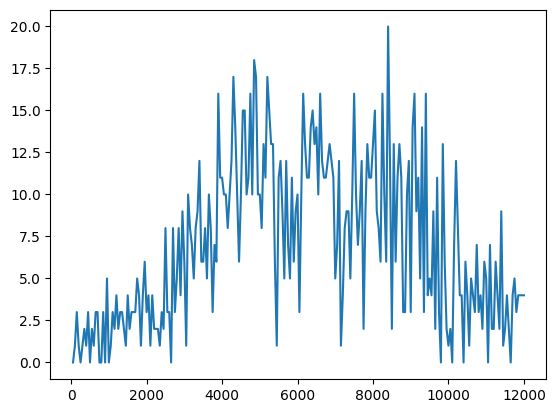

In [162]:
plt.plot(episodes, rewards)
plt.savefig("breakout_dqn_5100000_rewards.png")

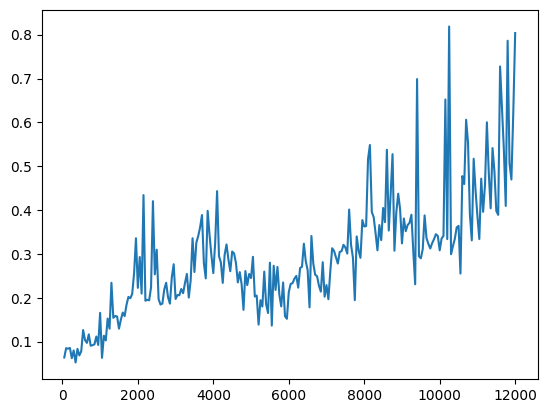

In [161]:
plt.plot(episodes, losses)
plt.savefig("breakout_dqn_5100000_loss.png")

### Save model

In [160]:
with open('breakout_dqn_5100000.pt', 'wb') as f:
    torch.save(model.state_dict(), f)